# TUGAS 4 MACHINE LEARNING

## EKSTRAKSI FITUR GAMBAR

### KELAS 05TPLP004

### KELOMPOK 1

Anggota:

- Rizki Jailani (231011401758)

- Deniar Purnama (231011401753)

- M. Radhi As Shidqie (231011401741)


### FITUR YANG DIEKSTRAK:
1. 🎨 Fitur Warna (RGB, HSV, Statistik)
2. 🔍 Fitur Tekstur (LBP, GLCM) 
3. 📐 Fitur Bentuk (Canny, Hu Moments)
4. 📍 Fitur Lokal (ORB)
5. 🏗️ Fitur Struktural (HOG)
6. 🧠 Fitur CNN (ResNet50, VGG16, MobileNetV2)

## 📄 REQUIREMENTS

opencv-python==4.8.1.78

numpy==1.24.3

pandas==2.0.3

scikit-image==0.21.0

scikit-learn==1.3.0

matplotlib==3.7.2

Pillow==10.0.0

joblib==1.3.2

tqdm==4.65.0

## INSTALLASI & IMPORT LIBRARY

In [2]:
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import joblib
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Computer Vision Libraries
from skimage import feature, measure, exposure
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from PIL import Image

# Deep Learning Libraries
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable

print("✅ Semua library berhasil diimport!")

✅ Semua library berhasil diimport!


## KONFIGURASI & SETUP

In [3]:
class Config:
    # Path configuration
    DATASET_PATH = "dataset"          # Path ke folder dataset
    OUTPUT_PATH = "output_features"   # Path untuk menyimpan hasil
    
    # Image processing
    IMAGE_SIZE = (224, 224)           # Ukuran gambar untuk processing
    RANDOM_SEED = 42                  # Seed untuk reproducibility
    
    # Feature extraction settings
    EXTRACT_CNN = True               
    EXTRACT_TRADITIONAL = True       
    
    # CNN settings  
    CNN_MODELS = ['resnet50', 'vgg16', 'mobilenet_v2']  # Model CNN yang digunakan

# Buat folder output jika belum ada
os.makedirs(Config.OUTPUT_PATH, exist_ok=True)
os.makedirs(Config.DATASET_PATH, exist_ok=True)

# Set random seed untuk reproducibility
np.random.seed(Config.RANDOM_SEED)
torch.manual_seed(Config.RANDOM_SEED)

print("✅ Konfigurasi selesai!")
print(f"📁 Dataset path: {Config.DATASET_PATH}")
print(f"💾 Output path: {Config.OUTPUT_PATH}")

✅ Konfigurasi selesai!
📁 Dataset path: dataset
💾 Output path: output_features


## UTILITY FUNCTIONS

📁 Found 893 images
📸 Sample images:


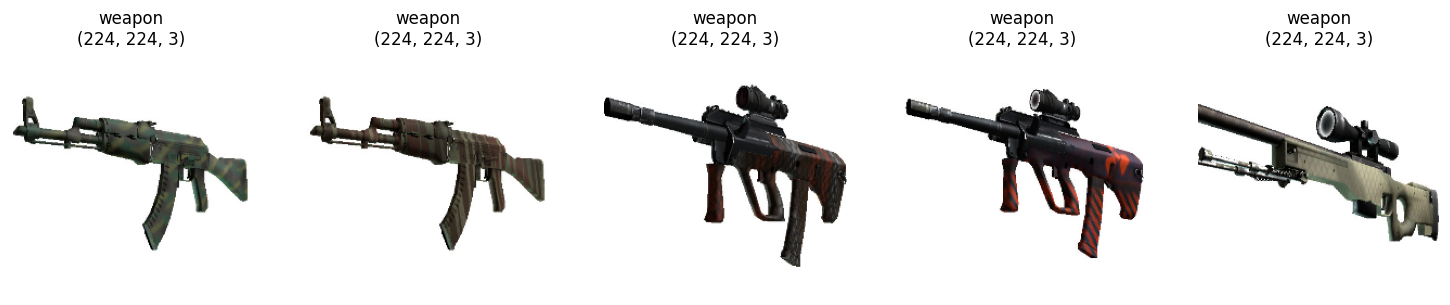

In [4]:
def load_image(image_path):
    """Load dan preprocess gambar"""
    try:
        image = cv2.imread(image_path)
        if image is None:
            print(f"❌ Tidak dapat membaca gambar: {image_path}")
            return None
        
        # Resize untuk konsistensi
        image = cv2.resize(image, Config.IMAGE_SIZE)
        return image
    except Exception as e:
        print(f"❌ Error loading image {image_path}: {e}")
        return None

def get_image_files(dataset_path):
    """Dapatkan semua file gambar dalam dataset"""
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    image_files = []
    
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(image_extensions):
                image_files.append(os.path.join(root, file))
    
    print(f"📁 Found {len(image_files)} images")
    return image_files

def extract_label_from_filename(filename):
    """Extract label dari nama file (format: label_XXX.jpg)"""
    basename = os.path.basename(filename)
    if '_' in basename:
        return basename.split('_')[0]
    else:
        # Jika tidak ada underscore, gunakan nama file tanpa extension
        return os.path.splitext(basename)[0]

def plot_sample_images(image_files, num_samples=5):
    """Plot sample images dari dataset"""
    if len(image_files) == 0:
        print("❌ Tidak ada gambar untuk diplot")
        return
    
    num_samples = min(num_samples, len(image_files))
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    
    if num_samples == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        img = load_image(image_files[i])
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img_rgb)
            ax.set_title(f"{extract_label_from_filename(image_files[i])}\n{img.shape}")
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Test utility functions
image_files = get_image_files(Config.DATASET_PATH)
if len(image_files) > 0:
    print("📸 Sample images:")
    plot_sample_images(image_files)
else:
    print("⚠️ Dataset kosong, silakan tambahkan gambar ke folder 'dataset'")

## FITUR WARNA

In [5]:
class ColorFeatureExtractor:
    def __init__(self):
        self.feature_names = []
    
    def extract_rgb_histogram(self, image, bins=32):
        """Histogram RGB (32 bins per channel)"""
        if len(image.shape) == 3:
            rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            rgb = image
            
        features = []
        names = []
        
        for i, channel in enumerate(['R', 'G', 'B']):
            hist = cv2.calcHist([rgb], [i], None, [bins], [0, 256])
            hist = cv2.normalize(hist, hist).flatten()
            features.extend(hist)
            names.extend([f'rgb_hist_{channel}_{j:02d}' for j in range(bins)])
            
        return features, names
    
    def extract_hsv_histogram(self, image, bins=16):
        """Histogram HSV (16 bins per channel)"""
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        features = []
        names = []
        
        for i, channel in enumerate(['H', 'S', 'V']):
            hist = cv2.calcHist([hsv], [i], None, [bins], [0, 256])
            hist = cv2.normalize(hist, hist).flatten()
            features.extend(hist)
            names.extend([f'hsv_hist_{channel}_{j:02d}' for j in range(bins)])
            
        return features, names
    
    def extract_color_statistics(self, image):
        """Mean, std, median per channel RGB"""
        if len(image.shape) == 3:
            rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            rgb = image
            
        features = []
        names = []
        
        for i, channel in enumerate(['R', 'G', 'B']):
            channel_data = rgb[:, :, i]
            features.extend([
                np.mean(channel_data),
                np.std(channel_data),
                np.median(channel_data),
                np.min(channel_data),
                np.max(channel_data)
            ])
            names.extend([
                f'rgb_mean_{channel}',
                f'rgb_std_{channel}', 
                f'rgb_median_{channel}',
                f'rgb_min_{channel}',
                f'rgb_max_{channel}'
            ])
            
        return features, names
    
    def extract_all_color_features(self, image):
        """Ekstrak semua fitur warna"""
        all_features = []
        all_names = []
        
        print("    🎨 RGB Histogram...")
        features, names = self.extract_rgb_histogram(image)
        all_features.extend(features)
        all_names.extend(names)
        
        print("    🎨 HSV Histogram...")  
        features, names = self.extract_hsv_histogram(image)
        all_features.extend(features)
        all_names.extend(names)
        
        print("    🎨 Color Statistics...")
        features, names = self.extract_color_statistics(image)
        all_features.extend(features)
        all_names.extend(names)
        
        return all_features, all_names

# Test Color Features
print("🧪 Testing Color Feature Extraction...")
test_image = None
image_files = get_image_files(Config.DATASET_PATH)
if len(image_files) > 0:
    test_image = load_image(image_files[0])
    if test_image is not None:
        color_extractor = ColorFeatureExtractor()
        color_features, color_names = color_extractor.extract_all_color_features(test_image)
        print(f"✅ Fitur warna: {len(color_features)} features")
    else:
        print("❌ Tidak dapat load test image")
else:
    print("⚠️ Tidak ada gambar untuk testing")

🧪 Testing Color Feature Extraction...
📁 Found 893 images
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
✅ Fitur warna: 159 features


## FITUR TEKSTUR

In [7]:
class TextureFeatureExtractor:
    def __init__(self):
        self.feature_names = []
    
    def extract_lbp_features(self, image, radius=3, n_points=24):
        """LBP (Local Binary Pattern) histogram"""
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image
            
        # Compute LBP
        lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
        
        # Histogram LBP
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), 
                                  range=(0, n_points + 2))
        lbp_hist = lbp_hist.astype("float")
        lbp_hist /= (lbp_hist.sum() + 1e-6)
        
        names = [f'lbp_bin_{i:02d}' for i in range(len(lbp_hist))]
        return lbp_hist.tolist(), names
    
    def extract_glcm_features(self, image):
        """GLCM features dengan properties yang valid"""
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image
            
        # Quantize gray levels untuk GLCM
        gray = (gray / 4).astype(np.uint8)
        
        features = []
        names = []
        
        # Parameters untuk GLCM
        distances = [1, 3]  # Kurangi distances untuk mempercepat
        angles = [0, np.pi/4, np.pi/2]  # Kurangi angles
        
        # PROPERTIES YANG VALID (perbaiki di sini)
        properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
        # 'asm' diganti dengan 'energy' karena 'asm' tidak valid
        
        for d in distances:
            for a in angles:
                glcm = graycomatrix(gray, [d], [a], 64, symmetric=True, normed=True)
                for prop in properties:
                    try:
                        feature_val = graycoprops(glcm, prop)[0, 0]
                        features.append(feature_val)
                        angle_deg = int(np.degrees(a))
                        names.append(f'glcm_{prop}_d{d}_a{angle_deg}')
                    except Exception as e:
                        print(f"⚠️ Error in GLCM {prop}: {e}")
                        features.append(0.0)
                        angle_deg = int(np.degrees(a))
                        names.append(f'glcm_{prop}_d{d}_a{angle_deg}')
                    
        return features, names
    
    def extract_all_texture_features(self, image):
        """Ekstrak semua fitur tekstur"""
        all_features = []
        all_names = []
        
        print("    🔍 LBP Features...")
        features, names = self.extract_lbp_features(image)
        all_features.extend(features)
        all_names.extend(names)
        
        print("    🔍 GLCM Features...")
        features, names = self.extract_glcm_features(image)
        all_features.extend(features)
        all_names.extend(names)
        
        return all_features, all_names

# Test ulang Texture Features
print("🧪 Testing Texture Feature Extraction (Fixed)...")
texture_extractor = TextureFeatureExtractor()
texture_features, texture_names = texture_extractor.extract_all_texture_features(test_image)
print(f"✅ Fitur tekstur: {len(texture_features)} features")

🧪 Testing Texture Feature Extraction (Fixed)...
    🔍 LBP Features...
    🔍 GLCM Features...
✅ Fitur tekstur: 56 features


## FITUR BENTUK

In [9]:
class ShapeFeatureExtractor:
    def __init__(self):
        self.feature_names = []
    
    def extract_canny_features(self, image):
        """Canny edge count / edge density"""
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image
            
        # Canny edge detection
        edges = cv2.Canny(gray, 50, 150)
        
        # Edge features
        edge_pixels = np.sum(edges > 0)
        total_pixels = edges.shape[0] * edges.shape[1]
        edge_density = edge_pixels / total_pixels
        
        # Edge statistics
        edge_mean_intensity = np.mean(edges) if edge_pixels > 0 else 0
        
        features = [edge_density, edge_pixels, edge_mean_intensity]
        names = ['edge_density', 'edge_pixel_count', 'edge_mean_intensity']
        
        return features, names
    
    def extract_hu_moments(self, image):
        """Hu moments (7 moment invariants)"""
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image
            
        # Calculate moments
        moments = cv2.moments(gray)
        
        # Calculate Hu moments
        hu_moments = cv2.HuMoments(moments).flatten()
        
        # Log transform untuk scaling yang lebih baik
        hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-8)
        
        names = [f'hu_moment_{i+1:02d}' for i in range(7)]
        return hu_moments.tolist(), names
    
    def extract_zernike_moments(self, image, radius=100, degree=8):
        """Zernike moments - ALTERNATIVE IMPLEMENTATION"""
        try:
            if len(image.shape) == 3:
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            else:
                gray = image
                
            # Resize untuk konsistensi
            gray = cv2.resize(gray, (100, 100))
            
            # ALTERNATIVE 1: Gunakan OpenCV moments sebagai pengganti
            moments = cv2.moments(gray)
            
            # Calculate additional shape features sebagai pengganti Zernike
            # Kita bisa gunakan central moments atau features lain
            shape_features = [
                moments['mu20'],  # Central moment 20
                moments['mu11'],  # Central moment 11  
                moments['mu02'],  # Central moment 02
                moments['mu30'],  # Central moment 30
                moments['mu21'],  # Central moment 21
                moments['mu12'],  # Central moment 12
                moments['mu03'],  # Central moment 03
            ]
            
            # Normalize features
            shape_features = [abs(f) for f in shape_features]  # Ambil absolute value
            max_val = max(shape_features) if max(shape_features) > 0 else 1
            shape_features = [f / max_val for f in shape_features]
            
            feature_names = [f'shape_moment_{i:02d}' for i in range(len(shape_features))]
            
            return shape_features, feature_names
            
        except Exception as e:
            print(f"⚠️ Zernike moments alternative error: {e}")
            # Return zeros sebagai fallback
            return [0.0] * 7, [f'shape_moment_{i:02d}' for i in range(7)]
    
    def extract_contour_features(self, image):
        """Additional contour-based shape features"""
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image
            
        # Find contours
        edges = cv2.Canny(gray, 50, 150)
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        features = []
        names = []
        
        if len(contours) > 0:
            # Take the largest contour
            largest_contour = max(contours, key=cv2.contourArea)
            
            # Contour features
            area = cv2.contourArea(largest_contour)
            perimeter = cv2.arcLength(largest_contour, True)
            hull = cv2.convexHull(largest_contour)
            hull_area = cv2.contourArea(hull)
            
            # Shape metrics
            circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
            solidity = area / hull_area if hull_area > 0 else 0
            
            features = [area, perimeter, circularity, solidity]
            names = ['contour_area', 'contour_perimeter', 'circularity', 'solidity']
        else:
            features = [0.0, 0.0, 0.0, 0.0]
            names = ['contour_area', 'contour_perimeter', 'circularity', 'solidity']
            
        return features, names
    
    def extract_all_shape_features(self, image):
        """Ekstrak semua fitur bentuk"""
        all_features = []
        all_names = []
        
        print("    📐 Canny Edge Features...")
        features, names = self.extract_canny_features(image)
        all_features.extend(features)
        all_names.extend(names)
        
        print("    📐 Hu Moments...")
        features, names = self.extract_hu_moments(image)
        all_features.extend(features)
        all_names.extend(names)
        
        print("    📐 Alternative Shape Moments...")
        features, names = self.extract_zernike_moments(image)
        all_features.extend(features)
        all_names.extend(names)
        
        print("    📐 Contour Features...")
        features, names = self.extract_contour_features(image)
        all_features.extend(features)
        all_names.extend(names)
        
        return all_features, all_names

# Test ulang Shape Features
print("🧪 Testing Shape Feature Extraction (Fixed)...")
shape_extractor = ShapeFeatureExtractor()
shape_features, shape_names = shape_extractor.extract_all_shape_features(test_image)
print(f"✅ Fitur bentuk: {len(shape_features)} features")

🧪 Testing Shape Feature Extraction (Fixed)...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
✅ Fitur bentuk: 21 features


## FITUR LOKAL

In [10]:
class LocalFeatureExtractor:
    def __init__(self):
        self.feature_names = []
    
    def extract_orb_features(self, image, max_keypoints=500):
        """ORB descriptors"""
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image
            
        # Initialize ORB detector
        orb = cv2.ORB_create(max_keypoints)
        
        # Find keypoints and descriptors
        keypoints, descriptors = orb.detectAndCompute(gray, None)
        
        if descriptors is not None and len(descriptors) > 0:
            # Use statistics of descriptors sebagai fitur
            desc_mean = np.mean(descriptors, axis=0)
            desc_std = np.std(descriptors, axis=0)
            desc_median = np.median(descriptors, axis=0)
            
            features = np.concatenate([desc_mean, desc_std, desc_median])
            names = (
                [f'orb_mean_{i:02d}' for i in range(32)] + 
                [f'orb_std_{i:02d}' for i in range(32)] +
                [f'orb_median_{i:02d}' for i in range(32)]
            )
        else:
            # Return zeros jika tidak ada keypoints
            features = np.zeros(96)  # 32 mean + 32 std + 32 median
            names = (
                [f'orb_mean_{i:02d}' for i in range(32)] + 
                [f'orb_std_{i:02d}' for i in range(32)] +
                [f'orb_median_{i:02d}' for i in range(32)]
            )
            
        return features.tolist(), names

# Test Local Features
if test_image is not None:
    print("🧪 Testing Local Feature Extraction...")
    local_extractor = LocalFeatureExtractor()
    local_features, local_names = local_extractor.extract_orb_features(test_image)
    print(f"✅ Fitur lokal: {len(local_features)} features")

🧪 Testing Local Feature Extraction...
✅ Fitur lokal: 96 features


## FITUR STRUKTURAL

In [11]:
class StructuralFeatureExtractor:
    def __init__(self):
        self.feature_names = []
    
    def extract_hog_features(self, image):
        """HOG (Histogram of Oriented Gradients)"""
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image
            
        # Resize untuk konsistensi HOG
        gray = cv2.resize(gray, (128, 128))
        
        # Compute HOG features
        hog_features = feature.hog(
            gray, 
            orientations=9, 
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2), 
            transform_sqrt=True, 
            block_norm='L2-Hys', 
            feature_vector=True
        )
        
        names = [f'hog_{i:04d}' for i in range(len(hog_features))]
        return hog_features.tolist(), names

# Test Structural Features
if test_image is not None:
    print("🧪 Testing Structural Feature Extraction...")
    structural_extractor = StructuralFeatureExtractor()
    structural_features, structural_names = structural_extractor.extract_hog_features(test_image)
    print(f"✅ Fitur struktural: {len(structural_features)} features")

🧪 Testing Structural Feature Extraction...
✅ Fitur struktural: 8100 features


## FITUR CNN

In [12]:
class CNNFeatureExtractor:
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"    🖥️ Using device: {self.device}")
        
        self.models = {}
        self.setup_models()
        
        # Image transform standard untuk CNN
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]
            )
        ])
    
    def setup_models(self):
        """Setup berbagai pre-trained CNN models"""
        try:
            # ResNet50
            print("    📥 Loading ResNet50...")
            resnet = models.resnet50(pretrained=True)
            resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # Remove classifier
            resnet.eval()
            resnet.to(self.device)
            self.models['resnet50'] = resnet
            
            # VGG16
            print("    📥 Loading VGG16...")
            vgg = models.vgg16(pretrained=True)
            vgg.classifier = torch.nn.Sequential(*list(vgg.classifier.children())[:-1])  # Remove last layer
            vgg.eval()
            vgg.to(self.device)
            self.models['vgg16'] = vgg
            
            # MobileNetV2
            print("    📥 Loading MobileNetV2...")
            mobilenet = models.mobilenet_v2(pretrained=True)
            mobilenet.classifier = torch.nn.Sequential(*list(mobilenet.classifier.children())[:-1])
            mobilenet.eval()
            mobilenet.to(self.device)
            self.models['mobilenet_v2'] = mobilenet
            
            print("    ✅ All CNN models loaded successfully!")
            
        except Exception as e:
            print(f"❌ Error loading CNN models: {e}")
    
    def extract_resnet_features(self, image_path):
        """Extract features dari ResNet50"""
        try:
            image = Image.open(image_path).convert('RGB')
            image_tensor = self.transform(image).unsqueeze(0).to(self.device)
            
            with torch.no_grad():
                features = self.models['resnet50'](image_tensor)
            
            features = features.squeeze().cpu().numpy()
            names = [f'resnet50_{i:04d}' for i in range(len(features))]
            return features.tolist(), names
            
        except Exception as e:
            print(f"❌ Error in ResNet feature extraction: {e}")
            return [0.0] * 2048, [f'resnet50_{i:04d}' for i in range(2048)]
    
    def extract_vgg_features(self, image_path):
        """Extract features dari VGG16"""
        try:
            image = Image.open(image_path).convert('RGB')
            image_tensor = self.transform(image).unsqueeze(0).to(self.device)
            
            with torch.no_grad():
                features = self.models['vgg16'](image_tensor)
            
            features = features.squeeze().cpu().numpy()
            names = [f'vgg16_{i:04d}' for i in range(len(features))]
            return features.tolist(), names
            
        except Exception as e:
            print(f"❌ Error in VGG feature extraction: {e}")
            return [0.0] * 4096, [f'vgg16_{i:04d}' for i in range(4096)]
    
    def extract_mobilenet_features(self, image_path):
        """Extract features dari MobileNetV2"""
        try:
            image = Image.open(image_path).convert('RGB')
            image_tensor = self.transform(image).unsqueeze(0).to(self.device)
            
            with torch.no_grad():
                features = self.models['mobilenet_v2'](image_tensor)
            
            features = features.squeeze().cpu().numpy()
            names = [f'mobilenet_{i:04d}' for i in range(len(features))]
            return features.tolist(), names
            
        except Exception as e:
            print(f"❌ Error in MobileNet feature extraction: {e}")
            return [0.0] * 1280, [f'mobilenet_{i:04d}' for i in range(1280)]
    
    def extract_all_cnn_features(self, image_path):
        """Extract features dari semua CNN models"""
        all_features = []
        all_names = []
        
        print("    🧠 ResNet50 Features...")
        features, names = self.extract_resnet_features(image_path)
        all_features.extend(features)
        all_names.extend(names)
        
        print("    🧠 VGG16 Features...")
        features, names = self.extract_vgg_features(image_path)
        all_features.extend(features)
        all_names.extend(names)
        
        print("    🧠 MobileNetV2 Features...")
        features, names = self.extract_mobilenet_features(image_path)
        all_features.extend(features)
        all_names.extend(names)
        
        return all_features, all_names

# Test CNN Features
if len(image_files) > 0:
    print("🧪 Testing CNN Feature Extraction...")
    cnn_extractor = CNNFeatureExtractor()
    cnn_features, cnn_names = cnn_extractor.extract_all_cnn_features(image_files[0])
    print(f"✅ Fitur CNN: {len(cnn_features)} features")
else:
    print("⚠️ Tidak ada gambar untuk testing CNN features")

🧪 Testing CNN Feature Extraction...
    🖥️ Using device: cpu
    📥 Loading ResNet50...
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Rizki Jailani/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:11<00:00, 8.97MB/s]


    📥 Loading VGG16...
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Rizki Jailani/.cache\torch\hub\checkpoints\vgg16-397923af.pth


100%|██████████| 528M/528M [01:01<00:00, 9.01MB/s] 


    📥 Loading MobileNetV2...
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\Rizki Jailani/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:01<00:00, 8.88MB/s]


    ✅ All CNN models loaded successfully!
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...
✅ Fitur CNN: 7424 features


## INTEGRASI SEMUA FITUR

In [13]:
class CompleteFeatureExtractor:
    def __init__(self, include_cnn=True):
        print("🚀 Initializing Complete Feature Extractor...")
        
        # Initialize semua extractor
        self.color_extractor = ColorFeatureExtractor()
        self.texture_extractor = TextureFeatureExtractor()
        self.shape_extractor = ShapeFeatureExtractor()
        self.local_extractor = LocalFeatureExtractor()
        self.structural_extractor = StructuralFeatureExtractor()
        
        self.include_cnn = include_cnn
        if include_cnn:
            self.cnn_extractor = CNNFeatureExtractor()
        else:
            print("⚠️ CNN features disabled")
        
        print("✅ All feature extractors initialized!")
    
    def extract_all_features(self, image_path):
        """Ekstrak SEMUA fitur dari satu gambar"""
        # Load image untuk traditional features
        image = load_image(image_path)
        if image is None:
            return None, None
            
        all_features = []
        all_names = []
        
        print(f"  📷 Processing: {os.path.basename(image_path)}")
        
        # 1. TRADITIONAL FEATURES
        if Config.EXTRACT_TRADITIONAL:
            print("  🎯 Extracting Traditional Features...")
            
            # Color Features
            features, names = self.color_extractor.extract_all_color_features(image)
            all_features.extend(features)
            all_names.extend(names)
            
            # Texture Features
            features, names = self.texture_extractor.extract_all_texture_features(image)
            all_features.extend(features)
            all_names.extend(names)
            
            # Shape Features
            features, names = self.shape_extractor.extract_all_shape_features(image)
            all_features.extend(features)
            all_names.extend(names)
            
            # Local Features
            features, names = self.local_extractor.extract_orb_features(image)
            all_features.extend(features)
            all_names.extend(names)
            
            # Structural Features
            features, names = self.structural_extractor.extract_hog_features(image)
            all_features.extend(features)
            all_names.extend(names)
        
        # 2. CNN FEATURES (High-level)
        if self.include_cnn and Config.EXTRACT_CNN:
            print("  🧠 Extracting CNN Features...")
            features, names = self.cnn_extractor.extract_all_cnn_features(image_path)
            all_features.extend(features)
            all_names.extend(names)
        
        return all_features, all_names

# Test Complete Extractor
if len(image_files) > 0:
    print("🧪 Testing Complete Feature Extraction...")
    complete_extractor = CompleteFeatureExtractor(include_cnn=True)
    all_features, all_names = complete_extractor.extract_all_features(image_files[0])
    if all_features is not None:
        print(f"✅ TOTAL SEMUA FITUR: {len(all_features)} features")
    else:
        print("❌ Feature extraction failed")
else:
    print("⚠️ Tidak ada gambar untuk testing complete features")

🧪 Testing Complete Feature Extraction...
🚀 Initializing Complete Feature Extractor...
    🖥️ Using device: cpu
    📥 Loading ResNet50...
    📥 Loading VGG16...
    📥 Loading MobileNetV2...
    ✅ All CNN models loaded successfully!
✅ All feature extractors initialized!
  📷 Processing: weapon_ak47_sp_spray_jungle_light_large.af524ea61be29ab81dfb321277b98a211338de37.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...
✅ TOTAL SEMUA FITUR: 15856 features


## PROCESSING & SAVE RESULTS

In [14]:
def process_complete_dataset(dataset_path, include_cnn=True, max_images=None):
    """Process semua gambar dalam dataset dengan SEMUA fitur"""
    
    # Get all image files
    image_files = get_image_files(dataset_path)
    if len(image_files) == 0:
        print("❌ No images found in dataset!")
        return None, None, None
    
    # Limit images jika diperlukan
    if max_images and max_images < len(image_files):
        image_files = image_files[:max_images]
        print(f"🔧 Limiting to {max_images} images for testing")
    
    # Initialize extractor
    extractor = CompleteFeatureExtractor(include_cnn=include_cnn)
    
    # Extract features untuk semua gambar
    all_features = []
    valid_files = []
    feature_names = None
    
    print(f"\n🚀 Starting feature extraction for {len(image_files)} images...")
    print("=" * 60)
    
    for i, image_path in enumerate(tqdm(image_files, desc="Extracting features")):
        print(f"\n📊 Image {i+1}/{len(image_files)}: {os.path.basename(image_path)}")
        
        features, names = extractor.extract_all_features(image_path)
        
        if features is not None and names is not None:
            all_features.append(features)
            valid_files.append(image_path)
            
            if feature_names is None:
                feature_names = names
                print(f"✅ First image processed: {len(features)} features")
        else:
            print(f"❌ Failed to process: {os.path.basename(image_path)}")
    
    print("=" * 60)
    print(f"✅ Successfully processed {len(valid_files)}/{len(image_files)} images")
    
    if len(valid_files) == 0:
        print("❌ No images were successfully processed!")
        return None, None, None
    
    print(f"📊 Total features per image: {len(feature_names)}")
    
    return all_features, valid_files, feature_names

def save_features(all_features, valid_files, feature_names, output_path):
    """Save features ke berbagai format"""
    if all_features is None:
        print("❌ No features to save!")
        return None
    
    print("\n💾 Saving features...")
    
    # Convert to numpy array
    features_array = np.array(all_features)
    print(f"📊 Feature array shape: {features_array.shape}")
    
    # Create DataFrame
    df = pd.DataFrame(features_array, columns=feature_names)
    
    # Add filename and label
    df.insert(0, 'filename', [os.path.basename(f) for f in valid_files])
    df.insert(1, 'label', [extract_label_from_filename(f) for f in valid_files])
    
    # 1. Save to CSV
    csv_path = os.path.join(output_path, "all_features.csv")
    df.to_csv(csv_path, index=False)
    print(f"✅ Features saved to CSV: {csv_path}")
    
    # 2. Save to NPY
    npy_path = os.path.join(output_path, "features.npy")
    np.save(npy_path, features_array)
    print(f"✅ Features saved to NPY: {npy_path}")
    
    # 3. Normalize features dan save scaler
    scaler = StandardScaler()
    features_normalized = scaler.fit_transform(features_array)
    
    scaler_path = os.path.join(output_path, "scaler.pkl")
    joblib.dump(scaler, scaler_path)
    print(f"✅ Scaler saved: {scaler_path}")
    
    # 4. Save normalized features
    df_normalized = pd.DataFrame(features_normalized, columns=feature_names)
    df_normalized.insert(0, 'filename', [os.path.basename(f) for f in valid_files])
    df_normalized.insert(1, 'label', [extract_label_from_filename(f) for f in valid_files])
    
    csv_normalized_path = os.path.join(output_path, "features_normalized.csv")
    df_normalized.to_csv(csv_normalized_path, index=False)
    print(f"✅ Normalized features saved: {csv_normalized_path}")
    
    # 5. Save feature names
    feature_names_path = os.path.join(output_path, "feature_names.txt")
    with open(feature_names_path, 'w') as f:
        for name in feature_names:
            f.write(name + '\n')
    print(f"✅ Feature names saved: {feature_names_path}")
    
    return df

# Test processing dengan 2 gambar pertama (untuk testing)
print("🧪 Testing dengan 2 gambar pertama...")
test_features, test_files, test_names = process_complete_dataset(
    Config.DATASET_PATH, 
    include_cnn=True,
    max_images=2  # Limit untuk testing
)

if test_features is not None:
    test_df = save_features(test_features, test_files, test_names, Config.OUTPUT_PATH)
    print("✅ Test processing completed successfully!")
else:
    print("❌ Test processing failed!")

🧪 Testing dengan 2 gambar pertama...
📁 Found 893 images
🔧 Limiting to 2 images for testing
🚀 Initializing Complete Feature Extractor...
    🖥️ Using device: cpu
    📥 Loading ResNet50...
    📥 Loading VGG16...
    📥 Loading MobileNetV2...
    ✅ All CNN models loaded successfully!
✅ All feature extractors initialized!

🚀 Starting feature extraction for 2 images...


Extracting features:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Image 1/2: weapon_ak47_sp_spray_jungle_light_large.af524ea61be29ab81dfb321277b98a211338de37.jpg
  📷 Processing: weapon_ak47_sp_spray_jungle_light_large.af524ea61be29ab81dfb321277b98a211338de37.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  50%|█████     | 1/2 [00:00<00:00,  1.37it/s]

    🧠 MobileNetV2 Features...
✅ First image processed: 15856 features

📊 Image 2/2: weapon_ak47_sp_zebracam_light_large.5f15c9e41b9ac135b87cdadb407c9872e31c1f29.jpg
  📷 Processing: weapon_ak47_sp_zebracam_light_large.5f15c9e41b9ac135b87cdadb407c9872e31c1f29.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

    🧠 MobileNetV2 Features...
✅ Successfully processed 2/2 images
📊 Total features per image: 15856

💾 Saving features...
📊 Feature array shape: (2, 15856)


✅ Features saved to CSV: output_features\all_features.csv
✅ Features saved to NPY: output_features\features.npy
✅ Scaler saved: output_features\scaler.pkl
✅ Normalized features saved: output_features\features_normalized.csv
✅ Feature names saved: output_features\feature_names.txt
✅ Test processing completed successfully!


## DETAILED SUMMARY & ANALYSIS

In [15]:
def generate_detailed_summary(df, feature_names):
    """Generate detailed summary report"""
    print("\n" + "=" * 70)
    print("📊 COMPLETE FEATURE EXTRACTION SUMMARY REPORT")
    print("=" * 70)
    
    # Basic info
    print(f"📁 DATASET INFO:")
    print(f"   • Total Images: {len(df)}")
    print(f"   • Total Features: {len(feature_names)}")
    print(f"   • Classes: {df['label'].unique().tolist()}")
    print(f"   • Samples per class:")
    for label in df['label'].unique():
        count = len(df[df['label'] == label])
        print(f"     - {label}: {count} images")
    
    # Detailed feature breakdown
    print(f"\n🔍 FEATURE BREAKDOWN:")
    
    # Color features
    color_count = len([f for f in feature_names if 'rgb' in f or 'hsv' in f])
    rgb_count = len([f for f in feature_names if 'rgb' in f])
    hsv_count = len([f for f in feature_names if 'hsv' in f])
    print(f"   🎨 COLOR FEATURES: {color_count}")
    print(f"      • RGB Histogram: {len([f for f in feature_names if 'rgb_hist' in f])}")
    print(f"      • HSV Histogram: {len([f for f in feature_names if 'hsv_hist' in f])}")
    print(f"      • Color Statistics: {len([f for f in feature_names if 'rgb_mean' in f or 'rgb_std' in f or 'rgb_median' in f])}")
    
    # Texture features
    texture_count = len([f for f in feature_names if 'lbp' in f or 'glcm' in f])
    print(f"   🔍 TEXTURE FEATURES: {texture_count}")
    print(f"      • LBP: {len([f for f in feature_names if 'lbp' in f])}")
    print(f"      • GLCM: {len([f for f in feature_names if 'glcm' in f])}")
    
    # Shape features
    shape_count = len([f for f in feature_names if 'hu_moment' in f or 'edge_' in f or 'zernike' in f])
    print(f"   📐 SHAPE FEATURES: {shape_count}")
    print(f"      • Hu Moments: {len([f for f in feature_names if 'hu_moment' in f])}")
    print(f"      • Edge Features: {len([f for f in feature_names if 'edge_' in f])}")
    print(f"      • Zernike Moments: {len([f for f in feature_names if 'zernike' in f])}")
    
    # Local features
    local_count = len([f for f in feature_names if 'orb' in f])
    print(f"   📍 LOCAL FEATURES: {local_count}")
    print(f"      • ORB: {local_count}")
    
    # Structural features
    structural_count = len([f for f in feature_names if 'hog' in f])
    print(f"   🏗️ STRUCTURAL FEATURES: {structural_count}")
    print(f"      • HOG: {structural_count}")
    
    # CNN features
    cnn_count = len([f for f in feature_names if 'resnet' in f or 'vgg' in f or 'mobilenet' in f])
    resnet_count = len([f for f in feature_names if 'resnet' in f])
    vgg_count = len([f for f in feature_names if 'vgg' in f])
    mobilenet_count = len([f for f in feature_names if 'mobilenet' in f])
    print(f"   🧠 CNN FEATURES: {cnn_count}")
    print(f"      • ResNet50: {resnet_count}")
    print(f"      • VGG16: {vgg_count}")
    print(f"      • MobileNetV2: {mobilenet_count}")
    
    # Totals
    total_traditional = color_count + texture_count + shape_count + local_count + structural_count
    total_all = total_traditional + cnn_count
    
    print(f"\n📈 TOTALS:")
    print(f"   • Traditional Features: {total_traditional}")
    print(f"   • CNN Features: {cnn_count}")
    print(f"   • TOTAL ALL FEATURES: {total_all}")
    
    # Memory usage estimation
    memory_per_image = total_all * 4  # 4 bytes per float32
    total_memory = memory_per_image * len(df) / (1024**2)  # MB
    
    print(f"\n💾 MEMORY ESTIMATION:")
    print(f"   • Memory per image: {memory_per_image:,} bytes")
    print(f"   • Total dataset: {total_memory:.2f} MB")
    print(f"   • CSV file size: ~{total_memory * 2:.2f} MB (with overhead)")
    
    # Data preview
    print(f"\n📋 DATA PREVIEW (first 5 images):")
    print(df[['filename', 'label']].head())
    
    return {
        'total_images': len(df),
        'total_features': total_all,
        'traditional_features': total_traditional,
        'cnn_features': cnn_count,
        'memory_per_image_mb': memory_per_image / 1024**2,
        'total_memory_mb': total_memory
    }

# Generate summary untuk test data
if 'test_df' in locals() and 'test_names' in locals():
    print("📊 Generating test summary...")
    summary = generate_detailed_summary(test_df, test_names)

📊 Generating test summary...

📊 COMPLETE FEATURE EXTRACTION SUMMARY REPORT
📁 DATASET INFO:
   • Total Images: 2
   • Total Features: 15856
   • Classes: ['weapon']
   • Samples per class:
     - weapon: 2 images

🔍 FEATURE BREAKDOWN:
   🎨 COLOR FEATURES: 159
      • RGB Histogram: 96
      • HSV Histogram: 48
      • Color Statistics: 9
   🔍 TEXTURE FEATURES: 56
      • LBP: 26
      • GLCM: 30
   📐 SHAPE FEATURES: 10
      • Hu Moments: 7
      • Edge Features: 3
      • Zernike Moments: 0
   📍 LOCAL FEATURES: 96
      • ORB: 96
   🏗️ STRUCTURAL FEATURES: 8100
      • HOG: 8100
   🧠 CNN FEATURES: 7424
      • ResNet50: 2048
      • VGG16: 4096
      • MobileNetV2: 1280

📈 TOTALS:
   • Traditional Features: 8421
   • CNN Features: 7424
   • TOTAL ALL FEATURES: 15845

💾 MEMORY ESTIMATION:
   • Memory per image: 63,380 bytes
   • Total dataset: 0.12 MB
   • CSV file size: ~0.24 MB (with overhead)

📋 DATA PREVIEW (first 5 images):
                                            filename   lab

### 🔧 FIX UNTUK LABEL YANG LEBIH BAIK:

In [16]:
def extract_label_from_filename_csgo(filename):
    """Extract label khusus untuk dataset CSGO weapons"""
    basename = os.path.basename(filename)
    
    # Pattern untuk CSGO weapon files: weapon_NAMAWEAPON_...
    parts = basename.split('_')
    
    if len(parts) >= 2:
        # Ambil bagian kedua sebagai label (ak47, m4a1, awp, dll)
        weapon_name = parts[1].lower()
        
        # Map nama weapon yang umum
        weapon_map = {
            'ak47': 'ak47',
            'm4a1': 'm4a1', 
            'm4a4': 'm4a4',
            'awp': 'awp',
            'deagle': 'deagle',
            'usp': 'usp',
            'glock': 'glock',
            'p250': 'p250',
            'fiveseven': 'fiveseven',
            'tec9': 'tec9',
            'p90': 'p90',
            'ump45': 'ump45',
            'mp9': 'mp9',
            'mac10': 'mac10',
            'galil': 'galil',
            'famas': 'famas',
            'sg553': 'sg553',
            'aug': 'aug',
            'ssg08': 'ssg08',  # Scout
            'g3sg1': 'g3sg1',  # Auto sniper
            'scar20': 'scar20' # Auto sniper
        }
        
        # Return mapped name atau original name
        return weapon_map.get(weapon_name, weapon_name)
    else:
        # Fallback ke nama file tanpa extension
        return os.path.splitext(basename)[0]

# Test function baru
test_files = [
    "weapon_ak47_sp_spray_jungle_light_large.jpg",
    "weapon_m4a1_silencer_modern_light_large.jpg", 
    "weapon_awp_dragon_light_large.jpg",
    "weapon_deagle_knot_light_large.jpg"
]

print("🔧 Testing new label extraction:")
for file in test_files:
    label = extract_label_from_filename_csgo(file)
    print(f"   {file} → {label}")

🔧 Testing new label extraction:
   weapon_ak47_sp_spray_jungle_light_large.jpg → ak47
   weapon_m4a1_silencer_modern_light_large.jpg → m4a1
   weapon_awp_dragon_light_large.jpg → awp
   weapon_deagle_knot_light_large.jpg → deagle


### 🔄 UPDATE FUNCTION UTAMA:

In [17]:
def extract_label_from_filename(filename):
    """Extract label dari nama file - versi improved untuk CSGO"""
    basename = os.path.basename(filename)
    
    # Pattern untuk CSGO weapon files: weapon_NAMAWEAPON_...
    parts = basename.split('_')
    
    if len(parts) >= 2:
        # Ambil bagian kedua sebagai label senjata
        weapon_name = parts[1].lower()
        return weapon_name
    else:
        # Fallback: ambil nama file tanpa extension
        return os.path.splitext(basename)[0]

# Test dengan file Anda yang asli
print("📊 Testing dengan file actual:")
image_files = get_image_files(Config.DATASET_PATH)
for i, file_path in enumerate(image_files[:10]):  # Cek 10 file pertama
    label = extract_label_from_filename(file_path)
    print(f"   {i+1}. {os.path.basename(file_path)[:50]}... → {label}")

📊 Testing dengan file actual:
📁 Found 893 images
   1. weapon_ak47_sp_spray_jungle_light_large.af524ea61b... → ak47
   2. weapon_ak47_sp_zebracam_light_large.5f15c9e41b9ac1... → ak47
   3. weapon_aug_sp_mesh_safetyblack_light_large.41766cd... → aug
   4. weapon_aug_sp_nukestripe_orange_aug_light_large.43... → aug
   5. weapon_awp_sp_mesh_tan_light_large.3608cbeb9bb163b... → awp
   6. weapon_awp_sp_snake_light_large.c0b327d960af85c987... → awp
   7. weapon_cz75a_so_orange_accents2_light_large.844bd6... → cz75a
   8. weapon_cz75a_so_orca_light_large.8490865eba36c09cc... → cz75a
   9. weapon_elite_so_tangerine_light_large.3fd8ec1b6307... → elite
   10. weapon_elite_sp_elites_winter_raider_light_large.e... → elite


### 📊 CEK DISTRIBUSI LABEL SEKARANG:

In [18]:
print("📈 Checking label distribution...")

labels = []
for file_path in image_files:
    label = extract_label_from_filename(file_path)
    labels.append(label)

# Hitung distribusi
from collections import Counter
label_counts = Counter(labels)

print("\n🎯 LABEL DISTRIBUTION:")
for label, count in label_counts.most_common(20):  # Top 20 labels
    print(f"   {label}: {count} images")

print(f"\n📊 Total unique labels: {len(label_counts)}")

📈 Checking label distribution...

🎯 LABEL DISTRIBUTION:
   m4a1: 57 images
   p250: 37 images
   ak47: 35 images
   mac10: 33 images
   tec9: 33 images
   awp: 31 images
   glock: 31 images
   p90: 31 images
   aug: 30 images
   fiveseven: 28 images
   nova: 28 images
   bizon: 28 images
   mp7: 27 images
   sawedoff: 27 images
   ump45: 27 images
   elite: 26 images
   galilar: 26 images
   mag7: 26 images
   mp9: 26 images
   sg556: 26 images

📊 Total unique labels: 63


## MAIN EXECUTION - FULL DATASET

In [19]:
def main():
    """Main function untuk process seluruh dataset"""
    print("🎯 STARTING COMPLETE FEATURE EXTRACTION")
    print("=" * 70)
    
    # Check dataset
    image_files = get_image_files(Config.DATASET_PATH)
    if len(image_files) == 0:
        print("❌ Please add images to the 'dataset' folder first!")
        return
    
    print(f"📁 Dataset contains {len(image_files)} images")
    
    # Ask user confirmation
    print(f"\n⚠️  This will extract features from {len(image_files)} images")
    print("   This may take a long time depending on your hardware.")
    
    # Process seluruh dataset
    print("\n🚀 Processing full dataset...")
    all_features, valid_files, feature_names = process_complete_dataset(
        Config.DATASET_PATH, 
        include_cnn=True,
        max_images=None  # Process semua gambar
    )
    
    if all_features is None:
        print("❌ Feature extraction failed!")
        return
    
    # Save results
    print("\n💾 Saving final results...")
    df_final = save_features(all_features, valid_files, feature_names, Config.OUTPUT_PATH)
    
    # Generate final summary
    print("\n📊 Generating final report...")
    summary = generate_detailed_summary(df_final, feature_names)
    
    print("\n🎉 🎉 🎉 FEATURE EXTRACTION COMPLETED SUCCESSFULLY! 🎉 🎉 🎉")
    print("=" * 70)
    
    # Final recommendations
    print("\n📝 NEXT STEPS:")
    print("1. Use 'features_normalized.csv' for machine learning models")
    print("2. Use 'scaler.pkl' to normalize new images")
    print("3. Check 'feature_names.txt' for feature descriptions")
    print("4. Consider feature selection if dimensionality is too high")
    
    return df_final

## VISUALIZATION & ANALYSIS

📈 Generating visualizations...
📊 Visualizing 33 features...


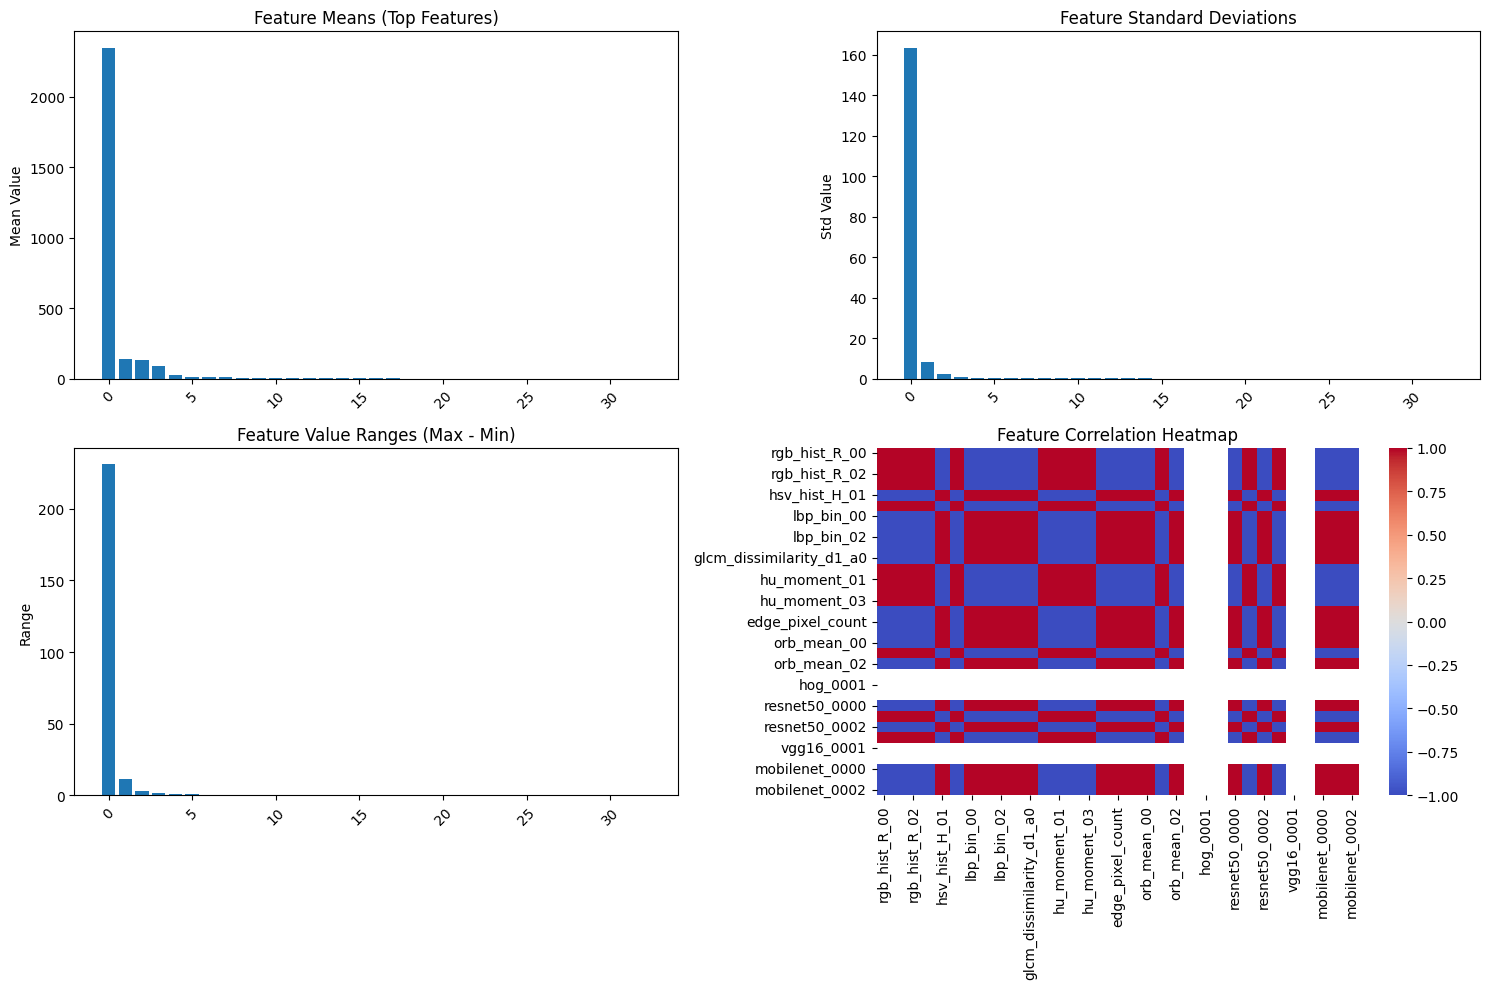

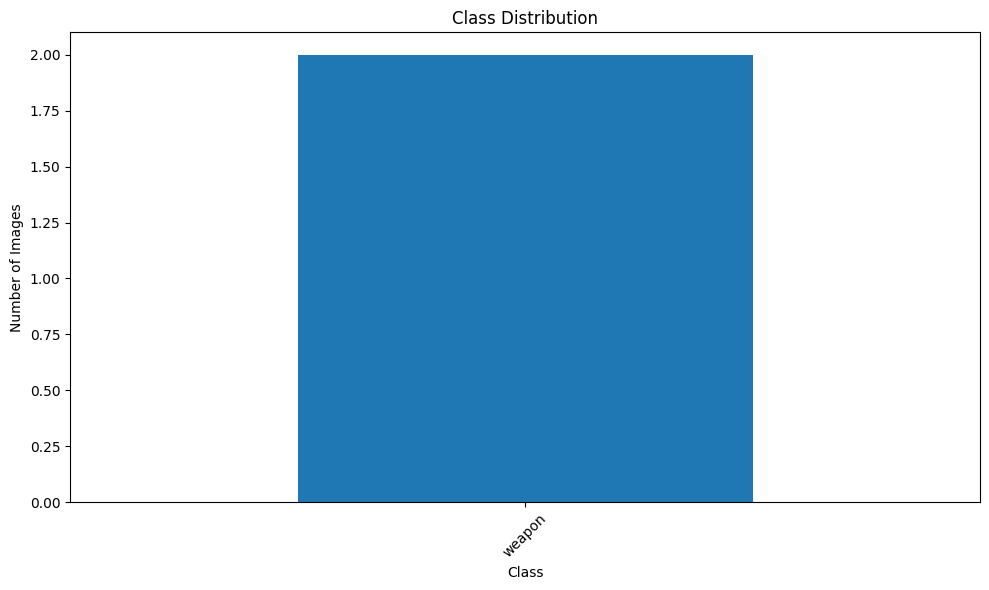

In [20]:
def visualize_feature_statistics(df, feature_names, max_features=50):
    """Visualisasi statistik fitur"""
    if len(df) == 0:
        print("❌ No data to visualize")
        return
    
    # Pilih subset fitur untuk visualisasi
    if len(feature_names) > max_features:
        # Pilih fitur dari setiap kategori
        selected_features = []
        categories = ['rgb_hist', 'hsv_hist', 'lbp', 'glcm', 'hu_moment', 'edge_', 'orb', 'hog', 'resnet', 'vgg', 'mobilenet']
        
        for category in categories:
            cat_features = [f for f in feature_names if category in f]
            if cat_features:
                selected_features.extend(cat_features[:3])  # Ambil 3 per kategori
        
        if len(selected_features) > max_features:
            selected_features = selected_features[:max_features]
    else:
        selected_features = feature_names
    
    print(f"📊 Visualizing {len(selected_features)} features...")
    
    # Feature statistics
    feature_data = df[selected_features]
    
    # Plot feature distributions
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Feature means
    feature_means = feature_data.mean().sort_values(ascending=False)
    axes[0, 0].bar(range(len(feature_means)), feature_means.values)
    axes[0, 0].set_title('Feature Means (Top Features)')
    axes[0, 0].set_ylabel('Mean Value')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. Feature standard deviations
    feature_stds = feature_data.std().sort_values(ascending=False)
    axes[0, 1].bar(range(len(feature_stds)), feature_stds.values)
    axes[0, 1].set_title('Feature Standard Deviations')
    axes[0, 1].set_ylabel('Std Value')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 3. Feature value ranges
    feature_ranges = (feature_data.max() - feature_data.min()).sort_values(ascending=False)
    axes[1, 0].bar(range(len(feature_ranges)), feature_ranges.values)
    axes[1, 0].set_title('Feature Value Ranges (Max - Min)')
    axes[1, 0].set_ylabel('Range')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # 4. Correlation heatmap (subset)
    if len(selected_features) > 1:
        correlation_matrix = feature_data.corr()
        sns.heatmap(correlation_matrix, ax=axes[1, 1], cmap='coolwarm', center=0)
        axes[1, 1].set_title('Feature Correlation Heatmap')
    
    plt.tight_layout()
    plt.show()
    
    # Class distribution
    plt.figure(figsize=(10, 6))
    df['label'].value_counts().plot(kind='bar')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Visualisasi untuk test data
if 'test_df' in locals() and 'test_names' in locals():
    print("📈 Generating visualizations...")
    visualize_feature_statistics(test_df, test_names)

## FINAL INSTRUCTIONS

In [23]:
final_df = main()

🎯 STARTING COMPLETE FEATURE EXTRACTION
📁 Found 893 images
📁 Dataset contains 893 images

⚠️  This will extract features from 893 images
   This may take a long time depending on your hardware.

🚀 Processing full dataset...
📁 Found 893 images
🚀 Initializing Complete Feature Extractor...
    🖥️ Using device: cpu
    📥 Loading ResNet50...
    📥 Loading VGG16...
    📥 Loading MobileNetV2...
    ✅ All CNN models loaded successfully!
✅ All feature extractors initialized!

🚀 Starting feature extraction for 893 images...


Extracting features:   0%|          | 0/893 [00:00<?, ?it/s]


📊 Image 1/893: weapon_ak47_sp_spray_jungle_light_large.af524ea61be29ab81dfb321277b98a211338de37.jpg
  📷 Processing: weapon_ak47_sp_spray_jungle_light_large.af524ea61be29ab81dfb321277b98a211338de37.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   0%|          | 1/893 [00:00<04:42,  3.16it/s]

    🧠 MobileNetV2 Features...
✅ First image processed: 15856 features

📊 Image 2/893: weapon_ak47_sp_zebracam_light_large.5f15c9e41b9ac135b87cdadb407c9872e31c1f29.jpg
  📷 Processing: weapon_ak47_sp_zebracam_light_large.5f15c9e41b9ac135b87cdadb407c9872e31c1f29.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   0%|          | 2/893 [00:00<05:10,  2.87it/s]

    🧠 MobileNetV2 Features...

📊 Image 3/893: weapon_aug_sp_mesh_safetyblack_light_large.41766cdb86c7b662a4c6316b2864751c54940faf.jpg
  📷 Processing: weapon_aug_sp_mesh_safetyblack_light_large.41766cdb86c7b662a4c6316b2864751c54940faf.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:   0%|          | 3/893 [00:01<05:27,  2.72it/s]


📊 Image 4/893: weapon_aug_sp_nukestripe_orange_aug_light_large.4309138bd5b9e518628d517a275747ec9c2207d3.jpg
  📷 Processing: weapon_aug_sp_nukestripe_orange_aug_light_large.4309138bd5b9e518628d517a275747ec9c2207d3.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:   0%|          | 4/893 [00:01<05:46,  2.57it/s]


📊 Image 5/893: weapon_awp_sp_mesh_tan_light_large.3608cbeb9bb163bfd2becb4ebcce2576b9ca78d9.jpg
  📷 Processing: weapon_awp_sp_mesh_tan_light_large.3608cbeb9bb163bfd2becb4ebcce2576b9ca78d9.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   1%|          | 5/893 [00:01<05:47,  2.55it/s]

    🧠 MobileNetV2 Features...

📊 Image 6/893: weapon_awp_sp_snake_light_large.c0b327d960af85c987bed944287935fb4b6a780a.jpg
  📷 Processing: weapon_awp_sp_snake_light_large.c0b327d960af85c987bed944287935fb4b6a780a.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:   1%|          | 6/893 [00:02<05:45,  2.56it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 7/893: weapon_cz75a_so_orange_accents2_light_large.844bd6d01ce7c69486327ceb44b65b8c7cc49f2d.jpg
  📷 Processing: weapon_cz75a_so_orange_accents2_light_large.844bd6d01ce7c69486327ceb44b65b8c7cc49f2d.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   1%|          | 7/893 [00:02<05:44,  2.57it/s]

    🧠 MobileNetV2 Features...

📊 Image 8/893: weapon_cz75a_so_orca_light_large.8490865eba36c09ccd75a9b1f93445ff2e9f2b8f.jpg
  📷 Processing: weapon_cz75a_so_orca_light_large.8490865eba36c09ccd75a9b1f93445ff2e9f2b8f.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   1%|          | 8/893 [00:03<06:16,  2.35it/s]

    🧠 MobileNetV2 Features...

📊 Image 9/893: weapon_elite_so_tangerine_light_large.3fd8ec1b63079a11e24d78228ad989b51a30b0ca.jpg
  📷 Processing: weapon_elite_so_tangerine_light_large.3fd8ec1b63079a11e24d78228ad989b51a30b0ca.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:   1%|          | 9/893 [00:03<06:01,  2.44it/s]


📊 Image 10/893: weapon_elite_sp_elites_winter_raider_light_large.eddc2e91d0081e57588b745589209094a6b3e9b6.jpg
  📷 Processing: weapon_elite_sp_elites_winter_raider_light_large.eddc2e91d0081e57588b745589209094a6b3e9b6.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   1%|          | 10/893 [00:04<06:42,  2.19it/s]

    🧠 MobileNetV2 Features...

📊 Image 11/893: weapon_famas_sp_spitfire_famas_bravo_light_large.ac455b0749733b0bdce019c0e0c74270d689eb95.jpg
  📷 Processing: weapon_famas_sp_spitfire_famas_bravo_light_large.ac455b0749733b0bdce019c0e0c74270d689eb95.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:   1%|          | 11/893 [00:04<06:32,  2.25it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 12/893: weapon_famas_sp_spray_light_large.fe886d820746c0f4333c0e0ea6d308473e241c4b.jpg
  📷 Processing: weapon_famas_sp_spray_light_large.fe886d820746c0f4333c0e0ea6d308473e241c4b.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   1%|▏         | 12/893 [00:04<06:02,  2.43it/s]

    🧠 MobileNetV2 Features...

📊 Image 13/893: weapon_fiveseven_so_red_light_large.29ae7b2264bd2a390ecf51a51293d2c2202fdea9.png
  📷 Processing: weapon_fiveseven_so_red_light_large.29ae7b2264bd2a390ecf51a51293d2c2202fdea9.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   1%|▏         | 13/893 [00:05<05:42,  2.57it/s]

    🧠 MobileNetV2 Features...

📊 Image 14/893: weapon_fiveseven_sp_tape_orange_light_large.d784ec0c92136e9f3f33ca09444ff4fe6a1f5300.png
  📷 Processing: weapon_fiveseven_sp_tape_orange_light_large.d784ec0c92136e9f3f33ca09444ff4fe6a1f5300.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   2%|▏         | 14/893 [00:05<05:35,  2.62it/s]

    🧠 MobileNetV2 Features...

📊 Image 15/893: weapon_g3sg1_sp_tape_short_jungle_light_large.02fd06db8f950789b6c4bff265df06439382c585.png
  📷 Processing: weapon_g3sg1_sp_tape_short_jungle_light_large.02fd06db8f950789b6c4bff265df06439382c585.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:   2%|▏         | 15/893 [00:05<05:32,  2.64it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 16/893: weapon_g3sg1_sp_zebracam_blue_light_large.42199f9c4c0bd1ff9f569d6e7348c5cedf4630f5.png
  📷 Processing: weapon_g3sg1_sp_zebracam_blue_light_large.42199f9c4c0bd1ff9f569d6e7348c5cedf4630f5.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   2%|▏         | 16/893 [00:06<05:24,  2.70it/s]

    🧠 MobileNetV2 Features...

📊 Image 17/893: weapon_galilar_sp_mesh_slashes_light_large.f3c1ef94e52aa6cfe3c3ba2890e0d5ac0764900a.png
  📷 Processing: weapon_galilar_sp_mesh_slashes_light_large.f3c1ef94e52aa6cfe3c3ba2890e0d5ac0764900a.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   2%|▏         | 17/893 [00:06<05:53,  2.48it/s]

    🧠 MobileNetV2 Features...

📊 Image 18/893: weapon_galilar_sp_spray_desert_sage_light_large.34f1268c2cf12e7794538b7140456d3716d81142.png
  📷 Processing: weapon_galilar_sp_spray_desert_sage_light_large.34f1268c2cf12e7794538b7140456d3716d81142.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   2%|▏         | 18/893 [00:07<05:37,  2.59it/s]

    🧠 MobileNetV2 Features...

📊 Image 19/893: weapon_glock_so_red_light_large.17b18a34a4d840905587e918a8500576e91b0cb9.png
  📷 Processing: weapon_glock_so_red_light_large.17b18a34a4d840905587e918a8500576e91b0cb9.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:   2%|▏         | 19/893 [00:07<05:42,  2.55it/s]


📊 Image 20/893: weapon_glock_so_sand_bravo_light_large.b505115b9e7a3e6480697f0262d76c9518c65e50.png
  📷 Processing: weapon_glock_so_sand_bravo_light_large.b505115b9e7a3e6480697f0262d76c9518c65e50.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   2%|▏         | 20/893 [00:08<06:23,  2.28it/s]

    🧠 MobileNetV2 Features...

📊 Image 21/893: weapon_m249_sp_mesh_python_light_large.39f20f5499a7d68e8b90a9e064c993e9a803d721.png
  📷 Processing: weapon_m249_sp_mesh_python_light_large.39f20f5499a7d68e8b90a9e064c993e9a803d721.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:   2%|▏         | 21/893 [00:08<06:16,  2.32it/s]


📊 Image 22/893: weapon_m249_sp_spray_light_large.1954bdc0dc1e10eebeece7f34e2b9f8e51596d55.png
  📷 Processing: weapon_m249_sp_spray_light_large.1954bdc0dc1e10eebeece7f34e2b9f8e51596d55.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   2%|▏         | 22/893 [00:08<06:07,  2.37it/s]

    🧠 MobileNetV2 Features...

📊 Image 23/893: weapon_m4a1_silencer_hy_varicamo_light_large.794803daec1d6d6cd2c47d8e8520d9f5f0b1fc1b.png
  📷 Processing: weapon_m4a1_silencer_hy_varicamo_light_large.794803daec1d6d6cd2c47d8e8520d9f5f0b1fc1b.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:   3%|▎         | 23/893 [00:09<06:25,  2.25it/s]


📊 Image 24/893: weapon_m4a1_silencer_so_orange_accents_light_large.625f58cdc5641f440ccf2fe866c3152b5803d1f2.png
  📷 Processing: weapon_m4a1_silencer_so_orange_accents_light_large.625f58cdc5641f440ccf2fe866c3152b5803d1f2.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   3%|▎         | 24/893 [00:09<05:59,  2.42it/s]

    🧠 MobileNetV2 Features...

📊 Image 25/893: weapon_m4a1_sp_star_bravo_light_large.d4a56abe885a1a03ea173a6aaeb4f10bcec6a0c2.png
  📷 Processing: weapon_m4a1_sp_star_bravo_light_large.d4a56abe885a1a03ea173a6aaeb4f10bcec6a0c2.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   3%|▎         | 25/893 [00:10<05:51,  2.47it/s]

    🧠 MobileNetV2 Features...

📊 Image 26/893: weapon_m4a1_sp_zebracam_bw_light_large.de08ef2a6d7524e682118cef5d12124c5156dfa8.png
  📷 Processing: weapon_m4a1_sp_zebracam_bw_light_large.de08ef2a6d7524e682118cef5d12124c5156dfa8.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:   3%|▎         | 26/893 [00:10<05:45,  2.51it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 27/893: weapon_mac10_sp_palm_light_large.22a3296d079e27cb7bb291e15eff10c29aa89b3e.png
  📷 Processing: weapon_mac10_sp_palm_light_large.22a3296d079e27cb7bb291e15eff10c29aa89b3e.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   3%|▎         | 27/893 [00:10<05:33,  2.60it/s]

    🧠 MobileNetV2 Features...

📊 Image 28/893: weapon_mac10_sp_twigs_beach_light_large.82c99f7aa915b87043e167b42e25a5fbe2e8c1e2.png
  📷 Processing: weapon_mac10_sp_twigs_beach_light_large.82c99f7aa915b87043e167b42e25a5fbe2e8c1e2.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:   3%|▎         | 28/893 [00:11<05:36,  2.57it/s]


📊 Image 29/893: weapon_mag7_sp_mag7_firebitten_light_large.640af2edb52a7f170620e175ddaa5f5cf763325b.png
  📷 Processing: weapon_mag7_sp_mag7_firebitten_light_large.640af2edb52a7f170620e175ddaa5f5cf763325b.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   3%|▎         | 29/893 [00:11<05:43,  2.52it/s]

    🧠 MobileNetV2 Features...

📊 Image 30/893: weapon_mag7_sp_nukestripe_brown_light_large.e1d7540ba5131a2e2cf36a8f7c6edc98d0cd431a.png
  📷 Processing: weapon_mag7_sp_nukestripe_brown_light_large.e1d7540ba5131a2e2cf36a8f7c6edc98d0cd431a.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   3%|▎         | 30/893 [00:12<05:37,  2.56it/s]

    🧠 MobileNetV2 Features...

📊 Image 31/893: weapon_mp5sd_hy_labrat_mp5_light_large.bbdd9b7e1445618106b9709261787f8d800f7391.png
  📷 Processing: weapon_mp5sd_hy_labrat_mp5_light_large.bbdd9b7e1445618106b9709261787f8d800f7391.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   3%|▎         | 31/893 [00:12<05:23,  2.66it/s]

    🧠 MobileNetV2 Features...

📊 Image 32/893: weapon_mp5sd_sp_tape_short_rally_light_large.2fdb10eba1dbf17030a2c0867fc385fe0449b974.png
  📷 Processing: weapon_mp5sd_sp_tape_short_rally_light_large.2fdb10eba1dbf17030a2c0867fc385fe0449b974.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   4%|▎         | 32/893 [00:12<05:20,  2.68it/s]

    🧠 MobileNetV2 Features...

📊 Image 33/893: weapon_mp7_sp_spray_army_light_large.e879b8808f8c967e4f08fde194d6d58f64dfdb2d.png
  📷 Processing: weapon_mp7_sp_spray_army_light_large.e879b8808f8c967e4f08fde194d6d58f64dfdb2d.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   4%|▎         | 33/893 [00:13<05:28,  2.62it/s]

    🧠 MobileNetV2 Features...

📊 Image 34/893: weapon_mp7_sp_tape_orange_light_large.5870d3d214c5b4cd923d68c4a016b72596808db1.png
  📷 Processing: weapon_mp7_sp_tape_orange_light_large.5870d3d214c5b4cd923d68c4a016b72596808db1.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:   4%|▍         | 34/893 [00:13<05:26,  2.63it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 35/893: weapon_mp9_sp_tape_orange_light_large.77854282ffc131b7bbe878c140b3c41bfb735242.png
  📷 Processing: weapon_mp9_sp_tape_orange_light_large.77854282ffc131b7bbe878c140b3c41bfb735242.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   4%|▍         | 35/893 [00:13<05:30,  2.60it/s]

    🧠 MobileNetV2 Features...

📊 Image 36/893: weapon_mp9_sp_tape_short_sand_light_large.893d0bacf03750448cef4be1f649591b9622907e.png
  📷 Processing: weapon_mp9_sp_tape_short_sand_light_large.893d0bacf03750448cef4be1f649591b9622907e.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:   4%|▍         | 36/893 [00:14<05:42,  2.50it/s]


📊 Image 37/893: weapon_negev_sp_nuclear_pattern3_negev_light_large.2d4cd96f9a94367d4c22991250eb9350437d8be6.png
  📷 Processing: weapon_negev_sp_nuclear_pattern3_negev_light_large.2d4cd96f9a94367d4c22991250eb9350437d8be6.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   4%|▍         | 37/893 [00:14<05:40,  2.51it/s]

    🧠 MobileNetV2 Features...

📊 Image 38/893: weapon_negev_sp_palm_bravo_light_large.3271a8edfb42d163f18a957bc162ddf01f29d30a.png
  📷 Processing: weapon_negev_sp_palm_bravo_light_large.3271a8edfb42d163f18a957bc162ddf01f29d30a.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:   4%|▍         | 38/893 [00:15<05:34,  2.56it/s]


📊 Image 39/893: weapon_nova_sp_mesh_arctic_contrast_light_large.b85fc46665b05c2a0eea955a7946e644a7618944.png
  📷 Processing: weapon_nova_sp_mesh_arctic_contrast_light_large.b85fc46665b05c2a0eea955a7946e644a7618944.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   4%|▍         | 39/893 [00:15<05:35,  2.55it/s]

    🧠 MobileNetV2 Features...

📊 Image 40/893: weapon_nova_sp_zebracam_light_large.4a13bdc4fa3b5cd7d89c8cc83700d3a13326a6c3.png
  📷 Processing: weapon_nova_sp_zebracam_light_large.4a13bdc4fa3b5cd7d89c8cc83700d3a13326a6c3.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   4%|▍         | 40/893 [00:15<05:37,  2.53it/s]

    🧠 MobileNetV2 Features...

📊 Image 41/893: weapon_hkp2000_sp_labyrinth2_light_large.240b91eab5dc2e0f6806dfbd2fc5d33bdebe53bb.png
  📷 Processing: weapon_hkp2000_sp_labyrinth2_light_large.240b91eab5dc2e0f6806dfbd2fc5d33bdebe53bb.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:   5%|▍         | 41/893 [00:16<05:59,  2.37it/s]


📊 Image 42/893: weapon_hkp2000_sp_leaves_grassland_light_large.a7885e449e09718b530a5f8e4b79a30931f104cb.png
  📷 Processing: weapon_hkp2000_sp_leaves_grassland_light_large.a7885e449e09718b530a5f8e4b79a30931f104cb.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   5%|▍         | 42/893 [00:16<05:43,  2.48it/s]

    🧠 MobileNetV2 Features...

📊 Image 43/893: weapon_p90_sp_spray_sand_light_large.18ac7e644639b8756fa3984055a493c5d7fc8249.png
  📷 Processing: weapon_p90_sp_spray_sand_light_large.18ac7e644639b8756fa3984055a493c5d7fc8249.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:   5%|▍         | 43/893 [00:17<05:44,  2.46it/s]


📊 Image 44/893: weapon_p90_sp_twigs_light_large.32f929b66cdf34997897a48260a53946e786a531.png
  📷 Processing: weapon_p90_sp_twigs_light_large.32f929b66cdf34997897a48260a53946e786a531.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   5%|▍         | 44/893 [00:17<05:35,  2.53it/s]

    🧠 MobileNetV2 Features...

📊 Image 45/893: weapon_p250_sp_splash_p250_light_large.9270d8d14c39aef83407ea50e51f0eb89c17263d.png
  📷 Processing: weapon_p250_sp_splash_p250_light_large.9270d8d14c39aef83407ea50e51f0eb89c17263d.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   5%|▌         | 45/893 [00:17<05:21,  2.64it/s]

    🧠 MobileNetV2 Features...

📊 Image 46/893: weapon_p250_sp_tape_light_large.8ece2047279c054325b0d2632559de145cef524a.png
  📷 Processing: weapon_p250_sp_tape_light_large.8ece2047279c054325b0d2632559de145cef524a.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   5%|▌         | 46/893 [00:18<05:22,  2.63it/s]

    🧠 MobileNetV2 Features...

📊 Image 47/893: weapon_bizon_sp_tape_short_sand_light_large.dcf913a3a4fcd421012482e8c1cb55d05d9828f9.png
  📷 Processing: weapon_bizon_sp_tape_short_sand_light_large.dcf913a3a4fcd421012482e8c1cb55d05d9828f9.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:   5%|▌         | 47/893 [00:18<05:24,  2.60it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 48/893: weapon_bizon_sp_tape_short_urban_light_large.141f3b1f24bc6c964a78ca58b38c01ad773fbc12.png
  📷 Processing: weapon_bizon_sp_tape_short_urban_light_large.141f3b1f24bc6c964a78ca58b38c01ad773fbc12.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   5%|▌         | 48/893 [00:19<05:16,  2.67it/s]

    🧠 MobileNetV2 Features...

📊 Image 49/893: weapon_revolver_sp_spray_water_light_large.0f7d074b7c53419d9475b0eb68e7215d7f9dcc66.png
  📷 Processing: weapon_revolver_sp_spray_water_light_large.0f7d074b7c53419d9475b0eb68e7215d7f9dcc66.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:   5%|▌         | 49/893 [00:19<05:22,  2.62it/s]


📊 Image 50/893: weapon_revolver_sp_tape_light_large.c8f9124ff70ca2a6e8867920cd39e4fb7308ac87.png
  📷 Processing: weapon_revolver_sp_tape_light_large.c8f9124ff70ca2a6e8867920cd39e4fb7308ac87.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   6%|▌         | 50/893 [00:19<05:22,  2.62it/s]

    🧠 MobileNetV2 Features...

📊 Image 51/893: weapon_sawedoff_sp_snake_light_large.5e65a350f30aa592de234f631d5d2cd98838fb4e.png
  📷 Processing: weapon_sawedoff_sp_snake_light_large.5e65a350f30aa592de234f631d5d2cd98838fb4e.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   6%|▌         | 51/893 [00:20<05:34,  2.52it/s]

    🧠 MobileNetV2 Features...

📊 Image 52/893: weapon_sawedoff_sp_spray_desert_sage_light_large.e944ddb90e97199d1f274c481462a3a660b9fc5a.png
  📷 Processing: weapon_sawedoff_sp_spray_desert_sage_light_large.e944ddb90e97199d1f274c481462a3a660b9fc5a.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:   6%|▌         | 52/893 [00:20<05:35,  2.51it/s]


📊 Image 53/893: weapon_scar20_sp_palm_light_large.ed935d932711961605c3b03b896560f4ebfe8861.png
  📷 Processing: weapon_scar20_sp_palm_light_large.ed935d932711961605c3b03b896560f4ebfe8861.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   6%|▌         | 53/893 [00:21<06:11,  2.26it/s]

    🧠 MobileNetV2 Features...

📊 Image 54/893: weapon_scar20_sp_scar20_striker_dust_light_large.0842dbdf0fe714c92f634b376e15c2f8c21b6d56.png
  📷 Processing: weapon_scar20_sp_scar20_striker_dust_light_large.0842dbdf0fe714c92f634b376e15c2f8c21b6d56.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   6%|▌         | 54/893 [00:21<05:34,  2.50it/s]

    🧠 MobileNetV2 Features...

📊 Image 55/893: weapon_ssg08_sp_palm_shadow_light_large.fb24b5ed2a03a35a12f5ee7166bc458ab4ae77e7.png
  📷 Processing: weapon_ssg08_sp_palm_shadow_light_large.fb24b5ed2a03a35a12f5ee7166bc458ab4ae77e7.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   6%|▌         | 55/893 [00:21<05:05,  2.74it/s]

    🧠 MobileNetV2 Features...

📊 Image 56/893: weapon_ssg08_sp_short_tape_light_large.f2f54766f72c881bc020b924be5ae026dcf065da.png
  📷 Processing: weapon_ssg08_sp_short_tape_light_large.f2f54766f72c881bc020b924be5ae026dcf065da.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   6%|▋         | 56/893 [00:22<04:45,  2.93it/s]

    🧠 MobileNetV2 Features...

📊 Image 57/893: weapon_sg556_sp_spray_waves_bravo_light_large.5d4e0e3977bf9f1fa8dd1576b5576b429546f98d.png
  📷 Processing: weapon_sg556_sp_spray_waves_bravo_light_large.5d4e0e3977bf9f1fa8dd1576b5576b429546f98d.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:   6%|▋         | 57/893 [00:22<04:46,  2.92it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 58/893: weapon_sg556_sp_tape_dots_waves_light_large.6225b7ae003cefaab7deca7ea517576991055bbd.png
  📷 Processing: weapon_sg556_sp_tape_dots_waves_light_large.6225b7ae003cefaab7deca7ea517576991055bbd.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:   6%|▋         | 58/893 [00:22<04:33,  3.05it/s]


📊 Image 59/893: weapon_tec9_sp_mesh_army_light_large.b2404b6aa0c7e1584fe2691cfeba70d823aff562.png
  📷 Processing: weapon_tec9_sp_mesh_army_light_large.b2404b6aa0c7e1584fe2691cfeba70d823aff562.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   7%|▋         | 59/893 [00:22<04:30,  3.08it/s]

    🧠 MobileNetV2 Features...

📊 Image 60/893: weapon_tec9_sp_nukestripe_green_tec9_light_large.0067333625bf11ffa93d705dde553b4b2bf6f82c.png
  📷 Processing: weapon_tec9_sp_nukestripe_green_tec9_light_large.0067333625bf11ffa93d705dde553b4b2bf6f82c.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:   7%|▋         | 60/893 [00:23<05:02,  2.75it/s]


📊 Image 61/893: weapon_ump45_sp_skull_diagram_bravo_light_large.f3bf563f6e0274f55377e4fe0422905586a3d19b.png
  📷 Processing: weapon_ump45_sp_skull_diagram_bravo_light_large.f3bf563f6e0274f55377e4fe0422905586a3d19b.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   7%|▋         | 61/893 [00:23<05:46,  2.40it/s]

    🧠 MobileNetV2 Features...

📊 Image 62/893: weapon_ump45_sp_ump45_d-visions_light_large.33ae7e9e8bf24ee97f4f3d3ee113e51782a756fa.png
  📷 Processing: weapon_ump45_sp_ump45_d-visions_light_large.33ae7e9e8bf24ee97f4f3d3ee113e51782a756fa.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:   7%|▋         | 62/893 [00:24<05:48,  2.39it/s]


📊 Image 63/893: weapon_usp_silencer_sp_leaves_light_large.a71c8dc482fea4aaa1c6b5c115e370a7e134ddfd.png
  📷 Processing: weapon_usp_silencer_sp_leaves_light_large.a71c8dc482fea4aaa1c6b5c115e370a7e134ddfd.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   7%|▋         | 63/893 [00:24<05:38,  2.45it/s]

    🧠 MobileNetV2 Features...

📊 Image 64/893: weapon_usp_silencer_sp_mesh_safetyred_light_large.2236c5b787e251c103ddf44209b4b7731b3d9a43.png
  📷 Processing: weapon_usp_silencer_sp_mesh_safetyred_light_large.2236c5b787e251c103ddf44209b4b7731b3d9a43.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:   7%|▋         | 64/893 [00:25<05:37,  2.45it/s]


📊 Image 65/893: weapon_xm1014_sp_nukestripe_maroon_light_large.8b6facf30ed6057509fcaf2c8a75a04c2629203a.png
  📷 Processing: weapon_xm1014_sp_nukestripe_maroon_light_large.8b6facf30ed6057509fcaf2c8a75a04c2629203a.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   7%|▋         | 65/893 [00:25<05:24,  2.55it/s]

    🧠 MobileNetV2 Features...

📊 Image 66/893: weapon_xm1014_sp_tape_dots_urban_light_large.751c1e2059e1b9b8ef64b4cd94b22e35cccd0477.png
  📷 Processing: weapon_xm1014_sp_tape_dots_urban_light_large.751c1e2059e1b9b8ef64b4cd94b22e35cccd0477.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:   7%|▋         | 66/893 [00:25<05:25,  2.54it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 67/893: weapon_ak47.a320f13fea4f21d1eb3b46678d6b12e97cbd1052.jpg
  📷 Processing: weapon_ak47.a320f13fea4f21d1eb3b46678d6b12e97cbd1052.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:   8%|▊         | 67/893 [00:26<05:38,  2.44it/s]


📊 Image 68/893: weapon_ak47_am_bamboo_jungle_light_large.98cd023e9d2207ad765b600b281352cbc5009051.jpg
  📷 Processing: weapon_ak47_am_bamboo_jungle_light_large.98cd023e9d2207ad765b600b281352cbc5009051.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   8%|▊         | 68/893 [00:26<05:25,  2.54it/s]

    🧠 MobileNetV2 Features...

📊 Image 69/893: weapon_ak47_aq_ak47_cartel_light_large.2e7be9f4c7bda304f2a7c374260d95affca93f0b.jpg
  📷 Processing: weapon_ak47_aq_ak47_cartel_light_large.2e7be9f4c7bda304f2a7c374260d95affca93f0b.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:   8%|▊         | 69/893 [00:27<05:29,  2.50it/s]


📊 Image 70/893: weapon_ak47_aq_oiled_light_large.92c8d125e4e54758d37e946496030e9a18833b58.jpg
  📷 Processing: weapon_ak47_aq_oiled_light_large.92c8d125e4e54758d37e946496030e9a18833b58.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   8%|▊         | 70/893 [00:27<05:18,  2.58it/s]

    🧠 MobileNetV2 Features...

📊 Image 71/893: weapon_ak47_cu_ak-47_phantom_disruptor_light_large.c14fcebe17a4c1a509edc597b33dcb9b5dcda32b.jpg
  📷 Processing: weapon_ak47_cu_ak-47_phantom_disruptor_light_large.c14fcebe17a4c1a509edc597b33dcb9b5dcda32b.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:   8%|▊         | 71/893 [00:27<05:11,  2.64it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 72/893: weapon_ak47_cu_ak47_anarchy_light_large.6e98f0c6fcb81aaeca03c56eed68962f50c9ef94.jpg
  📷 Processing: weapon_ak47_cu_ak47_anarchy_light_large.6e98f0c6fcb81aaeca03c56eed68962f50c9ef94.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:   8%|▊         | 72/893 [00:28<05:25,  2.52it/s]


📊 Image 73/893: weapon_ak47_cu_ak47_anubis_light_large.77994b9d6a2f3020c0c5aa8c9c7f70357d460bff.jpg
  📷 Processing: weapon_ak47_cu_ak47_anubis_light_large.77994b9d6a2f3020c0c5aa8c9c7f70357d460bff.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   8%|▊         | 73/893 [00:28<05:29,  2.49it/s]

    🧠 MobileNetV2 Features...

📊 Image 74/893: weapon_ak47_cu_ak47_asiimov_light_large.665fc3b83c8046398787a57d2ef7a9d938244820.jpg
  📷 Processing: weapon_ak47_cu_ak47_asiimov_light_large.665fc3b83c8046398787a57d2ef7a9d938244820.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:   8%|▊         | 74/893 [00:29<05:26,  2.51it/s]


📊 Image 75/893: weapon_ak47_cu_ak47_aztec_light_large.368d90ba7bc01aa56489792a8962df5343238c5c.jpg
  📷 Processing: weapon_ak47_cu_ak47_aztec_light_large.368d90ba7bc01aa56489792a8962df5343238c5c.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   8%|▊         | 75/893 [00:29<05:29,  2.48it/s]

    🧠 MobileNetV2 Features...

📊 Image 76/893: weapon_ak47_cu_ak47_cobra_light_large.7494bfdf4855fd4e6a2dbd983ed0a243c80ef830.jpg
  📷 Processing: weapon_ak47_cu_ak47_cobra_light_large.7494bfdf4855fd4e6a2dbd983ed0a243c80ef830.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:   9%|▊         | 76/893 [00:29<05:36,  2.43it/s]


📊 Image 77/893: weapon_ak47_cu_ak47_courage_alt_light_large.27e4e7d38dc2ce36ffe86bd6ec65d6f525751eaa.jpg
  📷 Processing: weapon_ak47_cu_ak47_courage_alt_light_large.27e4e7d38dc2ce36ffe86bd6ec65d6f525751eaa.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   9%|▊         | 77/893 [00:30<05:46,  2.35it/s]

    🧠 MobileNetV2 Features...

📊 Image 78/893: weapon_ak47_cu_ak47_mastery_light_large.4305c0ba4b02ce531fc08c275fa6a9d87da2cf7e.jpg
  📷 Processing: weapon_ak47_cu_ak47_mastery_light_large.4305c0ba4b02ce531fc08c275fa6a9d87da2cf7e.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:   9%|▊         | 78/893 [00:30<05:32,  2.45it/s]


📊 Image 79/893: weapon_ak47_cu_ak47_point_disarray_light_large.ba0f6ccdcb917aa2bde2ef0312c57d763a61d341.jpg
  📷 Processing: weapon_ak47_cu_ak47_point_disarray_light_large.ba0f6ccdcb917aa2bde2ef0312c57d763a61d341.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   9%|▉         | 79/893 [00:31<05:36,  2.42it/s]

    🧠 MobileNetV2 Features...

📊 Image 80/893: weapon_ak47_cu_ak47_rubber_light_large.5836c38d3037a5a1f90ffdc8c9d0b94367ca8efd.jpg
  📷 Processing: weapon_ak47_cu_ak47_rubber_light_large.5836c38d3037a5a1f90ffdc8c9d0b94367ca8efd.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   9%|▉         | 80/893 [00:31<05:43,  2.37it/s]

    🧠 MobileNetV2 Features...

📊 Image 81/893: weapon_ak47_cu_ak47_winter_sport_light_large.785a08aecd996dcffc6f38373fdc73697e601a6a.jpg
  📷 Processing: weapon_ak47_cu_ak47_winter_sport_light_large.785a08aecd996dcffc6f38373fdc73697e601a6a.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:   9%|▉         | 81/893 [00:32<05:34,  2.43it/s]


📊 Image 82/893: weapon_ak47_cu_ak_island_floral_light_large.1303e76d0a77ab164a46a7aba5ab1dcaf1acee6b.jpg
  📷 Processing: weapon_ak47_cu_ak_island_floral_light_large.1303e76d0a77ab164a46a7aba5ab1dcaf1acee6b.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   9%|▉         | 82/893 [00:32<05:39,  2.39it/s]

    🧠 MobileNetV2 Features...

📊 Image 83/893: weapon_ak47_cu_ak_neon_rider_light_large.9209192b514c4ec98146b4747dec8ce407a977c8.jpg
  📷 Processing: weapon_ak47_cu_ak_neon_rider_light_large.9209192b514c4ec98146b4747dec8ce407a977c8.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:   9%|▉         | 83/893 [00:32<05:24,  2.49it/s]

    🧠 MobileNetV2 Features...

📊 Image 84/893: weapon_ak47_cu_fireserpent_ak47_bravo_light_large.9390e7fd091ea8a0434fd2143e0acf0d5d1bbc97.jpg
  📷 Processing: weapon_ak47_cu_fireserpent_ak47_bravo_light_large.9390e7fd091ea8a0434fd2143e0acf0d5d1bbc97.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:   9%|▉         | 84/893 [00:33<05:22,  2.51it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 85/893: weapon_ak47_cu_green_leather_ak47_light_large.9622f0d289d98aa50238c0c956631b73bc3171ed.jpg
  📷 Processing: weapon_ak47_cu_green_leather_ak47_light_large.9622f0d289d98aa50238c0c956631b73bc3171ed.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  10%|▉         | 85/893 [00:33<05:30,  2.44it/s]

    🧠 MobileNetV2 Features...

📊 Image 86/893: weapon_ak47_cu_panther_ak47_light_large.6b7c82083b5fbb71631ad7961ac1543d1fc2a5cd.jpg
  📷 Processing: weapon_ak47_cu_panther_ak47_light_large.6b7c82083b5fbb71631ad7961ac1543d1fc2a5cd.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  10%|▉         | 86/893 [00:34<05:18,  2.54it/s]

    🧠 MobileNetV2 Features...

📊 Image 87/893: weapon_ak47_cu_pinstripe_ak47_light_large.2123421a26fbe673eea7c0238c7441a83b97aa17.jpg
  📷 Processing: weapon_ak47_cu_pinstripe_ak47_light_large.2123421a26fbe673eea7c0238c7441a83b97aa17.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  10%|▉         | 87/893 [00:34<05:23,  2.49it/s]


📊 Image 88/893: weapon_ak47_cu_tribute_ak47_light_large.f0ccfeea8a432a82cf4fb7f0411a724dbb43459a.jpg
  📷 Processing: weapon_ak47_cu_tribute_ak47_light_large.f0ccfeea8a432a82cf4fb7f0411a724dbb43459a.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  10%|▉         | 88/893 [00:34<05:21,  2.50it/s]

    🧠 MobileNetV2 Features...

📊 Image 89/893: weapon_ak47_cu_well_traveled_ak47_light_large.708a53ac473d7cd02037876a82b6b4c004bf9a31.jpg
  📷 Processing: weapon_ak47_cu_well_traveled_ak47_light_large.708a53ac473d7cd02037876a82b6b4c004bf9a31.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  10%|▉         | 89/893 [00:35<05:22,  2.50it/s]


📊 Image 90/893: weapon_ak47_gs_ak47_bloodsport_light_large.40f076f6b92e08acc37860923533aa9768795b2b.jpg
  📷 Processing: weapon_ak47_gs_ak47_bloodsport_light_large.40f076f6b92e08acc37860923533aa9768795b2b.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  10%|█         | 90/893 [00:35<05:10,  2.59it/s]

    🧠 MobileNetV2 Features...

📊 Image 91/893: weapon_ak47_gs_ak47_empress_light_large.f81d0b07dca381635c89f74bcdb6b64a6da6e81c.jpg
  📷 Processing: weapon_ak47_gs_ak47_empress_light_large.f81d0b07dca381635c89f74bcdb6b64a6da6e81c.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  10%|█         | 91/893 [00:36<05:23,  2.48it/s]


📊 Image 92/893: weapon_ak47_gs_ak47_nibbler_light_large.1c402d395b628aa5667239eec44640d7f603d754.jpg
  📷 Processing: weapon_ak47_gs_ak47_nibbler_light_large.1c402d395b628aa5667239eec44640d7f603d754.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  10%|█         | 92/893 [00:36<05:40,  2.35it/s]


📊 Image 93/893: weapon_ak47_gs_ak47_supercharged_light_large.8a0d53e84b7049366a3e3dbb25d29f473d76dceb.jpg
  📷 Processing: weapon_ak47_gs_ak47_supercharged_light_large.8a0d53e84b7049366a3e3dbb25d29f473d76dceb.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  10%|█         | 93/893 [00:37<06:02,  2.20it/s]

    🧠 MobileNetV2 Features...

📊 Image 94/893: weapon_ak47_gs_ak_colony01_red_light_large.b688da7615b6e76fa34f775e200914dc44d5336c.jpg
  📷 Processing: weapon_ak47_gs_ak_colony01_red_light_large.b688da7615b6e76fa34f775e200914dc44d5336c.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  11%|█         | 94/893 [00:37<06:08,  2.17it/s]


📊 Image 95/893: weapon_ak47_hy_ak47lam_blue_light_large.9f8ec5103efa5b7a0b3919a13b4de78e1bd612a0.jpg
  📷 Processing: weapon_ak47_hy_ak47lam_blue_light_large.9f8ec5103efa5b7a0b3919a13b4de78e1bd612a0.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  11%|█         | 95/893 [00:38<06:17,  2.11it/s]

    🧠 MobileNetV2 Features...

📊 Image 96/893: weapon_ak47_hy_ak47lam_bw_light_large.c504cab278a4955e92255ee2022340be2d0982a4.jpg
  📷 Processing: weapon_ak47_hy_ak47lam_bw_light_large.c504cab278a4955e92255ee2022340be2d0982a4.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  11%|█         | 96/893 [00:38<06:06,  2.17it/s]


📊 Image 97/893: weapon_ak47_hy_ak47lam_light_large.199620e808579639264cf753d0650721b4bc1f37.jpg
  📷 Processing: weapon_ak47_hy_ak47lam_light_large.199620e808579639264cf753d0650721b4bc1f37.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  11%|█         | 97/893 [00:38<05:47,  2.29it/s]

    🧠 MobileNetV2 Features...

📊 Image 98/893: weapon_ak47_hy_mesh_safetyorange_light_large.f4ee68bc3bbd972ded65ec36b66259199b7fafb7.jpg
  📷 Processing: weapon_ak47_hy_mesh_safetyorange_light_large.f4ee68bc3bbd972ded65ec36b66259199b7fafb7.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  11%|█         | 98/893 [00:39<06:16,  2.11it/s]

    🧠 MobileNetV2 Features...

📊 Image 99/893: weapon_ak47_hy_veneto_purple_light_large.4d9f7f4ed3034ce7d712c68640eb33f9f66f5daf.jpg
  📷 Processing: weapon_ak47_hy_veneto_purple_light_large.4d9f7f4ed3034ce7d712c68640eb33f9f66f5daf.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  11%|█         | 99/893 [00:39<06:21,  2.08it/s]

    🧠 MobileNetV2 Features...

📊 Image 100/893: weapon_ak47_sp_mesh_tan_light_large.0372a5d37f473b9cf5e2ee32d2f5d36247f24a3a.jpg
  📷 Processing: weapon_ak47_sp_mesh_tan_light_large.0372a5d37f473b9cf5e2ee32d2f5d36247f24a3a.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  11%|█         | 100/893 [00:40<06:02,  2.19it/s]


📊 Image 101/893: weapon_aug.6b97a75aa4c0dbb61d81efb6d5497b079b67d0da.jpg
  📷 Processing: weapon_aug.6b97a75aa4c0dbb61d81efb6d5497b079b67d0da.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  11%|█▏        | 101/893 [00:40<05:49,  2.27it/s]

    🧠 MobileNetV2 Features...

📊 Image 102/893: weapon_aug_am_aug_death_by_doggy_light_large.eb9b56273d30c50b93d2cb0a2e2843b525012878.jpg
  📷 Processing: weapon_aug_am_aug_death_by_doggy_light_large.eb9b56273d30c50b93d2cb0a2e2843b525012878.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  11%|█▏        | 102/893 [00:41<05:48,  2.27it/s]


📊 Image 103/893: weapon_aug_am_aug_jumble_light_large.d86901a42f239ddc39cd645d2a17281881fe37d5.jpg
  📷 Processing: weapon_aug_am_aug_jumble_light_large.d86901a42f239ddc39cd645d2a17281881fe37d5.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  12%|█▏        | 103/893 [00:41<05:32,  2.38it/s]

    🧠 MobileNetV2 Features...

📊 Image 104/893: weapon_aug_am_bloom_blue_light_large.02cb11a89ee5a7f3d39fbec15757eba34691e526.jpg
  📷 Processing: weapon_aug_am_bloom_blue_light_large.02cb11a89ee5a7f3d39fbec15757eba34691e526.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  12%|█▏        | 104/893 [00:41<05:24,  2.43it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 105/893: weapon_aug_am_circuitboard_orange_light_large.da9f7304f48f9f02cdc452bf7761452f8fec6bc2.jpg
  📷 Processing: weapon_aug_am_circuitboard_orange_light_large.da9f7304f48f9f02cdc452bf7761452f8fec6bc2.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  12%|█▏        | 105/893 [00:42<05:22,  2.44it/s]

    🧠 MobileNetV2 Features...

📊 Image 106/893: weapon_aug_am_jorm_orange_light_large.1df28085a1bc10ff726b8a54f5c94cca1880fd19.jpg
  📷 Processing: weapon_aug_am_jorm_orange_light_large.1df28085a1bc10ff726b8a54f5c94cca1880fd19.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  12%|█▏        | 106/893 [00:42<05:19,  2.46it/s]


📊 Image 107/893: weapon_aug_an_navy_bravo_light_large.8057388b1d777096c036f1b2d8ba9ce15103678d.jpg
  📷 Processing: weapon_aug_an_navy_bravo_light_large.8057388b1d777096c036f1b2d8ba9ce15103678d.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  12%|█▏        | 107/893 [00:43<05:21,  2.44it/s]

    🧠 MobileNetV2 Features...

📊 Image 108/893: weapon_aug_an_red_light_large.9adb894f02aff778fff9188a24eea1f0c8b66685.jpg
  📷 Processing: weapon_aug_an_red_light_large.9adb894f02aff778fff9188a24eea1f0c8b66685.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  12%|█▏        | 108/893 [00:43<05:26,  2.40it/s]


📊 Image 109/893: weapon_aug_cu_anime_aug_light_large.f049075c645871ee67b0b47253f59c26143efc49.jpg
  📷 Processing: weapon_aug_cu_anime_aug_light_large.f049075c645871ee67b0b47253f59c26143efc49.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  12%|█▏        | 109/893 [00:43<05:10,  2.53it/s]

    🧠 MobileNetV2 Features...

📊 Image 110/893: weapon_aug_cu_aug_chameleonaire_light_large.ad1d2f62d1481931d8e23e0ab0fbd4e7a61135f7.jpg
  📷 Processing: weapon_aug_cu_aug_chameleonaire_light_large.ad1d2f62d1481931d8e23e0ab0fbd4e7a61135f7.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  12%|█▏        | 110/893 [00:44<05:13,  2.50it/s]

    🧠 MobileNetV2 Features...

📊 Image 111/893: weapon_aug_cu_aug_momentum_light_large.1f36037cec707a957785625f04b3740bb5286d16.jpg
  📷 Processing: weapon_aug_cu_aug_momentum_light_large.1f36037cec707a957785625f04b3740bb5286d16.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  12%|█▏        | 111/893 [00:44<05:15,  2.48it/s]


📊 Image 112/893: weapon_aug_cu_aug_orange_triangle_light_large.793eb05ec841c2664b8482565e5d080c731d6ecd.jpg
  📷 Processing: weapon_aug_cu_aug_orange_triangle_light_large.793eb05ec841c2664b8482565e5d080c731d6ecd.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  13%|█▎        | 112/893 [00:45<05:08,  2.53it/s]

    🧠 MobileNetV2 Features...

📊 Image 113/893: weapon_aug_cu_aug_progressiv_light_large.f712baf9253bd357c71a1525dac51e30298c9535.jpg
  📷 Processing: weapon_aug_cu_aug_progressiv_light_large.f712baf9253bd357c71a1525dac51e30298c9535.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  13%|█▎        | 113/893 [00:45<05:13,  2.49it/s]


📊 Image 114/893: weapon_aug_cu_aug_swallows_light_large.29e48baa4086b20e4a5f714b5f8cc6350de7c758.jpg
  📷 Processing: weapon_aug_cu_aug_swallows_light_large.29e48baa4086b20e4a5f714b5f8cc6350de7c758.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  13%|█▎        | 114/893 [00:45<05:05,  2.55it/s]

    🧠 MobileNetV2 Features...

📊 Image 115/893: weapon_aug_cu_aug_whitefang_light_large.051b21da4e56c64ad78ee8a67a0e9e237a4e01b1.jpg
  📷 Processing: weapon_aug_cu_aug_whitefang_light_large.051b21da4e56c64ad78ee8a67a0e9e237a4e01b1.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  13%|█▎        | 115/893 [00:46<05:12,  2.49it/s]


📊 Image 116/893: weapon_aug_gs_aug_aristocrat_light_large.4004dbb20c03d1a210ff9a98968ddb251bdfddc6.jpg
  📷 Processing: weapon_aug_gs_aug_aristocrat_light_large.4004dbb20c03d1a210ff9a98968ddb251bdfddc6.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  13%|█▎        | 116/893 [00:46<05:20,  2.42it/s]

    🧠 MobileNetV2 Features...

📊 Image 117/893: weapon_aug_gs_aug_stymphalian_birds_light_large.0840c45db138a07275c2250a0881fe752f27c601.jpg
  📷 Processing: weapon_aug_gs_aug_stymphalian_birds_light_large.0840c45db138a07275c2250a0881fe752f27c601.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  13%|█▎        | 117/893 [00:47<05:43,  2.26it/s]


📊 Image 118/893: weapon_aug_gs_aug_syd_mead_light_large.333597e0555639f5d77541c363a9bb38d95055f3.jpg
  📷 Processing: weapon_aug_gs_aug_syd_mead_light_large.333597e0555639f5d77541c363a9bb38d95055f3.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  13%|█▎        | 118/893 [00:47<05:26,  2.37it/s]

    🧠 MobileNetV2 Features...

📊 Image 119/893: weapon_aug_gs_aug_thunderstorm_light_large.127ba1a9f7c7eef6b701bf01ad50b3b146f9b951.jpg
  📷 Processing: weapon_aug_gs_aug_thunderstorm_light_large.127ba1a9f7c7eef6b701bf01ad50b3b146f9b951.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  13%|█▎        | 119/893 [00:48<05:20,  2.41it/s]

    🧠 MobileNetV2 Features...

📊 Image 120/893: weapon_aug_hy_aug_torn_orange_light_large.53b51a022d38ea39eff5ffbed92551dc741e17c3.jpg
  📷 Processing: weapon_aug_hy_aug_torn_orange_light_large.53b51a022d38ea39eff5ffbed92551dc741e17c3.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  13%|█▎        | 120/893 [00:48<05:07,  2.52it/s]

    🧠 MobileNetV2 Features...

📊 Image 121/893: weapon_aug_hy_copperhead_light_large.166fd555b0075feb698783999d906c4529d2d631.jpg
  📷 Processing: weapon_aug_hy_copperhead_light_large.166fd555b0075feb698783999d906c4529d2d631.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  14%|█▎        | 121/893 [00:48<04:49,  2.67it/s]

    🧠 MobileNetV2 Features...

📊 Image 122/893: weapon_aug_hy_feathers_aug_light_large.e1419b52a3ddd4bed5328f438ea5dea07b0ba248.jpg
  📷 Processing: weapon_aug_hy_feathers_aug_light_large.e1419b52a3ddd4bed5328f438ea5dea07b0ba248.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  14%|█▎        | 122/893 [00:49<04:40,  2.75it/s]

    🧠 MobileNetV2 Features...

📊 Image 123/893: weapon_aug_hy_murano_blue_light_large.b294cab668b3229243676838e2542b893b5dcbfa.jpg
  📷 Processing: weapon_aug_hy_murano_blue_light_large.b294cab668b3229243676838e2542b893b5dcbfa.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  14%|█▍        | 123/893 [00:49<04:44,  2.71it/s]


📊 Image 124/893: weapon_aug_hy_tiger_light_large.d2fe957d3903dc5779403ed1c95947e18fa7e6fd.jpg
  📷 Processing: weapon_aug_hy_tiger_light_large.d2fe957d3903dc5779403ed1c95947e18fa7e6fd.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  14%|█▍        | 124/893 [00:49<04:37,  2.77it/s]

    🧠 MobileNetV2 Features...

📊 Image 125/893: weapon_aug_so_pmc_light_large.e2a06ba5d6c412408d2447e162572817ee052bd3.jpg
  📷 Processing: weapon_aug_so_pmc_light_large.e2a06ba5d6c412408d2447e162572817ee052bd3.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  14%|█▍        | 125/893 [00:50<04:49,  2.65it/s]


📊 Image 126/893: weapon_aug_so_space_marine_light_large.ee525f5aaf19c6d97af3b0378d3d3cac26476d80.jpg
  📷 Processing: weapon_aug_so_space_marine_light_large.ee525f5aaf19c6d97af3b0378d3d3cac26476d80.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  14%|█▍        | 126/893 [00:50<05:03,  2.52it/s]


📊 Image 127/893: weapon_aug_so_stormfront_light_large.84dee43e41ff0fe95173b635e369b486848fe92f.jpg
  📷 Processing: weapon_aug_so_stormfront_light_large.84dee43e41ff0fe95173b635e369b486848fe92f.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  14%|█▍        | 127/893 [00:50<04:50,  2.64it/s]

    🧠 MobileNetV2 Features...

📊 Image 128/893: weapon_aug_sp_labyrinth3_light_large.86c4c77bbc59793e1bf632e1ef49101829a14773.jpg
  📷 Processing: weapon_aug_sp_labyrinth3_light_large.86c4c77bbc59793e1bf632e1ef49101829a14773.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  14%|█▍        | 128/893 [00:51<05:01,  2.54it/s]


📊 Image 129/893: weapon_aug_sp_mesh_forest_fire_light_large.eabf7b69ca1447bee596cdbaf21b48cd7537dbce.jpg
  📷 Processing: weapon_aug_sp_mesh_forest_fire_light_large.eabf7b69ca1447bee596cdbaf21b48cd7537dbce.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  14%|█▍        | 129/893 [00:51<04:54,  2.60it/s]

    🧠 MobileNetV2 Features...

📊 Image 130/893: weapon_awp.2899e1c6345ed05d62bdbe112db1b117d022e477.jpg
  📷 Processing: weapon_awp.2899e1c6345ed05d62bdbe112db1b117d022e477.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  15%|█▍        | 130/893 [00:52<04:50,  2.63it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 131/893: weapon_awp_am_awp_glory_light_large.348eae0f5d4da8671886826648dd4197a9829090.jpg
  📷 Processing: weapon_awp_am_awp_glory_light_large.348eae0f5d4da8671886826648dd4197a9829090.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  15%|█▍        | 131/893 [00:52<04:55,  2.58it/s]

    🧠 MobileNetV2 Features...

📊 Image 132/893: weapon_awp_am_awp_pawpaw_light_large.0ff115c31307cc3122536c44a9aef7e64277dc19.jpg
  📷 Processing: weapon_awp_am_awp_pawpaw_light_large.0ff115c31307cc3122536c44a9aef7e64277dc19.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  15%|█▍        | 132/893 [00:52<04:52,  2.60it/s]

    🧠 MobileNetV2 Features...

📊 Image 133/893: weapon_awp_am_crumple_bravo_light_large.5f59de227d280f3c3b39fae7e49ac143338ca5b2.jpg
  📷 Processing: weapon_awp_am_crumple_bravo_light_large.5f59de227d280f3c3b39fae7e49ac143338ca5b2.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  15%|█▍        | 133/893 [00:53<05:26,  2.33it/s]

    🧠 MobileNetV2 Features...

📊 Image 134/893: weapon_awp_am_lightning_awp_light_large.3761894103ee0fec90af459928635933ba27e36d.jpg
  📷 Processing: weapon_awp_am_lightning_awp_light_large.3761894103ee0fec90af459928635933ba27e36d.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  15%|█▌        | 134/893 [00:53<05:23,  2.35it/s]


📊 Image 135/893: weapon_awp_aq_awp_twine_light_large.f976c41b8f978d2b8d13734f14f6586982d859f1.jpg
  📷 Processing: weapon_awp_aq_awp_twine_light_large.f976c41b8f978d2b8d13734f14f6586982d859f1.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  15%|█▌        | 135/893 [00:54<05:27,  2.32it/s]

    🧠 MobileNetV2 Features...

📊 Image 136/893: weapon_awp_cu_awp_asimov_light_large.32d9045f8a2bcd13ca18390cc9fd82026e7195ab.jpg
  📷 Processing: weapon_awp_cu_awp_asimov_light_large.32d9045f8a2bcd13ca18390cc9fd82026e7195ab.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  15%|█▌        | 136/893 [00:54<05:13,  2.41it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 137/893: weapon_awp_cu_awp_cobra_light_large.cf20ce6ac1151b4a30d8a84081ec4373cbfad4a4.jpg
  📷 Processing: weapon_awp_cu_awp_cobra_light_large.cf20ce6ac1151b4a30d8a84081ec4373cbfad4a4.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  15%|█▌        | 137/893 [00:55<05:03,  2.49it/s]

    🧠 MobileNetV2 Features...

📊 Image 138/893: weapon_awp_cu_awp_hannya_light_large.dc87e0f1aeeabe6c1c840f2a9e756ea261ef9d81.jpg
  📷 Processing: weapon_awp_cu_awp_hannya_light_large.dc87e0f1aeeabe6c1c840f2a9e756ea261ef9d81.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  15%|█▌        | 138/893 [00:55<05:13,  2.41it/s]


📊 Image 139/893: weapon_awp_cu_awp_hyper_beast_light_large.55efa5e3094af71ca6a56b6eac96cb022f7ecd8b.jpg
  📷 Processing: weapon_awp_cu_awp_hyper_beast_light_large.55efa5e3094af71ca6a56b6eac96cb022f7ecd8b.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  16%|█▌        | 139/893 [00:55<05:12,  2.42it/s]

    🧠 MobileNetV2 Features...

📊 Image 140/893: weapon_awp_cu_awp_mastery_light_large.617e335043f250cdb9d6a4c798e075be9560cdd4.jpg
  📷 Processing: weapon_awp_cu_awp_mastery_light_large.617e335043f250cdb9d6a4c798e075be9560cdd4.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  16%|█▌        | 140/893 [00:56<05:05,  2.46it/s]


📊 Image 141/893: weapon_awp_cu_awp_neonoir_light_large.c5dd57f8555d13c41f08024f27a9314074b698af.jpg
  📷 Processing: weapon_awp_cu_awp_neonoir_light_large.c5dd57f8555d13c41f08024f27a9314074b698af.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  16%|█▌        | 141/893 [00:56<04:53,  2.56it/s]

    🧠 MobileNetV2 Features...

📊 Image 142/893: weapon_awp_cu_awp_psychopath_light_large.11e54a670b779e1757cce18ea252d70eb35c6a75.jpg
  📷 Processing: weapon_awp_cu_awp_psychopath_light_large.11e54a670b779e1757cce18ea252d70eb35c6a75.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  16%|█▌        | 142/893 [00:57<04:41,  2.67it/s]

    🧠 MobileNetV2 Features...

📊 Image 143/893: weapon_awp_cu_awp_vein_light_large.8665dc4b4231298e9bbcab7aad3abbbf22e3edd8.jpg
  📷 Processing: weapon_awp_cu_awp_vein_light_large.8665dc4b4231298e9bbcab7aad3abbbf22e3edd8.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  16%|█▌        | 143/893 [00:57<04:38,  2.70it/s]

    🧠 MobileNetV2 Features...

📊 Image 144/893: weapon_awp_cu_awp_viper_light_large.2de75408a7c595312d58203f53c73a3a18faa4a3.jpg
  📷 Processing: weapon_awp_cu_awp_viper_light_large.2de75408a7c595312d58203f53c73a3a18faa4a3.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  16%|█▌        | 144/893 [00:57<04:56,  2.53it/s]


📊 Image 145/893: weapon_awp_cu_awp_virus_light_large.00307f818d425d94cb8e4eeda1e27699f713fb45.jpg
  📷 Processing: weapon_awp_cu_awp_virus_light_large.00307f818d425d94cb8e4eeda1e27699f713fb45.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  16%|█▌        | 145/893 [00:58<05:08,  2.43it/s]

    🧠 MobileNetV2 Features...

📊 Image 146/893: weapon_awp_cu_awp_wildfire_light_large.61e36b12eb45a39836cdb5badb5a536737684861.jpg
  📷 Processing: weapon_awp_cu_awp_wildfire_light_large.61e36b12eb45a39836cdb5badb5a536737684861.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  16%|█▋        | 146/893 [00:58<05:17,  2.35it/s]


📊 Image 147/893: weapon_awp_cu_favela_awp_light_large.4329c047ea1899f3846a1a81539ba2a27665a54e.jpg
  📷 Processing: weapon_awp_cu_favela_awp_light_large.4329c047ea1899f3846a1a81539ba2a27665a54e.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  16%|█▋        | 147/893 [00:59<05:09,  2.41it/s]

    🧠 MobileNetV2 Features...

📊 Image 148/893: weapon_awp_cu_medieval_dragon_awp_light_large.cb3b8168e59e96fd33efa9578206a2aaed036fc0.jpg
  📷 Processing: weapon_awp_cu_medieval_dragon_awp_light_large.cb3b8168e59e96fd33efa9578206a2aaed036fc0.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  17%|█▋        | 148/893 [00:59<05:08,  2.41it/s]


📊 Image 149/893: weapon_awp_cu_medusa_awp_light_large.05c6f5c67a2fbf7d042637568ba2ab25e44bb08c.jpg
  📷 Processing: weapon_awp_cu_medusa_awp_light_large.05c6f5c67a2fbf7d042637568ba2ab25e44bb08c.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  17%|█▋        | 149/893 [00:59<05:15,  2.35it/s]

    🧠 MobileNetV2 Features...

📊 Image 150/893: weapon_awp_gs_awp_death_light_large.19bdee04e6a0b4a3b8f832fd8ea18fea1e558f2e.jpg
  📷 Processing: weapon_awp_gs_awp_death_light_large.19bdee04e6a0b4a3b8f832fd8ea18fea1e558f2e.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  17%|█▋        | 150/893 [01:00<05:23,  2.30it/s]

    🧠 MobileNetV2 Features...

📊 Image 151/893: weapon_awp_gs_awp_enamel_light_large.00ae78bca507d3358c7b821dc666e21123162069.jpg
  📷 Processing: weapon_awp_gs_awp_enamel_light_large.00ae78bca507d3358c7b821dc666e21123162069.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  17%|█▋        | 151/893 [01:00<05:15,  2.35it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 152/893: weapon_awp_gs_awp_gungnir_light_large.f80c285940f75cca58731d8ead6bd8be1c18e38b.jpg
  📷 Processing: weapon_awp_gs_awp_gungnir_light_large.f80c285940f75cca58731d8ead6bd8be1c18e38b.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  17%|█▋        | 152/893 [01:01<04:59,  2.47it/s]

    🧠 MobileNetV2 Features...

📊 Image 153/893: weapon_awp_gs_awp_phobos_light_large.fca961cc99c704f09c44e6e82378434ef0e22087.jpg
  📷 Processing: weapon_awp_gs_awp_phobos_light_large.fca961cc99c704f09c44e6e82378434ef0e22087.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  17%|█▋        | 153/893 [01:01<04:57,  2.49it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 154/893: weapon_awp_hy_blam_simple_light_large.ed114947481e0366b2cde092a8ddac4d7250775b.jpg
  📷 Processing: weapon_awp_hy_blam_simple_light_large.ed114947481e0366b2cde092a8ddac4d7250775b.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  17%|█▋        | 154/893 [01:01<04:45,  2.59it/s]

    🧠 MobileNetV2 Features...

📊 Image 155/893: weapon_awp_hy_ddpat_pink_light_large.a00bebead467a7106062058982a1f8651cf663bc.jpg
  📷 Processing: weapon_awp_hy_ddpat_pink_light_large.a00bebead467a7106062058982a1f8651cf663bc.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  17%|█▋        | 155/893 [01:02<04:27,  2.76it/s]

    🧠 MobileNetV2 Features...

📊 Image 156/893: weapon_awp_hy_hive_light_large.2189958e2afa2c69cfcdd807124c279a0e645625.jpg
  📷 Processing: weapon_awp_hy_hive_light_large.2189958e2afa2c69cfcdd807124c279a0e645625.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  17%|█▋        | 156/893 [01:02<04:31,  2.72it/s]


📊 Image 157/893: weapon_awp_hy_nuclear_skulls_redblue_light_large.601aa23f996c480640f439e05f204c5bd7fafa49.jpg
  📷 Processing: weapon_awp_hy_nuclear_skulls_redblue_light_large.601aa23f996c480640f439e05f204c5bd7fafa49.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  18%|█▊        | 157/893 [01:03<04:56,  2.48it/s]

    🧠 MobileNetV2 Features...

📊 Image 158/893: weapon_awp_hy_snakeskin_light_large.e6addbb49a7024f800a35c9e081402a2c8631028.jpg
  📷 Processing: weapon_awp_hy_snakeskin_light_large.e6addbb49a7024f800a35c9e081402a2c8631028.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  18%|█▊        | 158/893 [01:03<05:09,  2.38it/s]

    🧠 MobileNetV2 Features...

📊 Image 159/893: weapon_awp_hy_zodiac2_light_large.67da534322361569bd9637688b704b57232529fa.jpg
  📷 Processing: weapon_awp_hy_zodiac2_light_large.67da534322361569bd9637688b704b57232529fa.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  18%|█▊        | 159/893 [01:04<05:15,  2.33it/s]


📊 Image 160/893: weapon_cz75a.057939990f5f295fc5eaf8f758cdef21a7cfeb8a.jpg
  📷 Processing: weapon_cz75a.057939990f5f295fc5eaf8f758cdef21a7cfeb8a.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  18%|█▊        | 160/893 [01:04<05:06,  2.39it/s]

    🧠 MobileNetV2 Features...

📊 Image 161/893: weapon_cz75a_am_army_shine_light_large.26736d48ea09a5284aeb1cf11292bc3e87a56251.jpg
  📷 Processing: weapon_cz75a_am_army_shine_light_large.26736d48ea09a5284aeb1cf11292bc3e87a56251.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  18%|█▊        | 161/893 [01:04<04:48,  2.53it/s]

    🧠 MobileNetV2 Features...

📊 Image 162/893: weapon_cz75a_am_crystallized_green_light_large.6ae192cbf47b2cb11ec47fcdcbad07a6a78fb3f7.jpg
  📷 Processing: weapon_cz75a_am_crystallized_green_light_large.6ae192cbf47b2cb11ec47fcdcbad07a6a78fb3f7.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  18%|█▊        | 162/893 [01:05<04:40,  2.60it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 163/893: weapon_cz75a_am_czv2_mf_light_large.e99dde293e56f61d77908b8326d2a89155389783.jpg
  📷 Processing: weapon_cz75a_am_czv2_mf_light_large.e99dde293e56f61d77908b8326d2a89155389783.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  18%|█▊        | 163/893 [01:05<04:32,  2.68it/s]

    🧠 MobileNetV2 Features...

📊 Image 164/893: weapon_cz75a_am_diamond_plate_light_large.ef425c82bae5d971bd5e1e9c54b9cd2f992e4e16.jpg
  📷 Processing: weapon_cz75a_am_diamond_plate_light_large.ef425c82bae5d971bd5e1e9c54b9cd2f992e4e16.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  18%|█▊        | 164/893 [01:05<04:41,  2.59it/s]


📊 Image 165/893: weapon_cz75a_am_fuschia_light_large.9ca4218835426c791482a3d7cc3b00d00c958d40.jpg
  📷 Processing: weapon_cz75a_am_fuschia_light_large.9ca4218835426c791482a3d7cc3b00d00c958d40.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  18%|█▊        | 165/893 [01:06<04:30,  2.69it/s]

    🧠 MobileNetV2 Features...

📊 Image 166/893: weapon_cz75a_am_gyrate_light_large.90f97369a79695a7fdcb633a9c9a9e56f29a05d5.jpg
  📷 Processing: weapon_cz75a_am_gyrate_light_large.90f97369a79695a7fdcb633a9c9a9e56f29a05d5.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  19%|█▊        | 166/893 [01:06<04:26,  2.73it/s]

    🧠 MobileNetV2 Features...

📊 Image 167/893: weapon_cz75a_am_nitrogen_light_large.ea1d17f7e0ba9fa71126a46b3ba99bf258dffe25.jpg
  📷 Processing: weapon_cz75a_am_nitrogen_light_large.ea1d17f7e0ba9fa71126a46b3ba99bf258dffe25.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  19%|█▊        | 167/893 [01:06<04:25,  2.74it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 168/893: weapon_cz75a_am_royal_light_large.f9f7bd8e5321fa0572adc2b77050608e5570cdaf.jpg
  📷 Processing: weapon_cz75a_am_royal_light_large.f9f7bd8e5321fa0572adc2b77050608e5570cdaf.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  19%|█▉        | 168/893 [01:07<04:21,  2.78it/s]

    🧠 MobileNetV2 Features...

📊 Image 169/893: weapon_cz75a_an_emerald_light_large.5c4734111477a884851cae6998871cbf7c870cc6.jpg
  📷 Processing: weapon_cz75a_an_emerald_light_large.5c4734111477a884851cae6998871cbf7c870cc6.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  19%|█▉        | 169/893 [01:07<04:27,  2.71it/s]


📊 Image 170/893: weapon_cz75a_aq_etched_cz75_light_large.5fa7e4f56600efeaceb99a948c6fa5dc3648a3b9.jpg
  📷 Processing: weapon_cz75a_aq_etched_cz75_light_large.5fa7e4f56600efeaceb99a948c6fa5dc3648a3b9.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  19%|█▉        | 170/893 [01:08<04:59,  2.42it/s]

    🧠 MobileNetV2 Features...

📊 Image 171/893: weapon_cz75a_cu_c75a-tiger_light_large.b754b5a73c8f2b207942eb046efdbd4cade04513.jpg
  📷 Processing: weapon_cz75a_cu_c75a-tiger_light_large.b754b5a73c8f2b207942eb046efdbd4cade04513.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  19%|█▉        | 171/893 [01:08<05:20,  2.25it/s]


📊 Image 172/893: weapon_cz75a_cu_cz75a_chastizer_light_large.d3234c712c3c068adbbfd5718c468c778f2351dd.jpg
  📷 Processing: weapon_cz75a_cu_cz75a_chastizer_light_large.d3234c712c3c068adbbfd5718c468c778f2351dd.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  19%|█▉        | 172/893 [01:09<05:15,  2.28it/s]

    🧠 MobileNetV2 Features...

📊 Image 173/893: weapon_cz75a_cu_cz75_cerakote_light_large.2f8286a9ca2313c23c6d9ad8d1c94650ef856c37.jpg
  📷 Processing: weapon_cz75a_cu_cz75_cerakote_light_large.2f8286a9ca2313c23c6d9ad8d1c94650ef856c37.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  19%|█▉        | 173/893 [01:09<05:00,  2.40it/s]

    🧠 MobileNetV2 Features...

📊 Image 174/893: weapon_cz75a_cu_cz75_eco_light_large.19aa7b914ac71968e73ac48b112b9f4c8116c767.jpg
  📷 Processing: weapon_cz75a_cu_cz75_eco_light_large.19aa7b914ac71968e73ac48b112b9f4c8116c767.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  19%|█▉        | 174/893 [01:09<05:01,  2.39it/s]


📊 Image 175/893: weapon_cz75a_cu_cz75_precision_light_large.a0d0ea9d92ff9c535cbdaa9c07a1a95a5181a82b.jpg
  📷 Processing: weapon_cz75a_cu_cz75_precision_light_large.a0d0ea9d92ff9c535cbdaa9c07a1a95a5181a82b.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  20%|█▉        | 175/893 [01:10<04:51,  2.47it/s]

    🧠 MobileNetV2 Features...

📊 Image 176/893: weapon_cz75a_gs_cz75a_redastor_light_large.e00e688986c50877a103fe66d70fdf1fc13bbe8b.jpg
  📷 Processing: weapon_cz75a_gs_cz75a_redastor_light_large.e00e688986c50877a103fe66d70fdf1fc13bbe8b.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  20%|█▉        | 176/893 [01:10<05:03,  2.36it/s]

    🧠 MobileNetV2 Features...

📊 Image 177/893: weapon_cz75a_gs_cz75_tacticat_light_large.ed9ba2f6cb8fd5e2a2b6cfb1b9a0ba4c87c93ec3.jpg
  📷 Processing: weapon_cz75a_gs_cz75_tacticat_light_large.ed9ba2f6cb8fd5e2a2b6cfb1b9a0ba4c87c93ec3.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  20%|█▉        | 177/893 [01:11<04:58,  2.40it/s]

    🧠 MobileNetV2 Features...

📊 Image 178/893: weapon_cz75a_gs_cz75_tread_light_large.8c276db730bb33477aaa52f7a23825f295e14364.jpg
  📷 Processing: weapon_cz75a_gs_cz75_tread_light_large.8c276db730bb33477aaa52f7a23825f295e14364.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  20%|█▉        | 178/893 [01:11<04:50,  2.46it/s]

    🧠 MobileNetV2 Features...

📊 Image 179/893: weapon_cz75a_gs_cz_snakes_purple_light_large.a06599fab1d73352fd970fc0356c215c50ca7e9a.jpg
  📷 Processing: weapon_cz75a_gs_cz_snakes_purple_light_large.a06599fab1d73352fd970fc0356c215c50ca7e9a.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  20%|██        | 179/893 [01:11<04:41,  2.53it/s]


📊 Image 180/893: weapon_cz75a_hy_bluehex_light_large.032e4b0999830a45d7439d07faef66b8299a105f.jpg
  📷 Processing: weapon_cz75a_hy_bluehex_light_large.032e4b0999830a45d7439d07faef66b8299a105f.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  20%|██        | 180/893 [01:12<04:38,  2.56it/s]

    🧠 MobileNetV2 Features...

📊 Image 181/893: weapon_cz75a_hy_plaid2_light_large.82e391ba61c092ece265e3bde16237ab5a510130.jpg
  📷 Processing: weapon_cz75a_hy_plaid2_light_large.82e391ba61c092ece265e3bde16237ab5a510130.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  20%|██        | 181/893 [01:12<04:38,  2.55it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 182/893: weapon_cz75a_hy_webs_light_large.2093b43aefa82ee6713c472384ea283fdd44f023.jpg
  📷 Processing: weapon_cz75a_hy_webs_light_large.2093b43aefa82ee6713c472384ea283fdd44f023.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  20%|██        | 182/893 [01:13<04:47,  2.47it/s]

    🧠 MobileNetV2 Features...

📊 Image 183/893: weapon_cz75a_so_indigo_and_grey_light_large.2d4d90e760b199522064e9635d1efdb11cdab34f.jpg
  📷 Processing: weapon_cz75a_so_indigo_and_grey_light_large.2d4d90e760b199522064e9635d1efdb11cdab34f.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  20%|██        | 183/893 [01:13<04:53,  2.42it/s]

    🧠 MobileNetV2 Features...

📊 Image 184/893: weapon_elite.6563e9d274c6e799d71a7809021624f213d5e080.jpg
  📷 Processing: weapon_elite.6563e9d274c6e799d71a7809021624f213d5e080.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  21%|██        | 184/893 [01:13<04:47,  2.47it/s]


📊 Image 185/893: weapon_elite_am_crystallized_blue_light_large.5756d02f9908e1c4d70e6f1d9dae53b3731fc0fd.jpg
  📷 Processing: weapon_elite_am_crystallized_blue_light_large.5756d02f9908e1c4d70e6f1d9dae53b3731fc0fd.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  21%|██        | 185/893 [01:14<04:37,  2.56it/s]

    🧠 MobileNetV2 Features...

📊 Image 186/893: weapon_elite_am_ossify_red_light_large.9da21d3dc7b64952d853818075f524a9e4c1dfd3.jpg
  📷 Processing: weapon_elite_am_ossify_red_light_large.9da21d3dc7b64952d853818075f524a9e4c1dfd3.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  21%|██        | 186/893 [01:14<04:43,  2.49it/s]


📊 Image 187/893: weapon_elite_an_emerald_light_large.242c719bcbe22fa3eb64b7ba15f48989cc9200d8.jpg
  📷 Processing: weapon_elite_an_emerald_light_large.242c719bcbe22fa3eb64b7ba15f48989cc9200d8.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  21%|██        | 187/893 [01:15<04:37,  2.54it/s]

    🧠 MobileNetV2 Features...

📊 Image 188/893: weapon_elite_an_navy_light_large.87999cce45a03f8e83c28db98874810a5c990c10.jpg
  📷 Processing: weapon_elite_an_navy_light_large.87999cce45a03f8e83c28db98874810a5c990c10.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  21%|██        | 188/893 [01:15<04:37,  2.54it/s]

    🧠 MobileNetV2 Features...

📊 Image 189/893: weapon_elite_aq_dualberettas_cartel_light_large.52ed24116db8a7254a366ea9f4f49b3ceff9eed3.jpg
  📷 Processing: weapon_elite_aq_dualberettas_cartel_light_large.52ed24116db8a7254a366ea9f4f49b3ceff9eed3.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  21%|██        | 189/893 [01:15<04:43,  2.48it/s]


📊 Image 190/893: weapon_elite_aq_forced_light_large.c654256613e0893b16be27a7621ec469a63a9955.jpg
  📷 Processing: weapon_elite_aq_forced_light_large.c654256613e0893b16be27a7621ec469a63a9955.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  21%|██▏       | 190/893 [01:16<04:34,  2.56it/s]

    🧠 MobileNetV2 Features...

📊 Image 191/893: weapon_elite_cu_dualberretta_dragons_light_large.2742674cbf237d1ba5fb6ed9f0d90e00a03570f9.jpg
  📷 Processing: weapon_elite_cu_dualberretta_dragons_light_large.2742674cbf237d1ba5fb6ed9f0d90e00a03570f9.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  21%|██▏       | 191/893 [01:16<04:34,  2.55it/s]

    🧠 MobileNetV2 Features...

📊 Image 192/893: weapon_elite_cu_dual_elites_rally_light_large.5b3cf9c54a4e7927724560a210955a77887ecb2e.jpg
  📷 Processing: weapon_elite_cu_dual_elites_rally_light_large.5b3cf9c54a4e7927724560a210955a77887ecb2e.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  22%|██▏       | 192/893 [01:17<04:28,  2.61it/s]


📊 Image 193/893: weapon_elite_cu_elites_urbanstorm_light_large.d33c9dd65434d8b9f4e7b5092fcc2e07a874e625.jpg
  📷 Processing: weapon_elite_cu_elites_urbanstorm_light_large.d33c9dd65434d8b9f4e7b5092fcc2e07a874e625.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  22%|██▏       | 193/893 [01:17<04:34,  2.55it/s]

    🧠 MobileNetV2 Features...

📊 Image 194/893: weapon_elite_cu_retribution_light_large.8527b45e34039b45dea9d304bb5892a1d0de5268.jpg
  📷 Processing: weapon_elite_cu_retribution_light_large.8527b45e34039b45dea9d304bb5892a1d0de5268.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  22%|██▏       | 194/893 [01:17<04:39,  2.50it/s]


📊 Image 195/893: weapon_elite_cu_season_elites_bravo_light_large.03b5f4afcbffb80f73ce009da240f4aa1455c15f.jpg
  📷 Processing: weapon_elite_cu_season_elites_bravo_light_large.03b5f4afcbffb80f73ce009da240f4aa1455c15f.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  22%|██▏       | 195/893 [01:18<04:59,  2.33it/s]


📊 Image 196/893: weapon_elite_gs_dualberettas_cobra_light_large.0c2576234d95cb12089d9fdad47d1f7eed7f56c8.jpg
  📷 Processing: weapon_elite_gs_dualberettas_cobra_light_large.0c2576234d95cb12089d9fdad47d1f7eed7f56c8.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  22%|██▏       | 196/893 [01:18<04:52,  2.38it/s]

    🧠 MobileNetV2 Features...

📊 Image 197/893: weapon_elite_gs_dualberettas_ventilators_light_large.45cb1ffd25de1ed5b90ba104b1f8e0a8eb2eb255.jpg
  📷 Processing: weapon_elite_gs_dualberettas_ventilators_light_large.45cb1ffd25de1ed5b90ba104b1f8e0a8eb2eb255.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  22%|██▏       | 197/893 [01:19<04:50,  2.40it/s]


📊 Image 198/893: weapon_elite_gs_dual_berettas_golden_venice_light_large.23d73db6cf2b2a7af26414d26373171dd3be06b1.jpg
  📷 Processing: weapon_elite_gs_dual_berettas_golden_venice_light_large.23d73db6cf2b2a7af26414d26373171dd3be06b1.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  22%|██▏       | 198/893 [01:19<04:50,  2.39it/s]

    🧠 MobileNetV2 Features...

📊 Image 199/893: weapon_elite_gs_dual_elites_classic_light_large.a899ad9f2e1bb8522fdeb022c99c64c2456826d1.jpg
  📷 Processing: weapon_elite_gs_dual_elites_classic_light_large.a899ad9f2e1bb8522fdeb022c99c64c2456826d1.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  22%|██▏       | 199/893 [01:19<04:41,  2.47it/s]

    🧠 MobileNetV2 Features...

📊 Image 200/893: weapon_elite_gs_dual_elites_rose_light_large.8df8980203b198879875be44656361ccbb41791e.jpg
  📷 Processing: weapon_elite_gs_dual_elites_rose_light_large.8df8980203b198879875be44656361ccbb41791e.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  22%|██▏       | 200/893 [01:20<04:45,  2.43it/s]

    🧠 MobileNetV2 Features...

📊 Image 201/893: weapon_elite_gs_mother_of_pearl_elite_light_large.2023e44b16f064c32962b691bcdb5d45051744bc.jpg
  📷 Processing: weapon_elite_gs_mother_of_pearl_elite_light_large.2023e44b16f064c32962b691bcdb5d45051744bc.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  23%|██▎       | 201/893 [01:20<04:38,  2.49it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 202/893: weapon_elite_hy_gelpen_dark_light_large.064bcecab3cc87140e4a6e6f0f34cc3e00675d77.jpg
  📷 Processing: weapon_elite_hy_gelpen_dark_light_large.064bcecab3cc87140e4a6e6f0f34cc3e00675d77.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  23%|██▎       | 202/893 [01:21<04:43,  2.43it/s]

    🧠 MobileNetV2 Features...

📊 Image 203/893: weapon_elite_hy_marina_sunrise_light_large.bcdf31f5af4a5b9bef2bb0d5336715a3a0407b92.jpg
  📷 Processing: weapon_elite_hy_marina_sunrise_light_large.bcdf31f5af4a5b9bef2bb0d5336715a3a0407b92.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  23%|██▎       | 203/893 [01:21<04:45,  2.42it/s]


📊 Image 204/893: weapon_elite_hy_vines_light_large.bb506f02418403c8a48f7829bdc065a71c3a77d0.jpg
  📷 Processing: weapon_elite_hy_vines_light_large.bb506f02418403c8a48f7829bdc065a71c3a77d0.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  23%|██▎       | 204/893 [01:22<04:41,  2.45it/s]

    🧠 MobileNetV2 Features...

📊 Image 205/893: weapon_elite_hy_zodiac1_light_large.cedfe5166a361ccc3c32a28847addcdc66ad25d7.jpg
  📷 Processing: weapon_elite_hy_zodiac1_light_large.cedfe5166a361ccc3c32a28847addcdc66ad25d7.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  23%|██▎       | 205/893 [01:22<04:35,  2.50it/s]

    🧠 MobileNetV2 Features...

📊 Image 206/893: weapon_elite_so_panther_light_large.019431b3fca18b027d07fe29d0ee7bf88df75576.jpg
  📷 Processing: weapon_elite_so_panther_light_large.019431b3fca18b027d07fe29d0ee7bf88df75576.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  23%|██▎       | 206/893 [01:22<04:52,  2.35it/s]


📊 Image 207/893: weapon_elite_so_pmc_light_large.eb0b65f961c27f233d8846c80301666925712e93.jpg
  📷 Processing: weapon_elite_so_pmc_light_large.eb0b65f961c27f233d8846c80301666925712e93.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  23%|██▎       | 207/893 [01:23<05:16,  2.16it/s]

    🧠 MobileNetV2 Features...

📊 Image 208/893: weapon_elite_so_space_marine_light_large.101c6b29315d37db050a4c7817a4c11517baa167.jpg
  📷 Processing: weapon_elite_so_space_marine_light_large.101c6b29315d37db050a4c7817a4c11517baa167.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  23%|██▎       | 208/893 [01:23<05:20,  2.14it/s]

    🧠 MobileNetV2 Features...

📊 Image 209/893: weapon_famas.c897878873beb9e9ca4c68ef3a666869c6e78031.jpg
  📷 Processing: weapon_famas.c897878873beb9e9ca4c68ef3a666869c6e78031.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  23%|██▎       | 209/893 [01:24<05:11,  2.19it/s]


📊 Image 210/893: weapon_famas_am_famas_dots_light_large.dc6f19278bac52ea06b8e3576fa324624f2f82b4.jpg
  📷 Processing: weapon_famas_am_famas_dots_light_large.dc6f19278bac52ea06b8e3576fa324624f2f82b4.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  24%|██▎       | 210/893 [01:24<05:00,  2.27it/s]

    🧠 MobileNetV2 Features...

📊 Image 211/893: weapon_famas_am_nuclear_skulls2_famas_light_large.ec9774f3b2a03f5411321dba792b05f19096547c.jpg
  📷 Processing: weapon_famas_am_nuclear_skulls2_famas_light_large.ec9774f3b2a03f5411321dba792b05f19096547c.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  24%|██▎       | 211/893 [01:25<04:53,  2.32it/s]


📊 Image 212/893: weapon_famas_an_famas_sgt_light_large.5a9241d41a3c35a3fbb20aebcd22253a6a85f72f.jpg
  📷 Processing: weapon_famas_an_famas_sgt_light_large.5a9241d41a3c35a3fbb20aebcd22253a6a85f72f.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  24%|██▎       | 212/893 [01:25<04:52,  2.33it/s]

    🧠 MobileNetV2 Features...

📊 Image 213/893: weapon_famas_aq_famas_contour_light_large.65d515ab34a6f50c8a5296b562a81da42663b819.jpg
  📷 Processing: weapon_famas_aq_famas_contour_light_large.65d515ab34a6f50c8a5296b562a81da42663b819.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  24%|██▍       | 213/893 [01:25<04:37,  2.45it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 214/893: weapon_famas_aq_famas_jinn_light_large.a0e1b8e2a572c5e3d6472181d4a0d6ce7f51139f.jpg
  📷 Processing: weapon_famas_aq_famas_jinn_light_large.a0e1b8e2a572c5e3d6472181d4a0d6ce7f51139f.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  24%|██▍       | 214/893 [01:26<04:42,  2.40it/s]

    🧠 MobileNetV2 Features...

📊 Image 215/893: weapon_famas_cu_broken_path_famas_light_large.5d45539735d838ffefd26467a8c767b71807c785.jpg
  📷 Processing: weapon_famas_cu_broken_path_famas_light_large.5d45539735d838ffefd26467a8c767b71807c785.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  24%|██▍       | 215/893 [01:26<04:38,  2.44it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 216/893: weapon_famas_cu_famas_lenta_light_large.7ab508a407e56ab541dae127ef5fc64f09f6ae08.jpg
  📷 Processing: weapon_famas_cu_famas_lenta_light_large.7ab508a407e56ab541dae127ef5fc64f09f6ae08.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  24%|██▍       | 216/893 [01:27<04:35,  2.45it/s]

    🧠 MobileNetV2 Features...

📊 Image 217/893: weapon_famas_cu_famas_nuke_tension_light_large.0cf9412e22f626e675b76506cf2f240a64a05b22.jpg
  📷 Processing: weapon_famas_cu_famas_nuke_tension_light_large.0cf9412e22f626e675b76506cf2f240a64a05b22.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  24%|██▍       | 217/893 [01:27<04:29,  2.51it/s]

    🧠 MobileNetV2 Features...

📊 Image 218/893: weapon_famas_cu_famas_owl_orange_light_large.7cb3a86d36317530964f40d66b755789de7ca88a.jpg
  📷 Processing: weapon_famas_cu_famas_owl_orange_light_large.7cb3a86d36317530964f40d66b755789de7ca88a.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  24%|██▍       | 218/893 [01:27<04:28,  2.52it/s]


📊 Image 219/893: weapon_famas_cu_famas_pulse_light_large.fad5dfcd7b0ccfe655c7c3903d091140904959ec.jpg
  📷 Processing: weapon_famas_cu_famas_pulse_light_large.fad5dfcd7b0ccfe655c7c3903d091140904959ec.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  25%|██▍       | 219/893 [01:28<04:22,  2.56it/s]

    🧠 MobileNetV2 Features...

📊 Image 220/893: weapon_famas_gs_famas_legacy_gold_light_large.34013884c12276d1c83ceb4ea9fb83428df02920.jpg
  📷 Processing: weapon_famas_gs_famas_legacy_gold_light_large.34013884c12276d1c83ceb4ea9fb83428df02920.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  25%|██▍       | 220/893 [01:28<04:24,  2.55it/s]

    🧠 MobileNetV2 Features...

📊 Image 221/893: weapon_famas_gs_famas_mecha_light_large.c26d3fccc156fe26ba3325ed73b29092b3e18093.jpg
  📷 Processing: weapon_famas_gs_famas_mecha_light_large.c26d3fccc156fe26ba3325ed73b29092b3e18093.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  25%|██▍       | 221/893 [01:29<04:23,  2.55it/s]


📊 Image 222/893: weapon_famas_gs_famas_rally_light_large.538baee44eb772de95029e4267ea9c41101bbc94.jpg
  📷 Processing: weapon_famas_gs_famas_rally_light_large.538baee44eb772de95029e4267ea9c41101bbc94.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  25%|██▍       | 222/893 [01:29<04:19,  2.59it/s]

    🧠 MobileNetV2 Features...

📊 Image 223/893: weapon_famas_hy_bluehex_light_large.fe87763b33ea8963cf87e9b8fd7b9bfc9014d747.jpg
  📷 Processing: weapon_famas_hy_bluehex_light_large.fe87763b33ea8963cf87e9b8fd7b9bfc9014d747.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  25%|██▍       | 223/893 [01:29<04:16,  2.62it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 224/893: weapon_famas_hy_doomkitty_light_large.c9dd7b8fb1a44d5691684aae406d360433550468.jpg
  📷 Processing: weapon_famas_hy_doomkitty_light_large.c9dd7b8fb1a44d5691684aae406d360433550468.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  25%|██▌       | 224/893 [01:30<04:19,  2.57it/s]

    🧠 MobileNetV2 Features...

📊 Image 225/893: weapon_famas_hy_reef_light_large.d3138f4491b5413241bf64a82e0545ddc4c9e80d.jpg
  📷 Processing: weapon_famas_hy_reef_light_large.d3138f4491b5413241bf64a82e0545ddc4c9e80d.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  25%|██▌       | 225/893 [01:30<04:23,  2.54it/s]

    🧠 MobileNetV2 Features...

📊 Image 226/893: weapon_famas_so_space_marine_light_large.bc0a11080c9b3b50c13ddbe4afa3f6f96311fec4.jpg
  📷 Processing: weapon_famas_so_space_marine_light_large.bc0a11080c9b3b50c13ddbe4afa3f6f96311fec4.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  25%|██▌       | 226/893 [01:31<04:38,  2.40it/s]

    🧠 MobileNetV2 Features...

📊 Image 227/893: weapon_famas_sp_famas_ghost_insects_light_large.727c7db3f6df4aae8b692f6966dba460acafb07f.jpg
  📷 Processing: weapon_famas_sp_famas_ghost_insects_light_large.727c7db3f6df4aae8b692f6966dba460acafb07f.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  25%|██▌       | 227/893 [01:31<04:30,  2.46it/s]


📊 Image 228/893: weapon_famas_sp_famas_macabre_light_large.7582150e24a69922b814d6b56004327e2219890d.jpg
  📷 Processing: weapon_famas_sp_famas_macabre_light_large.7582150e24a69922b814d6b56004327e2219890d.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  26%|██▌       | 228/893 [01:31<04:29,  2.46it/s]

    🧠 MobileNetV2 Features...

📊 Image 229/893: weapon_famas_sp_knots_blue_light_large.1a6a2c6fe90198a053410d364dd48441b51fb1a7.jpg
  📷 Processing: weapon_famas_sp_knots_blue_light_large.1a6a2c6fe90198a053410d364dd48441b51fb1a7.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  26%|██▌       | 229/893 [01:32<04:19,  2.56it/s]

    🧠 MobileNetV2 Features...

📊 Image 230/893: weapon_famas_sp_mesh_hot_and_cold_light_large.c93a700bb3cf4d14241d3c837569b571685b0b29.jpg
  📷 Processing: weapon_famas_sp_mesh_hot_and_cold_light_large.c93a700bb3cf4d14241d3c837569b571685b0b29.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  26%|██▌       | 230/893 [01:32<04:20,  2.55it/s]


📊 Image 231/893: weapon_famas_sp_palm_sunset_light_large.924bca1ce6c9034d6963c81c59fa72a2a4b45a07.jpg
  📷 Processing: weapon_famas_sp_palm_sunset_light_large.924bca1ce6c9034d6963c81c59fa72a2a4b45a07.jpg
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  26%|██▌       | 231/893 [01:33<04:11,  2.63it/s]

    🧠 MobileNetV2 Features...

📊 Image 232/893: weapon_fiveseven.7c33b4a78ae94a3d14e7cd0f71b295cf61717d75.png
  📷 Processing: weapon_fiveseven.7c33b4a78ae94a3d14e7cd0f71b295cf61717d75.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  26%|██▌       | 232/893 [01:33<04:12,  2.62it/s]

    🧠 MobileNetV2 Features...

📊 Image 233/893: weapon_fiveseven_am_copper_flecks_light_large.d2af814b76763880470bc7039d5569eb74b26978.png
  📷 Processing: weapon_fiveseven_am_copper_flecks_light_large.d2af814b76763880470bc7039d5569eb74b26978.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  26%|██▌       | 233/893 [01:33<04:10,  2.64it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 234/893: weapon_fiveseven_am_crystallized_silver_light_large.1c5e2fb5a3541523f1ff3a28f4138d83eed3a67f.png
  📷 Processing: weapon_fiveseven_am_crystallized_silver_light_large.1c5e2fb5a3541523f1ff3a28f4138d83eed3a67f.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  26%|██▌       | 234/893 [01:34<04:07,  2.67it/s]

    🧠 MobileNetV2 Features...

📊 Image 235/893: weapon_fiveseven_an_gunmetal_bravo_light_large.6aaf03603a7ef748f5395af2a738f899f423522b.png
  📷 Processing: weapon_fiveseven_an_gunmetal_bravo_light_large.6aaf03603a7ef748f5395af2a738f899f423522b.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  26%|██▋       | 235/893 [01:34<04:09,  2.64it/s]


📊 Image 236/893: weapon_fiveseven_aq_57_feathers_light_large.aa942f28d5fd868643b54ba0c317703d8b615754.png
  📷 Processing: weapon_fiveseven_aq_57_feathers_light_large.aa942f28d5fd868643b54ba0c317703d8b615754.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  26%|██▋       | 236/893 [01:34<04:20,  2.52it/s]


📊 Image 237/893: weapon_fiveseven_aq_five_seven_scumbria_light_large.bc05fc6435b84525a0ab140bc72e032a98dab710.png
  📷 Processing: weapon_fiveseven_aq_five_seven_scumbria_light_large.bc05fc6435b84525a0ab140bc72e032a98dab710.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  27%|██▋       | 237/893 [01:35<04:17,  2.55it/s]

    🧠 MobileNetV2 Features...

📊 Image 238/893: weapon_fiveseven_aq_oiled_light_large.fdaa095453965b2be93f8aa90ae469d926fac4e7.png
  📷 Processing: weapon_fiveseven_aq_oiled_light_large.fdaa095453965b2be93f8aa90ae469d926fac4e7.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  27%|██▋       | 238/893 [01:35<04:24,  2.48it/s]


📊 Image 239/893: weapon_fiveseven_cu_fiveseven_augmented_light_large.eb79857bc2e4b80f4edf61a0c5a72fbae80f3a20.png
  📷 Processing: weapon_fiveseven_cu_fiveseven_augmented_light_large.eb79857bc2e4b80f4edf61a0c5a72fbae80f3a20.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  27%|██▋       | 239/893 [01:36<04:28,  2.44it/s]

    🧠 MobileNetV2 Features...

📊 Image 240/893: weapon_fiveseven_cu_fiveseven_banana_light_large.2d78a6614cb329ada893c8d028eb5c2b485f26f0.png
  📷 Processing: weapon_fiveseven_cu_fiveseven_banana_light_large.2d78a6614cb329ada893c8d028eb5c2b485f26f0.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  27%|██▋       | 240/893 [01:36<04:17,  2.53it/s]

    🧠 MobileNetV2 Features...

📊 Image 241/893: weapon_fiveseven_cu_fiveseven_gsg9_light_large.870dec48f951d3a6420bdb332f0acd25ee1254b1.png
  📷 Processing: weapon_fiveseven_cu_fiveseven_gsg9_light_large.870dec48f951d3a6420bdb332f0acd25ee1254b1.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  27%|██▋       | 241/893 [01:36<04:08,  2.62it/s]

    🧠 MobileNetV2 Features...

📊 Image 242/893: weapon_fiveseven_cu_fiveseven_hyperbeast_light_large.d2ef18b57b0b821624e42830ee4c47e241ed4476.png
  📷 Processing: weapon_fiveseven_cu_fiveseven_hyperbeast_light_large.d2ef18b57b0b821624e42830ee4c47e241ed4476.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  27%|██▋       | 242/893 [01:37<04:13,  2.56it/s]


📊 Image 243/893: weapon_fiveseven_cu_fiveseven_retrobution_light_large.7ef4b20b8c9aed4d6461861c9d93b81630f6ac71.png
  📷 Processing: weapon_fiveseven_cu_fiveseven_retrobution_light_large.7ef4b20b8c9aed4d6461861c9d93b81630f6ac71.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  27%|██▋       | 243/893 [01:37<04:25,  2.45it/s]

    🧠 MobileNetV2 Features...

📊 Image 244/893: weapon_fiveseven_cu_fiveseven_urban_hazard_light_large.456966d23faf1034c51b8130b7a70294af087026.png
  📷 Processing: weapon_fiveseven_cu_fiveseven_urban_hazard_light_large.456966d23faf1034c51b8130b7a70294af087026.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  27%|██▋       | 244/893 [01:38<04:21,  2.48it/s]


📊 Image 245/893: weapon_fiveseven_cu_fiveseven_vein_light_large.464ec691b3c3c9c828aa1a8d4e2b076daa4b7a4f.png
  📷 Processing: weapon_fiveseven_cu_fiveseven_vein_light_large.464ec691b3c3c9c828aa1a8d4e2b076daa4b7a4f.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  27%|██▋       | 245/893 [01:38<04:30,  2.40it/s]


📊 Image 246/893: weapon_fiveseven_cu_five_seven_angry_light_large.54986e86178e0462d34fe78b6b726292813541f5.png
  📷 Processing: weapon_fiveseven_cu_five_seven_angry_light_large.54986e86178e0462d34fe78b6b726292813541f5.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  28%|██▊       | 246/893 [01:39<04:29,  2.40it/s]

    🧠 MobileNetV2 Features...

📊 Image 247/893: weapon_fiveseven_cu_five_seven_daimyo_light_large.d394398cae1977546887145dcf6a4892d2ed29aa.png
  📷 Processing: weapon_fiveseven_cu_five_seven_daimyo_light_large.d394398cae1977546887145dcf6a4892d2ed29aa.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  28%|██▊       | 247/893 [01:39<04:19,  2.49it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 248/893: weapon_fiveseven_gs_fiveseven_hot_rod_violet_light_large.66cb3d6336f4ea07a7f4ebbd3192c59f0afca3fc.png
  📷 Processing: weapon_fiveseven_gs_fiveseven_hot_rod_violet_light_large.66cb3d6336f4ea07a7f4ebbd3192c59f0afca3fc.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  28%|██▊       | 248/893 [01:39<04:15,  2.52it/s]

    🧠 MobileNetV2 Features...

📊 Image 249/893: weapon_fiveseven_hy_bud_red_light_large.d149fac98ea236499e2fa159b82420a8eedefad4.png
  📷 Processing: weapon_fiveseven_hy_bud_red_light_large.d149fac98ea236499e2fa159b82420a8eedefad4.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  28%|██▊       | 249/893 [01:40<04:12,  2.55it/s]


📊 Image 250/893: weapon_fiveseven_hy_ducts_green_light_large.687c4ada7a094872eeb5b48cbff3ebac68a8d7ed.png
  📷 Processing: weapon_fiveseven_hy_ducts_green_light_large.687c4ada7a094872eeb5b48cbff3ebac68a8d7ed.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  28%|██▊       | 250/893 [01:40<04:06,  2.61it/s]

    🧠 MobileNetV2 Features...

📊 Image 251/893: weapon_fiveseven_hy_flowers_light_large.4f94edf6ac032c15fedafa6ba1f2425a4ca8bded.png
  📷 Processing: weapon_fiveseven_hy_flowers_light_large.4f94edf6ac032c15fedafa6ba1f2425a4ca8bded.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  28%|██▊       | 251/893 [01:40<04:03,  2.64it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 252/893: weapon_fiveseven_hy_forest_night_light_large.fc245886bed9e789350127f844afe63f34f64936.png
  📷 Processing: weapon_fiveseven_hy_forest_night_light_large.fc245886bed9e789350127f844afe63f34f64936.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  28%|██▊       | 252/893 [01:41<03:57,  2.70it/s]

    🧠 MobileNetV2 Features...

📊 Image 253/893: weapon_fiveseven_hy_kami_light_large.ce4939fe41b30c6143f487879a57e4f5f227e811.png
  📷 Processing: weapon_fiveseven_hy_kami_light_large.ce4939fe41b30c6143f487879a57e4f5f227e811.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  28%|██▊       | 253/893 [01:41<03:48,  2.80it/s]

    🧠 MobileNetV2 Features...

📊 Image 254/893: weapon_fiveseven_hy_kimono_diamonds_light_large.c82060a31b7e4b17c73eb76fd87c09037a3eba42.png
  📷 Processing: weapon_fiveseven_hy_kimono_diamonds_light_large.c82060a31b7e4b17c73eb76fd87c09037a3eba42.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  28%|██▊       | 254/893 [01:41<03:46,  2.82it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 255/893: weapon_fiveseven_so_grey_nuclear_orange_five_seven_light_large.1f99a49ba11741a36385ef0934d8066624d4d257.png
  📷 Processing: weapon_fiveseven_so_grey_nuclear_orange_five_seven_light_large.1f99a49ba11741a36385ef0934d8066624d4d257.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  29%|██▊       | 255/893 [01:42<03:41,  2.88it/s]

    🧠 MobileNetV2 Features...

📊 Image 256/893: weapon_fiveseven_so_jungle_light_large.d98e255283a8cfd09aacb25405a26e580e3d129f.png
  📷 Processing: weapon_fiveseven_so_jungle_light_large.d98e255283a8cfd09aacb25405a26e580e3d129f.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  29%|██▊       | 256/893 [01:42<03:32,  2.99it/s]

    🧠 MobileNetV2 Features...

📊 Image 257/893: weapon_fiveseven_so_orange_accents_light_large.b5ab3af11de68b90ca8b18e359ac0338d1a2d7f4.png
  📷 Processing: weapon_fiveseven_so_orange_accents_light_large.b5ab3af11de68b90ca8b18e359ac0338d1a2d7f4.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  29%|██▉       | 257/893 [01:42<03:38,  2.91it/s]

    🧠 MobileNetV2 Features...

📊 Image 258/893: weapon_fiveseven_so_pmc_light_large.eb6a08d487f3423d956898bae7b84433b1f46d25.png
  📷 Processing: weapon_fiveseven_so_pmc_light_large.eb6a08d487f3423d956898bae7b84433b1f46d25.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  29%|██▉       | 258/893 [01:43<03:38,  2.90it/s]

    🧠 MobileNetV2 Features...

📊 Image 259/893: weapon_g3sg1.986d0e07f58c81c99aa5a47d86340f4c3d400339.png
  📷 Processing: weapon_g3sg1.986d0e07f58c81c99aa5a47d86340f4c3d400339.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  29%|██▉       | 259/893 [01:43<03:35,  2.95it/s]

    🧠 MobileNetV2 Features...

📊 Image 260/893: weapon_g3sg1_am_g3sg1_murky_light_large.bc4e8d0e70d2952576d5c9653da71f21bc02b810.png
  📷 Processing: weapon_g3sg1_am_g3sg1_murky_light_large.bc4e8d0e70d2952576d5c9653da71f21bc02b810.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  29%|██▉       | 260/893 [01:43<03:35,  2.93it/s]

    🧠 MobileNetV2 Features...

📊 Image 261/893: weapon_g3sg1_am_murano_violet_light_large.7a4ee0fb0e265881283e9282f5d79e8cea2635c8.png
  📷 Processing: weapon_g3sg1_am_murano_violet_light_large.7a4ee0fb0e265881283e9282f5d79e8cea2635c8.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  29%|██▉       | 261/893 [01:44<03:38,  2.89it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 262/893: weapon_g3sg1_cu_chronos_g3sg1_light_large.5db791048981cda0babe949ac443f09ba8aa9eb3.png
  📷 Processing: weapon_g3sg1_cu_chronos_g3sg1_light_large.5db791048981cda0babe949ac443f09ba8aa9eb3.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  29%|██▉       | 262/893 [01:44<03:38,  2.89it/s]

    🧠 MobileNetV2 Features...

📊 Image 263/893: weapon_g3sg1_cu_g3sg1_blacksand_light_large.8a9b364779493ae19a87eb4e73aa47f4432d3f41.png
  📷 Processing: weapon_g3sg1_cu_g3sg1_blacksand_light_large.8a9b364779493ae19a87eb4e73aa47f4432d3f41.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  29%|██▉       | 263/893 [01:44<03:31,  2.97it/s]

    🧠 MobileNetV2 Features...

📊 Image 264/893: weapon_g3sg1_cu_g3sg1_executioner_light_large.36071be17a266f28d8631b0fd73a9be6767ce399.png
  📷 Processing: weapon_g3sg1_cu_g3sg1_executioner_light_large.36071be17a266f28d8631b0fd73a9be6767ce399.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  30%|██▉       | 264/893 [01:45<03:32,  2.95it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 265/893: weapon_g3sg1_gs_g3sg1_buccaneer_light_large.68c69e9856fd43f17a4165d1f27116496657fd00.png
  📷 Processing: weapon_g3sg1_gs_g3sg1_buccaneer_light_large.68c69e9856fd43f17a4165d1f27116496657fd00.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  30%|██▉       | 265/893 [01:45<03:47,  2.76it/s]

    🧠 MobileNetV2 Features...

📊 Image 266/893: weapon_g3sg1_gs_g3sg1_cetme_redux_light_large.18ad1afdb32fca22879dcdd22e579c5afaef6ad8.png
  📷 Processing: weapon_g3sg1_gs_g3sg1_cetme_redux_light_large.18ad1afdb32fca22879dcdd22e579c5afaef6ad8.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  30%|██▉       | 266/893 [01:46<03:53,  2.68it/s]


📊 Image 267/893: weapon_g3sg1_gs_g3sg1_flux_purple_light_large.6ed40e104625c9607e7df5ee60373a19d3dae634.png
  📷 Processing: weapon_g3sg1_gs_g3sg1_flux_purple_light_large.6ed40e104625c9607e7df5ee60373a19d3dae634.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  30%|██▉       | 267/893 [01:46<03:57,  2.63it/s]

    🧠 MobileNetV2 Features...

📊 Image 268/893: weapon_g3sg1_gs_g3sg1_savage_light_large.e452574f580f51b1da6312c0f80a0dc07e073d8b.png
  📷 Processing: weapon_g3sg1_gs_g3sg1_savage_light_large.e452574f580f51b1da6312c0f80a0dc07e073d8b.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  30%|███       | 268/893 [01:46<04:10,  2.50it/s]


📊 Image 269/893: weapon_g3sg1_gs_g3sg1_ventilator_light_large.5cd3643d4d9cd0599e25a1302e788611bd9a0023.png
  📷 Processing: weapon_g3sg1_gs_g3sg1_ventilator_light_large.5cd3643d4d9cd0599e25a1302e788611bd9a0023.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  30%|███       | 269/893 [01:47<04:06,  2.53it/s]

    🧠 MobileNetV2 Features...

📊 Image 270/893: weapon_g3sg1_gs_g3sg1_viper_yellow_light_large.5a77c59b8c295d2e10f27b8372a146e973ddfb25.png
  📷 Processing: weapon_g3sg1_gs_g3sg1_viper_yellow_light_large.5a77c59b8c295d2e10f27b8372a146e973ddfb25.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  30%|███       | 270/893 [01:47<04:07,  2.52it/s]


📊 Image 271/893: weapon_g3sg1_hy_arctic_contrast_light_large.d1444467ee9975d1b4d5287a280e8684e7338493.png
  📷 Processing: weapon_g3sg1_hy_arctic_contrast_light_large.d1444467ee9975d1b4d5287a280e8684e7338493.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  30%|███       | 271/893 [01:48<04:00,  2.59it/s]

    🧠 MobileNetV2 Features...

📊 Image 272/893: weapon_g3sg1_hy_arctic_light_large.0eb54eebce1517513ecdb3788459c09358971f77.png
  📷 Processing: weapon_g3sg1_hy_arctic_light_large.0eb54eebce1517513ecdb3788459c09358971f77.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  30%|███       | 272/893 [01:48<03:58,  2.61it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 273/893: weapon_g3sg1_hy_bluepolygon_bravo_light_large.6638623a4979512bb048fa22f9ec06a5c1172c7e.png
  📷 Processing: weapon_g3sg1_hy_bluepolygon_bravo_light_large.6638623a4979512bb048fa22f9ec06a5c1172c7e.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  31%|███       | 273/893 [01:48<04:04,  2.53it/s]


📊 Image 274/893: weapon_g3sg1_hy_desert_light_large.4e5561884f1cd7f8d6965b9c7991f89a702b72b4.png
  📷 Processing: weapon_g3sg1_hy_desert_light_large.4e5561884f1cd7f8d6965b9c7991f89a702b72b4.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  31%|███       | 274/893 [01:49<04:02,  2.55it/s]

    🧠 MobileNetV2 Features...

📊 Image 275/893: weapon_g3sg1_hy_kimono_diamonds_orange_light_large.bdab5d4f92f5733ed056bbe276761c377b5c3401.png
  📷 Processing: weapon_g3sg1_hy_kimono_diamonds_orange_light_large.bdab5d4f92f5733ed056bbe276761c377b5c3401.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  31%|███       | 275/893 [01:49<03:57,  2.60it/s]

    🧠 MobileNetV2 Features...

📊 Image 276/893: weapon_g3sg1_hy_varicamo_light_large.6c944e82080f68d87881cdab86852e9375af9bb9.png
  📷 Processing: weapon_g3sg1_hy_varicamo_light_large.6c944e82080f68d87881cdab86852e9375af9bb9.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  31%|███       | 276/893 [01:49<03:49,  2.69it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 277/893: weapon_g3sg1_so_green_light_large.28c4e72757be64775c1111ac0e7142a147cacb9c.png
  📷 Processing: weapon_g3sg1_so_green_light_large.28c4e72757be64775c1111ac0e7142a147cacb9c.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  31%|███       | 277/893 [01:50<03:46,  2.71it/s]

    🧠 MobileNetV2 Features...

📊 Image 278/893: weapon_g3sg1_so_pmc_light_large.563d94315a5a6f57039ccdf5b672bf65d608c819.png
  📷 Processing: weapon_g3sg1_so_pmc_light_large.563d94315a5a6f57039ccdf5b672bf65d608c819.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  31%|███       | 278/893 [01:50<03:51,  2.66it/s]


📊 Image 279/893: weapon_g3sg1_sp_g3sg1_militiaorange_light_large.215d54d5c86185e61d65694899bf029f6e070cab.png
  📷 Processing: weapon_g3sg1_sp_g3sg1_militiaorange_light_large.215d54d5c86185e61d65694899bf029f6e070cab.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  31%|███       | 279/893 [01:51<03:42,  2.76it/s]

    🧠 MobileNetV2 Features...

📊 Image 280/893: weapon_g3sg1_sp_mesh_tan_light_large.19acce2a10000a2c03f8f89dc39ff1af3e8ca195.png
  📷 Processing: weapon_g3sg1_sp_mesh_tan_light_large.19acce2a10000a2c03f8f89dc39ff1af3e8ca195.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  31%|███▏      | 280/893 [01:51<03:45,  2.72it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 281/893: weapon_galilar.b84153658afdb7dc26a9854e566fde3fc42c22ef.png
  📷 Processing: weapon_galilar.b84153658afdb7dc26a9854e566fde3fc42c22ef.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  31%|███▏      | 281/893 [01:51<03:40,  2.77it/s]

    🧠 MobileNetV2 Features...

📊 Image 282/893: weapon_galilar_am_geometric_steps_light_large.fd64d3b26b97da3c03ab009e91d3f53c95e86cc0.png
  📷 Processing: weapon_galilar_am_geometric_steps_light_large.fd64d3b26b97da3c03ab009e91d3f53c95e86cc0.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  32%|███▏      | 282/893 [01:52<03:43,  2.73it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 283/893: weapon_galilar_an_titanium30v_light_large.4264e8ec1cedb3bce31a89c934c630bd56d480c1.png
  📷 Processing: weapon_galilar_an_titanium30v_light_large.4264e8ec1cedb3bce31a89c934c630bd56d480c1.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  32%|███▏      | 283/893 [01:52<03:54,  2.60it/s]

    🧠 MobileNetV2 Features...

📊 Image 284/893: weapon_galilar_cu_cerbrus_galil_light_large.761250f955c66cbb100400e2fc1459ce74320282.png
  📷 Processing: weapon_galilar_cu_cerbrus_galil_light_large.761250f955c66cbb100400e2fc1459ce74320282.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  32%|███▏      | 284/893 [01:53<04:02,  2.51it/s]


📊 Image 285/893: weapon_galilar_cu_galilar_particles_light_large.8732f64d53dbc9b0c732641655d4f99124d8cacc.png
  📷 Processing: weapon_galilar_cu_galilar_particles_light_large.8732f64d53dbc9b0c732641655d4f99124d8cacc.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  32%|███▏      | 285/893 [01:53<04:02,  2.51it/s]

    🧠 MobileNetV2 Features...

📊 Image 286/893: weapon_galilar_cu_galil_abrasion_light_large.8398e4836a0c26add3514a6af2262704d85fec07.png
  📷 Processing: weapon_galilar_cu_galil_abrasion_light_large.8398e4836a0c26add3514a6af2262704d85fec07.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  32%|███▏      | 286/893 [01:53<03:54,  2.59it/s]

    🧠 MobileNetV2 Features...

📊 Image 287/893: weapon_galilar_cu_galil_ar-camo_light_large.63272b54e93d40433f8ceec41efec2004d51941d.png
  📷 Processing: weapon_galilar_cu_galil_ar-camo_light_large.63272b54e93d40433f8ceec41efec2004d51941d.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  32%|███▏      | 287/893 [01:54<03:47,  2.66it/s]

    🧠 MobileNetV2 Features...

📊 Image 288/893: weapon_galilar_cu_galil_candychaos_light_large.70c1dba6c2de996ec666a260b604c760e01bb20d.png
  📷 Processing: weapon_galilar_cu_galil_candychaos_light_large.70c1dba6c2de996ec666a260b604c760e01bb20d.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  32%|███▏      | 288/893 [01:54<03:43,  2.71it/s]

    🧠 MobileNetV2 Features...

📊 Image 289/893: weapon_galilar_cu_galil_eco_light_large.7f64e2d77423b3c4263a74caeda18383c2e487d5.png
  📷 Processing: weapon_galilar_cu_galil_eco_light_large.7f64e2d77423b3c4263a74caeda18383c2e487d5.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  32%|███▏      | 289/893 [01:54<03:39,  2.75it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 290/893: weapon_galilar_cu_sandstorm_light_large.008937727e75bf840d2b511d3d8493a12b5ed2ac.png
  📷 Processing: weapon_galilar_cu_sandstorm_light_large.008937727e75bf840d2b511d3d8493a12b5ed2ac.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  32%|███▏      | 290/893 [01:55<03:33,  2.83it/s]

    🧠 MobileNetV2 Features...

📊 Image 291/893: weapon_galilar_gs_galilar_incenerator_light_large.669901b842361b46108ced0a555f5575839d093e.png
  📷 Processing: weapon_galilar_gs_galilar_incenerator_light_large.669901b842361b46108ced0a555f5575839d093e.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  33%|███▎      | 291/893 [01:55<03:31,  2.85it/s]

    🧠 MobileNetV2 Features...

📊 Image 292/893: weapon_galilar_gs_galil_nightwing_light_large.bc71fb0b9102f22348f39015b7de5affd60829e0.png
  📷 Processing: weapon_galilar_gs_galil_nightwing_light_large.bc71fb0b9102f22348f39015b7de5affd60829e0.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  33%|███▎      | 292/893 [01:55<03:30,  2.85it/s]

    🧠 MobileNetV2 Features...

📊 Image 293/893: weapon_galilar_gs_galil_phoenix_light_large.62909a6e708a56e8679b9aa9225ba438b1539511.png
  📷 Processing: weapon_galilar_gs_galil_phoenix_light_large.62909a6e708a56e8679b9aa9225ba438b1539511.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  33%|███▎      | 293/893 [01:56<03:29,  2.86it/s]

    🧠 MobileNetV2 Features...

📊 Image 294/893: weapon_galilar_hy_crumple_bravo_light_large.fcf25827c0ef88bac7e5b0567ecd5a7dbee01791.png
  📷 Processing: weapon_galilar_hy_crumple_bravo_light_large.fcf25827c0ef88bac7e5b0567ecd5a7dbee01791.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  33%|███▎      | 294/893 [01:56<03:39,  2.72it/s]

    🧠 MobileNetV2 Features...

📊 Image 295/893: weapon_galilar_hy_ddpat_orange_light_large.8499a023e61f6d3f7d03012521422bedaedd6c2b.png
  📷 Processing: weapon_galilar_hy_ddpat_orange_light_large.8499a023e61f6d3f7d03012521422bedaedd6c2b.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  33%|███▎      | 295/893 [01:57<03:40,  2.71it/s]


📊 Image 296/893: weapon_galilar_hy_forest_winter_light_large.2a0bc5c784fc6782304eb3ef68e4f07c6c92d3bf.png
  📷 Processing: weapon_galilar_hy_forest_winter_light_large.2a0bc5c784fc6782304eb3ef68e4f07c6c92d3bf.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  33%|███▎      | 296/893 [01:57<03:35,  2.77it/s]

    🧠 MobileNetV2 Features...

📊 Image 297/893: weapon_galilar_hy_galil_kami_light_large.f1783721b5318ea51bcb7890bf9cd0084afcd3e3.png
  📷 Processing: weapon_galilar_hy_galil_kami_light_large.f1783721b5318ea51bcb7890bf9cd0084afcd3e3.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  33%|███▎      | 297/893 [01:57<03:33,  2.79it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 298/893: weapon_galilar_hy_galil_signal_red_light_large.d7c26f54fd72ec451094ea7791e921346e013197.png
  📷 Processing: weapon_galilar_hy_galil_signal_red_light_large.d7c26f54fd72ec451094ea7791e921346e013197.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  33%|███▎      | 298/893 [01:58<03:31,  2.81it/s]

    🧠 MobileNetV2 Features...

📊 Image 299/893: weapon_galilar_hy_nuclear_skulls_aqua_light_large.7a9f8497a5e17485c2dcd09ec23da307bc3c06c3.png
  📷 Processing: weapon_galilar_hy_nuclear_skulls_aqua_light_large.7a9f8497a5e17485c2dcd09ec23da307bc3c06c3.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  33%|███▎      | 299/893 [01:58<03:27,  2.86it/s]

    🧠 MobileNetV2 Features...

📊 Image 300/893: weapon_galilar_hy_varicamo_light_large.4893edef6838528fadcc0a790a0ed132cdf2f1b9.png
  📷 Processing: weapon_galilar_hy_varicamo_light_large.4893edef6838528fadcc0a790a0ed132cdf2f1b9.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  34%|███▎      | 300/893 [01:58<03:36,  2.74it/s]


📊 Image 301/893: weapon_galilar_hy_varicamo_urban_light_large.04b4d709f1a3de109c7173d5ef55181138b247e0.png
  📷 Processing: weapon_galilar_hy_varicamo_urban_light_large.04b4d709f1a3de109c7173d5ef55181138b247e0.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  34%|███▎      | 301/893 [01:59<03:29,  2.83it/s]

    🧠 MobileNetV2 Features...

📊 Image 302/893: weapon_galilar_so_orca_light_large.5db78708464e031c686ae2e730e997e01526a7ea.png
  📷 Processing: weapon_galilar_so_orca_light_large.5db78708464e031c686ae2e730e997e01526a7ea.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  34%|███▍      | 302/893 [01:59<03:23,  2.91it/s]

    🧠 MobileNetV2 Features...

📊 Image 303/893: weapon_galilar_so_tornado_light_large.afda126687661b7907d69932f66a45d3e7c85573.png
  📷 Processing: weapon_galilar_so_tornado_light_large.afda126687661b7907d69932f66a45d3e7c85573.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  34%|███▍      | 303/893 [01:59<03:25,  2.87it/s]

    🧠 MobileNetV2 Features...

📊 Image 304/893: weapon_galilar_sp_galil_akoben_light_large.35a9e7a0fa943ac20d1b145d36bf3d4ccf33cc84.png
  📷 Processing: weapon_galilar_sp_galil_akoben_light_large.35a9e7a0fa943ac20d1b145d36bf3d4ccf33cc84.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  34%|███▍      | 304/893 [02:00<03:25,  2.87it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 305/893: weapon_galilar_sp_galil_wave_light_large.0a4761ebb660428a77a622885054e1c44cf03959.png
  📷 Processing: weapon_galilar_sp_galil_wave_light_large.0a4761ebb660428a77a622885054e1c44cf03959.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  34%|███▍      | 305/893 [02:00<03:20,  2.94it/s]

    🧠 MobileNetV2 Features...

📊 Image 306/893: weapon_glock.8430afea5349054d0923cefa7d2e7bf3950ce3d7.png
  📷 Processing: weapon_glock.8430afea5349054d0923cefa7d2e7bf3950ce3d7.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  34%|███▍      | 306/893 [02:00<03:22,  2.90it/s]

    🧠 MobileNetV2 Features...

📊 Image 307/893: weapon_glock_aa_fade_light_large.61edcc69ff252d537a4dd14b016cbe826c26ae5b.png
  📷 Processing: weapon_glock_aa_fade_light_large.61edcc69ff252d537a4dd14b016cbe826c26ae5b.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  34%|███▍      | 307/893 [02:01<03:19,  2.93it/s]

    🧠 MobileNetV2 Features...

📊 Image 308/893: weapon_glock_aa_glock_18_urban_moon_fever_light_large.a0227f81e44dba68abbe595d427d62f9f90da99d.png
  📷 Processing: weapon_glock_aa_glock_18_urban_moon_fever_light_large.a0227f81e44dba68abbe595d427d62f9f90da99d.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  34%|███▍      | 308/893 [02:01<03:24,  2.86it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 309/893: weapon_glock_aa_vertigo_blue_light_large.0f4a3ec87faf17bb8557aa3b57a99606ac24c44e.png
  📷 Processing: weapon_glock_aa_vertigo_blue_light_large.0f4a3ec87faf17bb8557aa3b57a99606ac24c44e.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  35%|███▍      | 309/893 [02:01<03:33,  2.73it/s]

    🧠 MobileNetV2 Features...

📊 Image 310/893: weapon_glock_am_aqua_flecks_light_large.e7d41ce4dbf0cd29f1eb3daa5ce0bb753abd1903.png
  📷 Processing: weapon_glock_am_aqua_flecks_light_large.e7d41ce4dbf0cd29f1eb3daa5ce0bb753abd1903.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  35%|███▍      | 310/893 [02:02<03:31,  2.75it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 311/893: weapon_glock_am_ddpatdense_silver_light_large.4d83c0a0b958bb15f694c7047996ece59f4be05a.png
  📷 Processing: weapon_glock_am_ddpatdense_silver_light_large.4d83c0a0b958bb15f694c7047996ece59f4be05a.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  35%|███▍      | 311/893 [02:02<03:32,  2.74it/s]

    🧠 MobileNetV2 Features...

📊 Image 312/893: weapon_glock_am_dragon_glock_light_large.e42a72a19a2239c992573b88179897af37c7f849.png
  📷 Processing: weapon_glock_am_dragon_glock_light_large.e42a72a19a2239c992573b88179897af37c7f849.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  35%|███▍      | 312/893 [02:03<03:50,  2.52it/s]


📊 Image 313/893: weapon_glock_am_nuclear_pattern1_glock_light_large.01e91d2930e04d43215becb90447b2ebec1cb8d9.png
  📷 Processing: weapon_glock_am_nuclear_pattern1_glock_light_large.01e91d2930e04d43215becb90447b2ebec1cb8d9.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  35%|███▌      | 313/893 [02:03<03:51,  2.51it/s]

    🧠 MobileNetV2 Features...

📊 Image 314/893: weapon_glock_am_nuclear_skulls_green_light_large.37c3765f928a0a002d283c0fa7f4f409f4fa9e82.png
  📷 Processing: weapon_glock_am_nuclear_skulls_green_light_large.37c3765f928a0a002d283c0fa7f4f409f4fa9e82.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  35%|███▌      | 314/893 [02:03<03:53,  2.48it/s]


📊 Image 315/893: weapon_glock_aq_brass_light_large.c9fbb8483ca7b5859fafc3c8fe495b3d396205dd.png
  📷 Processing: weapon_glock_aq_brass_light_large.c9fbb8483ca7b5859fafc3c8fe495b3d396205dd.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  35%|███▌      | 315/893 [02:04<03:44,  2.57it/s]

    🧠 MobileNetV2 Features...

📊 Image 316/893: weapon_glock_aq_glock18_flames_blue_light_large.5fed23d5a32793c25914eeb99b45f1a2b0cb9d6c.png
  📷 Processing: weapon_glock_aq_glock18_flames_blue_light_large.5fed23d5a32793c25914eeb99b45f1a2b0cb9d6c.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  35%|███▌      | 316/893 [02:04<03:37,  2.66it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 317/893: weapon_glock_aq_glock_coiled_light_large.d4dcbf0d27479b95a4ad43c36f3b3f3dc87bbd84.png
  📷 Processing: weapon_glock_aq_glock_coiled_light_large.d4dcbf0d27479b95a4ad43c36f3b3f3dc87bbd84.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  35%|███▌      | 317/893 [02:05<03:38,  2.64it/s]

    🧠 MobileNetV2 Features...

📊 Image 318/893: weapon_glock_aq_glock_dark-fall_light_large.ac35c22bc50660c89ecfe7654ee93bb9f00bd6f4.png
  📷 Processing: weapon_glock_aq_glock_dark-fall_light_large.ac35c22bc50660c89ecfe7654ee93bb9f00bd6f4.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  36%|███▌      | 318/893 [02:05<03:33,  2.70it/s]

    🧠 MobileNetV2 Features...

📊 Image 319/893: weapon_glock_cu_glock-liquescent_light_large.151e954ed4aef28ccc55d0ca4b43a7d9644f36ac.png
  📷 Processing: weapon_glock_cu_glock-liquescent_light_large.151e954ed4aef28ccc55d0ca4b43a7d9644f36ac.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  36%|███▌      | 319/893 [02:05<03:26,  2.78it/s]

    🧠 MobileNetV2 Features...

📊 Image 320/893: weapon_glock_cu_glock18_corroden_light_large.68906a0523399b599555746b51db2ffac29c5db5.png
  📷 Processing: weapon_glock_cu_glock18_corroden_light_large.68906a0523399b599555746b51db2ffac29c5db5.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  36%|███▌      | 320/893 [02:06<03:28,  2.75it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 321/893: weapon_glock_cu_glock18_warmaiden_light_large.d99a6fdb4c1469d164182a74edba8de055726aa5.png
  📷 Processing: weapon_glock_cu_glock18_warmaiden_light_large.d99a6fdb4c1469d164182a74edba8de055726aa5.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  36%|███▌      | 321/893 [02:06<03:20,  2.85it/s]

    🧠 MobileNetV2 Features...

📊 Image 322/893: weapon_glock_cu_glock18_weasel_light_large.e02e6e5196ebdee47c595799ff011dd645147505.png
  📷 Processing: weapon_glock_cu_glock18_weasel_light_large.e02e6e5196ebdee47c595799ff011dd645147505.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  36%|███▌      | 322/893 [02:06<03:16,  2.91it/s]

    🧠 MobileNetV2 Features...

📊 Image 323/893: weapon_glock_cu_glock_deathtoll_light_large.cfcc6a17037a33bbb524ca1856c07cf76dda449d.png
  📷 Processing: weapon_glock_cu_glock_deathtoll_light_large.cfcc6a17037a33bbb524ca1856c07cf76dda449d.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  36%|███▌      | 323/893 [02:07<03:17,  2.89it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 324/893: weapon_glock_cu_glock_eyecontact_light_large.fb7988d1d3d9ff159f81d3c0d9a2eacb976e2842.png
  📷 Processing: weapon_glock_cu_glock_eyecontact_light_large.fb7988d1d3d9ff159f81d3c0d9a2eacb976e2842.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  36%|███▋      | 324/893 [02:07<03:19,  2.85it/s]

    🧠 MobileNetV2 Features...

📊 Image 325/893: weapon_glock_cu_glock_hero_light_large.7b0f5975c7e0ba3ce1694c4795520184fc56c367.png
  📷 Processing: weapon_glock_cu_glock_hero_light_large.7b0f5975c7e0ba3ce1694c4795520184fc56c367.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  36%|███▋      | 325/893 [02:07<03:37,  2.61it/s]

    🧠 MobileNetV2 Features...

📊 Image 326/893: weapon_glock_cu_glock_indigo_light_large.3786c7c3be7d03ee053050af2f7a8427782742e1.png
  📷 Processing: weapon_glock_cu_glock_indigo_light_large.3786c7c3be7d03ee053050af2f7a8427782742e1.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  37%|███▋      | 326/893 [02:08<03:43,  2.54it/s]


📊 Image 327/893: weapon_glock_cu_glock_wasteland_rebel_light_large.284899ab35e5a29c6edb64b2af194cee19a0ed89.png
  📷 Processing: weapon_glock_cu_glock_wasteland_rebel_light_large.284899ab35e5a29c6edb64b2af194cee19a0ed89.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  37%|███▋      | 327/893 [02:08<03:42,  2.55it/s]

    🧠 MobileNetV2 Features...

📊 Image 328/893: weapon_glock_gs_glock18_award_light_large.198c0dc5630970b1f3bbcb307a1318745ca006e7.png
  📷 Processing: weapon_glock_gs_glock18_award_light_large.198c0dc5630970b1f3bbcb307a1318745ca006e7.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  37%|███▋      | 328/893 [02:09<03:41,  2.55it/s]

    🧠 MobileNetV2 Features...

📊 Image 329/893: weapon_glock_gs_glock18_wrathys_light_large.8cf4aba20d193a1646b378a3d04a6fee3f66724c.png
  📷 Processing: weapon_glock_gs_glock18_wrathys_light_large.8cf4aba20d193a1646b378a3d04a6fee3f66724c.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  37%|███▋      | 329/893 [02:09<03:38,  2.59it/s]


📊 Image 330/893: weapon_glock_gs_glock_thunder_dust_light_large.0e26afdd95bac17ce01c6e097ca0b97db3cffee4.png
  📷 Processing: weapon_glock_gs_glock_thunder_dust_light_large.0e26afdd95bac17ce01c6e097ca0b97db3cffee4.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  37%|███▋      | 330/893 [02:09<03:29,  2.68it/s]

    🧠 MobileNetV2 Features...

📊 Image 331/893: weapon_glock_hy_craquelure_light_large.8e97eb17a01e73c47a8987685d740b344aeb2cb8.png
  📷 Processing: weapon_glock_hy_craquelure_light_large.8e97eb17a01e73c47a8987685d740b344aeb2cb8.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  37%|███▋      | 331/893 [02:10<03:25,  2.74it/s]

    🧠 MobileNetV2 Features...

📊 Image 332/893: weapon_glock_hy_leaf_blue_light_large.1b017cc8d4594d924537f9928db4253ff628284c.png
  📷 Processing: weapon_glock_hy_leaf_blue_light_large.1b017cc8d4594d924537f9928db4253ff628284c.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  37%|███▋      | 332/893 [02:10<03:24,  2.74it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 333/893: weapon_glock_hy_nerodia_light_large.540067f703bf7b020d8fedfcc6322523ab449d68.png
  📷 Processing: weapon_glock_hy_nerodia_light_large.540067f703bf7b020d8fedfcc6322523ab449d68.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  37%|███▋      | 333/893 [02:10<03:21,  2.78it/s]

    🧠 MobileNetV2 Features...

📊 Image 334/893: weapon_glock_so_night_light_large.e56ea92b4b8c1914a7f5f4e789483313845a0b4a.png
  📷 Processing: weapon_glock_so_night_light_large.e56ea92b4b8c1914a7f5f4e789483313845a0b4a.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  37%|███▋      | 334/893 [02:11<03:19,  2.81it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 335/893: weapon_glock_so_olive_light_large.1af3a84683b1f123d0bc17319d14979bf7a12115.png
  📷 Processing: weapon_glock_so_olive_light_large.1af3a84683b1f123d0bc17319d14979bf7a12115.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  38%|███▊      | 335/893 [02:11<03:19,  2.80it/s]

    🧠 MobileNetV2 Features...

📊 Image 336/893: weapon_m249.02d1cf8fa8c41af5a43749bf780c4c4a2e50ea8e.png
  📷 Processing: weapon_m249.02d1cf8fa8c41af5a43749bf780c4c4a2e50ea8e.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  38%|███▊      | 336/893 [02:11<03:17,  2.82it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 337/893: weapon_m249_aq_m249_aztec_light_large.81173c5b61be806039e643a0c273e4dce33bd5ee.png
  📷 Processing: weapon_m249_aq_m249_aztec_light_large.81173c5b61be806039e643a0c273e4dce33bd5ee.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  38%|███▊      | 337/893 [02:12<03:11,  2.90it/s]

    🧠 MobileNetV2 Features...

📊 Image 338/893: weapon_m249_aq_obsidian_light_large.c8a38c9354c2f4531f0802eaa49caa9878bbf9ed.png
  📷 Processing: weapon_m249_aq_obsidian_light_large.c8a38c9354c2f4531f0802eaa49caa9878bbf9ed.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  38%|███▊      | 338/893 [02:12<03:11,  2.90it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 339/893: weapon_m249_cu_m249_sektor_light_large.c957e70c656024b2c062f7af2031a76cb3c83f1c.png
  📷 Processing: weapon_m249_cu_m249_sektor_light_large.c957e70c656024b2c062f7af2031a76cb3c83f1c.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  38%|███▊      | 339/893 [02:12<03:13,  2.87it/s]

    🧠 MobileNetV2 Features...

📊 Image 340/893: weapon_m249_cu_m249_spectre_light_large.b0a23c44e56390b4bbdc2c389911f6cc2b42da3d.png
  📷 Processing: weapon_m249_cu_m249_spectre_light_large.b0a23c44e56390b4bbdc2c389911f6cc2b42da3d.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  38%|███▊      | 340/893 [02:13<03:17,  2.80it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 341/893: weapon_m249_gs_m249_nebula_crusader_light_large.60f60c9e8203575e3e3f5574db51132e2b2fe7c7.png
  📷 Processing: weapon_m249_gs_m249_nebula_crusader_light_large.60f60c9e8203575e3e3f5574db51132e2b2fe7c7.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  38%|███▊      | 341/893 [02:13<03:17,  2.80it/s]

    🧠 MobileNetV2 Features...

📊 Image 342/893: weapon_m249_gs_m249_warbird_veteran_light_large.29a2ee22222b037e6825fb0c230aa799718e4115.png
  📷 Processing: weapon_m249_gs_m249_warbird_veteran_light_large.29a2ee22222b037e6825fb0c230aa799718e4115.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  38%|███▊      | 342/893 [02:14<03:34,  2.57it/s]

    🧠 MobileNetV2 Features...

📊 Image 343/893: weapon_m249_hy_blizzard_light_large.d247530ad94ee2a0c164116b89fd3f38a43dbf30.png
  📷 Processing: weapon_m249_hy_blizzard_light_large.d247530ad94ee2a0c164116b89fd3f38a43dbf30.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  38%|███▊      | 343/893 [02:14<03:29,  2.62it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 344/893: weapon_m249_hy_ddpat_jungle_bravo_light_large.d93812236444afc67a0d994cd3f6faa421a57114.png
  📷 Processing: weapon_m249_hy_ddpat_jungle_bravo_light_large.d93812236444afc67a0d994cd3f6faa421a57114.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  39%|███▊      | 344/893 [02:14<03:28,  2.63it/s]

    🧠 MobileNetV2 Features...

📊 Image 345/893: weapon_m249_hy_zodiac3_light_large.299cb04c12c20280930562504161309fbb9c1e45.png
  📷 Processing: weapon_m249_hy_zodiac3_light_large.299cb04c12c20280930562504161309fbb9c1e45.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  39%|███▊      | 345/893 [02:15<03:27,  2.65it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 346/893: weapon_m249_so_jungle_light_large.1e5297273a0d6f70737aec6bf8ce370de6b87fad.png
  📷 Processing: weapon_m249_so_jungle_light_large.1e5297273a0d6f70737aec6bf8ce370de6b87fad.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  39%|███▊      | 346/893 [02:15<03:16,  2.78it/s]

    🧠 MobileNetV2 Features...

📊 Image 347/893: weapon_m249_so_keycolors_light_large.bf0fe2b5d5b5c65358519ebaeeed6da72032bf4b.png
  📷 Processing: weapon_m249_so_keycolors_light_large.bf0fe2b5d5b5c65358519ebaeeed6da72032bf4b.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  39%|███▉      | 347/893 [02:15<03:13,  2.83it/s]

    🧠 MobileNetV2 Features...

📊 Image 348/893: weapon_m249_sp_m249_frog_original_light_large.7331eb3d676ebdf8df71adb58b43aea63660f785.png
  📷 Processing: weapon_m249_sp_m249_frog_original_light_large.7331eb3d676ebdf8df71adb58b43aea63660f785.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  39%|███▉      | 348/893 [02:16<03:08,  2.89it/s]

    🧠 MobileNetV2 Features...

📊 Image 349/893: weapon_m4a1_silencer.a8d2a028fa33eb117d6d7665303c3316169c33f7.png
  📷 Processing: weapon_m4a1_silencer.a8d2a028fa33eb117d6d7665303c3316169c33f7.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  39%|███▉      | 349/893 [02:16<03:09,  2.88it/s]

    🧠 MobileNetV2 Features...

📊 Image 350/893: weapon_m4a1_silencer_am_crystallized_dark_green_light_large.d9fbf93df4fb38d302a7dd8b2783ce738035a916.png
  📷 Processing: weapon_m4a1_silencer_am_crystallized_dark_green_light_large.d9fbf93df4fb38d302a7dd8b2783ce738035a916.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  39%|███▉      | 350/893 [02:16<03:11,  2.84it/s]

    🧠 MobileNetV2 Features...

📊 Image 351/893: weapon_m4a1_silencer_am_m4a1-s_alloy_orange_light_large.82bd272d0256f17eb86029a8d1411c4e5bf2bc9c.png
  📷 Processing: weapon_m4a1_silencer_am_m4a1-s_alloy_orange_light_large.82bd272d0256f17eb86029a8d1411c4e5bf2bc9c.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  39%|███▉      | 351/893 [02:17<03:10,  2.84it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 352/893: weapon_m4a1_silencer_am_metals_light_large.1ef1155c712349b2aaee8172a3da7fb1e62e1362.png
  📷 Processing: weapon_m4a1_silencer_am_metals_light_large.1ef1155c712349b2aaee8172a3da7fb1e62e1362.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  39%|███▉      | 352/893 [02:17<03:07,  2.88it/s]

    🧠 MobileNetV2 Features...

📊 Image 353/893: weapon_m4a1_silencer_am_zebra_dark_light_large.f484368a478f5e02d1b9d5e2816354fe705503f3.png
  📷 Processing: weapon_m4a1_silencer_am_zebra_dark_light_large.f484368a478f5e02d1b9d5e2816354fe705503f3.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  40%|███▉      | 353/893 [02:18<03:14,  2.78it/s]

    🧠 MobileNetV2 Features...

📊 Image 354/893: weapon_m4a1_silencer_an_red_m4a1s_light_large.ec59e9b09e1e9f46af18dea65ee90e5bdfe9ebb1.png
  📷 Processing: weapon_m4a1_silencer_an_red_m4a1s_light_large.ec59e9b09e1e9f46af18dea65ee90e5bdfe9ebb1.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  40%|███▉      | 354/893 [02:18<03:07,  2.87it/s]

    🧠 MobileNetV2 Features...

📊 Image 355/893: weapon_m4a1_silencer_aq_m4a1s_basilisk_light_large.18370d6557500376e137c7f6b07c7ed46c9dccf2.png
  📷 Processing: weapon_m4a1_silencer_aq_m4a1s_basilisk_light_large.18370d6557500376e137c7f6b07c7ed46c9dccf2.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  40%|███▉      | 355/893 [02:18<03:04,  2.92it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 356/893: weapon_m4a1_silencer_cu_m4a1-s_elegant_light_large.1acbb0060648091ac532de68cfd720b7ad980564.png
  📷 Processing: weapon_m4a1_silencer_cu_m4a1-s_elegant_light_large.1acbb0060648091ac532de68cfd720b7ad980564.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  40%|███▉      | 356/893 [02:19<03:07,  2.87it/s]

    🧠 MobileNetV2 Features...

📊 Image 357/893: weapon_m4a1_silencer_cu_m4a1-s_silence_light_large.e48d06783e5c6c99b2f65d6c82891ce9739f0181.png
  📷 Processing: weapon_m4a1_silencer_cu_m4a1-s_silence_light_large.e48d06783e5c6c99b2f65d6c82891ce9739f0181.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  40%|███▉      | 357/893 [02:19<03:04,  2.90it/s]

    🧠 MobileNetV2 Features...

📊 Image 358/893: weapon_m4a1_silencer_cu_m4a1s_csgo2048_light_large.6531225ca224416df4dc6aa12c6ecea582b1e110.png
  📷 Processing: weapon_m4a1_silencer_cu_m4a1s_csgo2048_light_large.6531225ca224416df4dc6aa12c6ecea582b1e110.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  40%|████      | 358/893 [02:19<03:04,  2.90it/s]

    🧠 MobileNetV2 Features...

📊 Image 359/893: weapon_m4a1_silencer_cu_m4a1s_cyrex_light_large.144b4053eb73b4a47f8128ebb0e808d8e28f5b9c.png
  📷 Processing: weapon_m4a1_silencer_cu_m4a1s_cyrex_light_large.144b4053eb73b4a47f8128ebb0e808d8e28f5b9c.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  40%|████      | 359/893 [02:20<03:09,  2.81it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 360/893: weapon_m4a1_silencer_cu_m4a1s_metritera_light_large.ec9c5f86d6788402519be7bd51b849355fbf93ee.png
  📷 Processing: weapon_m4a1_silencer_cu_m4a1s_metritera_light_large.ec9c5f86d6788402519be7bd51b849355fbf93ee.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  40%|████      | 360/893 [02:20<03:09,  2.81it/s]

    🧠 MobileNetV2 Features...

📊 Image 361/893: weapon_m4a1_silencer_cu_m4a1s_nightmare_light_large.68e892eb4dedad809205a5fd06f175297d1be1cb.png
  📷 Processing: weapon_m4a1_silencer_cu_m4a1s_nightmare_light_large.68e892eb4dedad809205a5fd06f175297d1be1cb.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  40%|████      | 361/893 [02:20<03:05,  2.87it/s]

    🧠 MobileNetV2 Features...

📊 Image 362/893: weapon_m4a1_silencer_cu_m4a1s_soultaker_light_large.4939d69bd691d421ca9c7d6558b46088c8ac5317.png
  📷 Processing: weapon_m4a1_silencer_cu_m4a1s_soultaker_light_large.4939d69bd691d421ca9c7d6558b46088c8ac5317.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  41%|████      | 362/893 [02:21<03:08,  2.82it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 363/893: weapon_m4a1_silencer_cu_m4a1_flashback_light_large.5e6c2d582d33006425b61dc0e0e8c28ecda9f853.png
  📷 Processing: weapon_m4a1_silencer_cu_m4a1_flashback_light_large.5e6c2d582d33006425b61dc0e0e8c28ecda9f853.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  41%|████      | 363/893 [02:21<03:07,  2.83it/s]

    🧠 MobileNetV2 Features...

📊 Image 364/893: weapon_m4a1_silencer_cu_m4a1_hyper_beast_light_large.31850937661935a062d5f6faf5a1f02fdb90b861.png
  📷 Processing: weapon_m4a1_silencer_cu_m4a1_hyper_beast_light_large.31850937661935a062d5f6faf5a1f02fdb90b861.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  41%|████      | 364/893 [02:21<03:04,  2.87it/s]

    🧠 MobileNetV2 Features...

📊 Image 365/893: weapon_m4a1_silencer_gs_m4a1s_operator_light_large.1e257113e58841ad0613b4e268d51d239df69a0e.png
  📷 Processing: weapon_m4a1_silencer_gs_m4a1s_operator_light_large.1e257113e58841ad0613b4e268d51d239df69a0e.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  41%|████      | 365/893 [02:22<03:05,  2.84it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 366/893: weapon_m4a1_silencer_gs_m4a1s_snakebite_gold_light_large.574ace77e1044dbf3a387f200b2867332e974f70.png
  📷 Processing: weapon_m4a1_silencer_gs_m4a1s_snakebite_gold_light_large.574ace77e1044dbf3a387f200b2867332e974f70.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  41%|████      | 366/893 [02:22<03:09,  2.78it/s]

    🧠 MobileNetV2 Features...

📊 Image 367/893: weapon_m4a1_silencer_gs_m4a1_decimator_light_large.5af82e99273fcc0a4ad35b2971b63787ee989d6a.png
  📷 Processing: weapon_m4a1_silencer_gs_m4a1_decimator_light_large.5af82e99273fcc0a4ad35b2971b63787ee989d6a.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  41%|████      | 367/893 [02:22<03:09,  2.77it/s]

    🧠 MobileNetV2 Features...

📊 Image 368/893: weapon_m4a1_silencer_gs_m4a1_mecha_industries_light_large.2973cf5ca9d1592d6652bf14ac89bcd8593d4f0a.png
  📷 Processing: weapon_m4a1_silencer_gs_m4a1_mecha_industries_light_large.2973cf5ca9d1592d6652bf14ac89bcd8593d4f0a.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  41%|████      | 368/893 [02:23<03:10,  2.76it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 369/893: weapon_m4a1_silencer_gs_m4a1_shatter_light_large.f4d487cbf956eb13a505b8926c8f0f63cb3604b3.png
  📷 Processing: weapon_m4a1_silencer_gs_m4a1_shatter_light_large.f4d487cbf956eb13a505b8926c8f0f63cb3604b3.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  41%|████▏     | 369/893 [02:23<03:11,  2.74it/s]

    🧠 MobileNetV2 Features...

📊 Image 370/893: weapon_m4a1_silencer_hy_forest_boreal_light_large.1a7f334b65d1ff1a4ca0bb4a1b164d643169f982.png
  📷 Processing: weapon_m4a1_silencer_hy_forest_boreal_light_large.1a7f334b65d1ff1a4ca0bb4a1b164d643169f982.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  41%|████▏     | 370/893 [02:24<03:28,  2.51it/s]


📊 Image 371/893: weapon_m4a1_silencer_hy_icarus_light_large.4af0a9b1122471816242601013d478ade6a0697b.png
  📷 Processing: weapon_m4a1_silencer_hy_icarus_light_large.4af0a9b1122471816242601013d478ade6a0697b.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  42%|████▏     | 371/893 [02:24<03:18,  2.63it/s]

    🧠 MobileNetV2 Features...

📊 Image 372/893: weapon_m4a1_silencer_hy_ocean_bravo_light_large.7a942449926153575269af174733edc7bed5faeb.png
  📷 Processing: weapon_m4a1_silencer_hy_ocean_bravo_light_large.7a942449926153575269af174733edc7bed5faeb.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  42%|████▏     | 372/893 [02:24<03:14,  2.68it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 373/893: weapon_m4a1_silencer_hy_redtiger_light_large.0b40a51b0020fa1781ddb7368e3b39c03263b2dd.png
  📷 Processing: weapon_m4a1_silencer_hy_redtiger_light_large.0b40a51b0020fa1781ddb7368e3b39c03263b2dd.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  42%|████▏     | 373/893 [02:25<03:08,  2.76it/s]

    🧠 MobileNetV2 Features...

📊 Image 374/893: weapon_m4a1.39b3bd8d556e5cdebb79d60902442986eb9aedff.png
  📷 Processing: weapon_m4a1.39b3bd8d556e5cdebb79d60902442986eb9aedff.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  42%|████▏     | 374/893 [02:25<03:07,  2.77it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 375/893: weapon_m4a1_am_circuitboard_silver_light_large.7a3b860966a77bcb8124a2c38cf4b0449fd542ba.png
  📷 Processing: weapon_m4a1_am_circuitboard_silver_light_large.7a3b860966a77bcb8124a2c38cf4b0449fd542ba.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  42%|████▏     | 375/893 [02:25<03:08,  2.75it/s]

    🧠 MobileNetV2 Features...

📊 Image 376/893: weapon_m4a1_am_kimono_sunrise_light_large.f4c4233632fed7004ab4666aeaceab53233cddd6.png
  📷 Processing: weapon_m4a1_am_kimono_sunrise_light_large.f4c4233632fed7004ab4666aeaceab53233cddd6.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  42%|████▏     | 376/893 [02:26<03:03,  2.82it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 377/893: weapon_m4a1_cu_bullet_rain_m4a1_light_large.4b359387b8abcdb0ae92134ba0f2106c405d9222.png
  📷 Processing: weapon_m4a1_cu_bullet_rain_m4a1_light_large.4b359387b8abcdb0ae92134ba0f2106c405d9222.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  42%|████▏     | 377/893 [02:26<03:03,  2.81it/s]

    🧠 MobileNetV2 Features...

📊 Image 378/893: weapon_m4a1_cu_m4a1_howling_light_large.c64a9fc9fa04b5d10d4b1e200135e59285c8a77c.png
  📷 Processing: weapon_m4a1_cu_m4a1_howling_light_large.c64a9fc9fa04b5d10d4b1e200135e59285c8a77c.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  42%|████▏     | 378/893 [02:27<03:12,  2.68it/s]


📊 Image 379/893: weapon_m4a1_cu_m4a4_ancestral_light_large.cbd9732689f42b7aec91bdb9166b1ee414974cb7.png
  📷 Processing: weapon_m4a1_cu_m4a4_ancestral_light_large.cbd9732689f42b7aec91bdb9166b1ee414974cb7.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  42%|████▏     | 379/893 [02:27<03:05,  2.78it/s]

    🧠 MobileNetV2 Features...

📊 Image 380/893: weapon_m4a1_cu_m4a4_desolate_space_light_large.1fcbd5e124ae7c54cf12e6f76c431e6671a73845.png
  📷 Processing: weapon_m4a1_cu_m4a4_desolate_space_light_large.1fcbd5e124ae7c54cf12e6f76c431e6671a73845.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  43%|████▎     | 380/893 [02:27<03:02,  2.81it/s]

    🧠 MobileNetV2 Features...

📊 Image 381/893: weapon_m4a1_cu_m4a4_evil_daimyo_light_large.c208ba252c0d8902caa973a634cbfa945508a716.png
  📷 Processing: weapon_m4a1_cu_m4a4_evil_daimyo_light_large.c208ba252c0d8902caa973a634cbfa945508a716.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  43%|████▎     | 381/893 [02:28<02:59,  2.85it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 382/893: weapon_m4a1_cu_m4a4_griffin_light_large.255bd83fd343ea8e8d84a1d5c94959d0b26cafae.png
  📷 Processing: weapon_m4a1_cu_m4a4_griffin_light_large.255bd83fd343ea8e8d84a1d5c94959d0b26cafae.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  43%|████▎     | 382/893 [02:28<02:57,  2.89it/s]

    🧠 MobileNetV2 Features...

📊 Image 383/893: weapon_m4a1_cu_m4a4_hellfire_light_large.d3675840da1d60e19ba26fc11539e9351a0ec892.png
  📷 Processing: weapon_m4a1_cu_m4a4_hellfire_light_large.d3675840da1d60e19ba26fc11539e9351a0ec892.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  43%|████▎     | 383/893 [02:28<02:58,  2.86it/s]

    🧠 MobileNetV2 Features...

📊 Image 384/893: weapon_m4a1_cu_m4a4_neo_noir_light_large.b03bd6902c1d714af0bd4795dce8e653dd12dcc9.png
  📷 Processing: weapon_m4a1_cu_m4a4_neo_noir_light_large.b03bd6902c1d714af0bd4795dce8e653dd12dcc9.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  43%|████▎     | 384/893 [02:29<02:58,  2.84it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 385/893: weapon_m4a1_cu_m4a4_queenfairy_light_large.e5fb022145442cf85ba485d8c3cfd4f6391938e0.png
  📷 Processing: weapon_m4a1_cu_m4a4_queenfairy_light_large.e5fb022145442cf85ba485d8c3cfd4f6391938e0.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  43%|████▎     | 385/893 [02:29<03:00,  2.81it/s]

    🧠 MobileNetV2 Features...

📊 Image 386/893: weapon_m4a1_cu_m4_asimov_light_large.af03179f3d43ff55b0c3d114c537eac77abdb6cf.png
  📷 Processing: weapon_m4a1_cu_m4_asimov_light_large.af03179f3d43ff55b0c3d114c537eac77abdb6cf.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  43%|████▎     | 386/893 [02:29<02:58,  2.84it/s]

    🧠 MobileNetV2 Features...

📊 Image 387/893: weapon_m4a1_cu_poseidon_light_large.3db5688a5b47bd5720e7384abf13c45231a3cc03.png
  📷 Processing: weapon_m4a1_cu_poseidon_light_large.3db5688a5b47bd5720e7384abf13c45231a3cc03.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  43%|████▎     | 387/893 [02:30<03:05,  2.73it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 388/893: weapon_m4a1_cu_titanstorm_light_large.a161ff6ea23af2d9bbdc0a757f5163fa1ad87a30.png
  📷 Processing: weapon_m4a1_cu_titanstorm_light_large.a161ff6ea23af2d9bbdc0a757f5163fa1ad87a30.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  43%|████▎     | 388/893 [02:30<03:00,  2.79it/s]

    🧠 MobileNetV2 Features...

📊 Image 389/893: weapon_m4a1_cu_xray_m4_light_large.e929bb3998df4902c2bd6f6fbb775cec071558ba.png
  📷 Processing: weapon_m4a1_cu_xray_m4_light_large.e929bb3998df4902c2bd6f6fbb775cec071558ba.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  44%|████▎     | 389/893 [02:30<02:53,  2.90it/s]

    🧠 MobileNetV2 Features...

📊 Image 390/893: weapon_m4a1_gs_m4a4_chopper_ghost_light_large.374913da49233223de4ca1ff09a20cc2a7a94288.png
  📷 Processing: weapon_m4a1_gs_m4a4_chopper_ghost_light_large.374913da49233223de4ca1ff09a20cc2a7a94288.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  44%|████▎     | 390/893 [02:31<02:49,  2.96it/s]

    🧠 MobileNetV2 Features...

📊 Image 391/893: weapon_m4a1_gs_m4a4_emperor_light_large.61be48559b0a5d57e04108f876f5cf755ec8acc8.png
  📷 Processing: weapon_m4a1_gs_m4a4_emperor_light_large.61be48559b0a5d57e04108f876f5cf755ec8acc8.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  44%|████▍     | 391/893 [02:31<02:46,  3.02it/s]

    🧠 MobileNetV2 Features...

📊 Image 392/893: weapon_m4a1_gs_m4a4_pioneer_light_large.2dcc4c93ad184179e34b9359090d7398718d36e4.png
  📷 Processing: weapon_m4a1_gs_m4a4_pioneer_light_large.2dcc4c93ad184179e34b9359090d7398718d36e4.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  44%|████▍     | 392/893 [02:31<02:43,  3.06it/s]

    🧠 MobileNetV2 Features...

📊 Image 393/893: weapon_m4a1_gs_m4a4_royal_squire_light_large.f802ec3cf9c1c6837d841384f6d112367340880b.png
  📷 Processing: weapon_m4a1_gs_m4a4_royal_squire_light_large.f802ec3cf9c1c6837d841384f6d112367340880b.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  44%|████▍     | 393/893 [02:32<02:39,  3.13it/s]

    🧠 MobileNetV2 Features...

📊 Image 394/893: weapon_m4a1_gs_m4a4_sector_light_large.43ec111ef558f74c49e31621d455f93ba414714e.png
  📷 Processing: weapon_m4a1_gs_m4a4_sector_light_large.43ec111ef558f74c49e31621d455f93ba414714e.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  44%|████▍     | 394/893 [02:32<02:37,  3.16it/s]

    🧠 MobileNetV2 Features...

📊 Image 395/893: weapon_m4a1_hy_ddpat_urb_light_large.7ced16120d54bcdc2faa66d215ae81041ab23bc4.png
  📷 Processing: weapon_m4a1_hy_ddpat_urb_light_large.7ced16120d54bcdc2faa66d215ae81041ab23bc4.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  44%|████▍     | 395/893 [02:32<02:50,  2.93it/s]


📊 Image 396/893: weapon_m4a1_hy_desert_light_large.30d1e3dcc03baca8d4a3f222b3b851ad12c77799.png
  📷 Processing: weapon_m4a1_hy_desert_light_large.30d1e3dcc03baca8d4a3f222b3b851ad12c77799.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  44%|████▍     | 396/893 [02:33<02:52,  2.89it/s]

    🧠 MobileNetV2 Features...

📊 Image 397/893: weapon_m4a1_hy_hunter_modern_light_large.9753bebcd2ed4bba8a432283f35c5d197912db9d.png
  📷 Processing: weapon_m4a1_hy_hunter_modern_light_large.9753bebcd2ed4bba8a432283f35c5d197912db9d.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  44%|████▍     | 397/893 [02:33<02:50,  2.90it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 398/893: weapon_m4a1_hy_red_hex_light_large.cd2153af94a302c0293620289716a29d9fbfbeca.png
  📷 Processing: weapon_m4a1_hy_red_hex_light_large.cd2153af94a302c0293620289716a29d9fbfbeca.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  45%|████▍     | 398/893 [02:33<02:48,  2.93it/s]

    🧠 MobileNetV2 Features...

📊 Image 399/893: weapon_m4a1_hy_v_tiger_light_large.cdf3f8e434ea36842fa520cabec812eaba3f2fa5.png
  📷 Processing: weapon_m4a1_hy_v_tiger_light_large.cdf3f8e434ea36842fa520cabec812eaba3f2fa5.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  45%|████▍     | 399/893 [02:34<02:41,  3.06it/s]

    🧠 MobileNetV2 Features...

📊 Image 400/893: weapon_m4a1_so_tornado_light_large.5e852b0952af47cde9b8c60edf137f34b81fe812.png
  📷 Processing: weapon_m4a1_so_tornado_light_large.5e852b0952af47cde9b8c60edf137f34b81fe812.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  45%|████▍     | 400/893 [02:34<02:52,  2.86it/s]


📊 Image 401/893: weapon_m4a1_sp_bud_blue_light_large.f31b88226c77480548a0c1e62581bea8f3946906.png
  📷 Processing: weapon_m4a1_sp_bud_blue_light_large.f31b88226c77480548a0c1e62581bea8f3946906.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  45%|████▍     | 401/893 [02:35<03:08,  2.61it/s]

    🧠 MobileNetV2 Features...

📊 Image 402/893: weapon_m4a1_sp_nukestripe_orange_light_large.deb3995ec0bd7021cf33ca089f1d889fb92aba94.png
  📷 Processing: weapon_m4a1_sp_nukestripe_orange_light_large.deb3995ec0bd7021cf33ca089f1d889fb92aba94.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  45%|████▌     | 402/893 [02:35<03:12,  2.55it/s]


📊 Image 403/893: weapon_mac10.41e40474aa21a9ed90d9b21dd5adf0910f766426.png
  📷 Processing: weapon_mac10.41e40474aa21a9ed90d9b21dd5adf0910f766426.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  45%|████▌     | 403/893 [02:35<03:15,  2.50it/s]

    🧠 MobileNetV2 Features...

📊 Image 404/893: weapon_mac10_aa_fade_light_large.69bd70b0bb129a5c671945090f56322c37b6bcf2.png
  📷 Processing: weapon_mac10_aa_fade_light_large.69bd70b0bb129a5c671945090f56322c37b6bcf2.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  45%|████▌     | 404/893 [02:36<03:18,  2.47it/s]


📊 Image 405/893: weapon_mac10_aa_fade_metallic_light_large.1af4a93ef5fee1f1510d364f54d1a730474860ef.png
  📷 Processing: weapon_mac10_aa_fade_metallic_light_large.1af4a93ef5fee1f1510d364f54d1a730474860ef.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  45%|████▌     | 405/893 [02:36<03:23,  2.40it/s]

    🧠 MobileNetV2 Features...

📊 Image 406/893: weapon_mac10_aa_mac10_the_last_dive_light_large.d0039a83384acbe26f9337c8a83e81f6410b7dc9.png
  📷 Processing: weapon_mac10_aa_mac10_the_last_dive_light_large.d0039a83384acbe26f9337c8a83e81f6410b7dc9.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  45%|████▌     | 406/893 [02:37<03:20,  2.43it/s]


📊 Image 407/893: weapon_mac10_am_knots_brown_light_large.c968468f0f9fc526f7a12dd8a7f5ebd7fcc24819.png
  📷 Processing: weapon_mac10_am_knots_brown_light_large.c968468f0f9fc526f7a12dd8a7f5ebd7fcc24819.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  46%|████▌     | 407/893 [02:37<03:20,  2.43it/s]

    🧠 MobileNetV2 Features...

📊 Image 408/893: weapon_mac10_am_mac10_aloha_light_large.bde81a20851cfd9f788d66745f69a288e57ea319.png
  📷 Processing: weapon_mac10_am_mac10_aloha_light_large.bde81a20851cfd9f788d66745f69a288e57ea319.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  46%|████▌     | 408/893 [02:37<03:14,  2.49it/s]

    🧠 MobileNetV2 Features...

📊 Image 409/893: weapon_mac10_am_mac10_electricity_light_large.88207515fce5ebad84df16d60ff2203a5d4a2702.png
  📷 Processing: weapon_mac10_am_mac10_electricity_light_large.88207515fce5ebad84df16d60ff2203a5d4a2702.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  46%|████▌     | 409/893 [02:38<03:10,  2.54it/s]


📊 Image 410/893: weapon_mac10_am_mac10_malachite_light_large.65b0eff12e655fb94ec9de545348178f1a5d60e0.png
  📷 Processing: weapon_mac10_am_mac10_malachite_light_large.65b0eff12e655fb94ec9de545348178f1a5d60e0.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  46%|████▌     | 410/893 [02:38<03:06,  2.60it/s]

    🧠 MobileNetV2 Features...

📊 Image 411/893: weapon_mac10_am_mac10_oceani_light_large.25e5d3d5e249e11fe32971fa7bcdc0e5a1c777bd.png
  📷 Processing: weapon_mac10_am_mac10_oceani_light_large.25e5d3d5e249e11fe32971fa7bcdc0e5a1c777bd.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  46%|████▌     | 411/893 [02:39<03:05,  2.60it/s]


📊 Image 412/893: weapon_mac10_am_nuclear_skulls3_mac10_light_large.467b325065522e5248247cf125bec257cdb66902.png
  📷 Processing: weapon_mac10_am_nuclear_skulls3_mac10_light_large.467b325065522e5248247cf125bec257cdb66902.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  46%|████▌     | 412/893 [02:39<03:01,  2.65it/s]

    🧠 MobileNetV2 Features...

📊 Image 413/893: weapon_mac10_am_ren_red_light_large.985e0a9b70dc43f90bfb6e9ce28398565396d633.png
  📷 Processing: weapon_mac10_am_ren_red_light_large.985e0a9b70dc43f90bfb6e9ce28398565396d633.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  46%|████▌     | 413/893 [02:39<02:51,  2.81it/s]

    🧠 MobileNetV2 Features...

📊 Image 414/893: weapon_mac10_an_silver_light_large.3082e91b9fddbddc9b72da44382fe1def00fa5fa.png
  📷 Processing: weapon_mac10_an_silver_light_large.3082e91b9fddbddc9b72da44382fe1def00fa5fa.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  46%|████▋     | 414/893 [02:40<02:48,  2.84it/s]

    🧠 MobileNetV2 Features...

📊 Image 415/893: weapon_mac10_aq_etched_mac10_bravo_light_large.ec4cf2f7748ac5318292630c8c7e3c2d016723e3.png
  📷 Processing: weapon_mac10_aq_etched_mac10_bravo_light_large.ec4cf2f7748ac5318292630c8c7e3c2d016723e3.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  46%|████▋     | 415/893 [02:40<02:47,  2.85it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 416/893: weapon_mac10_aq_mac_10_alien_camo_light_large.10568510ec37ec8515546e5ac03455391bb9ec2d.png
  📷 Processing: weapon_mac10_aq_mac_10_alien_camo_light_large.10568510ec37ec8515546e5ac03455391bb9ec2d.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  47%|████▋     | 416/893 [02:40<02:46,  2.87it/s]

    🧠 MobileNetV2 Features...

📊 Image 417/893: weapon_mac10_cu_korupt_light_large.e1efdcab099278a147fe2f07405214218e74e705.png
  📷 Processing: weapon_mac10_cu_korupt_light_large.e1efdcab099278a147fe2f07405214218e74e705.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  47%|████▋     | 417/893 [02:41<02:46,  2.86it/s]

    🧠 MobileNetV2 Features...

📊 Image 418/893: weapon_mac10_cu_luggage_mac10_light_large.d05e658d3d11de252d21a82f6c26a7b6c47ac1df.png
  📷 Processing: weapon_mac10_cu_luggage_mac10_light_large.d05e658d3d11de252d21a82f6c26a7b6c47ac1df.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  47%|████▋     | 418/893 [02:41<02:44,  2.88it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 419/893: weapon_mac10_cu_mac10_alekhya_duo_light_large.7173900a6b75cee250a55197483cba3c0204b955.png
  📷 Processing: weapon_mac10_cu_mac10_alekhya_duo_light_large.7173900a6b75cee250a55197483cba3c0204b955.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  47%|████▋     | 419/893 [02:41<02:40,  2.96it/s]

    🧠 MobileNetV2 Features...

📊 Image 420/893: weapon_mac10_cu_mac10_decay_light_large.eaddf6ddfa5975248fc134ccfc523ab11bf97070.png
  📷 Processing: weapon_mac10_cu_mac10_decay_light_large.eaddf6ddfa5975248fc134ccfc523ab11bf97070.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  47%|████▋     | 420/893 [02:42<02:36,  3.02it/s]

    🧠 MobileNetV2 Features...

📊 Image 421/893: weapon_mac10_cu_mac10_isoonna_light_large.004a4ddf7e9318cfbe98448b1c3b888fd4aff8dd.png
  📷 Processing: weapon_mac10_cu_mac10_isoonna_light_large.004a4ddf7e9318cfbe98448b1c3b888fd4aff8dd.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  47%|████▋     | 421/893 [02:42<02:31,  3.11it/s]

    🧠 MobileNetV2 Features...

📊 Image 422/893: weapon_mac10_cu_mac10_nacre_light_large.80fa2f0691e37e6e2a2755b8a7f6ccd6bfa83f3b.png
  📷 Processing: weapon_mac10_cu_mac10_nacre_light_large.80fa2f0691e37e6e2a2755b8a7f6ccd6bfa83f3b.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  47%|████▋     | 422/893 [02:42<02:29,  3.15it/s]

    🧠 MobileNetV2 Features...

📊 Image 423/893: weapon_mac10_cu_mac10_neonrider_light_large.4ba82cf2ba2d9fdc694d707b563421bbcc20b174.png
  📷 Processing: weapon_mac10_cu_mac10_neonrider_light_large.4ba82cf2ba2d9fdc694d707b563421bbcc20b174.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  47%|████▋     | 423/893 [02:43<02:38,  2.97it/s]

    🧠 MobileNetV2 Features...

📊 Image 424/893: weapon_mac10_cu_mac10_redhot_light_large.d5e1e0b433e3340266635970ca45cbbf810216f2.png
  📷 Processing: weapon_mac10_cu_mac10_redhot_light_large.d5e1e0b433e3340266635970ca45cbbf810216f2.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  47%|████▋     | 424/893 [02:43<02:36,  3.00it/s]

    🧠 MobileNetV2 Features...

📊 Image 425/893: weapon_mac10_gs_mac10_checker_light_large.15e4936899fbfca7c5980be83993e57aca446422.png
  📷 Processing: weapon_mac10_gs_mac10_checker_light_large.15e4936899fbfca7c5980be83993e57aca446422.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  48%|████▊     | 425/893 [02:43<02:34,  3.02it/s]

    🧠 MobileNetV2 Features...

📊 Image 426/893: weapon_mac10_gs_mac10_dust_crate_light_large.988816a75bc41f34cb18aff91ce6256299a9a52c.png
  📷 Processing: weapon_mac10_gs_mac10_dust_crate_light_large.988816a75bc41f34cb18aff91ce6256299a9a52c.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  48%|████▊     | 426/893 [02:44<02:33,  3.04it/s]

    🧠 MobileNetV2 Features...

📊 Image 427/893: weapon_mac10_gs_mac10_exo_pipes_light_large.355aad3fa1602f8e682a5663f72b12feba0d4cf2.png
  📷 Processing: weapon_mac10_gs_mac10_exo_pipes_light_large.355aad3fa1602f8e682a5663f72b12feba0d4cf2.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  48%|████▊     | 427/893 [02:44<02:36,  2.97it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 428/893: weapon_mac10_gs_mac10_fish_bait_light_large.31a855282029b915748b21c11521b5f111b05e67.png
  📷 Processing: weapon_mac10_gs_mac10_fish_bait_light_large.31a855282029b915748b21c11521b5f111b05e67.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  48%|████▊     | 428/893 [02:44<02:33,  3.02it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 429/893: weapon_mac10_gs_mac10_stalker_light_large.cb4d7a60a69978f1575526f979be8e1e1538a673.png
  📷 Processing: weapon_mac10_gs_mac10_stalker_light_large.cb4d7a60a69978f1575526f979be8e1e1538a673.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  48%|████▊     | 429/893 [02:45<02:30,  3.09it/s]

    🧠 MobileNetV2 Features...

📊 Image 430/893: weapon_mac10_hy_ddpat_urb_light_large.0c29c0fcd256ee141fac956e954179504dfe0c74.png
  📷 Processing: weapon_mac10_hy_ddpat_urb_light_large.0c29c0fcd256ee141fac956e954179504dfe0c74.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  48%|████▊     | 430/893 [02:45<02:30,  3.07it/s]

    🧠 MobileNetV2 Features...

📊 Image 431/893: weapon_mac10_so_indigo_and_grey_light_large.9900a7e2bc4fc67df08d3aff103526f666f1ef70.png
  📷 Processing: weapon_mac10_so_indigo_and_grey_light_large.9900a7e2bc4fc67df08d3aff103526f666f1ef70.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  48%|████▊     | 431/893 [02:45<02:28,  3.12it/s]

    🧠 MobileNetV2 Features...

📊 Image 432/893: weapon_mac10_so_purple_light_large.c4e2252fe50aab42b6dcd871f33786f68e6261ea.png
  📷 Processing: weapon_mac10_so_purple_light_large.c4e2252fe50aab42b6dcd871f33786f68e6261ea.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  48%|████▊     | 432/893 [02:45<02:25,  3.16it/s]

    🧠 MobileNetV2 Features...

📊 Image 433/893: weapon_mac10_so_red_light_large.00ffdb3b77314dae95b0683242cba794dbe5dd03.png
  📷 Processing: weapon_mac10_so_red_light_large.00ffdb3b77314dae95b0683242cba794dbe5dd03.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  48%|████▊     | 433/893 [02:46<02:36,  2.95it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 434/893: weapon_mac10_so_tornado_light_large.38973a9ca86e017389bed34a6b1c86a2b6585891.png
  📷 Processing: weapon_mac10_so_tornado_light_large.38973a9ca86e017389bed34a6b1c86a2b6585891.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  49%|████▊     | 434/893 [02:46<02:29,  3.07it/s]

    🧠 MobileNetV2 Features...

📊 Image 435/893: weapon_mag7.5480ba05c61153309163c46e7d646d6958af9bf7.png
  📷 Processing: weapon_mag7.5480ba05c61153309163c46e7d646d6958af9bf7.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  49%|████▊     | 435/893 [02:46<02:27,  3.11it/s]

    🧠 MobileNetV2 Features...

📊 Image 436/893: weapon_mag7_am_chainmail_light_large.e6d6e648f7b590f64af2805f59271a364f1b2283.png
  📷 Processing: weapon_mag7_am_chainmail_light_large.e6d6e648f7b590f64af2805f59271a364f1b2283.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  49%|████▉     | 436/893 [02:47<02:27,  3.10it/s]

    🧠 MobileNetV2 Features...

📊 Image 437/893: weapon_mag7_am_mag7_caustic_light_large.133bbfa9f3cf8220f8eb5556d4d54a766cf1c9e0.png
  📷 Processing: weapon_mag7_am_mag7_caustic_light_large.133bbfa9f3cf8220f8eb5556d4d54a766cf1c9e0.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  49%|████▉     | 437/893 [02:47<02:26,  3.11it/s]

    🧠 MobileNetV2 Features...

📊 Image 438/893: weapon_mag7_am_mag7_malform_light_large.8a87c99550a4f609e7357bb4f63facf86279afca.png
  📷 Processing: weapon_mag7_am_mag7_malform_light_large.8a87c99550a4f609e7357bb4f63facf86279afca.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  49%|████▉     | 438/893 [02:47<02:27,  3.08it/s]

    🧠 MobileNetV2 Features...

📊 Image 439/893: weapon_mag7_am_urban_light_large.49c3b842a021265e8dd66f05ebe20fc76a6dfdba.png
  📷 Processing: weapon_mag7_am_urban_light_large.49c3b842a021265e8dd66f05ebe20fc76a6dfdba.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  49%|████▉     | 439/893 [02:48<02:25,  3.12it/s]

    🧠 MobileNetV2 Features...

📊 Image 440/893: weapon_mag7_an_silver_light_large.ffb14b93d930ff95920974edd78cf6b31b48fe43.png
  📷 Processing: weapon_mag7_an_silver_light_large.ffb14b93d930ff95920974edd78cf6b31b48fe43.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  49%|████▉     | 440/893 [02:48<02:28,  3.05it/s]

    🧠 MobileNetV2 Features...

📊 Image 441/893: weapon_mag7_aq_mag7_swag7_light_large.20341e396db88a5ecde84f8b803a500f4aec3b55.png
  📷 Processing: weapon_mag7_aq_mag7_swag7_light_large.20341e396db88a5ecde84f8b803a500f4aec3b55.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  49%|████▉     | 441/893 [02:48<02:27,  3.06it/s]

    🧠 MobileNetV2 Features...

📊 Image 442/893: weapon_mag7_aq_steel_inferno_light_large.4313699bf1fb212a490703f11b20dab3479ebe9c.png
  📷 Processing: weapon_mag7_aq_steel_inferno_light_large.4313699bf1fb212a490703f11b20dab3479ebe9c.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  49%|████▉     | 442/893 [02:49<02:27,  3.05it/s]

    🧠 MobileNetV2 Features...

📊 Image 443/893: weapon_mag7_cu_mag7_heaven_light_large.ea002eaa1f984e278f59a934ca9016f038d06120.png
  📷 Processing: weapon_mag7_cu_mag7_heaven_light_large.ea002eaa1f984e278f59a934ca9016f038d06120.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  50%|████▉     | 443/893 [02:49<02:25,  3.09it/s]

    🧠 MobileNetV2 Features...

📊 Image 444/893: weapon_mag7_cu_mag7_monster_call_light_large.8bd66022cda47ab85f73e765dc35526e6a2ce7f0.png
  📷 Processing: weapon_mag7_cu_mag7_monster_call_light_large.8bd66022cda47ab85f73e765dc35526e6a2ce7f0.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  50%|████▉     | 444/893 [02:49<02:24,  3.11it/s]

    🧠 MobileNetV2 Features...

📊 Image 445/893: weapon_mag7_cu_mag7_myrcene_light_large.7cd0ed89db7accc44d3289f9f1529e0a75f4643e.png
  📷 Processing: weapon_mag7_cu_mag7_myrcene_light_large.7cd0ed89db7accc44d3289f9f1529e0a75f4643e.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  50%|████▉     | 445/893 [02:50<02:23,  3.11it/s]

    🧠 MobileNetV2 Features...

📊 Image 446/893: weapon_mag7_cu_mag7_redhot_light_large.76087a836e8c98fd10765a4b56dca946ba5acb4d.png
  📷 Processing: weapon_mag7_cu_mag7_redhot_light_large.76087a836e8c98fd10765a4b56dca946ba5acb4d.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  50%|████▉     | 446/893 [02:50<02:25,  3.07it/s]

    🧠 MobileNetV2 Features...

📊 Image 447/893: weapon_mag7_cu_mag7_tribal_light_large.c226728af447f07808ea5954eb9a24528092d972.png
  📷 Processing: weapon_mag7_cu_mag7_tribal_light_large.c226728af447f07808ea5954eb9a24528092d972.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  50%|█████     | 447/893 [02:50<02:24,  3.08it/s]

    🧠 MobileNetV2 Features...

📊 Image 448/893: weapon_mag7_gs_mag7_glass_light_large.beadef0a6bd24e7ba3ed051b2b092c27119ce075.png
  📷 Processing: weapon_mag7_gs_mag7_glass_light_large.beadef0a6bd24e7ba3ed051b2b092c27119ce075.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  50%|█████     | 448/893 [02:51<02:33,  2.90it/s]

    🧠 MobileNetV2 Features...

📊 Image 449/893: weapon_mag7_gs_mag7_justice_light_large.fcdc73ab779ab093ee7d90d91c1e3c369bbc8d65.png
  📷 Processing: weapon_mag7_gs_mag7_justice_light_large.fcdc73ab779ab093ee7d90d91c1e3c369bbc8d65.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  50%|█████     | 449/893 [02:51<02:30,  2.95it/s]

    🧠 MobileNetV2 Features...

📊 Image 450/893: weapon_mag7_gs_mag7_popdog_light_large.3c45fd23cd1947bb9b1747e36823980a44feaed4.png
  📷 Processing: weapon_mag7_gs_mag7_popdog_light_large.3c45fd23cd1947bb9b1747e36823980a44feaed4.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  50%|█████     | 450/893 [02:51<02:26,  3.03it/s]

    🧠 MobileNetV2 Features...

📊 Image 451/893: weapon_mag7_gs_mag7_praetorian_light_large.55d96fbd30315911a2397ef950887e8fda43a3ec.png
  📷 Processing: weapon_mag7_gs_mag7_praetorian_light_large.55d96fbd30315911a2397ef950887e8fda43a3ec.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  51%|█████     | 451/893 [02:52<02:40,  2.75it/s]

    🧠 MobileNetV2 Features...

📊 Image 452/893: weapon_mag7_hy_geometric_steps_green_light_large.542348e3effe63aae75b070cb1ca7d193e8356cf.png
  📷 Processing: weapon_mag7_hy_geometric_steps_green_light_large.542348e3effe63aae75b070cb1ca7d193e8356cf.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  51%|█████     | 452/893 [02:52<02:39,  2.77it/s]

    🧠 MobileNetV2 Features...

📊 Image 453/893: weapon_mag7_hy_icosahedron_light_large.f7ea8cca0b48a0463d0877af9c94e7f54d0f1d79.png
  📷 Processing: weapon_mag7_hy_icosahedron_light_large.f7ea8cca0b48a0463d0877af9c94e7f54d0f1d79.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  51%|█████     | 453/893 [02:53<02:43,  2.68it/s]

    🧠 MobileNetV2 Features...

📊 Image 454/893: weapon_mag7_hy_nuclear_hotorange_light_large.35367773b8501fa045ad8c58387c6f48fc848045.png
  📷 Processing: weapon_mag7_hy_nuclear_hotorange_light_large.35367773b8501fa045ad8c58387c6f48fc848045.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  51%|█████     | 454/893 [02:53<02:41,  2.72it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 455/893: weapon_mag7_so_aqua_light_large.fee69dfe94d0158d2e7d8d049accdb967b8a924a.png
  📷 Processing: weapon_mag7_so_aqua_light_large.fee69dfe94d0158d2e7d8d049accdb967b8a924a.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  51%|█████     | 455/893 [02:53<02:42,  2.70it/s]

    🧠 MobileNetV2 Features...

📊 Image 456/893: weapon_mag7_so_sand_light_large.9dfc46fd60aa92768b02d39371d5aac04b892ff8.png
  📷 Processing: weapon_mag7_so_sand_light_large.9dfc46fd60aa92768b02d39371d5aac04b892ff8.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  51%|█████     | 456/893 [02:54<02:37,  2.77it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 457/893: weapon_mag7_so_stormfront_light_large.40f72ef6782f32f64bd883923fedfe0d1512d582.png
  📷 Processing: weapon_mag7_so_stormfront_light_large.40f72ef6782f32f64bd883923fedfe0d1512d582.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  51%|█████     | 457/893 [02:54<02:32,  2.86it/s]

    🧠 MobileNetV2 Features...

📊 Image 458/893: weapon_mag7_so_yellow_light_large.bb2e6280c1d92a574c93123d79d5724276db69f3.png
  📷 Processing: weapon_mag7_so_yellow_light_large.bb2e6280c1d92a574c93123d79d5724276db69f3.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  51%|█████▏    | 458/893 [02:54<02:29,  2.90it/s]

    🧠 MobileNetV2 Features...

📊 Image 459/893: weapon_mag7_sp_hazard_bravo_light_large.51f8430aea46a8f93e504fb9ea950cd772930d6d.png
  📷 Processing: weapon_mag7_sp_hazard_bravo_light_large.51f8430aea46a8f93e504fb9ea950cd772930d6d.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  51%|█████▏    | 459/893 [02:55<02:26,  2.96it/s]

    🧠 MobileNetV2 Features...

📊 Image 460/893: weapon_mp5sd.2e92234c951819f3ae44742e96c488ef97f26c7c.png
  📷 Processing: weapon_mp5sd.2e92234c951819f3ae44742e96c488ef97f26c7c.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  52%|█████▏    | 460/893 [02:55<02:22,  3.03it/s]

    🧠 MobileNetV2 Features...

📊 Image 461/893: weapon_mp5sd_am_circuitboard_aqua_light_large.205e1ac1b5bfbbfa8f0449cc08b42daf3e4addd2.png
  📷 Processing: weapon_mp5sd_am_circuitboard_aqua_light_large.205e1ac1b5bfbbfa8f0449cc08b42daf3e4addd2.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  52%|█████▏    | 461/893 [02:55<02:19,  3.10it/s]

    🧠 MobileNetV2 Features...

📊 Image 462/893: weapon_mp5sd_cu_mp5_desert_strike_light_large.44958e2a47446043d6c929d5f4b4e3bea10f41c9.png
  📷 Processing: weapon_mp5sd_cu_mp5_desert_strike_light_large.44958e2a47446043d6c929d5f4b4e3bea10f41c9.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  52%|█████▏    | 462/893 [02:56<02:19,  3.10it/s]

    🧠 MobileNetV2 Features...

📊 Image 463/893: weapon_mp5sd_gs_mp5sd_astromatic_light_large.d7acba118f13e4b7b0d9146dddd32cf71da9210d.png
  📷 Processing: weapon_mp5sd_gs_mp5sd_astromatic_light_large.d7acba118f13e4b7b0d9146dddd32cf71da9210d.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  52%|█████▏    | 463/893 [02:56<02:17,  3.12it/s]

    🧠 MobileNetV2 Features...

📊 Image 464/893: weapon_mp5sd_gs_mp5sd_wasteland_legacy_light_large.95ba928dc2c910eb819194227aa9196fdf6d9eea.png
  📷 Processing: weapon_mp5sd_gs_mp5sd_wasteland_legacy_light_large.95ba928dc2c910eb819194227aa9196fdf6d9eea.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  52%|█████▏    | 464/893 [02:56<02:21,  3.03it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 465/893: weapon_mp5sd_gs_mp5_etch_light_large.a86867a43e3607c1826b6d106870bf69642687b0.png
  📷 Processing: weapon_mp5sd_gs_mp5_etch_light_large.a86867a43e3607c1826b6d106870bf69642687b0.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  52%|█████▏    | 465/893 [02:57<02:19,  3.08it/s]

    🧠 MobileNetV2 Features...

📊 Image 466/893: weapon_mp5sd_gs_mp5_fbi_light_large.98c397d31feb201fd3d754a2e0b1d1508d75b2b9.png
  📷 Processing: weapon_mp5sd_gs_mp5_fbi_light_large.98c397d31feb201fd3d754a2e0b1d1508d75b2b9.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  52%|█████▏    | 466/893 [02:57<02:17,  3.10it/s]

    🧠 MobileNetV2 Features...

📊 Image 467/893: weapon_mp5sd_gs_mp5_festival_drip_light_large.c71af0a784e5ecd6e5d5f2f71961be155e283cde.png
  📷 Processing: weapon_mp5sd_gs_mp5_festival_drip_light_large.c71af0a784e5ecd6e5d5f2f71961be155e283cde.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  52%|█████▏    | 467/893 [02:57<02:17,  3.10it/s]

    🧠 MobileNetV2 Features...

📊 Image 468/893: weapon_mp5sd_hy_bamboo_stmarc_light_large.1d07511b139360d0e973f8c7e316dc1792a2b812.png
  📷 Processing: weapon_mp5sd_hy_bamboo_stmarc_light_large.1d07511b139360d0e973f8c7e316dc1792a2b812.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  52%|█████▏    | 468/893 [02:57<02:16,  3.12it/s]

    🧠 MobileNetV2 Features...

📊 Image 469/893: weapon_mp7.0afc09868c38a00fde50c3e4943637c714e8981e.png
  📷 Processing: weapon_mp7.0afc09868c38a00fde50c3e4943637c714e8981e.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  53%|█████▎    | 469/893 [02:58<02:21,  3.00it/s]

    🧠 MobileNetV2 Features...

📊 Image 470/893: weapon_mp7_aa_fade_mp7_light_large.ed53795666c445f3b00a4968062514b3bb5dd166.png
  📷 Processing: weapon_mp7_aa_fade_mp7_light_large.ed53795666c445f3b00a4968062514b3bb5dd166.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  53%|█████▎    | 470/893 [02:58<02:21,  3.00it/s]

    🧠 MobileNetV2 Features...

📊 Image 471/893: weapon_mp7_am_circuitboard_green_light_large.0df678715d2256928d817c2e89575879f03ad68e.png
  📷 Processing: weapon_mp7_am_circuitboard_green_light_large.0df678715d2256928d817c2e89575879f03ad68e.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  53%|█████▎    | 471/893 [02:59<02:20,  3.00it/s]

    🧠 MobileNetV2 Features...

📊 Image 472/893: weapon_mp7_am_ossify_blue_light_large.b2c077afc23ddb48381629155713816dbf09fb84.png
  📷 Processing: weapon_mp7_am_ossify_blue_light_large.b2c077afc23ddb48381629155713816dbf09fb84.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  53%|█████▎    | 472/893 [02:59<02:22,  2.95it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 473/893: weapon_mp7_an_navy_light_large.7b705336c3ee472db933931597f0ab191217b3dc.png
  📷 Processing: weapon_mp7_an_navy_light_large.7b705336c3ee472db933931597f0ab191217b3dc.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  53%|█████▎    | 473/893 [02:59<02:20,  2.98it/s]

    🧠 MobileNetV2 Features...

📊 Image 474/893: weapon_mp7_aq_mp7_ultramodern_light_large.5351e1926e4a9599d149c4941a8603f4143ff999.png
  📷 Processing: weapon_mp7_aq_mp7_ultramodern_light_large.5351e1926e4a9599d149c4941a8603f4143ff999.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  53%|█████▎    | 474/893 [03:00<02:20,  2.98it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 475/893: weapon_mp7_cu_mp7-commander_light_large.260d3f2765c83f75eadac5abd6ef4187ea2c2089.png
  📷 Processing: weapon_mp7_cu_mp7-commander_light_large.260d3f2765c83f75eadac5abd6ef4187ea2c2089.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  53%|█████▎    | 475/893 [03:00<02:25,  2.87it/s]

    🧠 MobileNetV2 Features...

📊 Image 476/893: weapon_mp7_cu_mp7_classified_light_large.231ba61751c2976258bf96b3d1db5ae6ecb03b95.png
  📷 Processing: weapon_mp7_cu_mp7_classified_light_large.231ba61751c2976258bf96b3d1db5ae6ecb03b95.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  53%|█████▎    | 476/893 [03:00<02:30,  2.76it/s]


📊 Image 477/893: weapon_mp7_cu_mp7_nemsis_light_large.72074e71a27827f41dc5d6f511d2f003c1b60d8a.png
  📷 Processing: weapon_mp7_cu_mp7_nemsis_light_large.72074e71a27827f41dc5d6f511d2f003c1b60d8a.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  53%|█████▎    | 477/893 [03:01<02:31,  2.74it/s]

    🧠 MobileNetV2 Features...

📊 Image 478/893: weapon_mp7_cu_mp7_racketeer_light_large.ba5b3641b7b309cdd16d9f54fc2bc2331e738929.png
  📷 Processing: weapon_mp7_cu_mp7_racketeer_light_large.ba5b3641b7b309cdd16d9f54fc2bc2331e738929.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  54%|█████▎    | 478/893 [03:01<02:27,  2.82it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 479/893: weapon_mp7_cu_mp7_replica_light_large.f56c050cb5147918efb6872ce61fda358a684cf5.png
  📷 Processing: weapon_mp7_cu_mp7_replica_light_large.f56c050cb5147918efb6872ce61fda358a684cf5.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  54%|█████▎    | 479/893 [03:01<02:22,  2.90it/s]

    🧠 MobileNetV2 Features...

📊 Image 480/893: weapon_mp7_gs_final_pooldeadv2_light_large.30ea2c8c934b49fa0a5e2b8c50ec880c10e2f295.png
  📷 Processing: weapon_mp7_gs_final_pooldeadv2_light_large.30ea2c8c934b49fa0a5e2b8c50ec880c10e2f295.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  54%|█████▍    | 480/893 [03:02<02:21,  2.92it/s]

    🧠 MobileNetV2 Features...

📊 Image 481/893: weapon_mp7_gs_mp7_bloodsport_light_large.ab5c304901ceb320482742b041815e7b5e3ccb95.png
  📷 Processing: weapon_mp7_gs_mp7_bloodsport_light_large.ab5c304901ceb320482742b041815e7b5e3ccb95.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  54%|█████▍    | 481/893 [03:02<02:21,  2.92it/s]

    🧠 MobileNetV2 Features...

📊 Image 482/893: weapon_mp7_gs_powercore_mp7_light_large.cff12134204aef1ddc67e142088a2b7cec911960.png
  📷 Processing: weapon_mp7_gs_powercore_mp7_light_large.cff12134204aef1ddc67e142088a2b7cec911960.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  54%|█████▍    | 482/893 [03:03<02:42,  2.52it/s]

    🧠 MobileNetV2 Features...

📊 Image 483/893: weapon_mp7_hy_ddpat_light_large.0207fb5fe0a1e21cdda28e005f7960f2dc4728b9.png
  📷 Processing: weapon_mp7_hy_ddpat_light_large.0207fb5fe0a1e21cdda28e005f7960f2dc4728b9.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  54%|█████▍    | 483/893 [03:03<02:58,  2.30it/s]

    🧠 MobileNetV2 Features...

📊 Image 484/893: weapon_mp7_hy_gelpen_light_large.e19dd688c21ae094ffc3649e80ee1c1f0959125a.png
  📷 Processing: weapon_mp7_hy_gelpen_light_large.e19dd688c21ae094ffc3649e80ee1c1f0959125a.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  54%|█████▍    | 484/893 [03:03<02:49,  2.42it/s]

    🧠 MobileNetV2 Features...

📊 Image 485/893: weapon_mp7_hy_plaid1_light_large.56b2f9cbc6d9a7aae3c1eca41151a2067a1427e8.png
  📷 Processing: weapon_mp7_hy_plaid1_light_large.56b2f9cbc6d9a7aae3c1eca41151a2067a1427e8.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  54%|█████▍    | 485/893 [03:04<02:45,  2.46it/s]


📊 Image 486/893: weapon_mp7_hy_skulls_light_large.3e38912bdbea8a2b03b149e619f9f141e54facfd.png
  📷 Processing: weapon_mp7_hy_skulls_light_large.3e38912bdbea8a2b03b149e619f9f141e54facfd.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  54%|█████▍    | 486/893 [03:04<02:44,  2.47it/s]

    🧠 MobileNetV2 Features...

📊 Image 487/893: weapon_mp7_hy_varicamo_red_light_large.7110895d0ad1626929f361598b7f201a5ef3701a.png
  📷 Processing: weapon_mp7_hy_varicamo_red_light_large.7110895d0ad1626929f361598b7f201a5ef3701a.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  55%|█████▍    | 487/893 [03:05<02:35,  2.62it/s]

    🧠 MobileNetV2 Features...

📊 Image 488/893: weapon_mp7_so_olive_bravo_light_large.fd49ae0c11fa44fb6110f4ec9d34651d4e6f9185.png
  📷 Processing: weapon_mp7_so_olive_bravo_light_large.fd49ae0c11fa44fb6110f4ec9d34651d4e6f9185.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  55%|█████▍    | 488/893 [03:05<02:29,  2.71it/s]

    🧠 MobileNetV2 Features...

📊 Image 489/893: weapon_mp7_so_whiteout_light_large.1f27273c189c19b42567bdd44ffc3e5be70ea3a4.png
  📷 Processing: weapon_mp7_so_whiteout_light_large.1f27273c189c19b42567bdd44ffc3e5be70ea3a4.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  55%|█████▍    | 489/893 [03:05<02:33,  2.64it/s]


📊 Image 490/893: weapon_mp7_sp_bud_green_light_large.9b06527d579a047b676e49001fa16b39208f9149.png
  📷 Processing: weapon_mp7_sp_bud_green_light_large.9b06527d579a047b676e49001fa16b39208f9149.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  55%|█████▍    | 490/893 [03:06<02:25,  2.77it/s]

    🧠 MobileNetV2 Features...

📊 Image 491/893: weapon_mp7_sp_dapple_light_large.d78eb500eb366b42a585762582f34009835dd946.png
  📷 Processing: weapon_mp7_sp_dapple_light_large.d78eb500eb366b42a585762582f34009835dd946.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  55%|█████▍    | 491/893 [03:06<02:17,  2.91it/s]

    🧠 MobileNetV2 Features...

📊 Image 492/893: weapon_mp7_sp_labyrinth_light_large.05382e4a98099c6747e1a3d636b47bd617b8866a.png
  📷 Processing: weapon_mp7_sp_labyrinth_light_large.05382e4a98099c6747e1a3d636b47bd617b8866a.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  55%|█████▌    | 492/893 [03:06<02:09,  3.11it/s]

    🧠 MobileNetV2 Features...

📊 Image 493/893: weapon_mp7_sp_mp7_impire_light_large.aee431bcc2114fbc9f5cf46ca9735c86ddb450ba.png
  📷 Processing: weapon_mp7_sp_mp7_impire_light_large.aee431bcc2114fbc9f5cf46ca9735c86ddb450ba.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  55%|█████▌    | 493/893 [03:06<02:05,  3.20it/s]

    🧠 MobileNetV2 Features...

📊 Image 494/893: weapon_mp7_sp_mp7_tribal_yellow_light_large.1c05d27487feb5d82e8165721942ea3a67e6ba33.png
  📷 Processing: weapon_mp7_sp_mp7_tribal_yellow_light_large.1c05d27487feb5d82e8165721942ea3a67e6ba33.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  55%|█████▌    | 494/893 [03:07<02:04,  3.21it/s]

    🧠 MobileNetV2 Features...

📊 Image 495/893: weapon_mp9.c9103efde0845eb715cdcb67bf74bad646b1c5bc.png
  📷 Processing: weapon_mp9.c9103efde0845eb715cdcb67bf74bad646b1c5bc.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  55%|█████▌    | 495/893 [03:07<02:00,  3.31it/s]

    🧠 MobileNetV2 Features...

📊 Image 496/893: weapon_mp9_aa_hide-mp9_light_large.77be0c0ed8276383c6a2d42842df3108bbdd173b.png
  📷 Processing: weapon_mp9_aa_hide-mp9_light_large.77be0c0ed8276383c6a2d42842df3108bbdd173b.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  56%|█████▌    | 496/893 [03:07<01:58,  3.34it/s]

    🧠 MobileNetV2 Features...

📊 Image 497/893: weapon_mp9_aa_pandora_light_large.837ea28260252a1f654c272289007ae3c4c3e7ec.png
  📷 Processing: weapon_mp9_aa_pandora_light_large.837ea28260252a1f654c272289007ae3c4c3e7ec.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  56%|█████▌    | 497/893 [03:08<02:01,  3.27it/s]

    🧠 MobileNetV2 Features...

📊 Image 498/893: weapon_mp9_aa_vertigo_light_large.41a7195e0a6ba44c2fc64d64bee0635444b0c569.png
  📷 Processing: weapon_mp9_aa_vertigo_light_large.41a7195e0a6ba44c2fc64d64bee0635444b0c569.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  56%|█████▌    | 498/893 [03:08<01:59,  3.32it/s]

    🧠 MobileNetV2 Features...

📊 Image 499/893: weapon_mp9_am_metal_inlay_light_large.a49681fb3a39bd378051dd22ff9f988fd831d41f.png
  📷 Processing: weapon_mp9_am_metal_inlay_light_large.a49681fb3a39bd378051dd22ff9f988fd831d41f.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  56%|█████▌    | 499/893 [03:08<01:57,  3.36it/s]

    🧠 MobileNetV2 Features...

📊 Image 500/893: weapon_mp9_am_mp9_bioleak_light_large.d9b0d0e9fea2104871e0510bd704bfa03cdd6056.png
  📷 Processing: weapon_mp9_am_mp9_bioleak_light_large.d9b0d0e9fea2104871e0510bd704bfa03cdd6056.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  56%|█████▌    | 500/893 [03:09<02:01,  3.22it/s]

    🧠 MobileNetV2 Features...

📊 Image 501/893: weapon_mp9_am_mp9_nitrogen_light_large.3a0b5a7cd31a7cfd5f0d90b9a0a1dbfcdb642cca.png
  📷 Processing: weapon_mp9_am_mp9_nitrogen_light_large.3a0b5a7cd31a7cfd5f0d90b9a0a1dbfcdb642cca.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  56%|█████▌    | 501/893 [03:09<02:14,  2.92it/s]

    🧠 MobileNetV2 Features...

📊 Image 502/893: weapon_mp9_am_stained_glass_light_large.24d1cb9e7a99e9b0e5663a245d65b56c42f36a0b.png
  📷 Processing: weapon_mp9_am_stained_glass_light_large.24d1cb9e7a99e9b0e5663a245d65b56c42f36a0b.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  56%|█████▌    | 502/893 [03:09<02:22,  2.75it/s]


📊 Image 503/893: weapon_mp9_am_thorny_rose_mp9_light_large.a187f13404eba96de622f4c94e85078fb18d8d7c.png
  📷 Processing: weapon_mp9_am_thorny_rose_mp9_light_large.a187f13404eba96de622f4c94e85078fb18d8d7c.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  56%|█████▋    | 503/893 [03:10<02:34,  2.52it/s]

    🧠 MobileNetV2 Features...

📊 Image 504/893: weapon_mp9_an_red_light_large.051bb03c037d5218c15c2b9f9797b21b5d0744a8.png
  📷 Processing: weapon_mp9_an_red_light_large.051bb03c037d5218c15c2b9f9797b21b5d0744a8.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  56%|█████▋    | 504/893 [03:10<02:39,  2.45it/s]


📊 Image 505/893: weapon_mp9_cu_mp9_black_sand_light_large.37dce08f403ec73c1e16b3dc46068b22293e9514.png
  📷 Processing: weapon_mp9_cu_mp9_black_sand_light_large.37dce08f403ec73c1e16b3dc46068b22293e9514.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  57%|█████▋    | 505/893 [03:11<02:33,  2.53it/s]

    🧠 MobileNetV2 Features...

📊 Image 506/893: weapon_mp9_cu_mp9_chevron_light_large.698ab583537e3ed4b7661d3fcf75be62f0cdfab9.png
  📷 Processing: weapon_mp9_cu_mp9_chevron_light_large.698ab583537e3ed4b7661d3fcf75be62f0cdfab9.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  57%|█████▋    | 506/893 [03:11<02:24,  2.68it/s]

    🧠 MobileNetV2 Features...

📊 Image 507/893: weapon_mp9_cu_mp9_deadly_poison_light_large.0776976e709ec7b503dd7e47b8c962338615b5da.png
  📷 Processing: weapon_mp9_cu_mp9_deadly_poison_light_large.0776976e709ec7b503dd7e47b8c962338615b5da.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  57%|█████▋    | 507/893 [03:11<02:17,  2.80it/s]

    🧠 MobileNetV2 Features...

📊 Image 508/893: weapon_mp9_cu_mp9_goo_light_large.3cab8ecb356ee5f2549c1b148f5961fdf5d9cd76.png
  📷 Processing: weapon_mp9_cu_mp9_goo_light_large.3cab8ecb356ee5f2549c1b148f5961fdf5d9cd76.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  57%|█████▋    | 508/893 [03:12<02:18,  2.77it/s]

    🧠 MobileNetV2 Features...

📊 Image 509/893: weapon_mp9_cu_mp9_hydra_light_large.b7763a811b3bc9d19d04502fba0edc6cbe355766.png
  📷 Processing: weapon_mp9_cu_mp9_hydra_light_large.b7763a811b3bc9d19d04502fba0edc6cbe355766.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  57%|█████▋    | 509/893 [03:12<02:19,  2.75it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 510/893: weapon_mp9_cu_mp9_island_floral_light_large.d8f6334a2905b146dd2107e592068bdb333f49cd.png
  📷 Processing: weapon_mp9_cu_mp9_island_floral_light_large.d8f6334a2905b146dd2107e592068bdb333f49cd.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  57%|█████▋    | 510/893 [03:12<02:20,  2.73it/s]

    🧠 MobileNetV2 Features...

📊 Image 511/893: weapon_mp9_cu_mp9_narcis_light_large.c63eaf3fab8c65ec3ab22da8205cbe3c51366d7a.png
  📷 Processing: weapon_mp9_cu_mp9_narcis_light_large.c63eaf3fab8c65ec3ab22da8205cbe3c51366d7a.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  57%|█████▋    | 511/893 [03:13<02:22,  2.67it/s]


📊 Image 512/893: weapon_mp9_cu_mp9_vein_light_large.d0189b21fba4603ff88d407d6af0e63093f22ba7.png
  📷 Processing: weapon_mp9_cu_mp9_vein_light_large.d0189b21fba4603ff88d407d6af0e63093f22ba7.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  57%|█████▋    | 512/893 [03:13<02:17,  2.77it/s]

    🧠 MobileNetV2 Features...

📊 Image 513/893: weapon_mp9_gs_mp9_colony01_light_large.f8d9792131b786025a960ddeda2eeb77f97c55e3.png
  📷 Processing: weapon_mp9_gs_mp9_colony01_light_large.f8d9792131b786025a960ddeda2eeb77f97c55e3.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  57%|█████▋    | 513/893 [03:14<02:15,  2.81it/s]

    🧠 MobileNetV2 Features...

📊 Image 514/893: weapon_mp9_hy_nuclear_pattern2_mp9_light_large.d5f2b29c15286ea4c63cd60061d1073ec7e84087.png
  📷 Processing: weapon_mp9_hy_nuclear_pattern2_mp9_light_large.d5f2b29c15286ea4c63cd60061d1073ec7e84087.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  58%|█████▊    | 514/893 [03:14<02:21,  2.69it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 515/893: weapon_mp9_hy_plaid2_light_large.05b87c77e5f3c91c317f92fad7078891f44a4538.png
  📷 Processing: weapon_mp9_hy_plaid2_light_large.05b87c77e5f3c91c317f92fad7078891f44a4538.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  58%|█████▊    | 515/893 [03:14<02:20,  2.68it/s]

    🧠 MobileNetV2 Features...

📊 Image 516/893: weapon_mp9_hy_splatter3_light_large.e87822a5caeb6a7181e0e866612c755f78f66be1.png
  📷 Processing: weapon_mp9_hy_splatter3_light_large.e87822a5caeb6a7181e0e866612c755f78f66be1.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  58%|█████▊    | 516/893 [03:15<02:13,  2.82it/s]

    🧠 MobileNetV2 Features...

📊 Image 517/893: weapon_mp9_so_stormfront_light_large.7ba67d4546c43cb6dfb9e46eb68d23d5b57471ae.png
  📷 Processing: weapon_mp9_so_stormfront_light_large.7ba67d4546c43cb6dfb9e46eb68d23d5b57471ae.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  58%|█████▊    | 517/893 [03:15<02:11,  2.86it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 518/893: weapon_mp9_so_yellow_light_large.dfa50bdf02bccb9002d09c891d41ba65b1ce2d9c.png
  📷 Processing: weapon_mp9_so_yellow_light_large.dfa50bdf02bccb9002d09c891d41ba65b1ce2d9c.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  58%|█████▊    | 518/893 [03:15<02:16,  2.74it/s]

    🧠 MobileNetV2 Features...

📊 Image 519/893: weapon_mp9_sp_tape_dots_bravo_light_large.e6624212c506215295ff5bf1b4c9bd7523db3ab5.png
  📷 Processing: weapon_mp9_sp_tape_dots_bravo_light_large.e6624212c506215295ff5bf1b4c9bd7523db3ab5.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  58%|█████▊    | 519/893 [03:16<02:20,  2.66it/s]


📊 Image 520/893: weapon_negev.1cf512eb01bd62bcae5c54feec694f418ab71d30.png
  📷 Processing: weapon_negev.1cf512eb01bd62bcae5c54feec694f418ab71d30.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  58%|█████▊    | 520/893 [03:16<02:22,  2.62it/s]

    🧠 MobileNetV2 Features...

📊 Image 521/893: weapon_negev_am_army_shine_light_large.884085f4a13b786f0ac7234d616ff01a848f28d5.png
  📷 Processing: weapon_negev_am_army_shine_light_large.884085f4a13b786f0ac7234d616ff01a848f28d5.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  58%|█████▊    | 521/893 [03:17<02:22,  2.60it/s]


📊 Image 522/893: weapon_negev_am_negev_glory_light_large.11ebbe525e92bd0a56dd4d3a7795a31a01823ba7.png
  📷 Processing: weapon_negev_am_negev_glory_light_large.11ebbe525e92bd0a56dd4d3a7795a31a01823ba7.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  58%|█████▊    | 522/893 [03:17<02:22,  2.61it/s]

    🧠 MobileNetV2 Features...

📊 Image 523/893: weapon_negev_an_navy_light_large.5dafc320a35bc04e03bbe0c4e4b1b293398d1bda.png
  📷 Processing: weapon_negev_an_navy_light_large.5dafc320a35bc04e03bbe0c4e4b1b293398d1bda.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  59%|█████▊    | 523/893 [03:17<02:20,  2.63it/s]

    🧠 MobileNetV2 Features...

📊 Image 524/893: weapon_negev_cu_bratatat_negev_light_large.b7589c335fb7066d53b1897e000f031d316641e6.png
  📷 Processing: weapon_negev_cu_bratatat_negev_light_large.b7589c335fb7066d53b1897e000f031d316641e6.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  59%|█████▊    | 524/893 [03:18<02:14,  2.74it/s]

    🧠 MobileNetV2 Features...

📊 Image 525/893: weapon_negev_cu_negev_annihilator_light_large.421039357ccbbcb9ba1456caa1ed2ae4829b5495.png
  📷 Processing: weapon_negev_cu_negev_annihilator_light_large.421039357ccbbcb9ba1456caa1ed2ae4829b5495.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  59%|█████▉    | 525/893 [03:18<02:13,  2.76it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 526/893: weapon_negev_cu_negev_impact_light_large.3315f6272c9bb790f96731643232008b4b8c7296.png
  📷 Processing: weapon_negev_cu_negev_impact_light_large.3315f6272c9bb790f96731643232008b4b8c7296.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  59%|█████▉    | 526/893 [03:18<02:07,  2.87it/s]

    🧠 MobileNetV2 Features...

📊 Image 527/893: weapon_negev_cu_negev_prototype_light_large.d1e542d85756bfc96bb32e6d2f8b548fbb26b2ad.png
  📷 Processing: weapon_negev_cu_negev_prototype_light_large.d1e542d85756bfc96bb32e6d2f8b548fbb26b2ad.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  59%|█████▉    | 527/893 [03:19<02:04,  2.94it/s]

    🧠 MobileNetV2 Features...

📊 Image 528/893: weapon_negev_cu_negev_titanstorm_light_large.eb7badc75ecbb1b4cdf35bfb53088731bbe11cb0.png
  📷 Processing: weapon_negev_cu_negev_titanstorm_light_large.eb7badc75ecbb1b4cdf35bfb53088731bbe11cb0.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  59%|█████▉    | 528/893 [03:19<02:01,  2.99it/s]

    🧠 MobileNetV2 Features...

📊 Image 529/893: weapon_negev_cu_negev_ultralight_light_large.f47680cfcd5c2eb1594fd5ae51ed9caf1bb6d9cd.png
  📷 Processing: weapon_negev_cu_negev_ultralight_light_large.f47680cfcd5c2eb1594fd5ae51ed9caf1bb6d9cd.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  59%|█████▉    | 529/893 [03:19<01:58,  3.07it/s]

    🧠 MobileNetV2 Features...

📊 Image 530/893: weapon_negev_gs_negev_thor_light_large.5060a7a913b1716faf7e81e145d65e0b4081b20f.png
  📷 Processing: weapon_negev_gs_negev_thor_light_large.5060a7a913b1716faf7e81e145d65e0b4081b20f.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  59%|█████▉    | 530/893 [03:20<02:01,  2.98it/s]

    🧠 MobileNetV2 Features...

📊 Image 531/893: weapon_negev_hy_ducts_yellow_light_large.9d9335325a4a696ec6c2ef704ec1d4b3112c8c87.png
  📷 Processing: weapon_negev_hy_ducts_yellow_light_large.9d9335325a4a696ec6c2ef704ec1d4b3112c8c87.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  59%|█████▉    | 531/893 [03:20<02:05,  2.89it/s]

    🧠 MobileNetV2 Features...

📊 Image 532/893: weapon_negev_hy_negev_dazzle_light_large.3558ece2a70252dcaa8ea9e324539ae1a4fc1bc0.png
  📷 Processing: weapon_negev_hy_negev_dazzle_light_large.3558ece2a70252dcaa8ea9e324539ae1a4fc1bc0.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  60%|█████▉    | 532/893 [03:20<02:02,  2.96it/s]

    🧠 MobileNetV2 Features...

📊 Image 533/893: weapon_negev_hy_varicamo_desert_light_large.169bd7cc986fe8b3411c2f8dc484dad4ee9fff71.png
  📷 Processing: weapon_negev_hy_varicamo_desert_light_large.169bd7cc986fe8b3411c2f8dc484dad4ee9fff71.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  60%|█████▉    | 533/893 [03:21<02:00,  2.99it/s]

    🧠 MobileNetV2 Features...

📊 Image 534/893: weapon_negev_hy_veneto_tan_light_large.f8a6e484f7ebc5dbf1f52e0ef9b0c4d7c5054a0d.png
  📷 Processing: weapon_negev_hy_veneto_tan_light_large.f8a6e484f7ebc5dbf1f52e0ef9b0c4d7c5054a0d.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  60%|█████▉    | 534/893 [03:21<02:04,  2.89it/s]

    🧠 MobileNetV2 Features...

📊 Image 535/893: weapon_negev_sp_negev_lionfish_light_large.f8326a67617c5138ab8b6f6afc81375fbd091033.png
  📷 Processing: weapon_negev_sp_negev_lionfish_light_large.f8326a67617c5138ab8b6f6afc81375fbd091033.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  60%|█████▉    | 535/893 [03:21<02:03,  2.89it/s]

    🧠 MobileNetV2 Features...

📊 Image 536/893: weapon_negev_sp_negev_turq_terrain_light_large.9c6c678b0e6bc949c0688f3e1cf39ca73e0a44ae.png
  📷 Processing: weapon_negev_sp_negev_turq_terrain_light_large.9c6c678b0e6bc949c0688f3e1cf39ca73e0a44ae.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  60%|██████    | 536/893 [03:22<02:05,  2.83it/s]

    🧠 MobileNetV2 Features...

📊 Image 537/893: weapon_nova.d9063351d4233101d02def18aa7e901d02f9b4c1.png
  📷 Processing: weapon_nova.d9063351d4233101d02def18aa7e901d02f9b4c1.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  60%|██████    | 537/893 [03:22<02:07,  2.80it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 538/893: weapon_nova_am_crumple_light_large.e46bab0dc8f8fe10b83c18ed9f9d9945352781af.png
  📷 Processing: weapon_nova_am_crumple_light_large.e46bab0dc8f8fe10b83c18ed9f9d9945352781af.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  60%|██████    | 538/893 [03:23<02:16,  2.59it/s]

    🧠 MobileNetV2 Features...

📊 Image 539/893: weapon_nova_am_nova_sand_light_large.0dcb0fc065477e01afda8ecbc83208551a5f2e97.png
  📷 Processing: weapon_nova_am_nova_sand_light_large.0dcb0fc065477e01afda8ecbc83208551a5f2e97.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  60%|██████    | 539/893 [03:23<02:29,  2.37it/s]

    🧠 MobileNetV2 Features...

📊 Image 540/893: weapon_nova_am_oval_hex_light_large.766118990b3726617ed6203e95abc71417dbd057.png
  📷 Processing: weapon_nova_am_oval_hex_light_large.766118990b3726617ed6203e95abc71417dbd057.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  60%|██████    | 540/893 [03:23<02:16,  2.58it/s]

    🧠 MobileNetV2 Features...

📊 Image 541/893: weapon_nova_am_veneto2_light_large.51bfad5db3f49f28c0802f4696f6282e4781f4db.png
  📷 Processing: weapon_nova_am_veneto2_light_large.51bfad5db3f49f28c0802f4696f6282e4781f4db.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  61%|██████    | 541/893 [03:24<02:07,  2.77it/s]

    🧠 MobileNetV2 Features...

📊 Image 542/893: weapon_nova_aq_nova_sci_fi_light_large.9cf268816cad5bdbe33bd4d1ddce1eb81f905164.png
  📷 Processing: weapon_nova_aq_nova_sci_fi_light_large.9cf268816cad5bdbe33bd4d1ddce1eb81f905164.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  61%|██████    | 542/893 [03:24<02:09,  2.72it/s]

    🧠 MobileNetV2 Features...

📊 Image 543/893: weapon_nova_cu_nova_antique_light_large.3391e20bf69d1a630ab0551fd0c2fa196d028e44.png
  📷 Processing: weapon_nova_cu_nova_antique_light_large.3391e20bf69d1a630ab0551fd0c2fa196d028e44.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  61%|██████    | 543/893 [03:24<02:13,  2.62it/s]


📊 Image 544/893: weapon_nova_cu_nova_featherswing_light_large.49e81792746dc7844ff18c45fb23030cd8b66d59.png
  📷 Processing: weapon_nova_cu_nova_featherswing_light_large.49e81792746dc7844ff18c45fb23030cd8b66d59.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  61%|██████    | 544/893 [03:25<02:08,  2.72it/s]

    🧠 MobileNetV2 Features...

📊 Image 545/893: weapon_nova_cu_nova_hyperbeast_light_large.ec64e1aa22dc78fa692a2269a99669842b91cc6f.png
  📷 Processing: weapon_nova_cu_nova_hyperbeast_light_large.ec64e1aa22dc78fa692a2269a99669842b91cc6f.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  61%|██████    | 545/893 [03:25<02:05,  2.78it/s]

    🧠 MobileNetV2 Features...

📊 Image 546/893: weapon_nova_cu_nova_koi_light_large.28c3fe03f736b48dee10e1e88e77ac02132dcba6.png
  📷 Processing: weapon_nova_cu_nova_koi_light_large.28c3fe03f736b48dee10e1e88e77ac02132dcba6.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  61%|██████    | 546/893 [03:25<02:03,  2.81it/s]

    🧠 MobileNetV2 Features...

📊 Image 547/893: weapon_nova_cu_nova_ranger_light_large.e3e9d3d47d5707092223a268ef59adb53ce76278.png
  📷 Processing: weapon_nova_cu_nova_ranger_light_large.e3e9d3d47d5707092223a268ef59adb53ce76278.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  61%|██████▏   | 547/893 [03:26<02:03,  2.80it/s]

    🧠 MobileNetV2 Features...

📊 Image 548/893: weapon_nova_cu_nova_toy_soldier_light_large.e35320d18405b77fb9dd5e495fe4f625b8ab6c82.png
  📷 Processing: weapon_nova_cu_nova_toy_soldier_light_large.e35320d18405b77fb9dd5e495fe4f625b8ab6c82.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  61%|██████▏   | 548/893 [03:26<02:02,  2.82it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 549/893: weapon_nova_cu_skull_nova_light_large.558d42424adda8cc3383b05d5388f75837b07efa.png
  📷 Processing: weapon_nova_cu_skull_nova_light_large.558d42424adda8cc3383b05d5388f75837b07efa.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  61%|██████▏   | 549/893 [03:27<02:03,  2.78it/s]

    🧠 MobileNetV2 Features...

📊 Image 550/893: weapon_nova_cu_spring_nova_light_large.0be95a01dd54b579186464d0533c5195ffb14a8f.png
  📷 Processing: weapon_nova_cu_spring_nova_light_large.0be95a01dd54b579186464d0533c5195ffb14a8f.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  62%|██████▏   | 550/893 [03:27<02:07,  2.68it/s]


📊 Image 551/893: weapon_nova_cu_walnut_nova_light_large.38cd0f88162ed88eb81df71f5fb18139c3a36c77.png
  📷 Processing: weapon_nova_cu_walnut_nova_light_large.38cd0f88162ed88eb81df71f5fb18139c3a36c77.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  62%|██████▏   | 551/893 [03:27<02:06,  2.71it/s]

    🧠 MobileNetV2 Features...

📊 Image 552/893: weapon_nova_gs_nova_anchorite_light_large.419b869b5316b67a6ed673edafd088a9d16c066c.png
  📷 Processing: weapon_nova_gs_nova_anchorite_light_large.419b869b5316b67a6ed673edafd088a9d16c066c.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  62%|██████▏   | 552/893 [03:28<02:03,  2.77it/s]

    🧠 MobileNetV2 Features...

📊 Image 553/893: weapon_nova_gs_nova_hunter_brute_light_large.8e2520f25098056ccd03b679859458fdc006c0a7.png
  📷 Processing: weapon_nova_gs_nova_hunter_brute_light_large.8e2520f25098056ccd03b679859458fdc006c0a7.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  62%|██████▏   | 553/893 [03:28<02:05,  2.71it/s]


📊 Image 554/893: weapon_nova_hy_ducts_grey_light_large.5da9a312aedae8885ff2e4dec4387fe614ce4ee3.png
  📷 Processing: weapon_nova_hy_ducts_grey_light_large.5da9a312aedae8885ff2e4dec4387fe614ce4ee3.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  62%|██████▏   | 554/893 [03:28<02:05,  2.70it/s]

    🧠 MobileNetV2 Features...

📊 Image 555/893: weapon_nova_hy_hunter_blaze_orange_light_large.3aa81203583739ae361787f625976dee6b7a1f25.png
  📷 Processing: weapon_nova_hy_hunter_blaze_orange_light_large.3aa81203583739ae361787f625976dee6b7a1f25.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  62%|██████▏   | 555/893 [03:29<02:13,  2.54it/s]


📊 Image 556/893: weapon_nova_hy_hunter_modern_light_large.47b91ea74e82f6e041bcf2d03c117be62ae25909.png
  📷 Processing: weapon_nova_hy_hunter_modern_light_large.47b91ea74e82f6e041bcf2d03c117be62ae25909.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  62%|██████▏   | 556/893 [03:29<02:09,  2.60it/s]

    🧠 MobileNetV2 Features...

📊 Image 557/893: weapon_nova_hy_seaside_bravo_light_large.bad13bb67e67ee02b782a574376df5e7e4ff766d.png
  📷 Processing: weapon_nova_hy_seaside_bravo_light_large.bad13bb67e67ee02b782a574376df5e7e4ff766d.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  62%|██████▏   | 557/893 [03:30<02:09,  2.60it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 558/893: weapon_nova_hy_zodiac1_light_large.b06536b160c1807d7aa4c8e906771d3c5c2f7c59.png
  📷 Processing: weapon_nova_hy_zodiac1_light_large.b06536b160c1807d7aa4c8e906771d3c5c2f7c59.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  62%|██████▏   | 558/893 [03:30<02:11,  2.54it/s]

    🧠 MobileNetV2 Features...

📊 Image 559/893: weapon_nova_so_green_light_large.f6b21316c800bb19022612e4b965f7d312e8e4f5.png
  📷 Processing: weapon_nova_so_green_light_large.f6b21316c800bb19022612e4b965f7d312e8e4f5.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  63%|██████▎   | 559/893 [03:30<02:15,  2.46it/s]


📊 Image 560/893: weapon_nova_so_red_light_large.f19886d0d01e730fc1e050416a6642488526a94c.png
  📷 Processing: weapon_nova_so_red_light_large.f19886d0d01e730fc1e050416a6642488526a94c.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  63%|██████▎   | 560/893 [03:31<02:13,  2.50it/s]

    🧠 MobileNetV2 Features...

📊 Image 561/893: weapon_nova_so_sand_light_large.33854508338eb4801380c7d7d328f2285ad3a746.png
  📷 Processing: weapon_nova_so_sand_light_large.33854508338eb4801380c7d7d328f2285ad3a746.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  63%|██████▎   | 561/893 [03:31<02:07,  2.61it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 562/893: weapon_nova_sp_camo_wood_blue_light_large.d63e06a38ef396a945defd7c1ad9da9ba79fe60d.png
  📷 Processing: weapon_nova_sp_camo_wood_blue_light_large.d63e06a38ef396a945defd7c1ad9da9ba79fe60d.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  63%|██████▎   | 562/893 [03:32<02:08,  2.57it/s]

    🧠 MobileNetV2 Features...

📊 Image 563/893: weapon_nova_sp_leaves_light_large.b75cb0c1b82c4c1a559f0b1de3113cf967029176.png
  📷 Processing: weapon_nova_sp_leaves_light_large.b75cb0c1b82c4c1a559f0b1de3113cf967029176.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  63%|██████▎   | 563/893 [03:32<02:10,  2.53it/s]


📊 Image 564/893: weapon_hkp2000.c2221f8c2ef3df6c2fcdafd1bea9faae01f64054.png
  📷 Processing: weapon_hkp2000.c2221f8c2ef3df6c2fcdafd1bea9faae01f64054.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  63%|██████▎   | 564/893 [03:32<02:07,  2.59it/s]

    🧠 MobileNetV2 Features...

📊 Image 565/893: weapon_hkp2000_aa_fade_metallic_light_large.8efd81c9cf483adb6bdf58508800f62d3fc72310.png
  📷 Processing: weapon_hkp2000_aa_fade_metallic_light_large.8efd81c9cf483adb6bdf58508800f62d3fc72310.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  63%|██████▎   | 565/893 [03:33<02:06,  2.59it/s]

    🧠 MobileNetV2 Features...

📊 Image 566/893: weapon_hkp2000_am_chainmail_light_large.26e8d5e01b6af8dc85be34cf16830ef6280166fd.png
  📷 Processing: weapon_hkp2000_am_chainmail_light_large.26e8d5e01b6af8dc85be34cf16830ef6280166fd.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  63%|██████▎   | 566/893 [03:33<02:05,  2.60it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 567/893: weapon_hkp2000_am_ossify_blue_p2000_bravo_light_large.91f225635f7e4a986b51e09bba106ca6a4bf7dbb.png
  📷 Processing: weapon_hkp2000_am_ossify_blue_p2000_bravo_light_large.91f225635f7e4a986b51e09bba106ca6a4bf7dbb.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  63%|██████▎   | 567/893 [03:34<02:04,  2.62it/s]

    🧠 MobileNetV2 Features...

📊 Image 568/893: weapon_hkp2000_am_p2000_imperial_red_light_large.c47e207307725ed1f9e8cf6d1478dbfd3523c7a7.png
  📷 Processing: weapon_hkp2000_am_p2000_imperial_red_light_large.c47e207307725ed1f9e8cf6d1478dbfd3523c7a7.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  64%|██████▎   | 568/893 [03:34<02:05,  2.59it/s]


📊 Image 569/893: weapon_hkp2000_am_scorpion_p2000_light_large.86333a595bc6c6139a4e84734e6eb88cd33d3e14.png
  📷 Processing: weapon_hkp2000_am_scorpion_p2000_light_large.86333a595bc6c6139a4e84734e6eb88cd33d3e14.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  64%|██████▎   | 569/893 [03:34<02:07,  2.53it/s]

    🧠 MobileNetV2 Features...

📊 Image 570/893: weapon_hkp2000_an_silver_light_large.84bfd2f0bdc7ab614d9cd7103b7d071606118166.png
  📷 Processing: weapon_hkp2000_an_silver_light_large.84bfd2f0bdc7ab614d9cd7103b7d071606118166.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  64%|██████▍   | 570/893 [03:35<02:13,  2.42it/s]


📊 Image 571/893: weapon_hkp2000_aq_p2000_acid_clover_light_large.9b6c7f2c0bd30dc66570c41101129e1a624ab7b8.png
  📷 Processing: weapon_hkp2000_aq_p2000_acid_clover_light_large.9b6c7f2c0bd30dc66570c41101129e1a624ab7b8.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  64%|██████▍   | 571/893 [03:35<02:15,  2.38it/s]

    🧠 MobileNetV2 Features...

📊 Image 572/893: weapon_hkp2000_aq_p2000_boom_light_large.39f01b0b86b795bea56300432fecfbf93415ee58.png
  📷 Processing: weapon_hkp2000_aq_p2000_boom_light_large.39f01b0b86b795bea56300432fecfbf93415ee58.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  64%|██████▍   | 572/893 [03:36<02:12,  2.42it/s]


📊 Image 573/893: weapon_hkp2000_aq_p2000_lost_world_light_large.1d8b2a14b2b5b787ba450205bb3f133678dbe682.png
  📷 Processing: weapon_hkp2000_aq_p2000_lost_world_light_large.1d8b2a14b2b5b787ba450205bb3f133678dbe682.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  64%|██████▍   | 573/893 [03:36<02:13,  2.40it/s]

    🧠 MobileNetV2 Features...

📊 Image 574/893: weapon_hkp2000_cu_favela_p2000_light_large.cc40db4d5048c7ddcfb52642d954e91400e59290.png
  📷 Processing: weapon_hkp2000_cu_favela_p2000_light_large.cc40db4d5048c7ddcfb52642d954e91400e59290.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  64%|██████▍   | 574/893 [03:36<02:10,  2.45it/s]


📊 Image 575/893: weapon_hkp2000_cu_luggage_p2000_light_large.6dfcea73af8a3cf42042fb75be69345cf5525347.png
  📷 Processing: weapon_hkp2000_cu_luggage_p2000_light_large.6dfcea73af8a3cf42042fb75be69345cf5525347.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  64%|██████▍   | 575/893 [03:37<02:15,  2.35it/s]


📊 Image 576/893: weapon_hkp2000_cu_p2000_fire_elemental_light_large.1e57d4d9f1c51e613c1923377aa55fab4b0ab1bc.png
  📷 Processing: weapon_hkp2000_cu_p2000_fire_elemental_light_large.1e57d4d9f1c51e613c1923377aa55fab4b0ab1bc.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  65%|██████▍   | 576/893 [03:37<02:19,  2.27it/s]

    🧠 MobileNetV2 Features...

📊 Image 577/893: weapon_hkp2000_cu_p2000_hunter_light_large.57f4ea5be4f9bece6a3b71521a370d9afb4abb1f.png
  📷 Processing: weapon_hkp2000_cu_p2000_hunter_light_large.57f4ea5be4f9bece6a3b71521a370d9afb4abb1f.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  65%|██████▍   | 577/893 [03:38<02:23,  2.20it/s]


📊 Image 578/893: weapon_hkp2000_cu_p2000_ivory_light_large.2a47b14b59ce796956958ce13cb60617148f7711.png
  📷 Processing: weapon_hkp2000_cu_p2000_ivory_light_large.2a47b14b59ce796956958ce13cb60617148f7711.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  65%|██████▍   | 578/893 [03:38<02:20,  2.24it/s]

    🧠 MobileNetV2 Features...

📊 Image 579/893: weapon_hkp2000_cu_p2000_obsidian_light_large.0a6ad31fe8f70401ffdd377c289309d0256282c6.png
  📷 Processing: weapon_hkp2000_cu_p2000_obsidian_light_large.0a6ad31fe8f70401ffdd377c289309d0256282c6.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  65%|██████▍   | 579/893 [03:39<02:16,  2.31it/s]


📊 Image 580/893: weapon_hkp2000_cu_p2000_pulse_light_large.a79fcfcd59202495573abfddc1e7627be62b4e1c.png
  📷 Processing: weapon_hkp2000_cu_p2000_pulse_light_large.a79fcfcd59202495573abfddc1e7627be62b4e1c.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  65%|██████▍   | 580/893 [03:39<02:14,  2.33it/s]

    🧠 MobileNetV2 Features...

📊 Image 581/893: weapon_hkp2000_cu_p2000_urban_hazard_light_large.17657c4e9c3379f634c78e4d02ca9e9facbe9edb.png
  📷 Processing: weapon_hkp2000_cu_p2000_urban_hazard_light_large.17657c4e9c3379f634c78e4d02ca9e9facbe9edb.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  65%|██████▌   | 581/893 [03:40<02:15,  2.29it/s]


📊 Image 582/893: weapon_hkp2000_gs_p2000-sport_light_large.96ad9b76130cea95ec2f1bc61ee428e6a998a398.png
  📷 Processing: weapon_hkp2000_gs_p2000-sport_light_large.96ad9b76130cea95ec2f1bc61ee428e6a998a398.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  65%|██████▌   | 582/893 [03:40<02:13,  2.33it/s]

    🧠 MobileNetV2 Features...

📊 Image 583/893: weapon_hkp2000_gs_p2000_imperial_dragon_light_large.cc82bc6353a0e8ce963f6b0b600905d4dc37bf4a.png
  📷 Processing: weapon_hkp2000_gs_p2000_imperial_dragon_light_large.cc82bc6353a0e8ce963f6b0b600905d4dc37bf4a.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  65%|██████▌   | 583/893 [03:40<02:10,  2.38it/s]


📊 Image 584/893: weapon_hkp2000_hy_granite_light_large.30d6a68c522ae5dd0cf7a67e07eccb66cf50b04c.png
  📷 Processing: weapon_hkp2000_hy_granite_light_large.30d6a68c522ae5dd0cf7a67e07eccb66cf50b04c.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  65%|██████▌   | 584/893 [03:41<02:06,  2.44it/s]

    🧠 MobileNetV2 Features...

📊 Image 585/893: weapon_hkp2000_hy_p2000_oceani_light_large.8f64654c5964975c85201b1dbbdf7b8ffab768be.png
  📷 Processing: weapon_hkp2000_hy_p2000_oceani_light_large.8f64654c5964975c85201b1dbbdf7b8ffab768be.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  66%|██████▌   | 585/893 [03:41<02:04,  2.47it/s]


📊 Image 586/893: weapon_hkp2000_hy_poly_camo_light_large.e4c6576e012974ba60e6dbc70fe5cd1cacc30011.png
  📷 Processing: weapon_hkp2000_hy_poly_camo_light_large.e4c6576e012974ba60e6dbc70fe5cd1cacc30011.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  66%|██████▌   | 586/893 [03:42<02:03,  2.48it/s]

    🧠 MobileNetV2 Features...

📊 Image 587/893: weapon_hkp2000_so_grassland_light_large.c2c8cd99960f57e1e4eeb1261dfaf3006e672577.png
  📷 Processing: weapon_hkp2000_so_grassland_light_large.c2c8cd99960f57e1e4eeb1261dfaf3006e672577.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  66%|██████▌   | 587/893 [03:42<02:06,  2.42it/s]


📊 Image 588/893: weapon_p90.15fedd7fc90f003b8de0ded36245b438d54bc3d2.png
  📷 Processing: weapon_p90.15fedd7fc90f003b8de0ded36245b438d54bc3d2.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  66%|██████▌   | 588/893 [03:42<02:03,  2.48it/s]

    🧠 MobileNetV2 Features...

📊 Image 589/893: weapon_p90_am_jorm_blue_light_large.4d15121e1a295202b46b7452b0a927c009cebb37.png
  📷 Processing: weapon_p90_am_jorm_blue_light_large.4d15121e1a295202b46b7452b0a927c009cebb37.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  66%|██████▌   | 589/893 [03:43<02:02,  2.48it/s]


📊 Image 590/893: weapon_p90_am_slither_p90_light_large.583a90c66858cf0cc20253d2f4a0be1168eadbca.png
  📷 Processing: weapon_p90_am_slither_p90_light_large.583a90c66858cf0cc20253d2f4a0be1168eadbca.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  66%|██████▌   | 590/893 [03:43<01:59,  2.54it/s]

    🧠 MobileNetV2 Features...

📊 Image 591/893: weapon_p90_am_veneto_red_light_large.3bfb2641e0b8e40c0c797a44bb448ec06eabe6b8.png
  📷 Processing: weapon_p90_am_veneto_red_light_large.3bfb2641e0b8e40c0c797a44bb448ec06eabe6b8.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  66%|██████▌   | 591/893 [03:44<02:02,  2.46it/s]


📊 Image 592/893: weapon_p90_an_royalbleed_light_large.58dfb4851908d78c31e205477793a620923737db.png
  📷 Processing: weapon_p90_an_royalbleed_light_large.58dfb4851908d78c31e205477793a620923737db.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  66%|██████▋   | 592/893 [03:44<02:05,  2.40it/s]

    🧠 MobileNetV2 Features...

📊 Image 593/893: weapon_p90_cu_brown_leather_p90_light_large.6943b782f1c00dd933ca3ee3c19749ea2494899c.png
  📷 Processing: weapon_p90_cu_brown_leather_p90_light_large.6943b782f1c00dd933ca3ee3c19749ea2494899c.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  66%|██████▋   | 593/893 [03:44<02:05,  2.38it/s]


📊 Image 594/893: weapon_p90_cu_catskulls_p90_light_large.0ff2c5c53a691e28de02cd7b40e395d53d8c6826.png
  📷 Processing: weapon_p90_cu_catskulls_p90_light_large.0ff2c5c53a691e28de02cd7b40e395d53d8c6826.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  67%|██████▋   | 594/893 [03:45<02:04,  2.40it/s]

    🧠 MobileNetV2 Features...

📊 Image 595/893: weapon_p90_cu_dragon_p90_bravo_light_large.200ef513ae29ae7651ad3f31e68b5b186279572f.png
  📷 Processing: weapon_p90_cu_dragon_p90_bravo_light_large.200ef513ae29ae7651ad3f31e68b5b186279572f.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  67%|██████▋   | 595/893 [03:45<02:08,  2.32it/s]

    🧠 MobileNetV2 Features...

📊 Image 596/893: weapon_p90_cu_p90-asiimov_light_large.0ca7f7fc032c98c5cc506ccde92b33e5836a8a88.png
  📷 Processing: weapon_p90_cu_p90-asiimov_light_large.0ca7f7fc032c98c5cc506ccde92b33e5836a8a88.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  67%|██████▋   | 596/893 [03:46<02:06,  2.35it/s]


📊 Image 597/893: weapon_p90_cu_p90_grimm_light_large.59514d7b54f637f314329bb3fef1c7ffd1b153ba.png
  📷 Processing: weapon_p90_cu_p90_grimm_light_large.59514d7b54f637f314329bb3fef1c7ffd1b153ba.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  67%|██████▋   | 597/893 [03:46<02:04,  2.38it/s]

    🧠 MobileNetV2 Features...

📊 Image 598/893: weapon_p90_cu_p90_mastery_light_large.f58ff489c92ffa8c6e4c42814bad01c352df0ab6.png
  📷 Processing: weapon_p90_cu_p90_mastery_light_large.f58ff489c92ffa8c6e4c42814bad01c352df0ab6.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  67%|██████▋   | 598/893 [03:47<02:07,  2.32it/s]


📊 Image 599/893: weapon_p90_cu_p90_nostalgia_light_large.8d1cfe3582915ab9702b57e1376eb0d0ffab2331.png
  📷 Processing: weapon_p90_cu_p90_nostalgia_light_large.8d1cfe3582915ab9702b57e1376eb0d0ffab2331.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  67%|██████▋   | 599/893 [03:47<02:09,  2.27it/s]

    🧠 MobileNetV2 Features...

📊 Image 600/893: weapon_p90_cu_p90_offworld_light_large.45f1db5b8b435574f46fffe77960d8ef29519eca.png
  📷 Processing: weapon_p90_cu_p90_offworld_light_large.45f1db5b8b435574f46fffe77960d8ef29519eca.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  67%|██████▋   | 600/893 [03:47<02:09,  2.26it/s]


📊 Image 601/893: weapon_p90_cu_p90_scorpius_light_large.8f1bc2f6afc4e7f9ffb7a451252461f5a1df07ad.png
  📷 Processing: weapon_p90_cu_p90_scorpius_light_large.8f1bc2f6afc4e7f9ffb7a451252461f5a1df07ad.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  67%|██████▋   | 601/893 [03:48<02:10,  2.24it/s]

    🧠 MobileNetV2 Features...

📊 Image 602/893: weapon_p90_cu_p90_shapewood_light_large.e7744840c89b1b83be82d2f64beb5a6719c47bd3.png
  📷 Processing: weapon_p90_cu_p90_shapewood_light_large.e7744840c89b1b83be82d2f64beb5a6719c47bd3.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  67%|██████▋   | 602/893 [03:48<02:09,  2.25it/s]


📊 Image 603/893: weapon_p90_cu_p90_trigon_light_large.9f93f859fe1d03dfced62e52c4cab39ae2f8a9f3.png
  📷 Processing: weapon_p90_cu_p90_trigon_light_large.9f93f859fe1d03dfced62e52c4cab39ae2f8a9f3.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  68%|██████▊   | 603/893 [03:49<02:02,  2.36it/s]

    🧠 MobileNetV2 Features...

📊 Image 604/893: weapon_p90_gs_p90_container_light_large.ee8d779318fc1367b1c63bbfa202d6261a0171c1.png
  📷 Processing: weapon_p90_gs_p90_container_light_large.ee8d779318fc1367b1c63bbfa202d6261a0171c1.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  68%|██████▊   | 604/893 [03:49<02:04,  2.33it/s]


📊 Image 605/893: weapon_p90_gs_p90_full_throttle_light_large.70ef68d70617eb318e2df05e09f780448a1baf0d.png
  📷 Processing: weapon_p90_gs_p90_full_throttle_light_large.70ef68d70617eb318e2df05e09f780448a1baf0d.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  68%|██████▊   | 605/893 [03:50<01:56,  2.47it/s]

    🧠 MobileNetV2 Features...

📊 Image 606/893: weapon_p90_gs_p90_shallow_grave_light_large.948019f5ffb76bcc24cfede19c992ffb34e3ecaf.png
  📷 Processing: weapon_p90_gs_p90_shallow_grave_light_large.948019f5ffb76bcc24cfede19c992ffb34e3ecaf.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  68%|██████▊   | 606/893 [03:50<01:55,  2.49it/s]


📊 Image 607/893: weapon_p90_gs_p90_tread_light_large.0acb87de3db60e1c07aa159fd5b8238b11bb8f8f.png
  📷 Processing: weapon_p90_gs_p90_tread_light_large.0acb87de3db60e1c07aa159fd5b8238b11bb8f8f.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  68%|██████▊   | 607/893 [03:50<01:50,  2.59it/s]

    🧠 MobileNetV2 Features...

📊 Image 608/893: weapon_p90_hy_blueprint_aqua_light_large.35f86b3da01a31539d5a592958c96356f63d1675.png
  📷 Processing: weapon_p90_hy_blueprint_aqua_light_large.35f86b3da01a31539d5a592958c96356f63d1675.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  68%|██████▊   | 608/893 [03:51<01:49,  2.60it/s]


📊 Image 609/893: weapon_p90_hy_modspots_light_large.a702b8feaf0e2568e60efb2ab722819b0521ea4b.png
  📷 Processing: weapon_p90_hy_modspots_light_large.a702b8feaf0e2568e60efb2ab722819b0521ea4b.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  68%|██████▊   | 609/893 [03:51<01:46,  2.66it/s]

    🧠 MobileNetV2 Features...

📊 Image 610/893: weapon_p90_hy_p90_barebones_blue_light_large.c908d6fc6d53cb2f4168a64b9a32e4b6b5479fc8.png
  📷 Processing: weapon_p90_hy_p90_barebones_blue_light_large.c908d6fc6d53cb2f4168a64b9a32e4b6b5479fc8.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  68%|██████▊   | 610/893 [03:51<01:45,  2.68it/s]


📊 Image 611/893: weapon_p90_hy_zombie_light_large.7f66b30e6902ae7722b7951fd7446ae7e9b3880e.png
  📷 Processing: weapon_p90_hy_zombie_light_large.7f66b30e6902ae7722b7951fd7446ae7e9b3880e.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  68%|██████▊   | 611/893 [03:52<01:42,  2.75it/s]

    🧠 MobileNetV2 Features...

📊 Image 612/893: weapon_p90_so_stormfront_light_large.60d73691845ad5ad0e5d8a15b488807d9c25a57f.png
  📷 Processing: weapon_p90_so_stormfront_light_large.60d73691845ad5ad0e5d8a15b488807d9c25a57f.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  69%|██████▊   | 612/893 [03:52<01:40,  2.80it/s]

    🧠 MobileNetV2 Features...

📊 Image 613/893: weapon_p90_sp_bloom_orange_light_large.e3e14184d5d31c9484b7697d7f38aafa3a479e20.png
  📷 Processing: weapon_p90_sp_bloom_orange_light_large.e3e14184d5d31c9484b7697d7f38aafa3a479e20.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  69%|██████▊   | 613/893 [03:52<01:42,  2.74it/s]


📊 Image 614/893: weapon_p90_sp_dapple_light_large.6a715fc8b63ae569c2facb1607b5243c21a7280a.png
  📷 Processing: weapon_p90_sp_dapple_light_large.6a715fc8b63ae569c2facb1607b5243c21a7280a.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  69%|██████▉   | 614/893 [03:53<01:42,  2.72it/s]

    🧠 MobileNetV2 Features...

📊 Image 615/893: weapon_p90_sp_mesh_glacier_light_large.742539900d5186f68defb5fac7e6a82771c302dd.png
  📷 Processing: weapon_p90_sp_mesh_glacier_light_large.742539900d5186f68defb5fac7e6a82771c302dd.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  69%|██████▉   | 615/893 [03:53<01:47,  2.60it/s]


📊 Image 616/893: weapon_p90_sp_mesh_hot_and_cold_light_large.b1e759ec76815883bf3e293215e3858eaa0763b1.png
  📷 Processing: weapon_p90_sp_mesh_hot_and_cold_light_large.b1e759ec76815883bf3e293215e3858eaa0763b1.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  69%|██████▉   | 616/893 [03:54<01:45,  2.63it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 617/893: weapon_p90_sp_nukestripe_maroon_light_large.c3915e723b821c0d03fcaf506129b23f16bdff0f.png
  📷 Processing: weapon_p90_sp_nukestripe_maroon_light_large.c3915e723b821c0d03fcaf506129b23f16bdff0f.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  69%|██████▉   | 617/893 [03:54<01:41,  2.72it/s]

    🧠 MobileNetV2 Features...

📊 Image 618/893: weapon_p250.0bc9109121fb318a3bb18f6fa92692c7aa433205.png
  📷 Processing: weapon_p250.0bc9109121fb318a3bb18f6fa92692c7aa433205.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  69%|██████▉   | 618/893 [03:54<01:34,  2.92it/s]

    🧠 MobileNetV2 Features...

📊 Image 619/893: weapon_p250_aa_p250_gravediggers_light_large.df680e4648f5e08ec6e92ed36a5b9c05ae8bc5f4.png
  📷 Processing: weapon_p250_aa_p250_gravediggers_light_large.df680e4648f5e08ec6e92ed36a5b9c05ae8bc5f4.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  69%|██████▉   | 619/893 [03:55<01:38,  2.79it/s]


📊 Image 620/893: weapon_p250_am_ddpatdense_silver_light_large.36220b384099ed61c2b9ba64af899b892e4a4c58.png
  📷 Processing: weapon_p250_am_ddpatdense_silver_light_large.36220b384099ed61c2b9ba64af899b892e4a4c58.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  69%|██████▉   | 620/893 [03:55<01:37,  2.79it/s]

    🧠 MobileNetV2 Features...

📊 Image 621/893: weapon_p250_am_p250_beaded_paint_light_large.2ddd1d4b6dd6fa2082001802a60acfa9daba722d.png
  📷 Processing: weapon_p250_am_p250_beaded_paint_light_large.2ddd1d4b6dd6fa2082001802a60acfa9daba722d.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  70%|██████▉   | 621/893 [03:55<01:37,  2.80it/s]

    🧠 MobileNetV2 Features...

📊 Image 622/893: weapon_p250_am_p250_sputnik_light_large.38766530975aaa4006dda7a24533ac1b05a6b6a8.png
  📷 Processing: weapon_p250_am_p250_sputnik_light_large.38766530975aaa4006dda7a24533ac1b05a6b6a8.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  70%|██████▉   | 622/893 [03:56<01:46,  2.55it/s]

    🧠 MobileNetV2 Features...

📊 Image 623/893: weapon_p250_am_ren_dark_light_large.ce4d6a4807c1a3c78ed3853f0fb7900b181db0d3.png
  📷 Processing: weapon_p250_am_ren_dark_light_large.ce4d6a4807c1a3c78ed3853f0fb7900b181db0d3.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  70%|██████▉   | 623/893 [03:56<01:48,  2.48it/s]


📊 Image 624/893: weapon_p250_am_urban_light_large.2f6ef478d97cb2887fc4106cf89768f6cccd8ed6.png
  📷 Processing: weapon_p250_am_urban_light_large.2f6ef478d97cb2887fc4106cf89768f6cccd8ed6.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  70%|██████▉   | 624/893 [03:57<01:48,  2.47it/s]

    🧠 MobileNetV2 Features...

📊 Image 625/893: weapon_p250_aq_p250_cartel_light_large.d63ea117934ac8f9a40afe027fa4a1438dbb1777.png
  📷 Processing: weapon_p250_aq_p250_cartel_light_large.d63ea117934ac8f9a40afe027fa4a1438dbb1777.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  70%|██████▉   | 625/893 [03:57<01:51,  2.40it/s]


📊 Image 626/893: weapon_p250_aq_p250_contour_light_large.faf5b305c68d8ea23814163b0a69dafa7318b818.png
  📷 Processing: weapon_p250_aq_p250_contour_light_large.faf5b305c68d8ea23814163b0a69dafa7318b818.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  70%|███████   | 626/893 [03:57<01:47,  2.48it/s]

    🧠 MobileNetV2 Features...

📊 Image 627/893: weapon_p250_aq_p250_verdigris_light_large.379d19af038211ca3bf7d20c4c75726e9be36856.png
  📷 Processing: weapon_p250_aq_p250_verdigris_light_large.379d19af038211ca3bf7d20c4c75726e9be36856.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  70%|███████   | 627/893 [03:58<01:41,  2.61it/s]

    🧠 MobileNetV2 Features...

📊 Image 628/893: weapon_p250_cu_bittersweet_light_large.83cd48968d79412e0cf2233b8e18602ff2790ad4.png
  📷 Processing: weapon_p250_cu_bittersweet_light_large.83cd48968d79412e0cf2233b8e18602ff2790ad4.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  70%|███████   | 628/893 [03:58<01:41,  2.61it/s]

    🧠 MobileNetV2 Features...

📊 Image 629/893: weapon_p250_cu_money_light_large.a8632edd5846b8c9de09c711ada47f7decc739b7.png
  📷 Processing: weapon_p250_cu_money_light_large.a8632edd5846b8c9de09c711ada47f7decc739b7.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  70%|███████   | 629/893 [03:59<01:41,  2.60it/s]


📊 Image 630/893: weapon_p250_cu_p250_asiimov_light_large.7ccf465f7dc55d2d960465d404c10cbc8c442cee.png
  📷 Processing: weapon_p250_cu_p250_asiimov_light_large.7ccf465f7dc55d2d960465d404c10cbc8c442cee.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  71%|███████   | 630/893 [03:59<01:52,  2.33it/s]


📊 Image 631/893: weapon_p250_cu_p250_axiom_light_large.a9b34e0a93dbaa8fa60dfdb080827b919938d9f6.png
  📷 Processing: weapon_p250_cu_p250_axiom_light_large.a9b34e0a93dbaa8fa60dfdb080827b919938d9f6.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  71%|███████   | 631/893 [03:59<01:46,  2.47it/s]

    🧠 MobileNetV2 Features...

📊 Image 632/893: weapon_p250_cu_p250_cassette_light_large.8e62f8c18421bceb377e95aa6a806b5767fcf731.png
  📷 Processing: weapon_p250_cu_p250_cassette_light_large.8e62f8c18421bceb377e95aa6a806b5767fcf731.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  71%|███████   | 632/893 [04:00<01:40,  2.59it/s]

    🧠 MobileNetV2 Features...

📊 Image 633/893: weapon_p250_cu_p250_cybercroc_light_large.396de1d53797f8875d242d1eb33d5b81dce2bb8e.png
  📷 Processing: weapon_p250_cu_p250_cybercroc_light_large.396de1d53797f8875d242d1eb33d5b81dce2bb8e.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  71%|███████   | 633/893 [04:00<01:36,  2.68it/s]

    🧠 MobileNetV2 Features...

📊 Image 634/893: weapon_p250_cu_p250_mandala_light_large.0acb51464cd72643c6a1fefaf8736288eb5d02f7.png
  📷 Processing: weapon_p250_cu_p250_mandala_light_large.0acb51464cd72643c6a1fefaf8736288eb5d02f7.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  71%|███████   | 634/893 [04:01<01:33,  2.77it/s]

    🧠 MobileNetV2 Features...

📊 Image 635/893: weapon_p250_cu_p250_refined_light_large.9da38bc561b6576555b1700e9e10ddbc52994c67.png
  📷 Processing: weapon_p250_cu_p250_refined_light_large.9da38bc561b6576555b1700e9e10ddbc52994c67.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  71%|███████   | 635/893 [04:01<01:33,  2.77it/s]

    🧠 MobileNetV2 Features...

📊 Image 636/893: weapon_p250_cu_xray_p250_light_large.4b9f603e1a1dd4de2d64e05bf21168bc8b070bf2.png
  📷 Processing: weapon_p250_cu_xray_p250_light_large.4b9f603e1a1dd4de2d64e05bf21168bc8b070bf2.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  71%|███████   | 636/893 [04:01<01:35,  2.68it/s]


📊 Image 637/893: weapon_p250_gs_p250_checker_light_large.ed544cb647f7bf4e4ccc103a0b687b562d2fb297.png
  📷 Processing: weapon_p250_gs_p250_checker_light_large.ed544cb647f7bf4e4ccc103a0b687b562d2fb297.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  71%|███████▏  | 637/893 [04:02<01:37,  2.64it/s]

    🧠 MobileNetV2 Features...

📊 Image 638/893: weapon_p250_gs_p250_inferno_light_large.89b435cf4b1eab8a9fed8f7aa19228fe9421b4eb.png
  📷 Processing: weapon_p250_gs_p250_inferno_light_large.89b435cf4b1eab8a9fed8f7aa19228fe9421b4eb.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  71%|███████▏  | 638/893 [04:02<01:41,  2.51it/s]


📊 Image 639/893: weapon_p250_gs_p250_metal_panels_light_large.a104ce12e50fa24711708782e5d7b23e1bcb7d1b.png
  📷 Processing: weapon_p250_gs_p250_metal_panels_light_large.a104ce12e50fa24711708782e5d7b23e1bcb7d1b.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  72%|███████▏  | 639/893 [04:03<01:52,  2.26it/s]

    🧠 MobileNetV2 Features...

📊 Image 640/893: weapon_p250_hy_blueprint_red_light_large.aff5f9b0847413a1749e8636dfc9a92d1ed77f3e.png
  📷 Processing: weapon_p250_hy_blueprint_red_light_large.aff5f9b0847413a1749e8636dfc9a92d1ed77f3e.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  72%|███████▏  | 640/893 [04:03<01:50,  2.30it/s]


📊 Image 641/893: weapon_p250_hy_crumple_dark_bravo_light_large.159ee3e3e5c507d869c9089978a8ed82897fcfa4.png
  📷 Processing: weapon_p250_hy_crumple_dark_bravo_light_large.159ee3e3e5c507d869c9089978a8ed82897fcfa4.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  72%|███████▏  | 641/893 [04:04<01:49,  2.29it/s]

    🧠 MobileNetV2 Features...

📊 Image 642/893: weapon_p250_hy_ducts_blue_light_large.7e3036d2c146970842cfdd1e4b4529ee5480787c.png
  📷 Processing: weapon_p250_hy_ducts_blue_light_large.7e3036d2c146970842cfdd1e4b4529ee5480787c.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  72%|███████▏  | 642/893 [04:04<01:45,  2.38it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 643/893: weapon_p250_hy_forest_boreal_light_large.d805b3c56f74420ea25e14db86e7cf8181d98134.png
  📷 Processing: weapon_p250_hy_forest_boreal_light_large.d805b3c56f74420ea25e14db86e7cf8181d98134.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  72%|███████▏  | 643/893 [04:04<01:45,  2.37it/s]

    🧠 MobileNetV2 Features...

📊 Image 644/893: weapon_p250_hy_gelpen_light_large.214a92b3bec9ab81ad0c13276fa4ac552530f31f.png
  📷 Processing: weapon_p250_hy_gelpen_light_large.214a92b3bec9ab81ad0c13276fa4ac552530f31f.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  72%|███████▏  | 644/893 [04:05<01:37,  2.54it/s]

    🧠 MobileNetV2 Features...

📊 Image 645/893: weapon_p250_hy_hunter_modern_light_large.01e6755d9b42d1594837f60bad79e0f6295df8db.png
  📷 Processing: weapon_p250_hy_hunter_modern_light_large.01e6755d9b42d1594837f60bad79e0f6295df8db.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  72%|███████▏  | 645/893 [04:05<01:33,  2.64it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 646/893: weapon_p250_hy_kimono_diamonds_red_light_large.99ecb66f68d6bba4e17bc30cd72d5041e838371c.png
  📷 Processing: weapon_p250_hy_kimono_diamonds_red_light_large.99ecb66f68d6bba4e17bc30cd72d5041e838371c.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  72%|███████▏  | 646/893 [04:05<01:29,  2.77it/s]

    🧠 MobileNetV2 Features...

📊 Image 647/893: weapon_p250_hy_nuclear_skulls4_p250_light_large.83b7c2eeff0d6fd0e6d780be0815111d199a46d6.png
  📷 Processing: weapon_p250_hy_nuclear_skulls4_p250_light_large.83b7c2eeff0d6fd0e6d780be0815111d199a46d6.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  72%|███████▏  | 647/893 [04:06<01:26,  2.84it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 648/893: weapon_p250_hy_p250_crackshot_light_large.538a33bb8d7af894f965257c39f699168e125cdd.png
  📷 Processing: weapon_p250_hy_p250_crackshot_light_large.538a33bb8d7af894f965257c39f699168e125cdd.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  73%|███████▎  | 648/893 [04:06<01:23,  2.93it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 649/893: weapon_p250_hy_redhex_light_large.099092ccf56439b922b51569ce87f2f908abcc19.png
  📷 Processing: weapon_p250_hy_redhex_light_large.099092ccf56439b922b51569ce87f2f908abcc19.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  73%|███████▎  | 649/893 [04:06<01:19,  3.05it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 650/893: weapon_p250_so_sand_light_large.c77b762093b4786e0c070317e6a2121c2e7b4c86.png
  📷 Processing: weapon_p250_so_sand_light_large.c77b762093b4786e0c070317e6a2121c2e7b4c86.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  73%|███████▎  | 650/893 [04:07<01:19,  3.05it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 651/893: weapon_p250_so_whiteout_light_large.ffd6e614b63d3af24a04a9f7710b55210a7d0296.png
  📷 Processing: weapon_p250_so_whiteout_light_large.ffd6e614b63d3af24a04a9f7710b55210a7d0296.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  73%|███████▎  | 651/893 [04:07<01:21,  2.98it/s]

    🧠 MobileNetV2 Features...

📊 Image 652/893: weapon_p250_sp_kimono_diamonds_light_large.f8b2d66cdc64e8860b36ac2d08060d04e5ec6ae4.png
  📷 Processing: weapon_p250_sp_kimono_diamonds_light_large.f8b2d66cdc64e8860b36ac2d08060d04e5ec6ae4.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  73%|███████▎  | 652/893 [04:07<01:18,  3.07it/s]

    🧠 MobileNetV2 Features...

📊 Image 653/893: weapon_p250_sp_nukestripe_green_light_large.099ce352cdcf83040aad712968d066f260439c22.png
  📷 Processing: weapon_p250_sp_nukestripe_green_light_large.099ce352cdcf83040aad712968d066f260439c22.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  73%|███████▎  | 653/893 [04:08<01:21,  2.96it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 654/893: weapon_bizon.58523d37ee43b9a4ef42a67b65a28e5967743a56.png
  📷 Processing: weapon_bizon.58523d37ee43b9a4ef42a67b65a28e5967743a56.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  73%|███████▎  | 654/893 [04:08<01:17,  3.07it/s]

    🧠 MobileNetV2 Features...

📊 Image 655/893: weapon_bizon_am_carbon_fiber_light_large.bc4fbdedf71b3b922a2596dac8df3c50306ecf51.png
  📷 Processing: weapon_bizon_am_carbon_fiber_light_large.bc4fbdedf71b3b922a2596dac8df3c50306ecf51.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  73%|███████▎  | 655/893 [04:08<01:17,  3.08it/s]

    🧠 MobileNetV2 Features...

📊 Image 656/893: weapon_bizon_am_turqoise_halftone_light_large.e34dc4bab2f1da66b04bd2d3cadb51339ce81f4d.png
  📷 Processing: weapon_bizon_am_turqoise_halftone_light_large.e34dc4bab2f1da66b04bd2d3cadb51339ce81f4d.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  73%|███████▎  | 656/893 [04:09<01:14,  3.19it/s]

    🧠 MobileNetV2 Features...

📊 Image 657/893: weapon_bizon_aq_brass_light_large.afcbbd3e31fd3600ddb45b4a0c48b6350ab761f9.png
  📷 Processing: weapon_bizon_aq_brass_light_large.afcbbd3e31fd3600ddb45b4a0c48b6350ab761f9.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  74%|███████▎  | 657/893 [04:09<01:18,  2.99it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 658/893: weapon_bizon_aq_steel_bravo_light_large.ace529ee6d0eefe9159eaf040b364ad853ccf893.png
  📷 Processing: weapon_bizon_aq_steel_bravo_light_large.ace529ee6d0eefe9159eaf040b364ad853ccf893.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  74%|███████▎  | 658/893 [04:09<01:19,  2.97it/s]

    🧠 MobileNetV2 Features...

📊 Image 659/893: weapon_bizon_cu_bizon-osiris_light_large.269e03e1ad598b76adb884704c4f48d725beb5fc.png
  📷 Processing: weapon_bizon_cu_bizon-osiris_light_large.269e03e1ad598b76adb884704c4f48d725beb5fc.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  74%|███████▍  | 659/893 [04:10<01:22,  2.83it/s]


📊 Image 660/893: weapon_bizon_cu_bizon_all_in_light_large.d31ae97fe448b550cfe06d617daa3575c77e8c2a.png
  📷 Processing: weapon_bizon_cu_bizon_all_in_light_large.d31ae97fe448b550cfe06d617daa3575c77e8c2a.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  74%|███████▍  | 660/893 [04:10<01:20,  2.90it/s]

    🧠 MobileNetV2 Features...

📊 Image 661/893: weapon_bizon_cu_bizon_antique_light_large.06467175511976dae4219e9cb2fc8ab20df0e653.png
  📷 Processing: weapon_bizon_cu_bizon_antique_light_large.06467175511976dae4219e9cb2fc8ab20df0e653.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  74%|███████▍  | 661/893 [04:10<01:20,  2.88it/s]

    🧠 MobileNetV2 Features...

📊 Image 662/893: weapon_bizon_cu_bizon_citizen_light_large.c33a99fe761fc52535224e73d2af91b92ac77637.png
  📷 Processing: weapon_bizon_cu_bizon_citizen_light_large.c33a99fe761fc52535224e73d2af91b92ac77637.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  74%|███████▍  | 662/893 [04:11<01:17,  2.97it/s]

    🧠 MobileNetV2 Features...

📊 Image 663/893: weapon_bizon_cu_bizon_curse_light_large.c19cf584d3e28db4914d1559cd387999457944d8.png
  📷 Processing: weapon_bizon_cu_bizon_curse_light_large.c19cf584d3e28db4914d1559cd387999457944d8.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  74%|███████▍  | 663/893 [04:11<01:16,  3.00it/s]

    🧠 MobileNetV2 Features...

📊 Image 664/893: weapon_bizon_cu_bizon_noxious_light_large.dc3af57fa024448b24e4ddb8838a0a339cee46ce.png
  📷 Processing: weapon_bizon_cu_bizon_noxious_light_large.dc3af57fa024448b24e4ddb8838a0a339cee46ce.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  74%|███████▍  | 664/893 [04:11<01:16,  3.01it/s]

    🧠 MobileNetV2 Features...

📊 Image 665/893: weapon_bizon_cu_bizon_riot_light_large.2f0848b27a917287062306f49870cf9ec06bbbbe.png
  📷 Processing: weapon_bizon_cu_bizon_riot_light_large.2f0848b27a917287062306f49870cf9ec06bbbbe.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  74%|███████▍  | 665/893 [04:12<01:16,  2.99it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 666/893: weapon_bizon_cu_bizon_road_warrior_light_large.92dd3aa0346010a6e3a625d01ae4f965195a05d2.png
  📷 Processing: weapon_bizon_cu_bizon_road_warrior_light_large.92dd3aa0346010a6e3a625d01ae4f965195a05d2.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  75%|███████▍  | 666/893 [04:12<01:14,  3.05it/s]

    🧠 MobileNetV2 Features...

📊 Image 667/893: weapon_bizon_gs_bizon_hellraider_light_large.c7aa487268b1e88b2e7fb1ff3c8c2eeeb24d4500.png
  📷 Processing: weapon_bizon_gs_bizon_hellraider_light_large.c7aa487268b1e88b2e7fb1ff3c8c2eeeb24d4500.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  75%|███████▍  | 667/893 [04:12<01:14,  3.02it/s]

    🧠 MobileNetV2 Features...

📊 Image 668/893: weapon_bizon_gs_pp_bizon_harvester_light_large.654d26d43d7e4583a0ede5e0ea6bb697858698dc.png
  📷 Processing: weapon_bizon_gs_pp_bizon_harvester_light_large.654d26d43d7e4583a0ede5e0ea6bb697858698dc.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  75%|███████▍  | 668/893 [04:13<01:15,  3.00it/s]

    🧠 MobileNetV2 Features...

📊 Image 669/893: weapon_bizon_hy_bamboo_jungle_ink_light_large.0f9ee611e9b667e90923e9fc0da89430881ae7ae.png
  📷 Processing: weapon_bizon_hy_bamboo_jungle_ink_light_large.0f9ee611e9b667e90923e9fc0da89430881ae7ae.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  75%|███████▍  | 669/893 [04:13<01:12,  3.09it/s]

    🧠 MobileNetV2 Features...

📊 Image 670/893: weapon_bizon_hy_bizon_torn_green_light_large.1aa076ede6a2511bf676ffb1c5a3eafca71c58a6.png
  📷 Processing: weapon_bizon_hy_bizon_torn_green_light_large.1aa076ede6a2511bf676ffb1c5a3eafca71c58a6.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  75%|███████▌  | 670/893 [04:13<01:11,  3.12it/s]

    🧠 MobileNetV2 Features...

📊 Image 671/893: weapon_bizon_hy_blueprint_white_light_large.5a8bb5711fec1758844f92beab8a1ecb054f91bd.png
  📷 Processing: weapon_bizon_hy_blueprint_white_light_large.5a8bb5711fec1758844f92beab8a1ecb054f91bd.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  75%|███████▌  | 671/893 [04:14<01:11,  3.09it/s]

    🧠 MobileNetV2 Features...

📊 Image 672/893: weapon_bizon_hy_hunter_modern_light_large.04891176bf0284ba4f8002c2c32445cbde50a8c6.png
  📷 Processing: weapon_bizon_hy_hunter_modern_light_large.04891176bf0284ba4f8002c2c32445cbde50a8c6.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  75%|███████▌  | 672/893 [04:14<01:11,  3.11it/s]

    🧠 MobileNetV2 Features...

📊 Image 673/893: weapon_bizon_hy_splatter_light_large.7a7417d95485ceb2148bdd3d228219307082ea8a.png
  📷 Processing: weapon_bizon_hy_splatter_light_large.7a7417d95485ceb2148bdd3d228219307082ea8a.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  75%|███████▌  | 673/893 [04:14<01:11,  3.09it/s]

    🧠 MobileNetV2 Features...

📊 Image 674/893: weapon_bizon_hy_varicamo_night_light_large.f0593c24d14333e68c7eb0e916385270d5612b46.png
  📷 Processing: weapon_bizon_hy_varicamo_night_light_large.f0593c24d14333e68c7eb0e916385270d5612b46.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  75%|███████▌  | 674/893 [04:15<01:11,  3.08it/s]

    🧠 MobileNetV2 Features...

📊 Image 675/893: weapon_bizon_hy_water_crest_light_large.c4d0aad9cb87870f84f3709ff3b8ecc9fe489d89.png
  📷 Processing: weapon_bizon_hy_water_crest_light_large.c4d0aad9cb87870f84f3709ff3b8ecc9fe489d89.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  76%|███████▌  | 675/893 [04:15<01:09,  3.13it/s]

    🧠 MobileNetV2 Features...

📊 Image 676/893: weapon_bizon_so_aqua_stmarc_light_large.19036e4aeafdaeaa9c22cd0b86af514562c1761c.png
  📷 Processing: weapon_bizon_so_aqua_stmarc_light_large.19036e4aeafdaeaa9c22cd0b86af514562c1761c.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  76%|███████▌  | 676/893 [04:15<01:09,  3.12it/s]

    🧠 MobileNetV2 Features...

📊 Image 677/893: weapon_bizon_so_grey_nuclear_green_bizon_light_large.072e25b1fa34f50da3850310424b8b96983cf684.png
  📷 Processing: weapon_bizon_so_grey_nuclear_green_bizon_light_large.072e25b1fa34f50da3850310424b8b96983cf684.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  76%|███████▌  | 677/893 [04:15<01:09,  3.13it/s]

    🧠 MobileNetV2 Features...

📊 Image 678/893: weapon_bizon_so_red_light_large.0ee9cada135b87096b447521a05c0a2d437bf9ff.png
  📷 Processing: weapon_bizon_so_red_light_large.0ee9cada135b87096b447521a05c0a2d437bf9ff.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  76%|███████▌  | 678/893 [04:16<01:09,  3.11it/s]

    🧠 MobileNetV2 Features...

📊 Image 679/893: weapon_bizon_sp_leaves_light_large.ce2a773d74c050c18f99daaa39d4b670878abd99.png
  📷 Processing: weapon_bizon_sp_leaves_light_large.ce2a773d74c050c18f99daaa39d4b670878abd99.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  76%|███████▌  | 679/893 [04:16<01:13,  2.90it/s]


📊 Image 680/893: weapon_bizon_sp_nukestripe_brown_light_large.993c1c6ed6bf4a239268651e4150bc4a615f2632.png
  📷 Processing: weapon_bizon_sp_nukestripe_brown_light_large.993c1c6ed6bf4a239268651e4150bc4a615f2632.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  76%|███████▌  | 680/893 [04:17<01:13,  2.91it/s]

    🧠 MobileNetV2 Features...

📊 Image 681/893: weapon_revolver.a7c0ab2973cdc0bdb53ebbef960ecbae8842f719.png
  📷 Processing: weapon_revolver.a7c0ab2973cdc0bdb53ebbef960ecbae8842f719.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  76%|███████▋  | 681/893 [04:17<01:10,  3.01it/s]

    🧠 MobileNetV2 Features...

📊 Image 682/893: weapon_revolver_aa_fade_metallic_revolver_light_large.d56e81f58bb716ac6ca130bd41802bb8962dd0cf.png
  📷 Processing: weapon_revolver_aa_fade_metallic_revolver_light_large.d56e81f58bb716ac6ca130bd41802bb8962dd0cf.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  76%|███████▋  | 682/893 [04:17<01:12,  2.92it/s]

    🧠 MobileNetV2 Features...

📊 Image 683/893: weapon_revolver_aa_fade_revolver_light_large.af77aee9f82936e7510b89e7f0c1bbf6bfaaff45.png
  📷 Processing: weapon_revolver_aa_fade_revolver_light_large.af77aee9f82936e7510b89e7f0c1bbf6bfaaff45.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  76%|███████▋  | 683/893 [04:18<01:10,  2.97it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 684/893: weapon_revolver_cu_r8_cybersport_light_large.d5eb827f99a401915b8377eda7b81a0bc9cae4bf.png
  📷 Processing: weapon_revolver_cu_r8_cybersport_light_large.d5eb827f99a401915b8377eda7b81a0bc9cae4bf.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  77%|███████▋  | 684/893 [04:18<01:09,  3.00it/s]

    🧠 MobileNetV2 Features...

📊 Image 685/893: weapon_revolver_cu_r8_survivalist_light_large.cda482f11a63c89c574211b8d5ea9a60703e3cd2.png
  📷 Processing: weapon_revolver_cu_r8_survivalist_light_large.cda482f11a63c89c574211b8d5ea9a60703e3cd2.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  77%|███████▋  | 685/893 [04:18<01:10,  2.96it/s]

    🧠 MobileNetV2 Features...

📊 Image 686/893: weapon_revolver_cu_revolver_oppressor_light_large.59414a184bcf3310d43528701292ba4f68ba55a0.png
  📷 Processing: weapon_revolver_cu_revolver_oppressor_light_large.59414a184bcf3310d43528701292ba4f68ba55a0.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  77%|███████▋  | 686/893 [04:19<01:15,  2.75it/s]


📊 Image 687/893: weapon_revolver_gs_r8_leviathan_light_large.656b77eecd4ef8f55f11866cce3da2778d6cc7d5.png
  📷 Processing: weapon_revolver_gs_r8_leviathan_light_large.656b77eecd4ef8f55f11866cce3da2778d6cc7d5.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  77%|███████▋  | 687/893 [04:19<01:19,  2.60it/s]

    🧠 MobileNetV2 Features...

📊 Image 688/893: weapon_revolver_gs_r8_llamacannon_light_large.ae4ce84764b4892a2ea2d3f9f0afc57023f7bdc8.png
  📷 Processing: weapon_revolver_gs_r8_llamacannon_light_large.ae4ce84764b4892a2ea2d3f9f0afc57023f7bdc8.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  77%|███████▋  | 688/893 [04:19<01:17,  2.66it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 689/893: weapon_revolver_gs_r8_memento_light_large.8ca600a94c72b5a3b33bb826a1a588f7e48d5e78.png
  📷 Processing: weapon_revolver_gs_r8_memento_light_large.8ca600a94c72b5a3b33bb826a1a588f7e48d5e78.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  77%|███████▋  | 689/893 [04:20<01:15,  2.72it/s]

    🧠 MobileNetV2 Features...

📊 Image 690/893: weapon_revolver_gs_revolver_tread_light_large.7c3bd1302f62853e5694aec2d70cf1c7140b3fc0.png
  📷 Processing: weapon_revolver_gs_revolver_tread_light_large.7c3bd1302f62853e5694aec2d70cf1c7140b3fc0.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  77%|███████▋  | 690/893 [04:20<01:11,  2.85it/s]

    🧠 MobileNetV2 Features...

📊 Image 691/893: weapon_revolver_hy_webs_light_large.2a0bbba44388502060a910b5a18f5b64b5be0b3d.png
  📷 Processing: weapon_revolver_hy_webs_light_large.2a0bbba44388502060a910b5a18f5b64b5be0b3d.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  77%|███████▋  | 691/893 [04:20<01:12,  2.78it/s]

    🧠 MobileNetV2 Features...

📊 Image 692/893: weapon_revolver_so_orange_accents3_light_large.00867f70c109a7934345f92aae1be055b6a98abb.png
  📷 Processing: weapon_revolver_so_orange_accents3_light_large.00867f70c109a7934345f92aae1be055b6a98abb.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  77%|███████▋  | 692/893 [04:21<01:10,  2.84it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 693/893: weapon_sawedoff.4c4df9c84e1edc20488c45061ad88cfd2460c4a5.png
  📷 Processing: weapon_sawedoff.4c4df9c84e1edc20488c45061ad88cfd2460c4a5.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  78%|███████▊  | 693/893 [04:21<01:13,  2.70it/s]

    🧠 MobileNetV2 Features...

📊 Image 694/893: weapon_sawedoff_aa_fade_metallic_light_large.aa7418206953ed4b7707ddbc859bb1eb7bf6c9ab.png
  📷 Processing: weapon_sawedoff_aa_fade_metallic_light_large.aa7418206953ed4b7707ddbc859bb1eb7bf6c9ab.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  78%|███████▊  | 694/893 [04:22<01:20,  2.47it/s]

    🧠 MobileNetV2 Features...

📊 Image 695/893: weapon_sawedoff_aa_vertigo_red_light_large.999797e68b2d5df290b2e5771b6c4bfb0de1ec8c.png
  📷 Processing: weapon_sawedoff_aa_vertigo_red_light_large.999797e68b2d5df290b2e5771b6c4bfb0de1ec8c.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  78%|███████▊  | 695/893 [04:22<01:19,  2.50it/s]


📊 Image 696/893: weapon_sawedoff_aq_copper_light_large.a2d3d9236120109adf8df1bc53b7d02250f6a50a.png
  📷 Processing: weapon_sawedoff_aq_copper_light_large.a2d3d9236120109adf8df1bc53b7d02250f6a50a.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  78%|███████▊  | 696/893 [04:22<01:17,  2.54it/s]

    🧠 MobileNetV2 Features...

📊 Image 697/893: weapon_sawedoff_aq_sawed-off_flower_light_large.0d98b08ce8023d49dac2f76b10ef2f3cd7a33350.png
  📷 Processing: weapon_sawedoff_aq_sawed-off_flower_light_large.0d98b08ce8023d49dac2f76b10ef2f3cd7a33350.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  78%|███████▊  | 697/893 [04:23<01:15,  2.61it/s]

    🧠 MobileNetV2 Features...

📊 Image 698/893: weapon_sawedoff_aq_sawedoff_blackgold_light_large.4a8c3a27c780c2a5ec3e4b6686498dce439d5a73.png
  📷 Processing: weapon_sawedoff_aq_sawedoff_blackgold_light_large.4a8c3a27c780c2a5ec3e4b6686498dce439d5a73.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  78%|███████▊  | 698/893 [04:23<01:13,  2.64it/s]

    🧠 MobileNetV2 Features...

📊 Image 699/893: weapon_sawedoff_aq_sawedoff_zander2_light_large.514f7c6c606296838f56020877d7762c594dc4bd.png
  📷 Processing: weapon_sawedoff_aq_sawedoff_zander2_light_large.514f7c6c606296838f56020877d7762c594dc4bd.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  78%|███████▊  | 699/893 [04:23<01:10,  2.77it/s]

    🧠 MobileNetV2 Features...

📊 Image 700/893: weapon_sawedoff_aq_steel_light_large.b363c0f1eef83ac7291f8b64d338dcdd82183502.png
  📷 Processing: weapon_sawedoff_aq_steel_light_large.b363c0f1eef83ac7291f8b64d338dcdd82183502.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  78%|███████▊  | 700/893 [04:24<01:10,  2.75it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 701/893: weapon_sawedoff_cu_green_leather_sawedoff_light_large.16c853410a5696858a4dc383f04c3d5e42b08631.png
  📷 Processing: weapon_sawedoff_cu_green_leather_sawedoff_light_large.16c853410a5696858a4dc383f04c3d5e42b08631.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  78%|███████▊  | 701/893 [04:24<01:10,  2.70it/s]

    🧠 MobileNetV2 Features...

📊 Image 702/893: weapon_sawedoff_cu_sawedoff_apocalypto_light_large.fc0f69fec04cf4d6955ef4aa6629d083aa554af6.png
  📷 Processing: weapon_sawedoff_cu_sawedoff_apocalypto_light_large.fc0f69fec04cf4d6955ef4aa6629d083aa554af6.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  79%|███████▊  | 702/893 [04:25<01:07,  2.81it/s]

    🧠 MobileNetV2 Features...

📊 Image 703/893: weapon_sawedoff_cu_sawedoff_black_sand_light_large.7ed9ce5083489c0fdf92814f0ebf6945ec6f29d4.png
  📷 Processing: weapon_sawedoff_cu_sawedoff_black_sand_light_large.7ed9ce5083489c0fdf92814f0ebf6945ec6f29d4.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  79%|███████▊  | 703/893 [04:25<01:07,  2.80it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 704/893: weapon_sawedoff_cu_sawedoff_deva_light_large.9ffde04f2f082dce492b2fa6e250f69f538a50b5.png
  📷 Processing: weapon_sawedoff_cu_sawedoff_deva_light_large.9ffde04f2f082dce492b2fa6e250f69f538a50b5.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  79%|███████▉  | 704/893 [04:25<01:12,  2.62it/s]

    🧠 MobileNetV2 Features...

📊 Image 705/893: weapon_sawedoff_cu_sawedoff_devourer_light_large.d8365e13320f20eb532a2d5109e1fc35562bc376.png
  📷 Processing: weapon_sawedoff_cu_sawedoff_devourer_light_large.d8365e13320f20eb532a2d5109e1fc35562bc376.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  79%|███████▉  | 705/893 [04:26<01:10,  2.67it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 706/893: weapon_sawedoff_cu_sawedoff_octopump_light_large.761df5911efc6a96061c7b34e41a2ff6ec61e58b.png
  📷 Processing: weapon_sawedoff_cu_sawedoff_octopump_light_large.761df5911efc6a96061c7b34e41a2ff6ec61e58b.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  79%|███████▉  | 706/893 [04:26<01:09,  2.69it/s]

    🧠 MobileNetV2 Features...

📊 Image 707/893: weapon_sawedoff_cu_sawedoff_origami_light_large.5f1b3cef6d518cda69daafddd9b2c240a29cf0cc.png
  📷 Processing: weapon_sawedoff_cu_sawedoff_origami_light_large.5f1b3cef6d518cda69daafddd9b2c240a29cf0cc.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  79%|███████▉  | 707/893 [04:27<01:11,  2.61it/s]


📊 Image 708/893: weapon_sawedoff_cu_sawed_off_lime_light_large.87fbbe1597ea04a51b56f3b0f7c3fc6a5ff6553c.png
  📷 Processing: weapon_sawedoff_cu_sawed_off_lime_light_large.87fbbe1597ea04a51b56f3b0f7c3fc6a5ff6553c.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  79%|███████▉  | 708/893 [04:27<01:07,  2.73it/s]

    🧠 MobileNetV2 Features...

📊 Image 709/893: weapon_sawedoff_cu_wp_sawedoff_light_large.5c3f71cb929e5d2922b25c7644d0ff1981d92fa0.png
  📷 Processing: weapon_sawedoff_cu_wp_sawedoff_light_large.5c3f71cb929e5d2922b25c7644d0ff1981d92fa0.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  79%|███████▉  | 709/893 [04:27<01:06,  2.76it/s]

    🧠 MobileNetV2 Features...

📊 Image 710/893: weapon_sawedoff_gs_sawedoff_fubar_light_large.0673d87171fccc0fc98e77806da7259e283283ea.png
  📷 Processing: weapon_sawedoff_gs_sawedoff_fubar_light_large.0673d87171fccc0fc98e77806da7259e283283ea.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  80%|███████▉  | 710/893 [04:28<01:08,  2.68it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 711/893: weapon_sawedoff_gs_sawedoff_necromancer_light_large.8cead257afdfaf5b852a61d2358aa3fb84def860.png
  📷 Processing: weapon_sawedoff_gs_sawedoff_necromancer_light_large.8cead257afdfaf5b852a61d2358aa3fb84def860.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  80%|███████▉  | 711/893 [04:28<01:08,  2.66it/s]

    🧠 MobileNetV2 Features...

📊 Image 712/893: weapon_sawedoff_hy_ali_tile_bravo_light_large.979b575c05b90ab9ae836ff28396737323818e1b.png
  📷 Processing: weapon_sawedoff_hy_ali_tile_bravo_light_large.979b575c05b90ab9ae836ff28396737323818e1b.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  80%|███████▉  | 712/893 [04:28<01:06,  2.74it/s]

    🧠 MobileNetV2 Features...

📊 Image 713/893: weapon_sawedoff_hy_bamboo_jungle_black_light_large.8c345668f9d6ba961f72fd67c405a8ed2cfffd4c.png
  📷 Processing: weapon_sawedoff_hy_bamboo_jungle_black_light_large.8c345668f9d6ba961f72fd67c405a8ed2cfffd4c.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  80%|███████▉  | 713/893 [04:29<01:03,  2.83it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 714/893: weapon_sawedoff_hy_ddpat_light_large.e3f476b768693a046994a90e2aca045d329e6957.png
  📷 Processing: weapon_sawedoff_hy_ddpat_light_large.e3f476b768693a046994a90e2aca045d329e6957.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  80%|███████▉  | 714/893 [04:29<01:07,  2.66it/s]

    🧠 MobileNetV2 Features...

📊 Image 715/893: weapon_sawedoff_hy_ddpat_orange_light_large.04fe163870ad65e17d8e4dd9403180ed3c5a218d.png
  📷 Processing: weapon_sawedoff_hy_ddpat_orange_light_large.04fe163870ad65e17d8e4dd9403180ed3c5a218d.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  80%|████████  | 715/893 [04:29<01:05,  2.70it/s]

    🧠 MobileNetV2 Features...

📊 Image 716/893: weapon_sawedoff_hy_varicamo_red_light_large.8db408c4317e19bfdf8adc6c3183327866423445.png
  📷 Processing: weapon_sawedoff_hy_varicamo_red_light_large.8db408c4317e19bfdf8adc6c3183327866423445.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  80%|████████  | 716/893 [04:30<01:02,  2.85it/s]

    🧠 MobileNetV2 Features...

📊 Image 717/893: weapon_sawedoff_sp_nukestripe_brown_light_large.6a39be9be23998f45a37a5f71c6467dacb728a03.png
  📷 Processing: weapon_sawedoff_sp_nukestripe_brown_light_large.6a39be9be23998f45a37a5f71c6467dacb728a03.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  80%|████████  | 717/893 [04:30<01:02,  2.82it/s]

    🧠 MobileNetV2 Features...

📊 Image 718/893: weapon_sawedoff_sp_palm_green_light_large.f8f95ff757a290d96692f78c0cc80c9cbcd7a0fe.png
  📷 Processing: weapon_sawedoff_sp_palm_green_light_large.f8f95ff757a290d96692f78c0cc80c9cbcd7a0fe.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  80%|████████  | 718/893 [04:31<01:06,  2.62it/s]


📊 Image 719/893: weapon_scar20.1552c7b64dfe9e542a3b730edb80e21dcc6d243d.png
  📷 Processing: weapon_scar20.1552c7b64dfe9e542a3b730edb80e21dcc6d243d.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  81%|████████  | 719/893 [04:31<01:04,  2.68it/s]

    🧠 MobileNetV2 Features...

📊 Image 720/893: weapon_scar20_am_army_shine_light_large.2d2f8b7c0d1a6f9541956d1bef018261ddd80542.png
  📷 Processing: weapon_scar20_am_army_shine_light_large.2d2f8b7c0d1a6f9541956d1bef018261ddd80542.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  81%|████████  | 720/893 [04:31<01:02,  2.77it/s]

    🧠 MobileNetV2 Features...

📊 Image 721/893: weapon_scar20_am_carbon_fiber_light_large.1e2b9188a7cffb26c7a912995de329bd70d0d1d9.png
  📷 Processing: weapon_scar20_am_carbon_fiber_light_large.1e2b9188a7cffb26c7a912995de329bd70d0d1d9.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  81%|████████  | 721/893 [04:32<00:59,  2.88it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 722/893: weapon_scar20_an_emerald_bravo_light_large.1fddac26d628445bdc9856e04b5e9c69f526120b.png
  📷 Processing: weapon_scar20_an_emerald_bravo_light_large.1fddac26d628445bdc9856e04b5e9c69f526120b.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  81%|████████  | 722/893 [04:32<00:56,  3.02it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 723/893: weapon_scar20_aq_brass_light_large.4b497f1e4a42a5c645181a1534cc28320e3f6842.png
  📷 Processing: weapon_scar20_aq_brass_light_large.4b497f1e4a42a5c645181a1534cc28320e3f6842.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  81%|████████  | 723/893 [04:32<00:54,  3.14it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 724/893: weapon_scar20_aq_scar20_leak_light_large.06b9231638ba347e91c671ecf2c1364754794893.png
  📷 Processing: weapon_scar20_aq_scar20_leak_light_large.06b9231638ba347e91c671ecf2c1364754794893.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  81%|████████  | 724/893 [04:32<00:52,  3.19it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 725/893: weapon_scar20_cu_blueprint_scar_light_large.9a71e8191c2b2081f5fd3884f57f919663b26ee5.png
  📷 Processing: weapon_scar20_cu_blueprint_scar_light_large.9a71e8191c2b2081f5fd3884f57f919663b26ee5.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  81%|████████  | 725/893 [04:33<00:53,  3.14it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 726/893: weapon_scar20_cu_scar20_intervention_light_large.96d9a26cca617207208a836d424d676bcb2ce3b9.png
  📷 Processing: weapon_scar20_cu_scar20_intervention_light_large.96d9a26cca617207208a836d424d676bcb2ce3b9.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  81%|████████▏ | 726/893 [04:33<00:52,  3.16it/s]

    🧠 MobileNetV2 Features...

📊 Image 727/893: weapon_scar20_cu_scar_assault_light_large.57aa89979dfaab334bb3e91c09f54269e98cf47a.png
  📷 Processing: weapon_scar20_cu_scar_assault_light_large.57aa89979dfaab334bb3e91c09f54269e98cf47a.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  81%|████████▏ | 727/893 [04:33<00:53,  3.13it/s]

    🧠 MobileNetV2 Features...

📊 Image 728/893: weapon_scar20_cu_scar_cyrex_light_large.ee4da13e2d74d0fd1fdbaa8f2ca49eb1c7f0acca.png
  📷 Processing: weapon_scar20_cu_scar_cyrex_light_large.ee4da13e2d74d0fd1fdbaa8f2ca49eb1c7f0acca.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  82%|████████▏ | 728/893 [04:34<00:52,  3.12it/s]

    🧠 MobileNetV2 Features...

📊 Image 729/893: weapon_scar20_gs_scar20_bloodsport_light_large.dd99feccb31d2ec296bcd620abd885e6fe50d44e.png
  📷 Processing: weapon_scar20_gs_scar20_bloodsport_light_large.dd99feccb31d2ec296bcd620abd885e6fe50d44e.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  82%|████████▏ | 729/893 [04:34<00:54,  3.00it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 730/893: weapon_scar20_gs_scar20_enforcer_light_large.20eba3a5a84f35019ceb7faae45a0b4246a72998.png
  📷 Processing: weapon_scar20_gs_scar20_enforcer_light_large.20eba3a5a84f35019ceb7faae45a0b4246a72998.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  82%|████████▏ | 730/893 [04:34<00:56,  2.89it/s]

    🧠 MobileNetV2 Features...

📊 Image 731/893: weapon_scar20_gs_scar20_peacemaker03_light_large.061f9ac2ff0a040f6fcc296c451c09fe2e198f83.png
  📷 Processing: weapon_scar20_gs_scar20_peacemaker03_light_large.061f9ac2ff0a040f6fcc296c451c09fe2e198f83.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  82%|████████▏ | 731/893 [04:35<00:55,  2.92it/s]

    🧠 MobileNetV2 Features...

📊 Image 732/893: weapon_scar20_gs_scar20_powercore_light_large.74bcd65b1a4a52dd397ede5aa59b860ca4c38939.png
  📷 Processing: weapon_scar20_gs_scar20_powercore_light_large.74bcd65b1a4a52dd397ede5aa59b860ca4c38939.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  82%|████████▏ | 732/893 [04:35<00:53,  3.03it/s]

    🧠 MobileNetV2 Features...

📊 Image 733/893: weapon_scar20_hy_canals_tile_light_large.75a40e82efbdfa0691e32eb98301f1b441a00f46.png
  📷 Processing: weapon_scar20_hy_canals_tile_light_large.75a40e82efbdfa0691e32eb98301f1b441a00f46.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  82%|████████▏ | 733/893 [04:35<00:53,  3.00it/s]

    🧠 MobileNetV2 Features...

📊 Image 734/893: weapon_scar20_hy_hunter_blaze_pink_light_large.b7af5eed6be0c7d95ec01e2ed916841da005ccfc.png
  📷 Processing: weapon_scar20_hy_hunter_blaze_pink_light_large.b7af5eed6be0c7d95ec01e2ed916841da005ccfc.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  82%|████████▏ | 734/893 [04:36<00:50,  3.17it/s]

    🧠 MobileNetV2 Features...

📊 Image 735/893: weapon_scar20_hy_scar20_jungler_light_large.4f6402fac5ca041aae7db17b214e5cfd55149c44.png
  📷 Processing: weapon_scar20_hy_scar20_jungler_light_large.4f6402fac5ca041aae7db17b214e5cfd55149c44.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  82%|████████▏ | 735/893 [04:36<00:47,  3.36it/s]

    🧠 MobileNetV2 Features...

📊 Image 736/893: weapon_scar20_hy_scar20_jungle_slipstream_light_large.d49f99ac854c1a25fc46bde5dd32f438bdd587f1.png
  📷 Processing: weapon_scar20_hy_scar20_jungle_slipstream_light_large.d49f99ac854c1a25fc46bde5dd32f438bdd587f1.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  82%|████████▏ | 736/893 [04:36<00:48,  3.22it/s]

    🧠 MobileNetV2 Features...

📊 Image 737/893: weapon_scar20_hy_webs_darker_light_large.8e06e878c22b82c6bb1045f26e1bbc1926faecf2.png
  📷 Processing: weapon_scar20_hy_webs_darker_light_large.8e06e878c22b82c6bb1045f26e1bbc1926faecf2.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  83%|████████▎ | 737/893 [04:37<00:47,  3.27it/s]

    🧠 MobileNetV2 Features...

📊 Image 738/893: weapon_scar20_so_pmc_light_large.c3e05baecc15229a989ddd093964e9c4e9fbe68a.png
  📷 Processing: weapon_scar20_so_pmc_light_large.c3e05baecc15229a989ddd093964e9c4e9fbe68a.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  83%|████████▎ | 738/893 [04:37<00:47,  3.25it/s]

    🧠 MobileNetV2 Features...

📊 Image 739/893: weapon_scar20_so_stormfront_light_large.3bebdbcd4ea2ae851cdd2a06d0663121d01ebd79.png
  📷 Processing: weapon_scar20_so_stormfront_light_large.3bebdbcd4ea2ae851cdd2a06d0663121d01ebd79.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  83%|████████▎ | 739/893 [04:37<00:51,  2.97it/s]


📊 Image 740/893: weapon_scar20_sp_mesh_sand_light_large.880aed82e5ba9c8c9d4a7ebb88e5a51491ce2d59.png
  📷 Processing: weapon_scar20_sp_mesh_sand_light_large.880aed82e5ba9c8c9d4a7ebb88e5a51491ce2d59.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  83%|████████▎ | 740/893 [04:38<00:51,  2.95it/s]

    🧠 MobileNetV2 Features...

📊 Image 741/893: weapon_ssg08.271a856f50fd6ac1014334098b1a43d61bddb892.png
  📷 Processing: weapon_ssg08.271a856f50fd6ac1014334098b1a43d61bddb892.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  83%|████████▎ | 741/893 [04:38<00:54,  2.78it/s]

    🧠 MobileNetV2 Features...

📊 Image 742/893: weapon_ssg08_aa_fade_grassland_light_large.82950af31c177d14983665459ddee77f63379f4d.png
  📷 Processing: weapon_ssg08_aa_fade_grassland_light_large.82950af31c177d14983665459ddee77f63379f4d.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  83%|████████▎ | 742/893 [04:38<00:56,  2.70it/s]

    🧠 MobileNetV2 Features...

📊 Image 743/893: weapon_ssg08_am_zebra_dark_light_large.5636371696eee32d9a3e588ff3b42f6b33776d99.png
  📷 Processing: weapon_ssg08_am_zebra_dark_light_large.5636371696eee32d9a3e588ff3b42f6b33776d99.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  83%|████████▎ | 743/893 [04:39<00:54,  2.77it/s]

    🧠 MobileNetV2 Features...

📊 Image 744/893: weapon_ssg08_aq_leviathan_light_large.0d0ce425b5374642d0d1fbfd0c0ec634eb8570fb.png
  📷 Processing: weapon_ssg08_aq_leviathan_light_large.0d0ce425b5374642d0d1fbfd0c0ec634eb8570fb.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  83%|████████▎ | 744/893 [04:39<00:52,  2.81it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 745/893: weapon_ssg08_cu_shark_light_large.00812c20a896847013b0a2913a166f6ba220a258.png
  📷 Processing: weapon_ssg08_cu_shark_light_large.00812c20a896847013b0a2913a166f6ba220a258.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  83%|████████▎ | 745/893 [04:40<00:54,  2.73it/s]

    🧠 MobileNetV2 Features...

📊 Image 746/893: weapon_ssg08_cu_ssg08_deathshead_light_large.78676bc5fce74af519abdccae4d119727c392faf.png
  📷 Processing: weapon_ssg08_cu_ssg08_deathshead_light_large.78676bc5fce74af519abdccae4d119727c392faf.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  84%|████████▎ | 746/893 [04:40<00:52,  2.82it/s]

    🧠 MobileNetV2 Features...

📊 Image 747/893: weapon_ssg08_cu_ssg08_dragonfire_scope_light_large.482858c9d088454b42e53f02d927a8203c69dfc2.png
  📷 Processing: weapon_ssg08_cu_ssg08_dragonfire_scope_light_large.482858c9d088454b42e53f02d927a8203c69dfc2.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  84%|████████▎ | 747/893 [04:40<00:52,  2.78it/s]

    🧠 MobileNetV2 Features...

📊 Image 748/893: weapon_ssg08_cu_ssg08_fever_dream_light_large.cec554a86204344d6476b9071158fd02963a1aac.png
  📷 Processing: weapon_ssg08_cu_ssg08_fever_dream_light_large.cec554a86204344d6476b9071158fd02963a1aac.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  84%|████████▍ | 748/893 [04:41<00:50,  2.86it/s]

    🧠 MobileNetV2 Features...

📊 Image 749/893: weapon_ssg08_cu_ssg08_immortal_light_large.294156dbab19f645942fe9cbafed88165aa70044.png
  📷 Processing: weapon_ssg08_cu_ssg08_immortal_light_large.294156dbab19f645942fe9cbafed88165aa70044.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  84%|████████▍ | 749/893 [04:41<00:49,  2.91it/s]

    🧠 MobileNetV2 Features...

📊 Image 750/893: weapon_ssg08_cu_ssg08_mainframe_light_large.7d7d861da80bfecbe5141f19fbd32b95fb4496cf.png
  📷 Processing: weapon_ssg08_cu_ssg08_mainframe_light_large.7d7d861da80bfecbe5141f19fbd32b95fb4496cf.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  84%|████████▍ | 750/893 [04:41<00:48,  2.93it/s]

    🧠 MobileNetV2 Features...

📊 Image 751/893: weapon_ssg08_cu_ssg08_necropos_light_large.cd2f32aa0349edcad3aefae80b509fc5962a2b30.png
  📷 Processing: weapon_ssg08_cu_ssg08_necropos_light_large.cd2f32aa0349edcad3aefae80b509fc5962a2b30.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  84%|████████▍ | 751/893 [04:42<00:50,  2.80it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 752/893: weapon_ssg08_cu_ssg08_technicality_light_large.1a057a14ca191ce12629e06217cbe86097444b03.png
  📷 Processing: weapon_ssg08_cu_ssg08_technicality_light_large.1a057a14ca191ce12629e06217cbe86097444b03.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  84%|████████▍ | 752/893 [04:42<00:49,  2.84it/s]

    🧠 MobileNetV2 Features...

📊 Image 753/893: weapon_ssg08_cu_ssg08_tickler_light_large.b6a73afa62f8983211740a1570410df4864f45f6.png
  📷 Processing: weapon_ssg08_cu_ssg08_tickler_light_large.b6a73afa62f8983211740a1570410df4864f45f6.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  84%|████████▍ | 753/893 [04:42<00:49,  2.82it/s]

    🧠 MobileNetV2 Features...

📊 Image 754/893: weapon_ssg08_gs_ssg08_armacore_light_large.043342869c64e1a08107055a4e1b332ad9c763c0.png
  📷 Processing: weapon_ssg08_gs_ssg08_armacore_light_large.043342869c64e1a08107055a4e1b332ad9c763c0.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  84%|████████▍ | 754/893 [04:43<00:48,  2.85it/s]

    🧠 MobileNetV2 Features...

📊 Image 755/893: weapon_ssg08_gs_ssg08_checker_light_large.26b2d6ca1e703c0427c31fa43bb1bf9fca58690e.png
  📷 Processing: weapon_ssg08_gs_ssg08_checker_light_large.26b2d6ca1e703c0427c31fa43bb1bf9fca58690e.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  85%|████████▍ | 755/893 [04:43<00:47,  2.91it/s]

    🧠 MobileNetV2 Features...

📊 Image 756/893: weapon_ssg08_hy_flowers_stmarc_light_large.482eabb4a21633695ffaab7d63a77aee8b18a1ff.png
  📷 Processing: weapon_ssg08_hy_flowers_stmarc_light_large.482eabb4a21633695ffaab7d63a77aee8b18a1ff.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  85%|████████▍ | 756/893 [04:43<00:46,  2.95it/s]

    🧠 MobileNetV2 Features...

📊 Image 757/893: weapon_ssg08_hy_mayan_dreams_bravo_light_large.647a85eff07e6565e9e284968d9c11a1ec42da68.png
  📷 Processing: weapon_ssg08_hy_mayan_dreams_bravo_light_large.647a85eff07e6565e9e284968d9c11a1ec42da68.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  85%|████████▍ | 757/893 [04:44<00:45,  2.96it/s]

    🧠 MobileNetV2 Features...

📊 Image 758/893: weapon_ssg08_hy_ren_orange_light_large.0de8202f23f893173f722278aca762d294371ad8.png
  📷 Processing: weapon_ssg08_hy_ren_orange_light_large.0de8202f23f893173f722278aca762d294371ad8.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  85%|████████▍ | 758/893 [04:44<00:46,  2.91it/s]

    🧠 MobileNetV2 Features...

📊 Image 759/893: weapon_ssg08_hy_ssg08_marker_light_large.318454c8676dc6d72ad1b6e343e661d9831645fb.png
  📷 Processing: weapon_ssg08_hy_ssg08_marker_light_large.318454c8676dc6d72ad1b6e343e661d9831645fb.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  85%|████████▍ | 759/893 [04:44<00:45,  2.94it/s]

    🧠 MobileNetV2 Features...

📊 Image 760/893: weapon_ssg08_so_moss_light_large.74753da395e67d490101269838df28e1b6313a25.png
  📷 Processing: weapon_ssg08_so_moss_light_large.74753da395e67d490101269838df28e1b6313a25.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  85%|████████▌ | 760/893 [04:45<00:43,  3.09it/s]

    🧠 MobileNetV2 Features...

📊 Image 761/893: weapon_ssg08_so_rune_stone_light_large.008cb3ddaf106a019bc45143d61bb2e520ca50f4.png
  📷 Processing: weapon_ssg08_so_rune_stone_light_large.008cb3ddaf106a019bc45143d61bb2e520ca50f4.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  85%|████████▌ | 761/893 [04:45<00:42,  3.10it/s]

    🧠 MobileNetV2 Features...

📊 Image 762/893: weapon_ssg08_so_sand_light_large.71cb57b99ee95a92310b4f55d7709bc5f5cc255e.png
  📷 Processing: weapon_ssg08_so_sand_light_large.71cb57b99ee95a92310b4f55d7709bc5f5cc255e.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  85%|████████▌ | 762/893 [04:45<00:42,  3.09it/s]

    🧠 MobileNetV2 Features...

📊 Image 763/893: weapon_sg556.74040869391ea2ab25777f3670a6015191a73e6c.png
  📷 Processing: weapon_sg556.74040869391ea2ab25777f3670a6015191a73e6c.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  85%|████████▌ | 763/893 [04:46<00:43,  3.00it/s]

    🧠 MobileNetV2 Features...

📊 Image 764/893: weapon_sg556_am_army_shine_light_large.a07a97d5fba73aeecfc5cc9364e0d43d47892373.png
  📷 Processing: weapon_sg556_am_army_shine_light_large.a07a97d5fba73aeecfc5cc9364e0d43d47892373.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  86%|████████▌ | 764/893 [04:46<00:42,  3.05it/s]

    🧠 MobileNetV2 Features...

📊 Image 765/893: weapon_sg556_an_navy_light_large.5c45c1c33100694fc010a39ba92e3afab1d7c5e7.png
  📷 Processing: weapon_sg556_an_navy_light_large.5c45c1c33100694fc010a39ba92e3afab1d7c5e7.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  86%|████████▌ | 765/893 [04:46<00:42,  3.02it/s]

    🧠 MobileNetV2 Features...

📊 Image 766/893: weapon_sg556_aq_damascus_sg553_light_large.543355687f0396ad10ed2f2705bc242ce5fdfbc5.png
  📷 Processing: weapon_sg556_aq_damascus_sg553_light_large.543355687f0396ad10ed2f2705bc242ce5fdfbc5.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  86%|████████▌ | 766/893 [04:47<00:42,  3.02it/s]

    🧠 MobileNetV2 Features...

📊 Image 767/893: weapon_sg556_cu_luggage_sg553_light_large.374b9493843853afc913a1735b154fcbbdbb6f89.png
  📷 Processing: weapon_sg556_cu_luggage_sg553_light_large.374b9493843853afc913a1735b154fcbbdbb6f89.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  86%|████████▌ | 767/893 [04:47<00:40,  3.08it/s]

    🧠 MobileNetV2 Features...

📊 Image 768/893: weapon_sg556_cu_sg553_aerial_light_large.a123874095a96a92aaacd0f64a4fef54fa455e82.png
  📷 Processing: weapon_sg556_cu_sg553_aerial_light_large.a123874095a96a92aaacd0f64a4fef54fa455e82.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  86%|████████▌ | 768/893 [04:47<00:41,  2.98it/s]

    🧠 MobileNetV2 Features...

📊 Image 769/893: weapon_sg556_cu_sg553_atlas_light_large.536218f8160485fa927e19fa06fedae43d9c04e6.png
  📷 Processing: weapon_sg556_cu_sg553_atlas_light_large.536218f8160485fa927e19fa06fedae43d9c04e6.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  86%|████████▌ | 769/893 [04:48<00:41,  2.98it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 770/893: weapon_sg556_cu_sg553_cyrex_light_large.ef2fb1e4d88e8eb7c0efe12e231a773ca1792a4d.png
  📷 Processing: weapon_sg556_cu_sg553_cyrex_light_large.ef2fb1e4d88e8eb7c0efe12e231a773ca1792a4d.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  86%|████████▌ | 770/893 [04:48<00:41,  2.99it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 771/893: weapon_sg556_cu_sg553_darkwing_light_large.f9c302279afebdd221344fa59f738f9317dc4122.png
  📷 Processing: weapon_sg556_cu_sg553_darkwing_light_large.f9c302279afebdd221344fa59f738f9317dc4122.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  86%|████████▋ | 771/893 [04:48<00:40,  3.04it/s]

    🧠 MobileNetV2 Features...

📊 Image 772/893: weapon_sg556_cu_sg553_pulse_light_large.d564900d05df0ee1da737cde6144eb55fa36684f.png
  📷 Processing: weapon_sg556_cu_sg553_pulse_light_large.d564900d05df0ee1da737cde6144eb55fa36684f.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  86%|████████▋ | 772/893 [04:49<00:39,  3.06it/s]

    🧠 MobileNetV2 Features...

📊 Image 773/893: weapon_sg556_cu_sg553_rally_light_large.904b6f70dc7c8fe107d2cdb5acbdd0be6f686a3f.png
  📷 Processing: weapon_sg556_cu_sg553_rally_light_large.904b6f70dc7c8fe107d2cdb5acbdd0be6f686a3f.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  87%|████████▋ | 773/893 [04:49<00:40,  3.00it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 774/893: weapon_sg556_cu_sg553_reactor_light_large.af5c07d2528198641adf32cf3498aa7d2823b048.png
  📷 Processing: weapon_sg556_cu_sg553_reactor_light_large.af5c07d2528198641adf32cf3498aa7d2823b048.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  87%|████████▋ | 774/893 [04:49<00:38,  3.06it/s]

    🧠 MobileNetV2 Features...

📊 Image 775/893: weapon_sg556_cu_sg556_triarch_light_large.3ea74bea530adda100d25911372ca313ea99453a.png
  📷 Processing: weapon_sg556_cu_sg556_triarch_light_large.3ea74bea530adda100d25911372ca313ea99453a.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  87%|████████▋ | 775/893 [04:50<00:40,  2.93it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 776/893: weapon_sg556_gs_sg553_over_heated_light_large.aba3188360b2a87b8687d73af6c2e3034290402c.png
  📷 Processing: weapon_sg556_gs_sg553_over_heated_light_large.aba3188360b2a87b8687d73af6c2e3034290402c.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  87%|████████▋ | 776/893 [04:50<00:38,  3.02it/s]

    🧠 MobileNetV2 Features...

📊 Image 777/893: weapon_sg556_gs_sg553_phantom_light_large.51fc477c1024614f6f52080d3b7200408c9d2881.png
  📷 Processing: weapon_sg556_gs_sg553_phantom_light_large.51fc477c1024614f6f52080d3b7200408c9d2881.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  87%|████████▋ | 777/893 [04:50<00:38,  2.98it/s]

    🧠 MobileNetV2 Features...

📊 Image 778/893: weapon_sg556_gs_sg553_rusty_light_large.c5dd8204f44be6e68069633eb261b66641444ff6.png
  📷 Processing: weapon_sg556_gs_sg553_rusty_light_large.c5dd8204f44be6e68069633eb261b66641444ff6.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  87%|████████▋ | 778/893 [04:51<00:39,  2.88it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 779/893: weapon_sg556_gs_sg553_tiger_moth_light_large.18de0e5e029741a67330038e646fab1596fcfe88.png
  📷 Processing: weapon_sg556_gs_sg553_tiger_moth_light_large.18de0e5e029741a67330038e646fab1596fcfe88.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  87%|████████▋ | 779/893 [04:51<00:39,  2.89it/s]

    🧠 MobileNetV2 Features...

📊 Image 780/893: weapon_sg556_so_purple_light_large.44483356b334466acb6e781057d8f96a73cb376f.png
  📷 Processing: weapon_sg556_so_purple_light_large.44483356b334466acb6e781057d8f96a73cb376f.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  87%|████████▋ | 780/893 [04:51<00:38,  2.92it/s]

    🧠 MobileNetV2 Features...

📊 Image 781/893: weapon_sg556_so_red_sg553_light_large.aa8a1ed5302193cf02c2814a772517ec2aec8115.png
  📷 Processing: weapon_sg556_so_red_sg553_light_large.aa8a1ed5302193cf02c2814a772517ec2aec8115.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  87%|████████▋ | 781/893 [04:52<00:37,  2.96it/s]

    🧠 MobileNetV2 Features...

📊 Image 782/893: weapon_sg556_so_tornado_light_large.32d15282560b205fb387cf876fc19da381951986.png
  📷 Processing: weapon_sg556_so_tornado_light_large.32d15282560b205fb387cf876fc19da381951986.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  88%|████████▊ | 782/893 [04:52<00:37,  2.93it/s]

    🧠 MobileNetV2 Features...

📊 Image 783/893: weapon_sg556_so_yellow_light_large.afbe04152bdb3090623992005c23d3a997ae0ca3.png
  📷 Processing: weapon_sg556_so_yellow_light_large.afbe04152bdb3090623992005c23d3a997ae0ca3.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  88%|████████▊ | 783/893 [04:52<00:38,  2.85it/s]

    🧠 MobileNetV2 Features...

📊 Image 784/893: weapon_sg556_sp_asgard_wall_light_large.4b11684f29f2153a5eaa7b3c162e7ed6665a045a.png
  📷 Processing: weapon_sg556_sp_asgard_wall_light_large.4b11684f29f2153a5eaa7b3c162e7ed6665a045a.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  88%|████████▊ | 784/893 [04:53<00:42,  2.55it/s]


📊 Image 785/893: weapon_sg556_sp_mesh_python_light_large.ee7a2353f499fc228f88aaa99bd7ac4d9fac1257.png
  📷 Processing: weapon_sg556_sp_mesh_python_light_large.ee7a2353f499fc228f88aaa99bd7ac4d9fac1257.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  88%|████████▊ | 785/893 [04:53<00:44,  2.43it/s]

    🧠 MobileNetV2 Features...

📊 Image 786/893: weapon_sg556_sp_nukestripe_maroon_sg553_light_large.95996aebdd6d4308d577f481e0c73250d2c82c74.png
  📷 Processing: weapon_sg556_sp_nukestripe_maroon_sg553_light_large.95996aebdd6d4308d577f481e0c73250d2c82c74.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  88%|████████▊ | 786/893 [04:54<00:40,  2.64it/s]

    🧠 MobileNetV2 Features...

📊 Image 787/893: weapon_sg556_sp_sg533_aloha_light_large.03aa863680ab2223924ae9cbe8b7662a84fb162c.png
  📷 Processing: weapon_sg556_sp_sg533_aloha_light_large.03aa863680ab2223924ae9cbe8b7662a84fb162c.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  88%|████████▊ | 787/893 [04:54<00:38,  2.72it/s]

    🧠 MobileNetV2 Features...

📊 Image 788/893: weapon_tec9.74538566492b4af122be9b996bdd7d08585db3c0.png
  📷 Processing: weapon_tec9.74538566492b4af122be9b996bdd7d08585db3c0.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  88%|████████▊ | 788/893 [04:54<00:36,  2.86it/s]

    🧠 MobileNetV2 Features...

📊 Image 789/893: weapon_tec9_am_crystallized_light_large.787b7ae299c33a003515537d5335b38d589e2e9f.png
  📷 Processing: weapon_tec9_am_crystallized_light_large.787b7ae299c33a003515537d5335b38d589e2e9f.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  88%|████████▊ | 789/893 [04:55<00:35,  2.93it/s]

    🧠 MobileNetV2 Features...

📊 Image 790/893: weapon_tec9_am_fluted_tec9_light_large.bfb4506150a675b24d3178f457507db2903364d6.png
  📷 Processing: weapon_tec9_am_fluted_tec9_light_large.bfb4506150a675b24d3178f457507db2903364d6.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  88%|████████▊ | 790/893 [04:55<00:35,  2.94it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 791/893: weapon_tec9_am_ossify_light_large.29b1e40ecb5781ee6f47b460d3372b5c6601d768.png
  📷 Processing: weapon_tec9_am_ossify_light_large.29b1e40ecb5781ee6f47b460d3372b5c6601d768.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  89%|████████▊ | 791/893 [04:55<00:35,  2.89it/s]

    🧠 MobileNetV2 Features...

📊 Image 792/893: weapon_tec9_am_tec9_redblast_light_large.0f8de75737cc35ac1d14cf74924838da4d7ab849.png
  📷 Processing: weapon_tec9_am_tec9_redblast_light_large.0f8de75737cc35ac1d14cf74924838da4d7ab849.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  89%|████████▊ | 792/893 [04:56<00:35,  2.86it/s]

    🧠 MobileNetV2 Features...

📊 Image 793/893: weapon_tec9_am_tec_9_sea_salt_light_large.726f78fd872aa2ccfcab9a051b4b79c314d50a4e.png
  📷 Processing: weapon_tec9_am_tec_9_sea_salt_light_large.726f78fd872aa2ccfcab9a051b4b79c314d50a4e.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  89%|████████▉ | 793/893 [04:56<00:34,  2.92it/s]

    🧠 MobileNetV2 Features...

📊 Image 794/893: weapon_tec9_an_titanium30v_light_large.76078065235a996df8184b684159dfee7efcd530.png
  📷 Processing: weapon_tec9_an_titanium30v_light_large.76078065235a996df8184b684159dfee7efcd530.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  89%|████████▉ | 794/893 [04:56<00:33,  2.95it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 795/893: weapon_tec9_aq_brass_light_large.0e78665f494e390a064c8a838030b4458536d9ae.png
  📷 Processing: weapon_tec9_aq_brass_light_large.0e78665f494e390a064c8a838030b4458536d9ae.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  89%|████████▉ | 795/893 [04:57<00:34,  2.88it/s]

    🧠 MobileNetV2 Features...

📊 Image 796/893: weapon_tec9_aq_tec9_chalk_pattern_light_large.e0425d0a56ca5a2240b71495a5ef2bc4af0e9331.png
  📷 Processing: weapon_tec9_aq_tec9_chalk_pattern_light_large.e0425d0a56ca5a2240b71495a5ef2bc4af0e9331.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  89%|████████▉ | 796/893 [04:57<00:33,  2.92it/s]

    🧠 MobileNetV2 Features...

📊 Image 797/893: weapon_tec9_cu_tec9_asiimov_light_large.9a4fb9bbf6f01209b8fd3effeda1eecfc1e5a9a3.png
  📷 Processing: weapon_tec9_cu_tec9_asiimov_light_large.9a4fb9bbf6f01209b8fd3effeda1eecfc1e5a9a3.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  89%|████████▉ | 797/893 [04:57<00:32,  2.94it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 798/893: weapon_tec9_cu_tec9_avalanche_light_large.eb6726a24084bf5f3c8c8c70cd8ea37425a708e3.png
  📷 Processing: weapon_tec9_cu_tec9_avalanche_light_large.eb6726a24084bf5f3c8c8c70cd8ea37425a708e3.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  89%|████████▉ | 798/893 [04:58<00:32,  2.90it/s]

    🧠 MobileNetV2 Features...

📊 Image 799/893: weapon_tec9_cu_tec9_bamboo_light_large.24d8986c41f344d8c1e9167a935c7b904757f85e.png
  📷 Processing: weapon_tec9_cu_tec9_bamboo_light_large.24d8986c41f344d8c1e9167a935c7b904757f85e.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  89%|████████▉ | 799/893 [04:58<00:32,  2.92it/s]

    🧠 MobileNetV2 Features...

📊 Image 800/893: weapon_tec9_cu_tec9_cracked_opal_light_large.d6e9cc1c31550faeac9c55341be170abf07245b7.png
  📷 Processing: weapon_tec9_cu_tec9_cracked_opal_light_large.d6e9cc1c31550faeac9c55341be170abf07245b7.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  90%|████████▉ | 800/893 [04:58<00:31,  2.92it/s]

    🧠 MobileNetV2 Features...

📊 Image 801/893: weapon_tec9_cu_tec9_flash_light_large.977076b5fe7a2fdb9337de2a3ff7c4b867e9b674.png
  📷 Processing: weapon_tec9_cu_tec9_flash_light_large.977076b5fe7a2fdb9337de2a3ff7c4b867e9b674.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  90%|████████▉ | 801/893 [04:59<00:32,  2.83it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 802/893: weapon_tec9_cu_tec9_sandstorm_light_large.e38b0daacb3aa5d8f692a5ee05ad4bc0885808cd.png
  📷 Processing: weapon_tec9_cu_tec9_sandstorm_light_large.e38b0daacb3aa5d8f692a5ee05ad4bc0885808cd.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  90%|████████▉ | 802/893 [04:59<00:31,  2.90it/s]

    🧠 MobileNetV2 Features...

📊 Image 803/893: weapon_tec9_cu_tec9_snake_light_large.9065015e55daa4190b97a8bc033925ed0aeb1abd.png
  📷 Processing: weapon_tec9_cu_tec9_snake_light_large.9065015e55daa4190b97a8bc033925ed0aeb1abd.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  90%|████████▉ | 803/893 [04:59<00:30,  2.97it/s]

    🧠 MobileNetV2 Features...

📊 Image 804/893: weapon_tec9_gs_tec9_decimator_light_large.11236163667e1dd46c3d869d844e384a23544513.png
  📷 Processing: weapon_tec9_gs_tec9_decimator_light_large.11236163667e1dd46c3d869d844e384a23544513.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  90%|█████████ | 804/893 [05:00<00:29,  3.01it/s]

    🧠 MobileNetV2 Features...

📊 Image 805/893: weapon_tec9_gs_tec9_envoy_light_large.068b8cb4ed0f4064624820bf2cf34ecc4c38d8b2.png
  📷 Processing: weapon_tec9_gs_tec9_envoy_light_large.068b8cb4ed0f4064624820bf2cf34ecc4c38d8b2.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  90%|█████████ | 805/893 [05:00<00:29,  2.96it/s]

    🧠 MobileNetV2 Features...

📊 Image 806/893: weapon_tec9_gs_tec9_fubar_light_large.00f64007983561f57c808b23e9260ebea6437bc7.png
  📷 Processing: weapon_tec9_gs_tec9_fubar_light_large.00f64007983561f57c808b23e9260ebea6437bc7.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  90%|█████████ | 806/893 [05:00<00:30,  2.87it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 807/893: weapon_tec9_gs_tec9_guerilla_light_large.796534c0914361eec796eccd5558930096f75f96.png
  📷 Processing: weapon_tec9_gs_tec9_guerilla_light_large.796534c0914361eec796eccd5558930096f75f96.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  90%|█████████ | 807/893 [05:01<00:30,  2.84it/s]

    🧠 MobileNetV2 Features...

📊 Image 808/893: weapon_tec9_gs_tec9_jambiya_light_large.d1f42521bb774564f80a512c3990e768179cf111.png
  📷 Processing: weapon_tec9_gs_tec9_jambiya_light_large.d1f42521bb774564f80a512c3990e768179cf111.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  90%|█████████ | 808/893 [05:01<00:29,  2.89it/s]

    🧠 MobileNetV2 Features...

📊 Image 809/893: weapon_tec9_gs_tec9_supercharged_light_large.e3ebc20f10eae02790fe95703b6099acca1d1809.png
  📷 Processing: weapon_tec9_gs_tec9_supercharged_light_large.e3ebc20f10eae02790fe95703b6099acca1d1809.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  91%|█████████ | 809/893 [05:01<00:27,  3.01it/s]

    🧠 MobileNetV2 Features...

📊 Image 810/893: weapon_tec9_hy_bamboo_jungle_light_large.31268450fbb5b5c2221e6eaadbe7124cf85f3e1d.png
  📷 Processing: weapon_tec9_hy_bamboo_jungle_light_large.31268450fbb5b5c2221e6eaadbe7124cf85f3e1d.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  91%|█████████ | 810/893 [05:02<00:26,  3.09it/s]

    🧠 MobileNetV2 Features...

📊 Image 811/893: weapon_tec9_hy_ddpat_urb_light_large.bd44491d7de854c08e2951e14f9066afdb340dd6.png
  📷 Processing: weapon_tec9_hy_ddpat_urb_light_large.bd44491d7de854c08e2951e14f9066afdb340dd6.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  91%|█████████ | 811/893 [05:02<00:25,  3.17it/s]

    🧠 MobileNetV2 Features...

📊 Image 812/893: weapon_tec9_hy_geometric_steps_yellow_light_large.4d50c678bf9eeb9f063a432aa9d5aec68e863f7d.png
  📷 Processing: weapon_tec9_hy_geometric_steps_yellow_light_large.4d50c678bf9eeb9f063a432aa9d5aec68e863f7d.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  91%|█████████ | 812/893 [05:02<00:24,  3.27it/s]

    🧠 MobileNetV2 Features...

📊 Image 813/893: weapon_tec9_hy_hades_light_large.9b5757d9034889f93b907b45dffe0a3802b2e4bc.png
  📷 Processing: weapon_tec9_hy_hades_light_large.9b5757d9034889f93b907b45dffe0a3802b2e4bc.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  91%|█████████ | 813/893 [05:03<00:24,  3.33it/s]

    🧠 MobileNetV2 Features...

📊 Image 814/893: weapon_tec9_hy_murano_orange_light_large.cc6ae2c1c3aca79fe0f65be7f0f40f493eba55cf.png
  📷 Processing: weapon_tec9_hy_murano_orange_light_large.cc6ae2c1c3aca79fe0f65be7f0f40f493eba55cf.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  91%|█████████ | 814/893 [05:03<00:23,  3.35it/s]

    🧠 MobileNetV2 Features...

📊 Image 815/893: weapon_tec9_hy_nuclear_skulls5_tec9_light_large.d83d7de4c10dbc5fae925a4cb531ca7a8deef3d1.png
  📷 Processing: weapon_tec9_hy_nuclear_skulls5_tec9_light_large.d83d7de4c10dbc5fae925a4cb531ca7a8deef3d1.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  91%|█████████▏| 815/893 [05:03<00:24,  3.22it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 816/893: weapon_tec9_hy_varicamo_light_large.8a863390cd0fc243c3697c3d551139d3553fde03.png
  📷 Processing: weapon_tec9_hy_varicamo_light_large.8a863390cd0fc243c3697c3d551139d3553fde03.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  91%|█████████▏| 816/893 [05:04<00:23,  3.22it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 817/893: weapon_tec9_so_olive_light_large.6c35f2cb6ef0f893f02d70759c528fe4958adebc.png
  📷 Processing: weapon_tec9_so_olive_light_large.6c35f2cb6ef0f893f02d70759c528fe4958adebc.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  91%|█████████▏| 817/893 [05:04<00:23,  3.28it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 818/893: weapon_tec9_so_tornado_bravo_light_large.b9bcae80fa19a0a2a147484427733172c2189cb9.png
  📷 Processing: weapon_tec9_so_tornado_bravo_light_large.b9bcae80fa19a0a2a147484427733172c2189cb9.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  92%|█████████▏| 818/893 [05:04<00:22,  3.28it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 819/893: weapon_tec9_sp_leaf_orange_light_large.9dea950fd04f689507adcb2acb3ff2540f19dffe.png
  📷 Processing: weapon_tec9_sp_leaf_orange_light_large.9dea950fd04f689507adcb2acb3ff2540f19dffe.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  92%|█████████▏| 819/893 [05:04<00:23,  3.14it/s]

    🧠 MobileNetV2 Features...

📊 Image 820/893: weapon_ump45.55669e2321f28efed775be27f7e3c7e71b501520.png
  📷 Processing: weapon_ump45.55669e2321f28efed775be27f7e3c7e71b501520.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  92%|█████████▏| 820/893 [05:05<00:24,  3.03it/s]

    🧠 MobileNetV2 Features...

📊 Image 821/893: weapon_ump45_aa_flames_light_large.03387f4a0a4ac6fe60437ec998e93de0b39e9b8b.png
  📷 Processing: weapon_ump45_aa_flames_light_large.03387f4a0a4ac6fe60437ec998e93de0b39e9b8b.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  92%|█████████▏| 821/893 [05:05<00:24,  2.97it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 822/893: weapon_ump45_aa_ump45_moonrise_sunset_light_large.63cf279a66d95757f4fefe498b89480966887083.png
  📷 Processing: weapon_ump45_aa_ump45_moonrise_sunset_light_large.63cf279a66d95757f4fefe498b89480966887083.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  92%|█████████▏| 822/893 [05:06<00:23,  3.00it/s]

    🧠 MobileNetV2 Features...

📊 Image 823/893: weapon_ump45_am_carbon_fiber_light_large.b250b860bbe6f7a689448cc47b6ac25427e3d848.png
  📷 Processing: weapon_ump45_am_carbon_fiber_light_large.b250b860bbe6f7a689448cc47b6ac25427e3d848.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  92%|█████████▏| 823/893 [05:06<00:22,  3.07it/s]

    🧠 MobileNetV2 Features...

📊 Image 824/893: weapon_ump45_am_ump_racer_light_large.6d935bf0d33ca90994b1dd9aec78a8938dcd94a2.png
  📷 Processing: weapon_ump45_am_ump_racer_light_large.6d935bf0d33ca90994b1dd9aec78a8938dcd94a2.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  92%|█████████▏| 824/893 [05:06<00:22,  3.04it/s]

    🧠 MobileNetV2 Features...

📊 Image 825/893: weapon_ump45_aq_ump45_flameflower_light_large.9c5aedb21ad6461f0761375c53b50f030fa0e10c.png
  📷 Processing: weapon_ump45_aq_ump45_flameflower_light_large.9c5aedb21ad6461f0761375c53b50f030fa0e10c.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  92%|█████████▏| 825/893 [05:07<00:23,  2.93it/s]

    🧠 MobileNetV2 Features...

📊 Image 826/893: weapon_ump45_cu_labyrinth_light_large.62c8aa10ca8ad146809a21031194e450190f8485.png
  📷 Processing: weapon_ump45_cu_labyrinth_light_large.62c8aa10ca8ad146809a21031194e450190f8485.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  92%|█████████▏| 826/893 [05:07<00:23,  2.85it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 827/893: weapon_ump45_cu_ump45_metritera_light_large.46ac4388a9651c555ec6849358b85f60a87c328d.png
  📷 Processing: weapon_ump45_cu_ump45_metritera_light_large.46ac4388a9651c555ec6849358b85f60a87c328d.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  93%|█████████▎| 827/893 [05:07<00:23,  2.84it/s]

    🧠 MobileNetV2 Features...

📊 Image 828/893: weapon_ump45_cu_ump45_primalsaber_light_large.67bef91a43734d654516f65c4288711b257d2049.png
  📷 Processing: weapon_ump45_cu_ump45_primalsaber_light_large.67bef91a43734d654516f65c4288711b257d2049.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  93%|█████████▎| 828/893 [05:08<00:23,  2.78it/s]


📊 Image 829/893: weapon_ump45_cu_ump45_uproar_light_large.04cd84320c4370bced14a3989b0e141cff67ec88.png
  📷 Processing: weapon_ump45_cu_ump45_uproar_light_large.04cd84320c4370bced14a3989b0e141cff67ec88.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  93%|█████████▎| 829/893 [05:08<00:24,  2.62it/s]

    🧠 MobileNetV2 Features...

📊 Image 830/893: weapon_ump45_cu_ump45_white_fang_light_large.f63a10d5ee18e3045adfdcf963b9067b3b0a6b48.png
  📷 Processing: weapon_ump45_cu_ump45_white_fang_light_large.f63a10d5ee18e3045adfdcf963b9067b3b0a6b48.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  93%|█████████▎| 830/893 [05:09<00:25,  2.50it/s]

    🧠 MobileNetV2 Features...

📊 Image 831/893: weapon_ump45_cu_ump45_x-ray_machine_light_large.a4563e015fd33d1874cc220458db2754a15dd08a.png
  📷 Processing: weapon_ump45_cu_ump45_x-ray_machine_light_large.a4563e015fd33d1874cc220458db2754a15dd08a.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  93%|█████████▎| 831/893 [05:09<00:23,  2.62it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 832/893: weapon_ump45_cu_ump_arrows_light_large.83f1e692bdafa92f29ce15aebb02502c9e70f276.png
  📷 Processing: weapon_ump45_cu_ump_arrows_light_large.83f1e692bdafa92f29ce15aebb02502c9e70f276.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  93%|█████████▎| 832/893 [05:09<00:22,  2.72it/s]

    🧠 MobileNetV2 Features...

📊 Image 833/893: weapon_ump45_cu_ump_bomb_light_large.48162f997295cb72c35acb2eafbef620b60a1659.png
  📷 Processing: weapon_ump45_cu_ump_bomb_light_large.48162f997295cb72c35acb2eafbef620b60a1659.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  93%|█████████▎| 833/893 [05:10<00:21,  2.81it/s]

    🧠 MobileNetV2 Features...

📊 Image 834/893: weapon_ump45_cu_ump_corporal_light_large.ae233b4fabc9ff5fef6d25a87175ce5ad8f2ee6e.png
  📷 Processing: weapon_ump45_cu_ump_corporal_light_large.ae233b4fabc9ff5fef6d25a87175ce5ad8f2ee6e.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  93%|█████████▎| 834/893 [05:10<00:20,  2.85it/s]

    🧠 MobileNetV2 Features...

📊 Image 835/893: weapon_ump45_gs_ump_abyss_light_large.55910298a6be9b071156ef176a31d26007d92d0f.png
  📷 Processing: weapon_ump45_gs_ump_abyss_light_large.55910298a6be9b071156ef176a31d26007d92d0f.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  94%|█████████▎| 835/893 [05:10<00:20,  2.84it/s]

    🧠 MobileNetV2 Features...

📊 Image 836/893: weapon_ump45_hy_bloom_red_light_large.c2f9856966873a344ab366cbf13a6fc6bf0081fc.png
  📷 Processing: weapon_ump45_hy_bloom_red_light_large.c2f9856966873a344ab366cbf13a6fc6bf0081fc.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  94%|█████████▎| 836/893 [05:11<00:19,  2.92it/s]

    🧠 MobileNetV2 Features...

📊 Image 837/893: weapon_ump45_hy_blueprint_bluered_light_large.1f2e4c38f9f9e7e1d815aeb5af99c499c5ff4951.png
  📷 Processing: weapon_ump45_hy_blueprint_bluered_light_large.1f2e4c38f9f9e7e1d815aeb5af99c499c5ff4951.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  94%|█████████▎| 837/893 [05:11<00:18,  3.08it/s]

    🧠 MobileNetV2 Features...

📊 Image 838/893: weapon_ump45_hy_ddpat_urb_light_large.2a86a32be1865ab7757d80bfbee44c80662ee4d9.png
  📷 Processing: weapon_ump45_hy_ddpat_urb_light_large.2a86a32be1865ab7757d80bfbee44c80662ee4d9.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  94%|█████████▍| 838/893 [05:11<00:18,  2.99it/s]

    🧠 MobileNetV2 Features...

📊 Image 839/893: weapon_ump45_hy_gelpen_light_large.79d22fa00d44408a719b7a840aa4497eebca68fb.png
  📷 Processing: weapon_ump45_hy_gelpen_light_large.79d22fa00d44408a719b7a840aa4497eebca68fb.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  94%|█████████▍| 839/893 [05:12<00:18,  2.96it/s]

    🧠 MobileNetV2 Features...

📊 Image 840/893: weapon_ump45_hy_lines_orange_light_large.d004ea389236e6fa5da2f0555ab5b3723bdf36d1.png
  📷 Processing: weapon_ump45_hy_lines_orange_light_large.d004ea389236e6fa5da2f0555ab5b3723bdf36d1.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  94%|█████████▍| 840/893 [05:12<00:18,  2.90it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 841/893: weapon_ump45_hy_mottled_sand_light_large.14c5d59d597a00bdccaefe47a99de0e5b1f884d6.png
  📷 Processing: weapon_ump45_hy_mottled_sand_light_large.14c5d59d597a00bdccaefe47a99de0e5b1f884d6.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  94%|█████████▍| 841/893 [05:12<00:18,  2.82it/s]

    🧠 MobileNetV2 Features...

📊 Image 842/893: weapon_ump45_so_caramel_light_large.4883dbae989e9c61805aa53ca5a02983f74657b9.png
  📷 Processing: weapon_ump45_so_caramel_light_large.4883dbae989e9c61805aa53ca5a02983f74657b9.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  94%|█████████▍| 842/893 [05:13<00:17,  2.85it/s]

    🧠 MobileNetV2 Features...

📊 Image 843/893: weapon_ump45_so_indigo_and_grey_light_large.7a4685c334bf103f25ba1865dc0492315bf0ca5c.png
  📷 Processing: weapon_ump45_so_indigo_and_grey_light_large.7a4685c334bf103f25ba1865dc0492315bf0ca5c.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  94%|█████████▍| 843/893 [05:13<00:17,  2.94it/s]

    🧠 MobileNetV2 Features...

📊 Image 844/893: weapon_ump45_sp_dapple_light_large.a25c92df26ac1c70c65741a07d9da8b0d0785022.png
  📷 Processing: weapon_ump45_sp_dapple_light_large.a25c92df26ac1c70c65741a07d9da8b0d0785022.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  95%|█████████▍| 844/893 [05:13<00:16,  2.92it/s]

    🧠 MobileNetV2 Features...

📊 Image 845/893: weapon_ump45_sp_nukestripe_maroon_light_large.929675f44f0303f77fdd556348294178ecf23db1.png
  📷 Processing: weapon_ump45_sp_nukestripe_maroon_light_large.929675f44f0303f77fdd556348294178ecf23db1.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  95%|█████████▍| 845/893 [05:14<00:16,  2.99it/s]

    🧠 MobileNetV2 Features...

📊 Image 846/893: weapon_usp_silencer.608e10862885084bb1cec55d87ba5e694bfd621d.png
  📷 Processing: weapon_usp_silencer.608e10862885084bb1cec55d87ba5e694bfd621d.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  95%|█████████▍| 846/893 [05:14<00:15,  3.03it/s]

    🧠 MobileNetV2 Features...

📊 Image 847/893: weapon_usp_silencer_am_electric_red_light_large.ef8005beba74458fabbe8f664e0b210b2ef3a007.png
  📷 Processing: weapon_usp_silencer_am_electric_red_light_large.ef8005beba74458fabbe8f664e0b210b2ef3a007.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  95%|█████████▍| 847/893 [05:14<00:14,  3.08it/s]

    🧠 MobileNetV2 Features...

📊 Image 848/893: weapon_usp_silencer_am_zebra_dark_light_large.add709b2eb683853f9508ddf9c22503d7efb9925.png
  📷 Processing: weapon_usp_silencer_am_zebra_dark_light_large.add709b2eb683853f9508ddf9c22503d7efb9925.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  95%|█████████▍| 848/893 [05:15<00:14,  3.09it/s]

    🧠 MobileNetV2 Features...

📊 Image 849/893: weapon_usp_silencer_aq_usp_stainless_light_large.3f6edb8ebd4138742504859e0d3e7c51a23c39db.png
  📷 Processing: weapon_usp_silencer_aq_usp_stainless_light_large.3f6edb8ebd4138742504859e0d3e7c51a23c39db.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  95%|█████████▌| 849/893 [05:15<00:14,  3.05it/s]

    🧠 MobileNetV2 Features...

📊 Image 850/893: weapon_usp_silencer_cu_kaiman_light_large.8ed168478e306bd382a90afb1b71ad9f7551b342.png
  📷 Processing: weapon_usp_silencer_cu_kaiman_light_large.8ed168478e306bd382a90afb1b71ad9f7551b342.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  95%|█████████▌| 850/893 [05:15<00:14,  3.00it/s]

    🧠 MobileNetV2 Features...

📊 Image 851/893: weapon_usp_silencer_cu_luggage_usp-s_light_large.3adca3c85f5ae2b083489a1059e1254417ff73c8.png
  📷 Processing: weapon_usp_silencer_cu_luggage_usp-s_light_large.3adca3c85f5ae2b083489a1059e1254417ff73c8.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  95%|█████████▌| 851/893 [05:16<00:14,  2.80it/s]


📊 Image 852/893: weapon_usp_silencer_cu_usps_blueprint_light_large.e4195098bb3a105e6545d32c4d72888f673bd761.png
  📷 Processing: weapon_usp_silencer_cu_usps_blueprint_light_large.e4195098bb3a105e6545d32c4d72888f673bd761.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  95%|█████████▌| 852/893 [05:16<00:14,  2.88it/s]

    🧠 MobileNetV2 Features...

📊 Image 853/893: weapon_usp_silencer_cu_usps_noir_light_large.ed0f4245c1b9031c6d410300ce6de1f1efb75481.png
  📷 Processing: weapon_usp_silencer_cu_usps_noir_light_large.ed0f4245c1b9031c6d410300ce6de1f1efb75481.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  96%|█████████▌| 853/893 [05:16<00:13,  3.01it/s]

    🧠 MobileNetV2 Features...

📊 Image 854/893: weapon_usp_silencer_cu_usp_cut_light_large.573fc8c594667e378f3ed9890ce48bbb586e8de0.png
  📷 Processing: weapon_usp_silencer_cu_usp_cut_light_large.573fc8c594667e378f3ed9890ce48bbb586e8de0.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  96%|█████████▌| 854/893 [05:17<00:13,  2.95it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 855/893: weapon_usp_silencer_cu_usp_cyrex_light_large.caef5e9fa7e19c3a4fd6f135d7ae122459b348d0.png
  📷 Processing: weapon_usp_silencer_cu_usp_cyrex_light_large.caef5e9fa7e19c3a4fd6f135d7ae122459b348d0.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  96%|█████████▌| 855/893 [05:17<00:12,  2.99it/s]

    🧠 MobileNetV2 Features...

📊 Image 856/893: weapon_usp_silencer_cu_usp_elegant_light_large.416f607cc5faeb52be0f22e1b98450391f452ac2.png
  📷 Processing: weapon_usp_silencer_cu_usp_elegant_light_large.416f607cc5faeb52be0f22e1b98450391f452ac2.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  96%|█████████▌| 856/893 [05:17<00:12,  3.00it/s]

    🧠 MobileNetV2 Features...

📊 Image 857/893: weapon_usp_silencer_cu_usp_flashback_light_large.47e10129af33303bac557560400c33e4fe555680.png
  📷 Processing: weapon_usp_silencer_cu_usp_flashback_light_large.47e10129af33303bac557560400c33e4fe555680.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  96%|█████████▌| 857/893 [05:18<00:11,  3.04it/s]

    🧠 MobileNetV2 Features...

📊 Image 858/893: weapon_usp_silencer_cu_usp_kill_confirmed_light_large.a3a7b8f19c9fb931b18c1edd7dd21d44e2c3c2e0.png
  📷 Processing: weapon_usp_silencer_cu_usp_kill_confirmed_light_large.a3a7b8f19c9fb931b18c1edd7dd21d44e2c3c2e0.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  96%|█████████▌| 858/893 [05:18<00:11,  2.94it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 859/893: weapon_usp_silencer_cu_usp_progressiv_light_large.91cde781cd0c8502bbbb66f37cc7f1baf2a10c05.png
  📷 Processing: weapon_usp_silencer_cu_usp_progressiv_light_large.91cde781cd0c8502bbbb66f37cc7f1baf2a10c05.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  96%|█████████▌| 859/893 [05:18<00:11,  2.93it/s]

    🧠 MobileNetV2 Features...

📊 Image 860/893: weapon_usp_silencer_cu_usp_sandpapered_light_large.8de907fed2d0036e0c6c1f326c20915e846227a7.png
  📷 Processing: weapon_usp_silencer_cu_usp_sandpapered_light_large.8de907fed2d0036e0c6c1f326c20915e846227a7.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  96%|█████████▋| 860/893 [05:19<00:11,  2.97it/s]

    🧠 MobileNetV2 Features...

📊 Image 861/893: weapon_usp_silencer_cu_usp_spitfire_light_large.883b877a8a57c9dd1128f2550ddd694d959f3150.png
  📷 Processing: weapon_usp_silencer_cu_usp_spitfire_light_large.883b877a8a57c9dd1128f2550ddd694d959f3150.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  96%|█████████▋| 861/893 [05:19<00:10,  3.01it/s]

    🧠 MobileNetV2 Features...

📊 Image 862/893: weapon_usp_silencer_gs_usp_voltage_light_large.11e40b4d4fc09043d4fa513f3913ca65ffcfbb41.png
  📷 Processing: weapon_usp_silencer_gs_usp_voltage_light_large.11e40b4d4fc09043d4fa513f3913ca65ffcfbb41.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  97%|█████████▋| 862/893 [05:19<00:10,  2.92it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 863/893: weapon_usp_silencer_hy_indigo_usp_light_large.aa460050dc0fd2d87522a869cefbf5d5ab442f27.png
  📷 Processing: weapon_usp_silencer_hy_indigo_usp_light_large.aa460050dc0fd2d87522a869cefbf5d5ab442f27.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  97%|█████████▋| 863/893 [05:20<00:10,  2.90it/s]

    🧠 MobileNetV2 Features...

📊 Image 864/893: weapon_usp_silencer_hy_redtiger_light_large.5d778f6030de49296f349081781d84ef215a9b90.png
  📷 Processing: weapon_usp_silencer_hy_redtiger_light_large.5d778f6030de49296f349081781d84ef215a9b90.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  97%|█████████▋| 864/893 [05:20<00:10,  2.85it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 865/893: weapon_usp_silencer_hy_siege_bravo_light_large.517b89e78bfe8bad7ca1aab7edf1d02a56b2da26.png
  📷 Processing: weapon_usp_silencer_hy_siege_bravo_light_large.517b89e78bfe8bad7ca1aab7edf1d02a56b2da26.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  97%|█████████▋| 865/893 [05:20<00:09,  2.85it/s]

    🧠 MobileNetV2 Features...

📊 Image 866/893: weapon_usp_silencer_hy_varicamo_night_light_large.df1cac3f27ea81237acbc9d56137f5e3ddf072d5.png
  📷 Processing: weapon_usp_silencer_hy_varicamo_night_light_large.df1cac3f27ea81237acbc9d56137f5e3ddf072d5.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  97%|█████████▋| 866/893 [05:21<00:09,  2.93it/s]

    🧠 MobileNetV2 Features...

📊 Image 867/893: weapon_usp_silencer_so_khaki_green_light_large.546b3eb856bbf2aeece29e2852688ddae13531b7.png
  📷 Processing: weapon_usp_silencer_so_khaki_green_light_large.546b3eb856bbf2aeece29e2852688ddae13531b7.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  97%|█████████▋| 867/893 [05:21<00:08,  2.95it/s]

    🧠 MobileNetV2 Features...

📊 Image 868/893: weapon_usp_silencer_sp_labyrinth2_light_large.62697e5210fe32fc1b5bc3d525b197d53508950d.png
  📷 Processing: weapon_usp_silencer_sp_labyrinth2_light_large.62697e5210fe32fc1b5bc3d525b197d53508950d.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  97%|█████████▋| 868/893 [05:21<00:08,  2.83it/s]

    🧠 MobileNetV2 Features...

📊 Image 869/893: weapon_xm1014.7bd7f3985d680db2fcb7cad32b07c90b758c234b.png
  📷 Processing: weapon_xm1014.7bd7f3985d680db2fcb7cad32b07c90b758c234b.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  97%|█████████▋| 869/893 [05:22<00:08,  2.84it/s]


📊 Image 870/893: weapon_xm1014_am_knots_silver_light_large.73c743e4867ffc0525bc79c488dc90cc12ee53ac.png
  📷 Processing: weapon_xm1014_am_knots_silver_light_large.73c743e4867ffc0525bc79c488dc90cc12ee53ac.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  97%|█████████▋| 870/893 [05:22<00:08,  2.80it/s]

    🧠 MobileNetV2 Features...

📊 Image 871/893: weapon_xm1014_am_nuclear_skulls1_xm1014_light_large.716e8296c07d3e6d5c9f5f20605c9608bbb78ca1.png
  📷 Processing: weapon_xm1014_am_nuclear_skulls1_xm1014_light_large.716e8296c07d3e6d5c9f5f20605c9608bbb78ca1.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  98%|█████████▊| 871/893 [05:23<00:08,  2.61it/s]

    🧠 MobileNetV2 Features...

📊 Image 872/893: weapon_xm1014_aq_blued_light_large.322850eb06df5352f302b6d4dffb1d2472dac596.png
  📷 Processing: weapon_xm1014_aq_blued_light_large.322850eb06df5352f302b6d4dffb1d2472dac596.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  98%|█████████▊| 872/893 [05:23<00:07,  2.74it/s]

    🧠 MobileNetV2 Features...

📊 Image 873/893: weapon_xm1014_aq_xm1014_hot_rod_light_large.f664b036e9b4ec638574f17a9b7ea0905e8c57e0.png
  📷 Processing: weapon_xm1014_aq_xm1014_hot_rod_light_large.f664b036e9b4ec638574f17a9b7ea0905e8c57e0.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...


Extracting features:  98%|█████████▊| 873/893 [05:23<00:07,  2.68it/s]


📊 Image 874/893: weapon_xm1014_aq_xm1014_scumbria_light_large.b8e79b3c4391784151d789edde360dbaaef7fd1f.png
  📷 Processing: weapon_xm1014_aq_xm1014_scumbria_light_large.b8e79b3c4391784151d789edde360dbaaef7fd1f.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  98%|█████████▊| 874/893 [05:24<00:06,  2.84it/s]

    🧠 MobileNetV2 Features...

📊 Image 875/893: weapon_xm1014_aq_xm1014_sigla_light_large.71c180cd3b8bdea7d0b119ab2b9d54792c51b3aa.png
  📷 Processing: weapon_xm1014_aq_xm1014_sigla_light_large.71c180cd3b8bdea7d0b119ab2b9d54792c51b3aa.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  98%|█████████▊| 875/893 [05:24<00:06,  2.94it/s]

    🧠 MobileNetV2 Features...

📊 Image 876/893: weapon_xm1014_aq_xm1014_ziggy_anarchy_light_large.7042642ba5043be6e1cb82d6bb9a05678402dea1.png
  📷 Processing: weapon_xm1014_aq_xm1014_ziggy_anarchy_light_large.7042642ba5043be6e1cb82d6bb9a05678402dea1.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  98%|█████████▊| 876/893 [05:24<00:05,  2.95it/s]

    🧠 MobileNetV2 Features...

📊 Image 877/893: weapon_xm1014_aq_xm_leaf_fade_light_large.f753b1b710a8023e299d1918ca150b42483ca1cd.png
  📷 Processing: weapon_xm1014_aq_xm_leaf_fade_light_large.f753b1b710a8023e299d1918ca150b42483ca1cd.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  98%|█████████▊| 877/893 [05:25<00:05,  3.01it/s]

    🧠 MobileNetV2 Features...

📊 Image 878/893: weapon_xm1014_cu_leather_xm1014_light_large.4b2f6f7df7d03f0bfb271d1d06c948bb8cdcb0c0.png
  📷 Processing: weapon_xm1014_cu_leather_xm1014_light_large.4b2f6f7df7d03f0bfb271d1d06c948bb8cdcb0c0.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  98%|█████████▊| 878/893 [05:25<00:04,  3.02it/s]

    🧠 MobileNetV2 Features...

📊 Image 879/893: weapon_xm1014_cu_xm1014_amulet_blue_light_large.1375467de64fba676253ac771bc9ce8f83b6a8f7.png
  📷 Processing: weapon_xm1014_cu_xm1014_amulet_blue_light_large.1375467de64fba676253ac771bc9ce8f83b6a8f7.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  98%|█████████▊| 879/893 [05:25<00:04,  3.09it/s]

    🧠 MobileNetV2 Features...

📊 Image 880/893: weapon_xm1014_cu_xm1014_caritas_light_large.060e6378f5b5ab6fc53a2db451f3d68b8033f304.png
  📷 Processing: weapon_xm1014_cu_xm1014_caritas_light_large.060e6378f5b5ab6fc53a2db451f3d68b8033f304.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  99%|█████████▊| 880/893 [05:26<00:04,  2.81it/s]

    🧠 MobileNetV2 Features...

📊 Image 881/893: weapon_xm1014_cu_xm1014_heaven_guard_light_large.c7f3f8815f9caa92daa5ffe4390880c1606f4a81.png
  📷 Processing: weapon_xm1014_cu_xm1014_heaven_guard_light_large.c7f3f8815f9caa92daa5ffe4390880c1606f4a81.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...


Extracting features:  99%|█████████▊| 881/893 [05:26<00:04,  2.78it/s]

    🧠 VGG16 Features...
    🧠 MobileNetV2 Features...

📊 Image 882/893: weapon_xm1014_cu_xm1014_incinerator_light_large.7649f64bbfea49d6f0d951320e0bdd98d6bee088.png
  📷 Processing: weapon_xm1014_cu_xm1014_incinerator_light_large.7649f64bbfea49d6f0d951320e0bdd98d6bee088.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  99%|█████████▉| 882/893 [05:26<00:03,  2.85it/s]

    🧠 MobileNetV2 Features...

📊 Image 883/893: weapon_xm1014_cu_xm1014_oxide_blaze_light_large.691be80b706e1ea4faf9b5c9bec40b3611b1d440.png
  📷 Processing: weapon_xm1014_cu_xm1014_oxide_blaze_light_large.691be80b706e1ea4faf9b5c9bec40b3611b1d440.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  99%|█████████▉| 883/893 [05:27<00:03,  2.95it/s]

    🧠 MobileNetV2 Features...

📊 Image 884/893: weapon_xm1014_cu_xm1014_spectrum_light_large.6318ee51c405fb5e8a40aedfc3d98d530f789a5b.png
  📷 Processing: weapon_xm1014_cu_xm1014_spectrum_light_large.6318ee51c405fb5e8a40aedfc3d98d530f789a5b.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  99%|█████████▉| 884/893 [05:27<00:02,  3.02it/s]

    🧠 MobileNetV2 Features...

📊 Image 885/893: weapon_xm1014_hy_hunter_blaze_orange_light_large.def31710e14b573829a2138ffc7c3eadb3f49e5c.png
  📷 Processing: weapon_xm1014_hy_hunter_blaze_orange_light_large.def31710e14b573829a2138ffc7c3eadb3f49e5c.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  99%|█████████▉| 885/893 [05:27<00:02,  2.99it/s]

    🧠 MobileNetV2 Features...

📊 Image 886/893: weapon_xm1014_hy_leaf_green_light_large.347a54ae0c8292ff6dc506dcf1702de2040a7459.png
  📷 Processing: weapon_xm1014_hy_leaf_green_light_large.347a54ae0c8292ff6dc506dcf1702de2040a7459.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  99%|█████████▉| 886/893 [05:28<00:02,  2.99it/s]

    🧠 MobileNetV2 Features...

📊 Image 887/893: weapon_xm1014_hy_snakeskin_red_light_large.d019a25e10fe53f2edf2958fb322c59621abc4de.png
  📷 Processing: weapon_xm1014_hy_snakeskin_red_light_large.d019a25e10fe53f2edf2958fb322c59621abc4de.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  99%|█████████▉| 887/893 [05:28<00:01,  3.01it/s]

    🧠 MobileNetV2 Features...

📊 Image 888/893: weapon_xm1014_hy_varicamo_blue_light_large.6b99e2f4d5092295c86b872e2a08d7ea698fe5b6.png
  📷 Processing: weapon_xm1014_hy_varicamo_blue_light_large.6b99e2f4d5092295c86b872e2a08d7ea698fe5b6.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features:  99%|█████████▉| 888/893 [05:28<00:01,  3.07it/s]

    🧠 MobileNetV2 Features...

📊 Image 889/893: weapon_xm1014_hy_varicamo_desert_light_large.8931cbff2aa329928977420d05616b306eb0a91f.png
  📷 Processing: weapon_xm1014_hy_varicamo_desert_light_large.8931cbff2aa329928977420d05616b306eb0a91f.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features: 100%|█████████▉| 889/893 [05:29<00:01,  3.14it/s]

    🧠 MobileNetV2 Features...

📊 Image 890/893: weapon_xm1014_hy_xm1014_fractal_blue_light_large.e9720fb7b5928db8bcf79d62850af5bf475b9ec5.png
  📷 Processing: weapon_xm1014_hy_xm1014_fractal_blue_light_large.e9720fb7b5928db8bcf79d62850af5bf475b9ec5.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features: 100%|█████████▉| 890/893 [05:29<00:00,  3.11it/s]

    🧠 MobileNetV2 Features...

📊 Image 891/893: weapon_xm1014_so_grassland_light_large.412e08f5f190db15e6118e19c6ea0752bbaed180.png
  📷 Processing: weapon_xm1014_so_grassland_light_large.412e08f5f190db15e6118e19c6ea0752bbaed180.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features: 100%|█████████▉| 891/893 [05:29<00:00,  3.09it/s]

    🧠 MobileNetV2 Features...

📊 Image 892/893: weapon_xm1014_so_jungle_bravo_light_large.0b0998c1c247ffc870bbdbc4c53696cd8a974f30.png
  📷 Processing: weapon_xm1014_so_jungle_bravo_light_large.0b0998c1c247ffc870bbdbc4c53696cd8a974f30.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features: 100%|█████████▉| 892/893 [05:30<00:00,  3.14it/s]

    🧠 MobileNetV2 Features...

📊 Image 893/893: weapon_xm1014_so_moss_light_large.5308796fa6ef2edaa45a6c6e73c59452fc265781.png
  📷 Processing: weapon_xm1014_so_moss_light_large.5308796fa6ef2edaa45a6c6e73c59452fc265781.png
  🎯 Extracting Traditional Features...
    🎨 RGB Histogram...
    🎨 HSV Histogram...
    🎨 Color Statistics...
    🔍 LBP Features...
    🔍 GLCM Features...
    📐 Canny Edge Features...
    📐 Hu Moments...
    📐 Alternative Shape Moments...
    📐 Contour Features...
  🧠 Extracting CNN Features...
    🧠 ResNet50 Features...
    🧠 VGG16 Features...


Extracting features: 100%|██████████| 893/893 [05:30<00:00,  2.70it/s]

    🧠 MobileNetV2 Features...
✅ Successfully processed 893/893 images
📊 Total features per image: 15856

💾 Saving final results...

💾 Saving features...


📊 Feature array shape: (893, 15856)
✅ Features saved to CSV: output_features\all_features.csv
✅ Features saved to NPY: output_features\features.npy
✅ Scaler saved: output_features\scaler.pkl
✅ Normalized features saved: output_features\features_normalized.csv
✅ Feature names saved: output_features\feature_names.txt

📊 Generating final report...

📊 COMPLETE FEATURE EXTRACTION SUMMARY REPORT
📁 DATASET INFO:
   • Total Images: 893
   • Total Features: 15856
   • Classes: ['ak47', 'aug', 'awp', 'cz75a', 'elite', 'famas', 'fiveseven', 'g3sg1', 'galilar', 'glock', 'm249', 'm4a1', 'mac10', 'mag7', 'mp5sd', 'mp7', 'mp9', 'negev', 'nova', 'hkp2000', 'p90', 'p250', 'bizon', 'revolver', 'sawedoff', 'scar20', 'ssg08', 'sg556', 'tec9', 'ump45', 'usp', 'xm1014', 'ak47.a320f13fea4f21d1eb3b46678d6b12e97cbd1052.jpg', 'aug.6b97a75aa4c0dbb61d81efb6d5497b079b67d0da.jpg', 'awp.2899e1c6345ed05d62bdbe112db1b117d022e477.jpg', 'cz75a.057939990f5f295fc5eaf8f758cdef21a7cfeb8a.jpg', 'elite.6563e9d274c6e799d71a780

## LIHAT HASIL

In [24]:
import os
import pandas as pd

print("📁 Checking output folder...")
if os.path.exists("output_features"):
    files = os.listdir("output_features")
    print("✅ Files in output_features folder:")
    for file in files:
        file_path = os.path.join("output_features", file)
        size = os.path.getsize(file_path) if os.path.isfile(file_path) else "Folder"
        print(f"   📄 {file} ({size} bytes)")
else:
    print("❌ output_features folder not found yet")

# Cek jika CSV sudah ada
if os.path.exists("output_features/all_features.csv"):
    df = pd.read_csv("output_features/all_features.csv")
    print(f"\n📊 Progress: {len(df)}/893 images processed so far")
    print("\n📋 Sample data:")
    print(df[['filename', 'label']].head(10))

📁 Checking output folder...
✅ Files in output_features folder:
   📄 all_features.csv (153262099 bytes)
   📄 features.npy (113275392 bytes)
   📄 features_normalized.csv (263484245 bytes)
   📄 feature_names.txt (186311 bytes)
   📄 scaler.pkl (381159 bytes)

📊 Progress: 893/893 images processed so far

📋 Sample data:
                                            filename  label
0  weapon_ak47_sp_spray_jungle_light_large.af524e...   ak47
1  weapon_ak47_sp_zebracam_light_large.5f15c9e41b...   ak47
2  weapon_aug_sp_mesh_safetyblack_light_large.417...    aug
3  weapon_aug_sp_nukestripe_orange_aug_light_larg...    aug
4  weapon_awp_sp_mesh_tan_light_large.3608cbeb9bb...    awp
5  weapon_awp_sp_snake_light_large.c0b327d960af85...    awp
6  weapon_cz75a_so_orange_accents2_light_large.84...  cz75a
7  weapon_cz75a_so_orca_light_large.8490865eba36c...  cz75a
8  weapon_elite_so_tangerine_light_large.3fd8ec1b...  elite
9  weapon_elite_sp_elites_winter_raider_light_lar...  elite


In [25]:
import os
import pandas as pd
import numpy as np
from datetime import datetime

print("🔍 Checking program status...")
print(f"🕒 Check time: {datetime.now()}")

# 1. Cek folder output
print("\n📁 CHECKING OUTPUT FOLDER:")
if os.path.exists("output_features"):
    files = os.listdir("output_features")
    print(f"✅ Output folder exists with {len(files)} files:")
    
    for file in sorted(files):
        file_path = os.path.join("output_features", file)
        if os.path.isfile(file_path):
            size_kb = os.path.getsize(file_path) / 1024
            print(f"   📄 {file}: {size_kb:.1f} KB")
        else:
            print(f"   📁 {file}/")
else:
    print("❌ output_features folder not found!")

# 2. Cek file features utama
print("\n📊 CHECKING MAIN FEATURE FILES:")
feature_files = {
    'CSV Raw': 'all_features.csv',
    'CSV Normalized': 'features_normalized.csv', 
    'NumPy': 'features.npy',
    'Scaler': 'scaler.pkl',
    'Feature Names': 'feature_names.txt'
}

for desc, filename in feature_files.items():
    file_path = os.path.join("output_features", filename)
    if os.path.exists(file_path):
        size_mb = os.path.getsize(file_path) / (1024 * 1024)
        print(f"   ✅ {desc}: {filename} ({size_mb:.2f} MB)")
        
        # Untuk CSV, baca sample data
        if filename.endswith('.csv'):
            try:
                df = pd.read_csv(file_path)
                print(f"      📈 Shape: {df.shape}, Columns: {len(df.columns)}")
                print(f"      🏷️ Labels: {df['label'].unique()[:5]}")  # Show first 5 labels
            except Exception as e:
                print(f"      ❌ Error reading: {e}")
    else:
        print(f"   ❌ {desc}: {filename} - NOT FOUND")

# 3. Generate summary jika file ada
print("\n📈 GENERATING SUMMARY:")
if os.path.exists("output_features/all_features.csv"):
    df = pd.read_csv("output_features/all_features.csv")
    
    print(f"✅ PROCESSING COMPLETED SUCCESSFULLY!")
    print(f"📊 Total Images Processed: {len(df)}")
    print(f"🎯 Total Features: {len(df.columns) - 2}")  # minus filename & label
    
    print(f"\n🏷️ LABEL DISTRIBUTION:")
    label_counts = df['label'].value_counts()
    for label, count in label_counts.head(10).items():  # Show top 10
        print(f"   {label}: {count} images")
    
    print(f"\n📁 FILES GENERATED:")
    for file in sorted(os.listdir("output_features")):
        print(f"   📄 {file}")
        
else:
    print("�️ PROCESSING MAY HAVE FAILED OR INCOMPLETE")
    print("💡 Let's check what we have and fix the issue...")

🔍 Checking program status...
🕒 Check time: 2025-10-17 17:54:36.318638

📁 CHECKING OUTPUT FOLDER:
✅ Output folder exists with 5 files:
   📄 all_features.csv: 149670.0 KB
   📄 feature_names.txt: 181.9 KB
   📄 features.npy: 110620.5 KB
   📄 features_normalized.csv: 257308.8 KB
   📄 scaler.pkl: 372.2 KB

📊 CHECKING MAIN FEATURE FILES:
   ✅ CSV Raw: all_features.csv (146.16 MB)
      📈 Shape: (893, 15858), Columns: 15858
      🏷️ Labels: ['ak47' 'aug' 'awp' 'cz75a' 'elite']
   ✅ CSV Normalized: features_normalized.csv (251.28 MB)
      📈 Shape: (893, 15858), Columns: 15858
      🏷️ Labels: ['ak47' 'aug' 'awp' 'cz75a' 'elite']
   ✅ NumPy: features.npy (108.03 MB)
   ✅ Scaler: scaler.pkl (0.36 MB)
   ✅ Feature Names: feature_names.txt (0.18 MB)

📈 GENERATING SUMMARY:
✅ PROCESSING COMPLETED SUCCESSFULLY!
📊 Total Images Processed: 893
🎯 Total Features: 15856

🏷️ LABEL DISTRIBUTION:
   m4a1: 57 images
   p250: 37 images
   ak47: 35 images
   tec9: 33 images
   mac10: 33 images
   awp: 31 images


In [26]:
import pandas as pd
df = pd.read_csv("output_features/all_features.csv")
print(f"📊 Dataset shape: {df.shape}")
print(f"🎯 Features: {len(df.columns) - 2}")  # Exclude filename & label

print("\n📋 FIRST 5 ROWS:")
print(df[['filename', 'label']].head())

print(f"\n🏷️ UNIQUE LABELS:")
print(df['label'].value_counts().head(10))  # Top 10 labels

📊 Dataset shape: (893, 15858)
🎯 Features: 15856

📋 FIRST 5 ROWS:
                                            filename label
0  weapon_ak47_sp_spray_jungle_light_large.af524e...  ak47
1  weapon_ak47_sp_zebracam_light_large.5f15c9e41b...  ak47
2  weapon_aug_sp_mesh_safetyblack_light_large.417...   aug
3  weapon_aug_sp_nukestripe_orange_aug_light_larg...   aug
4  weapon_awp_sp_mesh_tan_light_large.3608cbeb9bb...   awp

🏷️ UNIQUE LABELS:
label
m4a1     57
p250     37
ak47     35
tec9     33
mac10    33
awp      31
glock    31
p90      31
aug      30
nova     28
Name: count, dtype: int64


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Load normalized features
df = pd.read_csv("output_features/features_normalized.csv")

# Siapkan data untuk ML
X = df.drop(['filename', 'label'], axis=1)
y = df['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

                                                        precision    recall  f1-score   support

                                                  ak47       0.92      1.00      0.96        11
     ak47.a320f13fea4f21d1eb3b46678d6b12e97cbd1052.jpg       0.00      0.00      0.00         1
                                                   aug       1.00      1.00      1.00         3
                                                   awp       1.00      1.00      1.00         5
                                                 bizon       0.86      1.00      0.92         6
    bizon.58523d37ee43b9a4ef42a67b65a28e5967743a56.png       0.00      0.00      0.00         1
                                                 cz75a       1.00      1.00      1.00         3
                                                 elite       1.00      1.00      1.00         4
                                                 famas       0.89      1.00      0.94         8
    famas.c897878873beb9e9ca4c68ef3a666